**Importing data from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
folder_path = '/content/drive/My Drive/ANN dataset'
files = os.listdir(folder_path)
print(files)

['archive (1)']


In [ ]:
#ADD AN EXTRA CODE JUST TO CHECK IF MY DATA SHOWS OR NOT.
import os

folder_path = '/content/drive/My Drive/ANN dataset'

# Recursively list all files and directories
for root, dirs, files in os.walk(folder_path):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))


Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_19.tif
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_16_mask.tif
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_13_mask.tif
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_15_mask.tif
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1.tif
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_23_mask.tif
/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_21.tif
/content/drive/My Dr

**Importing Main Libraries**

In [ ]:
! pip install torchview torchinfo

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import glob
import time
import warnings

import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn
from torch.utils.data import (Dataset, DataLoader)
from torchvision import transforms
from torchinfo import summary
from torchview import draw_graph

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

import albumentations as A
from albumentations.pytorch import ToTensorV2


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)

plt.style.use("dark_background")

In [ ]:


import os

# Replace this with the path you want to verify
folder_path = '/content/drive/My Drive/ANN dataset'

# List contents of the directory
contents = os.listdir(folder_path)

# Print the contents
print("Contents of the directory:")
print(contents)


Contents of the directory:
['archive (1)']


In [ ]:
#ADD AN EXTRA CODE JUST TO CHECK IF MY DATA SHOWS OR NOT. THESE CODES WILL NOT IMPACT ANY OTHER CODES.


import os

# Define the path to the "archive (1)" folder
archive_path = '/content/drive/My Drive/ANN dataset/archive (1)'

# List contents of the "archive (1)" folder
archive_contents = os.listdir(archive_path)

# Print the contents
print("Contents of the 'archive (1)' folder:")
print(archive_contents)


Contents of the 'archive (1)' folder:
['kaggle_3m', 'lgg-mri-segmentation']


In [ ]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()

    NUM_CLASSES = 2
    EPOCHS = 3
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2
        else (32 * torch.cuda.device_count())
    )
    LR = 1e-4
    PATIENCE = 8

    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

    #CHANGED THE PATH ACCORDING TO MY GOOGLE DRIVE
    # Define paths
    # Replace these paths with your own Google Drive paths
    DATASET_PATH = "/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/"
    TRAIN_PATH = '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/'

# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


# **1 | Data Exploration**


**Get image paths with glob**

In [ ]:
%%time
import glob

dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")
dataset_images[:7]        #INSTEAD OF CHECKING 5, I CHECKED FIRST 7 IMAGES. DOESN'T IMPACT ANY OTHER CODE


CPU times: user 32.9 ms, sys: 11.8 ms, total: 44.6 ms
Wall time: 215 ms


['/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif',
 '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_19.tif',
 '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14.tif',
 '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_3.tif',
 '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_15_mask.tif',
 '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_2_mask.tif',
 '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_19_mask.tif']

**Create Pandas DataFrames for images and masks**

In [ ]:
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]


def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []

    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)

    return sample_numbers, is_mask


def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    # Create dataframe
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })

    # Return df
    return df

In [ ]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'patient', 'image_path'])
    .reset_index(drop=True)
)

dataset_df




id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4941_19960909   
2      1  TCGA_CS_4942_19970222   
3      1  TCGA_CS_4942_19970222   
4      1  TCGA_CS_4943_20000902   
...   ..                    ...   
7853  87  TCGA_HT_A61B_19991127   
7854  88  TCGA_HT_A61A_20000127   
7855  88  TCGA_HT_A61A_20000127   
7856  88  TCGA_HT_A61B_19991127   
7857  88  TCGA_HT_A61B_19991127   

                                             image_path  is_mask  
0     /content/drive/My Drive/ANN dataset/archive (1...        0  
1     /content/drive/My Drive/ANN dataset/archive (1...        1  
2     /content/drive/My Drive/ANN dataset/archive (1...        0  
3     /content/drive/My Drive/ANN dataset/archive (1...        1  
4     /content/drive/My Drive/ANN dataset/archive (1...        0  
...                                                 ...      ...  
7853  /content/drive/My Drive/ANN dataset/archive (1...        1  
7854  /content/drive/My Drive/ANN dataset/archive (1...        0  
7855  /content/drive/My Drive/ANN dataset/archive (1...        1  
7856  /content/drive/My Drive/ANN dataset/archive (1...        0  
7857  /content/drive/My Drive/ANN dataset/archive (1...        1  

[7858 rows x 4 columns]

In [ ]:
# Grouping samples based on mask status
grouped_df = dataset_df.groupby(by='is_mask')

# Separating images and masks
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True),
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

# Renaming the path column in the mask DataFrame
mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

# Viewing mask df
mask_df


#DID THE SAME IN THE END. VIEWED RECOMMENDED PLOTS. DIDN'T IMPACT ANYTHING.

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                              mask_path  
0     /content/drive/My Drive/ANN dataset/archive (1...  
1     /content/drive/My Drive/ANN dataset/archive (1...  
2     /content/drive/My Drive/ANN dataset/archive (1...  
3     /content/drive/My Drive/ANN dataset/archive (1...  
4     /content/drive/My Drive/ANN dataset/archive (1...  
...                                                 ...  
3924  /content/drive/My Drive/ANN dataset/archive (1...  
3925  /content/drive/My Drive/ANN dataset/archive (1...  
3926  /content/drive/My Drive/ANN dataset/archive (1...  
3927  /content/drive/My Drive/ANN dataset/archive (1...  
3928  /content/drive/My Drive/ANN dataset/archive (1...  

[3929 rows x 3 columns]

In [ ]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.


def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1 # Brain Tumor Present
    return 0 # Normal

In [ ]:
def _load(image_path, as_tensor=True):
    print(f"Loading image from '{image_path}'")
    try:
        image = Image.open(image_path)
        return np.array(image).astype(np.float32) / 255.
    except Exception as e:
        print(f"Error loading image from '{image_path}': {e}")
        return None


In [ ]:
def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask is not None:
        if mask.max() > 0:
            return 1  # Brain Tumor Present
        else:
            return 0  # Normal
    else:
        # Handle None case (e.g., print error message or return a default label)
        print(f"Error loading image from '{mask_path}'")
        return -1  # or any other default label


In [ ]:
# Step 1: Check data
print("Images DataFrame:")
print(images_df.head())

print("\nMask DataFrame:")
print(mask_df.head())

# Step 2: Check merge operation
ds = images_df.merge(mask_df, on=['id', 'patient'], how='left')

# Step 3: Check generate_label function
for mask_path in tqdm(ds['mask_path']):
    label = generate_label(mask_path, _load)
    print(f"Label for {mask_path}: {label}")


Images DataFrame:
   id                patient  \
0   1  TCGA_CS_4941_19960909   
1   1  TCGA_CS_4942_19970222   
2   1  TCGA_CS_4943_20000902   
3   1  TCGA_CS_4944_20010208   
4   1  TCGA_CS_5393_19990606   

                                          image_path  
0  /content/drive/My Drive/ANN dataset/archive (1...  
1  /content/drive/My Drive/ANN dataset/archive (1...  
2  /content/drive/My Drive/ANN dataset/archive (1...  
3  /content/drive/My Drive/ANN dataset/archive (1...  
4  /content/drive/My Drive/ANN dataset/archive (1...  

Mask DataFrame:
   id                patient  \
0   1  TCGA_CS_4941_19960909   
1   1  TCGA_CS_4942_19970222   
2   1  TCGA_CS_4943_20000902   
3   1  TCGA_CS_4944_20010208   
4   1  TCGA_CS_5393_19990606   

                                           mask_path  
0  /content/drive/My Drive/ANN dataset/archive (1...  
1  /content/drive/My Drive/ANN dataset/archive (1...  
2  /content/drive/My Drive/ANN dataset/archive (1...  
3  /content/drive/My Drive/AN

  0%|          | 0/3929 [00:00<?, ?it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif'


  0%|          | 1/3929 [00:00<49:28,  1.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_mask.tif'


  0%|          | 2/3929 [00:01<34:55,  1.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_mask.tif'


  0%|          | 3/3929 [00:01<32:58,  1.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'


  0%|          | 4/3929 [00:01<28:24,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_mask.tif'


  0%|          | 5/3929 [00:02<30:36,  2.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'


  0%|          | 6/3929 [00:02<27:18,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_mask.tif'


  0%|          | 7/3929 [00:03<25:47,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_mask.tif'


  0%|          | 8/3929 [00:03<24:19,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1_mask.tif'


  0%|          | 9/3929 [00:03<24:22,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_mask.tif'


  0%|          | 10/3929 [00:04<23:48,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1_mask.tif'


  0%|          | 11/3929 [00:04<22:44,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1_mask.tif'


  0%|          | 12/3929 [00:04<22:50,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_mask.tif'


  0%|          | 13/3929 [00:05<22:40,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1_mask.tif'


  0%|          | 14/3929 [00:05<26:19,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1_mask.tif'


  0%|          | 15/3929 [00:06<24:29,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1_mask.tif'


  0%|          | 16/3929 [00:06<23:33,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1_mask.tif'


  0%|          | 17/3929 [00:06<23:06,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1_mask.tif'


  0%|          | 18/3929 [00:07<22:43,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1_mask.tif'


  0%|          | 19/3929 [00:07<22:07,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1_mask.tif'


  1%|          | 20/3929 [00:07<23:20,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1_mask.tif'


  1%|          | 21/3929 [00:08<22:42,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1_mask.tif'


  1%|          | 22/3929 [00:08<22:27,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_1_mask.tif'


  1%|          | 23/3929 [00:08<21:49,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1_mask.tif'


  1%|          | 24/3929 [00:09<21:30,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1_mask.tif'


  1%|          | 25/3929 [00:09<25:16,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1_mask.tif'


  1%|          | 26/3929 [00:09<23:57,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1_mask.tif'


  1%|          | 27/3929 [00:10<26:19,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_1_mask.tif'


  1%|          | 28/3929 [00:10<24:46,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1_mask.tif'


  1%|          | 29/3929 [00:11<23:44,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1_mask.tif'


  1%|          | 30/3929 [00:11<22:48,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1_mask.tif'


  1%|          | 31/3929 [00:11<25:20,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1_mask.tif'


  1%|          | 32/3929 [00:12<24:04,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1_mask.tif'


  1%|          | 33/3929 [00:12<24:19,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif'


  1%|          | 34/3929 [00:12<23:49,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1_mask.tif'


  1%|          | 35/3929 [00:13<23:12,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1_mask.tif'


  1%|          | 36/3929 [00:13<23:02,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1_mask.tif'


  1%|          | 37/3929 [00:13<22:21,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1_mask.tif'


  1%|          | 38/3929 [00:14<21:39,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1_mask.tif'


  1%|          | 39/3929 [00:14<24:05,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1_mask.tif'


  1%|          | 40/3929 [00:14<23:04,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1_mask.tif'


  1%|          | 41/3929 [00:15<22:19,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1_mask.tif'


  1%|          | 42/3929 [00:15<24:58,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1_mask.tif'


  1%|          | 43/3929 [00:16<24:05,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1_mask.tif'


  1%|          | 44/3929 [00:16<25:46,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_1_mask.tif'


  1%|          | 45/3929 [00:16<24:18,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1_mask.tif'


  1%|          | 46/3929 [00:17<23:05,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1_mask.tif'


  1%|          | 47/3929 [00:17<22:30,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif'


  1%|          | 48/3929 [00:17<22:14,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1_mask.tif'


  1%|          | 49/3929 [00:19<46:57,  1.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_1_mask.tif'


  1%|▏         | 50/3929 [00:19<39:06,  1.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1_mask.tif'


  1%|▏         | 51/3929 [00:20<33:50,  1.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_1_mask.tif'


  1%|▏         | 52/3929 [00:20<29:56,  2.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1_mask.tif'


  1%|▏         | 53/3929 [00:20<27:10,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_1_mask.tif'


  1%|▏         | 54/3929 [00:21<28:32,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_1_mask.tif'


  1%|▏         | 55/3929 [00:21<30:33,  2.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_1_mask.tif'


  1%|▏         | 56/3929 [00:22<27:15,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif'


  1%|▏         | 57/3929 [00:22<25:30,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1_mask.tif'


  1%|▏         | 58/3929 [00:22<23:47,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_1_mask.tif'


  2%|▏         | 59/3929 [00:23<23:50,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_1_mask.tif'


  2%|▏         | 60/3929 [00:23<22:52,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_1_mask.tif'


  2%|▏         | 61/3929 [00:23<22:17,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_1_mask.tif'


  2%|▏         | 62/3929 [00:24<22:06,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_1_mask.tif'


  2%|▏         | 63/3929 [00:24<21:18,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif'


  2%|▏         | 64/3929 [00:24<21:13,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_1_mask.tif'


  2%|▏         | 65/3929 [00:25<21:04,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_1_mask.tif'


  2%|▏         | 66/3929 [00:25<21:24,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_1_mask.tif'


  2%|▏         | 67/3929 [00:25<24:51,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_1_mask.tif'


  2%|▏         | 68/3929 [00:26<23:52,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_1_mask.tif'


  2%|▏         | 69/3929 [00:26<24:21,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_1_mask.tif'


  2%|▏         | 70/3929 [00:27<23:37,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_1_mask.tif'


  2%|▏         | 71/3929 [00:27<23:22,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_1_mask.tif'


  2%|▏         | 72/3929 [00:27<23:13,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_1_mask.tif'


  2%|▏         | 73/3929 [00:28<22:02,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif'


  2%|▏         | 74/3929 [00:28<22:26,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_1_mask.tif'


  2%|▏         | 75/3929 [00:28<22:12,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_1_mask.tif'


  2%|▏         | 76/3929 [00:29<23:24,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_1_mask.tif'


  2%|▏         | 77/3929 [00:29<22:26,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_1_mask.tif'


  2%|▏         | 78/3929 [00:29<21:43,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_1_mask.tif'


  2%|▏         | 79/3929 [00:30<21:17,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_1_mask.tif'


  2%|▏         | 80/3929 [00:30<23:20,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_1_mask.tif'


  2%|▏         | 81/3929 [00:30<23:15,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_1_mask.tif'


  2%|▏         | 82/3929 [00:31<22:31,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_1_mask.tif'


  2%|▏         | 83/3929 [00:31<21:45,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_1_mask.tif'


  2%|▏         | 84/3929 [00:31<21:55,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_1_mask.tif'


  2%|▏         | 85/3929 [00:32<21:42,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_1_mask.tif'


  2%|▏         | 86/3929 [00:32<20:58,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1_mask.tif'


  2%|▏         | 87/3929 [00:32<21:16,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_1_mask.tif'


  2%|▏         | 88/3929 [00:33<21:43,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_1_mask.tif'


  2%|▏         | 89/3929 [00:33<21:05,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_1_mask.tif'


  2%|▏         | 90/3929 [00:33<20:44,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_1_mask.tif'


  2%|▏         | 91/3929 [00:34<21:55,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_1_mask.tif'


  2%|▏         | 92/3929 [00:34<22:59,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_1_mask.tif'


  2%|▏         | 93/3929 [00:34<23:02,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_1_mask.tif'


  2%|▏         | 94/3929 [00:35<22:41,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_1_mask.tif'


  2%|▏         | 95/3929 [00:35<21:51,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_1_mask.tif'


  2%|▏         | 96/3929 [00:36<23:17,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_1_mask.tif'


  2%|▏         | 97/3929 [00:36<23:16,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_1_mask.tif'


  2%|▏         | 98/3929 [00:36<22:01,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_1_mask.tif'


  3%|▎         | 99/3929 [00:37<22:36,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_1_mask.tif'


  3%|▎         | 100/3929 [00:37<21:54,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_1_mask.tif'


  3%|▎         | 101/3929 [00:37<21:29,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_1_mask.tif'


  3%|▎         | 102/3929 [00:38<20:52,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_1_mask.tif'


  3%|▎         | 103/3929 [00:38<22:15,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_1_mask.tif'


  3%|▎         | 104/3929 [00:38<21:34,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_1_mask.tif'


  3%|▎         | 105/3929 [00:39<21:21,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_1_mask.tif'


  3%|▎         | 106/3929 [00:39<21:11,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_1_mask.tif'


  3%|▎         | 107/3929 [00:39<21:21,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_1_mask.tif'


  3%|▎         | 108/3929 [00:40<22:07,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_1_mask.tif'


  3%|▎         | 109/3929 [00:40<22:27,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_1_mask.tif'


  3%|▎         | 110/3929 [00:40<21:48,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_1_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2_mask.tif'


  3%|▎         | 111/3929 [00:41<21:46,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_2_mask.tif'


  3%|▎         | 112/3929 [00:41<23:29,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_2_mask.tif'


  3%|▎         | 113/3929 [00:41<23:21,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_2_mask.tif'


  3%|▎         | 114/3929 [00:42<22:26,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_2_mask.tif'


  3%|▎         | 115/3929 [00:42<22:05,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_2_mask.tif'


  3%|▎         | 116/3929 [00:42<22:23,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_2_mask.tif'


  3%|▎         | 117/3929 [00:43<21:15,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_2_mask.tif'


  3%|▎         | 118/3929 [00:43<20:56,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2_mask.tif'


  3%|▎         | 119/3929 [00:43<20:44,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_2_mask.tif'


  3%|▎         | 120/3929 [00:44<21:05,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_2_mask.tif'


  3%|▎         | 121/3929 [00:44<20:37,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_2_mask.tif'


  3%|▎         | 122/3929 [00:44<21:17,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_2_mask.tif'


  3%|▎         | 123/3929 [00:45<21:04,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2_mask.tif'


  3%|▎         | 124/3929 [00:45<21:08,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_2_mask.tif'


  3%|▎         | 125/3929 [00:45<21:23,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_2_mask.tif'


  3%|▎         | 126/3929 [00:46<21:34,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_2_mask.tif'


  3%|▎         | 127/3929 [00:46<21:46,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_2_mask.tif'


  3%|▎         | 128/3929 [00:46<21:14,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_2_mask.tif'


  3%|▎         | 129/3929 [00:47<21:48,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_2_mask.tif'


  3%|▎         | 130/3929 [00:47<22:05,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_2_mask.tif'


  3%|▎         | 131/3929 [00:47<22:15,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_2_mask.tif'


  3%|▎         | 132/3929 [00:48<23:41,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_2_mask.tif'


  3%|▎         | 133/3929 [00:48<22:59,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_2_mask.tif'


  3%|▎         | 134/3929 [00:49<21:54,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_2_mask.tif'


  3%|▎         | 135/3929 [00:49<21:27,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_2_mask.tif'


  3%|▎         | 136/3929 [00:49<20:53,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_2_mask.tif'


  3%|▎         | 137/3929 [00:49<20:06,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_2_mask.tif'


  4%|▎         | 138/3929 [00:50<20:20,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_2_mask.tif'


  4%|▎         | 139/3929 [00:50<20:00,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_2_mask.tif'


  4%|▎         | 140/3929 [00:50<20:38,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_2_mask.tif'


  4%|▎         | 141/3929 [00:51<21:26,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_2_mask.tif'


  4%|▎         | 142/3929 [00:51<20:59,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_2_mask.tif'


  4%|▎         | 143/3929 [00:51<20:40,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_2_mask.tif'


  4%|▎         | 144/3929 [00:52<20:23,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_2_mask.tif'


  4%|▎         | 145/3929 [00:52<22:18,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_2_mask.tif'


  4%|▎         | 146/3929 [00:53<21:44,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_2_mask.tif'


  4%|▎         | 147/3929 [00:53<21:10,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_2_mask.tif'


  4%|▍         | 148/3929 [00:53<21:40,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_2_mask.tif'


  4%|▍         | 149/3929 [00:54<21:51,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_2_mask.tif'


  4%|▍         | 150/3929 [00:54<21:32,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_2_mask.tif'


  4%|▍         | 151/3929 [00:54<21:12,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_2_mask.tif'


  4%|▍         | 152/3929 [00:55<23:37,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_2_mask.tif'


  4%|▍         | 153/3929 [00:55<22:18,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_2_mask.tif'


  4%|▍         | 154/3929 [00:55<21:22,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_2_mask.tif'


  4%|▍         | 155/3929 [00:56<21:19,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_2_mask.tif'


  4%|▍         | 156/3929 [00:56<20:36,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_2_mask.tif'


  4%|▍         | 157/3929 [00:56<20:11,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2_mask.tif'


  4%|▍         | 158/3929 [00:57<20:23,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_2_mask.tif'


  4%|▍         | 159/3929 [00:57<20:46,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_2_mask.tif'


  4%|▍         | 160/3929 [00:57<20:17,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_2_mask.tif'


  4%|▍         | 161/3929 [00:58<20:35,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_2_mask.tif'


  4%|▍         | 162/3929 [00:58<20:47,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_2_mask.tif'


  4%|▍         | 163/3929 [00:58<20:16,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_2_mask.tif'


  4%|▍         | 164/3929 [00:59<20:33,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_2_mask.tif'


  4%|▍         | 165/3929 [00:59<20:27,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_2_mask.tif'


  4%|▍         | 166/3929 [00:59<20:29,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_2_mask.tif'


  4%|▍         | 167/3929 [01:00<21:04,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_2_mask.tif'


  4%|▍         | 168/3929 [01:00<20:25,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_2_mask.tif'


  4%|▍         | 169/3929 [01:00<20:38,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_2_mask.tif'


  4%|▍         | 170/3929 [01:00<20:15,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_2_mask.tif'


  4%|▍         | 171/3929 [01:01<19:57,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_2_mask.tif'


  4%|▍         | 172/3929 [01:01<20:32,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_2_mask.tif'


  4%|▍         | 173/3929 [01:02<23:00,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_2_mask.tif'


  4%|▍         | 174/3929 [01:02<21:45,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_2_mask.tif'


  4%|▍         | 175/3929 [01:02<21:11,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_2_mask.tif'


  4%|▍         | 176/3929 [01:03<21:17,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_2_mask.tif'


  5%|▍         | 177/3929 [01:03<21:27,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_2_mask.tif'


  5%|▍         | 178/3929 [01:03<21:06,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_2_mask.tif'


  5%|▍         | 179/3929 [01:04<21:13,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_2_mask.tif'


  5%|▍         | 180/3929 [01:04<21:13,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_2_mask.tif'


  5%|▍         | 181/3929 [01:04<21:13,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_2_mask.tif'


  5%|▍         | 182/3929 [01:05<20:34,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_2_mask.tif'


  5%|▍         | 183/3929 [01:05<21:11,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_2_mask.tif'


  5%|▍         | 184/3929 [01:05<21:56,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_2_mask.tif'


  5%|▍         | 185/3929 [01:06<21:14,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_2_mask.tif'


  5%|▍         | 186/3929 [01:06<23:29,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_2_mask.tif'


  5%|▍         | 187/3929 [01:06<22:58,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_2_mask.tif'


  5%|▍         | 188/3929 [01:07<22:15,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_2_mask.tif'


  5%|▍         | 189/3929 [01:07<22:09,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_2_mask.tif'


  5%|▍         | 190/3929 [01:07<20:50,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_2_mask.tif'


  5%|▍         | 191/3929 [01:08<20:18,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_2_mask.tif'


  5%|▍         | 192/3929 [01:08<20:43,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_2_mask.tif'


  5%|▍         | 193/3929 [01:08<20:57,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_2_mask.tif'


  5%|▍         | 194/3929 [01:09<22:00,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_2_mask.tif'


  5%|▍         | 195/3929 [01:09<20:57,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_2_mask.tif'


  5%|▍         | 196/3929 [01:09<20:32,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_2_mask.tif'


  5%|▌         | 197/3929 [01:10<23:43,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2_mask.tif'


  5%|▌         | 198/3929 [01:10<25:10,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_2_mask.tif'


  5%|▌         | 199/3929 [01:11<28:34,  2.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_2_mask.tif'


  5%|▌         | 200/3929 [01:11<27:50,  2.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_2_mask.tif'


  5%|▌         | 201/3929 [01:12<25:06,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_2_mask.tif'


  5%|▌         | 202/3929 [01:12<24:16,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_2_mask.tif'


  5%|▌         | 203/3929 [01:12<24:35,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2_mask.tif'


  5%|▌         | 204/3929 [01:13<23:49,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_2_mask.tif'


  5%|▌         | 205/3929 [01:13<22:23,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_2_mask.tif'


  5%|▌         | 206/3929 [01:13<22:18,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_2_mask.tif'


  5%|▌         | 207/3929 [01:14<21:41,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_2_mask.tif'


  5%|▌         | 208/3929 [01:14<22:49,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_2_mask.tif'


  5%|▌         | 209/3929 [01:15<22:17,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_2_mask.tif'


  5%|▌         | 210/3929 [01:15<21:31,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2_mask.tif'


  5%|▌         | 211/3929 [01:15<21:52,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_2_mask.tif'


  5%|▌         | 212/3929 [01:16<21:22,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_2_mask.tif'


  5%|▌         | 213/3929 [01:16<21:36,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2_mask.tif'


  5%|▌         | 214/3929 [01:16<21:13,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_2_mask.tif'


  5%|▌         | 215/3929 [01:17<20:50,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_2_mask.tif'


  5%|▌         | 216/3929 [01:17<21:06,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_2_mask.tif'


  6%|▌         | 217/3929 [01:17<21:02,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_2_mask.tif'


  6%|▌         | 218/3929 [01:18<20:44,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_2_mask.tif'


  6%|▌         | 219/3929 [01:18<21:56,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_2_mask.tif'


  6%|▌         | 220/3929 [01:18<21:26,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_2_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3_mask.tif'


  6%|▌         | 221/3929 [01:19<21:03,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_3_mask.tif'


  6%|▌         | 222/3929 [01:19<21:00,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_3_mask.tif'


  6%|▌         | 223/3929 [01:19<20:17,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_3_mask.tif'


  6%|▌         | 224/3929 [01:20<20:16,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_3_mask.tif'


  6%|▌         | 225/3929 [01:20<20:37,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_3_mask.tif'


  6%|▌         | 226/3929 [01:20<20:29,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_3_mask.tif'


  6%|▌         | 227/3929 [01:21<20:16,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_3_mask.tif'


  6%|▌         | 228/3929 [01:21<20:17,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_3_mask.tif'


  6%|▌         | 229/3929 [01:21<20:10,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_3_mask.tif'


  6%|▌         | 230/3929 [01:22<20:14,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_3_mask.tif'


  6%|▌         | 231/3929 [01:22<20:51,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_3_mask.tif'


  6%|▌         | 232/3929 [01:22<20:45,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_3_mask.tif'


  6%|▌         | 233/3929 [01:23<20:50,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3_mask.tif'


  6%|▌         | 234/3929 [01:23<20:38,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3_mask.tif'


  6%|▌         | 235/3929 [01:23<20:42,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_3_mask.tif'


  6%|▌         | 236/3929 [01:24<20:18,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_3_mask.tif'


  6%|▌         | 237/3929 [01:24<21:52,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_3_mask.tif'


  6%|▌         | 238/3929 [01:24<21:05,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_3_mask.tif'


  6%|▌         | 239/3929 [01:25<20:38,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_3_mask.tif'


  6%|▌         | 240/3929 [01:25<20:10,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_3_mask.tif'


  6%|▌         | 241/3929 [01:25<21:06,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_3_mask.tif'


  6%|▌         | 242/3929 [01:26<21:40,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_3_mask.tif'


  6%|▌         | 243/3929 [01:26<21:21,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_3_mask.tif'


  6%|▌         | 244/3929 [01:26<21:50,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_3_mask.tif'


  6%|▌         | 245/3929 [01:27<22:31,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_3_mask.tif'


  6%|▋         | 246/3929 [01:27<21:27,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_3_mask.tif'


  6%|▋         | 247/3929 [01:27<21:43,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_3_mask.tif'


  6%|▋         | 248/3929 [01:28<21:13,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_3_mask.tif'


  6%|▋         | 249/3929 [01:28<20:39,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_3_mask.tif'


  6%|▋         | 250/3929 [01:28<20:30,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_3_mask.tif'


  6%|▋         | 251/3929 [01:29<20:38,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_3_mask.tif'


  6%|▋         | 252/3929 [01:29<20:57,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_3_mask.tif'


  6%|▋         | 253/3929 [01:29<20:44,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_3_mask.tif'


  6%|▋         | 254/3929 [01:30<20:53,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_3_mask.tif'


  6%|▋         | 255/3929 [01:30<20:41,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_3_mask.tif'


  7%|▋         | 256/3929 [01:30<20:26,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_3_mask.tif'


  7%|▋         | 257/3929 [01:31<20:49,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_3_mask.tif'


  7%|▋         | 258/3929 [01:31<21:04,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_3_mask.tif'


  7%|▋         | 259/3929 [01:32<22:02,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_3_mask.tif'


  7%|▋         | 260/3929 [01:32<22:14,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_3_mask.tif'


  7%|▋         | 261/3929 [01:32<23:03,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_3_mask.tif'


  7%|▋         | 262/3929 [01:33<22:24,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_3_mask.tif'


  7%|▋         | 263/3929 [01:33<21:15,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_3_mask.tif'


  7%|▋         | 264/3929 [01:33<20:44,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_3_mask.tif'


  7%|▋         | 265/3929 [01:34<20:28,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_3_mask.tif'


  7%|▋         | 266/3929 [01:34<19:52,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_3_mask.tif'


  7%|▋         | 267/3929 [01:34<20:13,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_3_mask.tif'


  7%|▋         | 268/3929 [01:35<19:42,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_3_mask.tif'


  7%|▋         | 269/3929 [01:35<19:37,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3_mask.tif'


  7%|▋         | 270/3929 [01:35<19:43,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_3_mask.tif'


  7%|▋         | 271/3929 [01:36<19:44,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_3_mask.tif'


  7%|▋         | 272/3929 [01:36<20:15,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_3_mask.tif'


  7%|▋         | 273/3929 [01:36<20:40,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_3_mask.tif'


  7%|▋         | 274/3929 [01:37<20:16,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_3_mask.tif'


  7%|▋         | 275/3929 [01:37<19:58,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_3_mask.tif'


  7%|▋         | 276/3929 [01:37<19:28,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_3_mask.tif'


  7%|▋         | 277/3929 [01:38<19:24,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_3_mask.tif'


  7%|▋         | 278/3929 [01:38<19:43,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_3_mask.tif'


  7%|▋         | 279/3929 [01:38<19:35,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_3_mask.tif'


  7%|▋         | 280/3929 [01:39<19:33,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_3_mask.tif'


  7%|▋         | 281/3929 [01:39<19:49,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_3_mask.tif'


  7%|▋         | 282/3929 [01:39<19:36,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_3_mask.tif'


  7%|▋         | 283/3929 [01:39<19:25,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_3_mask.tif'


  7%|▋         | 284/3929 [01:40<20:34,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_3_mask.tif'


  7%|▋         | 285/3929 [01:40<20:53,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_3_mask.tif'


  7%|▋         | 286/3929 [01:41<20:51,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_3_mask.tif'


  7%|▋         | 287/3929 [01:41<21:11,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_3_mask.tif'


  7%|▋         | 288/3929 [01:41<22:43,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_3_mask.tif'


  7%|▋         | 289/3929 [01:42<21:48,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_3_mask.tif'


  7%|▋         | 290/3929 [01:42<21:00,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_3_mask.tif'


  7%|▋         | 291/3929 [01:42<20:34,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_3_mask.tif'


  7%|▋         | 292/3929 [01:43<20:09,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_3_mask.tif'


  7%|▋         | 293/3929 [01:43<20:16,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_3_mask.tif'


  7%|▋         | 294/3929 [01:43<19:53,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_3_mask.tif'


  8%|▊         | 295/3929 [01:44<19:47,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_3_mask.tif'


  8%|▊         | 296/3929 [01:44<19:33,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_3_mask.tif'


  8%|▊         | 297/3929 [01:44<19:59,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_3_mask.tif'


  8%|▊         | 298/3929 [01:45<20:12,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_3_mask.tif'


  8%|▊         | 299/3929 [01:45<20:02,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_3_mask.tif'


  8%|▊         | 300/3929 [01:45<19:57,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_3_mask.tif'


  8%|▊         | 301/3929 [01:46<19:29,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_3_mask.tif'


  8%|▊         | 302/3929 [01:46<19:21,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_3_mask.tif'


  8%|▊         | 303/3929 [01:46<19:18,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_3_mask.tif'


  8%|▊         | 304/3929 [01:47<20:21,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_3_mask.tif'


  8%|▊         | 305/3929 [01:47<19:48,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_3_mask.tif'


  8%|▊         | 306/3929 [01:47<19:34,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_3_mask.tif'


  8%|▊         | 307/3929 [01:48<20:19,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_3_mask.tif'


  8%|▊         | 308/3929 [01:48<20:07,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_3_mask.tif'


  8%|▊         | 309/3929 [01:48<20:09,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_3_mask.tif'


  8%|▊         | 310/3929 [01:49<19:42,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_3_mask.tif'


  8%|▊         | 311/3929 [01:49<20:03,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_3_mask.tif'


  8%|▊         | 312/3929 [01:49<21:19,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_3_mask.tif'


  8%|▊         | 313/3929 [01:50<20:49,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_3_mask.tif'


  8%|▊         | 314/3929 [01:50<21:21,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_3_mask.tif'


  8%|▊         | 315/3929 [01:50<20:51,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_3_mask.tif'


  8%|▊         | 316/3929 [01:51<20:15,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_3_mask.tif'


  8%|▊         | 317/3929 [01:51<20:04,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_3_mask.tif'


  8%|▊         | 318/3929 [01:51<20:56,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_3_mask.tif'


  8%|▊         | 319/3929 [01:52<20:27,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_3_mask.tif'


  8%|▊         | 320/3929 [01:52<20:38,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_3_mask.tif'


  8%|▊         | 321/3929 [01:52<20:17,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_3_mask.tif'


  8%|▊         | 322/3929 [01:53<20:00,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_3_mask.tif'


  8%|▊         | 323/3929 [01:53<20:15,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3_mask.tif'


  8%|▊         | 324/3929 [01:53<20:21,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_3_mask.tif'


  8%|▊         | 325/3929 [01:54<21:27,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_3_mask.tif'


  8%|▊         | 326/3929 [01:54<21:26,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_3_mask.tif'


  8%|▊         | 327/3929 [01:55<22:08,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_3_mask.tif'


  8%|▊         | 328/3929 [01:55<21:14,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_3_mask.tif'


  8%|▊         | 329/3929 [01:55<20:34,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_3_mask.tif'


  8%|▊         | 330/3929 [01:55<20:12,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_3_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4_mask.tif'


  8%|▊         | 331/3929 [01:56<20:52,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_4_mask.tif'


  8%|▊         | 332/3929 [01:56<20:15,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_4_mask.tif'


  8%|▊         | 333/3929 [01:56<20:12,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_4_mask.tif'


  9%|▊         | 334/3929 [01:57<19:58,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_4_mask.tif'


  9%|▊         | 335/3929 [01:57<21:25,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_4_mask.tif'


  9%|▊         | 336/3929 [01:58<21:03,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_4_mask.tif'


  9%|▊         | 337/3929 [01:58<20:45,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_4_mask.tif'


  9%|▊         | 338/3929 [01:58<20:06,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_4_mask.tif'


  9%|▊         | 339/3929 [01:59<20:13,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_4_mask.tif'


  9%|▊         | 340/3929 [01:59<19:44,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_4_mask.tif'


  9%|▊         | 341/3929 [01:59<19:33,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4_mask.tif'


  9%|▊         | 342/3929 [02:00<19:34,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_4_mask.tif'


  9%|▊         | 343/3929 [02:00<19:35,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_4_mask.tif'


  9%|▉         | 344/3929 [02:00<20:19,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_4_mask.tif'


  9%|▉         | 345/3929 [02:01<19:46,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_4_mask.tif'


  9%|▉         | 346/3929 [02:01<19:09,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_4_mask.tif'


  9%|▉         | 347/3929 [02:01<19:20,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_4_mask.tif'


  9%|▉         | 348/3929 [02:01<19:18,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_4_mask.tif'


  9%|▉         | 349/3929 [02:02<19:16,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_4_mask.tif'


  9%|▉         | 350/3929 [02:02<19:30,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_4_mask.tif'


  9%|▉         | 351/3929 [02:02<19:16,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_4_mask.tif'


  9%|▉         | 352/3929 [02:03<18:58,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_4_mask.tif'


  9%|▉         | 353/3929 [02:03<18:43,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_4_mask.tif'


  9%|▉         | 354/3929 [02:03<18:39,  3.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_4_mask.tif'


  9%|▉         | 355/3929 [02:04<19:29,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_4_mask.tif'


  9%|▉         | 356/3929 [02:04<19:27,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_4_mask.tif'


  9%|▉         | 357/3929 [02:04<19:50,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_4_mask.tif'


  9%|▉         | 358/3929 [02:05<19:24,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_4_mask.tif'


  9%|▉         | 359/3929 [02:05<20:16,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_4_mask.tif'


  9%|▉         | 360/3929 [02:05<20:10,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_4_mask.tif'


  9%|▉         | 361/3929 [02:06<19:56,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4_mask.tif'


  9%|▉         | 362/3929 [02:06<20:09,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_4_mask.tif'


  9%|▉         | 363/3929 [02:06<20:04,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_4_mask.tif'


  9%|▉         | 364/3929 [02:07<20:25,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_4_mask.tif'


  9%|▉         | 365/3929 [02:07<21:12,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_4_mask.tif'


  9%|▉         | 366/3929 [02:08<20:57,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_4_mask.tif'


  9%|▉         | 367/3929 [02:08<20:31,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_4_mask.tif'


  9%|▉         | 368/3929 [02:08<19:49,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_4_mask.tif'


  9%|▉         | 369/3929 [02:08<19:11,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_4_mask.tif'


  9%|▉         | 370/3929 [02:09<18:31,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_4_mask.tif'


  9%|▉         | 371/3929 [02:09<18:25,  3.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_4_mask.tif'


  9%|▉         | 372/3929 [02:09<19:12,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_4_mask.tif'


  9%|▉         | 373/3929 [02:10<18:56,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4_mask.tif'


 10%|▉         | 374/3929 [02:10<19:05,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_4_mask.tif'


 10%|▉         | 375/3929 [02:10<18:51,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_4_mask.tif'


 10%|▉         | 376/3929 [02:11<26:55,  2.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_4_mask.tif'


 10%|▉         | 377/3929 [02:12<29:42,  1.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_4_mask.tif'


 10%|▉         | 378/3929 [02:12<26:31,  2.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_4_mask.tif'


 10%|▉         | 379/3929 [02:12<23:51,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_4_mask.tif'


 10%|▉         | 380/3929 [02:13<21:51,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_4_mask.tif'


 10%|▉         | 381/3929 [02:13<21:13,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_4_mask.tif'


 10%|▉         | 382/3929 [02:13<21:44,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_4_mask.tif'


 10%|▉         | 383/3929 [02:14<21:31,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_4_mask.tif'


 10%|▉         | 384/3929 [02:14<20:55,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_4_mask.tif'


 10%|▉         | 385/3929 [02:14<20:16,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_4_mask.tif'


 10%|▉         | 386/3929 [02:15<19:39,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_4_mask.tif'


 10%|▉         | 387/3929 [02:15<19:04,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_4_mask.tif'


 10%|▉         | 388/3929 [02:15<18:35,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_4_mask.tif'


 10%|▉         | 389/3929 [02:16<19:25,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_4_mask.tif'


 10%|▉         | 390/3929 [02:16<19:09,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4_mask.tif'


 10%|▉         | 391/3929 [02:16<19:14,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_4_mask.tif'


 10%|▉         | 392/3929 [02:17<19:08,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_4_mask.tif'


 10%|█         | 393/3929 [02:17<19:23,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_4_mask.tif'


 10%|█         | 394/3929 [02:17<19:02,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4_mask.tif'


 10%|█         | 395/3929 [02:18<18:48,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_4_mask.tif'


 10%|█         | 396/3929 [02:18<18:39,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_4_mask.tif'


 10%|█         | 397/3929 [02:18<18:15,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_4_mask.tif'


 10%|█         | 398/3929 [02:19<18:29,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_4_mask.tif'


 10%|█         | 399/3929 [02:19<18:34,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_4_mask.tif'


 10%|█         | 400/3929 [02:19<18:21,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_4_mask.tif'


 10%|█         | 401/3929 [02:20<24:24,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_4_mask.tif'


 10%|█         | 402/3929 [02:20<22:31,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_4_mask.tif'


 10%|█         | 403/3929 [02:20<21:01,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_4_mask.tif'


 10%|█         | 404/3929 [02:21<20:15,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_4_mask.tif'


 10%|█         | 405/3929 [02:21<20:05,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_4_mask.tif'


 10%|█         | 406/3929 [02:21<21:21,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_4_mask.tif'


 10%|█         | 407/3929 [02:22<21:46,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_4_mask.tif'


 10%|█         | 408/3929 [02:22<21:42,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_4_mask.tif'


 10%|█         | 409/3929 [02:23<20:25,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_4_mask.tif'


 10%|█         | 410/3929 [02:23<21:12,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_4_mask.tif'


 10%|█         | 411/3929 [02:23<20:35,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_4_mask.tif'


 10%|█         | 412/3929 [02:24<19:52,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_4_mask.tif'


 11%|█         | 413/3929 [02:24<19:44,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_4_mask.tif'


 11%|█         | 414/3929 [02:24<19:03,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_4_mask.tif'


 11%|█         | 415/3929 [02:25<19:46,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_4_mask.tif'


 11%|█         | 416/3929 [02:25<19:39,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_4_mask.tif'


 11%|█         | 417/3929 [02:25<21:08,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_4_mask.tif'


 11%|█         | 418/3929 [02:26<20:47,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_4_mask.tif'


 11%|█         | 419/3929 [02:26<20:15,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_4_mask.tif'


 11%|█         | 420/3929 [02:26<20:27,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_4_mask.tif'


 11%|█         | 421/3929 [02:27<20:03,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_4_mask.tif'


 11%|█         | 422/3929 [02:27<19:32,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_4_mask.tif'


 11%|█         | 423/3929 [02:27<19:05,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_4_mask.tif'


 11%|█         | 424/3929 [02:28<19:22,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4_mask.tif'


 11%|█         | 425/3929 [02:28<18:53,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_4_mask.tif'


 11%|█         | 426/3929 [02:28<18:27,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_4_mask.tif'


 11%|█         | 427/3929 [02:29<18:55,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_4_mask.tif'


 11%|█         | 428/3929 [02:29<18:25,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_4_mask.tif'


 11%|█         | 429/3929 [02:29<17:59,  3.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_4_mask.tif'


 11%|█         | 430/3929 [02:29<17:53,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_4_mask.tif'


 11%|█         | 431/3929 [02:30<17:50,  3.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_4_mask.tif'


 11%|█         | 432/3929 [02:30<18:32,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_4_mask.tif'


 11%|█         | 433/3929 [02:31<21:33,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_4_mask.tif'


 11%|█         | 434/3929 [02:31<21:01,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_4_mask.tif'


 11%|█         | 435/3929 [02:31<20:30,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_4_mask.tif'


 11%|█         | 436/3929 [02:32<20:30,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_4_mask.tif'


 11%|█         | 437/3929 [02:32<21:09,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_4_mask.tif'


 11%|█         | 438/3929 [02:32<21:19,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_4_mask.tif'


 11%|█         | 439/3929 [02:33<21:08,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_4_mask.tif'


 11%|█         | 440/3929 [02:33<20:37,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_4_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5_mask.tif'


 11%|█         | 441/3929 [02:33<19:46,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_5_mask.tif'


 11%|█         | 442/3929 [02:34<20:14,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_5_mask.tif'


 11%|█▏        | 443/3929 [02:34<19:37,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_5_mask.tif'


 11%|█▏        | 444/3929 [02:34<18:59,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_mask.tif'


 11%|█▏        | 445/3929 [02:35<19:06,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_5_mask.tif'


 11%|█▏        | 446/3929 [02:35<18:48,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_5_mask.tif'


 11%|█▏        | 447/3929 [02:35<18:33,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_5_mask.tif'


 11%|█▏        | 448/3929 [02:36<18:18,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_5_mask.tif'


 11%|█▏        | 449/3929 [02:36<18:39,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_5_mask.tif'


 11%|█▏        | 450/3929 [02:36<18:25,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_5_mask.tif'


 11%|█▏        | 451/3929 [02:37<18:38,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_5_mask.tif'


 12%|█▏        | 452/3929 [02:37<18:24,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_5_mask.tif'


 12%|█▏        | 453/3929 [02:37<18:03,  3.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_5_mask.tif'


 12%|█▏        | 454/3929 [02:37<17:49,  3.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_5_mask.tif'


 12%|█▏        | 455/3929 [02:38<17:56,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_5_mask.tif'


 12%|█▏        | 456/3929 [02:38<18:23,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_5_mask.tif'


 12%|█▏        | 457/3929 [02:38<18:41,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_5_mask.tif'


 12%|█▏        | 458/3929 [02:39<18:34,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_5_mask.tif'


 12%|█▏        | 459/3929 [02:39<18:02,  3.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_5_mask.tif'


 12%|█▏        | 460/3929 [02:39<18:29,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_5_mask.tif'


 12%|█▏        | 461/3929 [02:40<18:41,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_5_mask.tif'


 12%|█▏        | 462/3929 [02:40<18:21,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_5_mask.tif'


 12%|█▏        | 463/3929 [02:40<19:25,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_5_mask.tif'


 12%|█▏        | 464/3929 [02:41<18:55,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_5_mask.tif'


 12%|█▏        | 465/3929 [02:41<19:04,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_5_mask.tif'


 12%|█▏        | 466/3929 [02:41<18:36,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_5_mask.tif'


 12%|█▏        | 467/3929 [02:42<19:49,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_5_mask.tif'


 12%|█▏        | 468/3929 [02:42<19:03,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_5_mask.tif'


 12%|█▏        | 469/3929 [02:42<18:40,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_5_mask.tif'


 12%|█▏        | 470/3929 [02:43<19:11,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_5_mask.tif'


 12%|█▏        | 471/3929 [02:43<19:37,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_5_mask.tif'


 12%|█▏        | 472/3929 [02:43<18:59,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_5_mask.tif'


 12%|█▏        | 473/3929 [02:44<18:20,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_5_mask.tif'


 12%|█▏        | 474/3929 [02:44<19:54,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_5_mask.tif'


 12%|█▏        | 475/3929 [02:44<20:00,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_5_mask.tif'


 12%|█▏        | 476/3929 [02:45<19:03,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_5_mask.tif'


 12%|█▏        | 477/3929 [02:45<18:54,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_5_mask.tif'


 12%|█▏        | 478/3929 [02:45<19:10,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_5_mask.tif'


 12%|█▏        | 479/3929 [02:46<19:01,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_5_mask.tif'


 12%|█▏        | 480/3929 [02:46<19:15,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_5_mask.tif'


 12%|█▏        | 481/3929 [02:46<18:29,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_5_mask.tif'


 12%|█▏        | 482/3929 [02:47<24:54,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_5_mask.tif'


 12%|█▏        | 483/3929 [02:47<22:35,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_5_mask.tif'


 12%|█▏        | 484/3929 [02:48<21:02,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_5_mask.tif'


 12%|█▏        | 485/3929 [02:48<19:58,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_5_mask.tif'


 12%|█▏        | 486/3929 [02:48<19:23,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5_mask.tif'


 12%|█▏        | 487/3929 [02:49<19:16,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_5_mask.tif'


 12%|█▏        | 488/3929 [02:49<23:38,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_5_mask.tif'


 12%|█▏        | 489/3929 [02:50<23:12,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_5_mask.tif'


 12%|█▏        | 490/3929 [02:50<22:09,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_5_mask.tif'


 12%|█▏        | 491/3929 [02:50<22:31,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_5_mask.tif'


 13%|█▎        | 492/3929 [02:51<21:17,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_5_mask.tif'


 13%|█▎        | 493/3929 [02:51<21:34,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_5_mask.tif'


 13%|█▎        | 494/3929 [02:51<21:03,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_5_mask.tif'


 13%|█▎        | 495/3929 [02:52<20:29,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_5_mask.tif'


 13%|█▎        | 496/3929 [02:52<20:50,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_5_mask.tif'


 13%|█▎        | 497/3929 [02:52<19:45,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_5_mask.tif'


 13%|█▎        | 498/3929 [02:53<19:59,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_5_mask.tif'


 13%|█▎        | 499/3929 [02:53<19:46,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_5_mask.tif'


 13%|█▎        | 500/3929 [02:53<18:56,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_5_mask.tif'


 13%|█▎        | 501/3929 [02:54<18:28,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5_mask.tif'


 13%|█▎        | 502/3929 [02:54<17:56,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_5_mask.tif'


 13%|█▎        | 503/3929 [02:54<19:17,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_5_mask.tif'


 13%|█▎        | 504/3929 [02:55<18:38,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_5_mask.tif'


 13%|█▎        | 505/3929 [02:55<17:53,  3.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_5_mask.tif'


 13%|█▎        | 506/3929 [02:55<17:58,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_5_mask.tif'


 13%|█▎        | 507/3929 [02:56<18:03,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_5_mask.tif'


 13%|█▎        | 508/3929 [02:56<18:32,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_5_mask.tif'


 13%|█▎        | 509/3929 [02:56<18:29,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_5_mask.tif'


 13%|█▎        | 510/3929 [02:57<18:25,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_5_mask.tif'


 13%|█▎        | 511/3929 [02:57<18:11,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_5_mask.tif'


 13%|█▎        | 512/3929 [02:57<18:40,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_5_mask.tif'


 13%|█▎        | 513/3929 [02:58<20:07,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_5_mask.tif'


 13%|█▎        | 514/3929 [02:58<20:10,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_5_mask.tif'


 13%|█▎        | 515/3929 [02:58<19:30,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_5_mask.tif'


 13%|█▎        | 516/3929 [02:59<18:59,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_5_mask.tif'


 13%|█▎        | 517/3929 [02:59<18:29,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_5_mask.tif'


 13%|█▎        | 518/3929 [02:59<18:05,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_5_mask.tif'


 13%|█▎        | 519/3929 [03:00<18:38,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_5_mask.tif'


 13%|█▎        | 520/3929 [03:00<19:00,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_5_mask.tif'


 13%|█▎        | 521/3929 [03:00<18:28,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_5_mask.tif'


 13%|█▎        | 522/3929 [03:01<18:36,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_mask.tif'


 13%|█▎        | 523/3929 [03:01<19:00,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_5_mask.tif'


 13%|█▎        | 524/3929 [03:01<18:31,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_5_mask.tif'


 13%|█▎        | 525/3929 [03:02<18:27,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_5_mask.tif'


 13%|█▎        | 526/3929 [03:02<18:06,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_5_mask.tif'


 13%|█▎        | 527/3929 [03:02<18:10,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_5_mask.tif'


 13%|█▎        | 528/3929 [03:03<18:13,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_5_mask.tif'


 13%|█▎        | 529/3929 [03:03<17:57,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_5_mask.tif'


 13%|█▎        | 530/3929 [03:03<18:05,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_5_mask.tif'


 14%|█▎        | 531/3929 [03:03<17:49,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_5_mask.tif'


 14%|█▎        | 532/3929 [03:04<18:45,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_5_mask.tif'


 14%|█▎        | 533/3929 [03:04<18:41,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_5_mask.tif'


 14%|█▎        | 534/3929 [03:05<18:34,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_5_mask.tif'


 14%|█▎        | 535/3929 [03:05<18:20,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_5_mask.tif'


 14%|█▎        | 536/3929 [03:05<18:17,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_5_mask.tif'


 14%|█▎        | 537/3929 [03:06<18:52,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_5_mask.tif'


 14%|█▎        | 538/3929 [03:06<18:43,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_5_mask.tif'


 14%|█▎        | 539/3929 [03:06<18:49,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_5_mask.tif'


 14%|█▎        | 540/3929 [03:06<18:39,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_5_mask.tif'


 14%|█▍        | 541/3929 [03:07<19:51,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_5_mask.tif'


 14%|█▍        | 542/3929 [03:07<19:27,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_5_mask.tif'


 14%|█▍        | 543/3929 [03:08<18:44,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_5_mask.tif'


 14%|█▍        | 544/3929 [03:08<18:15,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_5_mask.tif'


 14%|█▍        | 545/3929 [03:08<18:12,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_5_mask.tif'


 14%|█▍        | 546/3929 [03:08<18:08,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_5_mask.tif'


 14%|█▍        | 547/3929 [03:09<18:02,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_5_mask.tif'


 14%|█▍        | 548/3929 [03:09<18:06,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_5_mask.tif'


 14%|█▍        | 549/3929 [03:09<17:52,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_5_mask.tif'


 14%|█▍        | 550/3929 [03:10<18:08,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_5_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_6_mask.tif'


 14%|█▍        | 551/3929 [03:10<17:49,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_6_mask.tif'


 14%|█▍        | 552/3929 [03:10<17:54,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_6_mask.tif'


 14%|█▍        | 553/3929 [03:11<17:54,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_mask.tif'


 14%|█▍        | 554/3929 [03:11<18:12,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_mask.tif'


 14%|█▍        | 555/3929 [03:11<19:32,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_6_mask.tif'


 14%|█▍        | 556/3929 [03:12<18:42,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_6_mask.tif'


 14%|█▍        | 557/3929 [03:12<18:33,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_6_mask.tif'


 14%|█▍        | 558/3929 [03:12<18:16,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_6_mask.tif'


 14%|█▍        | 559/3929 [03:13<18:01,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_6_mask.tif'


 14%|█▍        | 560/3929 [03:13<17:33,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_6_mask.tif'


 14%|█▍        | 561/3929 [03:13<18:17,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_6_mask.tif'


 14%|█▍        | 562/3929 [03:14<18:09,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_6_mask.tif'


 14%|█▍        | 563/3929 [03:14<17:58,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_6_mask.tif'


 14%|█▍        | 564/3929 [03:14<17:30,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_6_mask.tif'


 14%|█▍        | 565/3929 [03:15<19:19,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_6_mask.tif'


 14%|█▍        | 566/3929 [03:15<20:03,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_6_mask.tif'


 14%|█▍        | 567/3929 [03:15<19:24,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_6_mask.tif'


 14%|█▍        | 568/3929 [03:16<19:30,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_6_mask.tif'


 14%|█▍        | 569/3929 [03:16<18:38,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6_mask.tif'


 15%|█▍        | 570/3929 [03:16<17:59,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_6_mask.tif'


 15%|█▍        | 571/3929 [03:17<17:59,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_6_mask.tif'


 15%|█▍        | 572/3929 [03:17<19:03,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_6_mask.tif'


 15%|█▍        | 573/3929 [03:17<19:18,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_6_mask.tif'


 15%|█▍        | 574/3929 [03:18<18:29,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_6_mask.tif'


 15%|█▍        | 575/3929 [03:18<18:06,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_6_mask.tif'


 15%|█▍        | 576/3929 [03:18<17:48,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_6_mask.tif'


 15%|█▍        | 577/3929 [03:19<19:14,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_6_mask.tif'


 15%|█▍        | 578/3929 [03:19<18:35,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_6_mask.tif'


 15%|█▍        | 579/3929 [03:19<18:22,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_6_mask.tif'


 15%|█▍        | 580/3929 [03:20<18:33,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_6_mask.tif'


 15%|█▍        | 581/3929 [03:20<18:38,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_6_mask.tif'


 15%|█▍        | 582/3929 [03:20<18:23,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_6_mask.tif'


 15%|█▍        | 583/3929 [03:21<17:51,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6_mask.tif'


 15%|█▍        | 584/3929 [03:21<17:35,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_6_mask.tif'


 15%|█▍        | 585/3929 [03:21<17:36,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6_mask.tif'


 15%|█▍        | 586/3929 [03:22<18:25,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_6_mask.tif'


 15%|█▍        | 587/3929 [03:22<18:29,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_6_mask.tif'


 15%|█▍        | 588/3929 [03:22<19:23,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_6_mask.tif'


 15%|█▍        | 589/3929 [03:23<19:01,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_6_mask.tif'


 15%|█▌        | 590/3929 [03:23<19:08,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_6_mask.tif'


 15%|█▌        | 591/3929 [03:23<19:13,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_6_mask.tif'


 15%|█▌        | 592/3929 [03:24<19:00,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_6_mask.tif'


 15%|█▌        | 593/3929 [03:24<19:04,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_6_mask.tif'


 15%|█▌        | 594/3929 [03:24<19:01,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_6_mask.tif'


 15%|█▌        | 595/3929 [03:25<18:39,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_6_mask.tif'


 15%|█▌        | 596/3929 [03:25<18:26,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_6_mask.tif'


 15%|█▌        | 597/3929 [03:25<18:50,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_6_mask.tif'


 15%|█▌        | 598/3929 [03:26<17:58,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_6_mask.tif'


 15%|█▌        | 599/3929 [03:26<17:36,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_6_mask.tif'


 15%|█▌        | 600/3929 [03:26<18:01,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_6_mask.tif'


 15%|█▌        | 601/3929 [03:27<17:45,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_6_mask.tif'


 15%|█▌        | 602/3929 [03:27<18:58,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_6_mask.tif'


 15%|█▌        | 603/3929 [03:27<19:35,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_6_mask.tif'


 15%|█▌        | 604/3929 [03:28<18:39,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_6_mask.tif'


 15%|█▌        | 605/3929 [03:28<18:23,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_6_mask.tif'


 15%|█▌        | 606/3929 [03:28<18:18,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_6_mask.tif'


 15%|█▌        | 607/3929 [03:29<17:59,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_6_mask.tif'


 15%|█▌        | 608/3929 [03:29<17:47,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_6_mask.tif'


 16%|█▌        | 609/3929 [03:29<17:51,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_6_mask.tif'


 16%|█▌        | 610/3929 [03:30<17:35,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_6_mask.tif'


 16%|█▌        | 611/3929 [03:30<18:55,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_6_mask.tif'


 16%|█▌        | 612/3929 [03:30<18:52,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_6_mask.tif'


 16%|█▌        | 613/3929 [03:31<18:17,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_6_mask.tif'


 16%|█▌        | 614/3929 [04:32<17:11:57, 18.68s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_6_mask.tif'


 16%|█▌        | 615/3929 [04:32<12:07:49, 13.18s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_6_mask.tif'


 16%|█▌        | 616/3929 [04:33<8:34:40,  9.32s/it] 

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_6_mask.tif'


 16%|█▌        | 617/3929 [04:33<6:05:08,  6.61s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_6_mask.tif'


 16%|█▌        | 618/3929 [04:33<4:21:37,  4.74s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_6_mask.tif'


 16%|█▌        | 619/3929 [04:34<3:08:50,  3.42s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_6_mask.tif'


 16%|█▌        | 620/3929 [04:34<2:17:16,  2.49s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_6_mask.tif'


 16%|█▌        | 621/3929 [04:34<1:41:02,  1.83s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_6_mask.tif'


 16%|█▌        | 622/3929 [04:35<1:17:32,  1.41s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_6_mask.tif'


 16%|█▌        | 623/3929 [04:35<59:57,  1.09s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_6_mask.tif'


 16%|█▌        | 624/3929 [04:36<47:08,  1.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_6_mask.tif'


 16%|█▌        | 625/3929 [04:36<38:01,  1.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_6_mask.tif'


 16%|█▌        | 626/3929 [04:36<32:57,  1.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_6_mask.tif'


 16%|█▌        | 627/3929 [04:37<28:44,  1.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_6_mask.tif'


 16%|█▌        | 628/3929 [04:37<25:28,  2.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_6_mask.tif'


 16%|█▌        | 629/3929 [04:37<24:17,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_6_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_6_mask.tif'


 16%|█▌        | 630/3929 [04:38<22:04,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_6_mask.tif'


 16%|█▌        | 631/3929 [04:38<22:02,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_6_mask.tif'


 16%|█▌        | 632/3929 [04:38<20:59,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_mask.tif'


 16%|█▌        | 633/3929 [04:39<22:43,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_6_mask.tif'


 16%|█▌        | 634/3929 [04:39<21:23,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_6_mask.tif'


 16%|█▌        | 635/3929 [04:39<20:18,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_6_mask.tif'


 16%|█▌        | 636/3929 [04:40<21:04,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_6_mask.tif'


 16%|█▌        | 637/3929 [04:40<20:13,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_6_mask.tif'


 16%|█▌        | 638/3929 [04:41<19:24,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif'


 16%|█▋        | 639/3929 [04:41<21:20,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_6_mask.tif'


 16%|█▋        | 640/3929 [04:41<20:23,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_6_mask.tif'


 16%|█▋        | 641/3929 [04:42<19:05,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_6_mask.tif'


 16%|█▋        | 642/3929 [04:42<18:52,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_6_mask.tif'


 16%|█▋        | 643/3929 [04:42<18:49,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_6_mask.tif'


 16%|█▋        | 644/3929 [04:43<19:28,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_6_mask.tif'


 16%|█▋        | 645/3929 [04:43<18:54,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_6_mask.tif'


 16%|█▋        | 646/3929 [04:43<18:56,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_6_mask.tif'


 16%|█▋        | 647/3929 [04:44<18:17,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_6_mask.tif'


 16%|█▋        | 648/3929 [04:44<19:21,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_6_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_6_mask.tif'


 17%|█▋        | 649/3929 [04:44<18:53,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_6_mask.tif'


 17%|█▋        | 650/3929 [04:45<23:10,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_6_mask.tif'


 17%|█▋        | 651/3929 [04:45<21:32,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_6_mask.tif'


 17%|█▋        | 652/3929 [04:46<20:23,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_6_mask.tif'


 17%|█▋        | 653/3929 [04:46<20:12,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_6_mask.tif'


 17%|█▋        | 654/3929 [04:46<19:18,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_6_mask.tif'


 17%|█▋        | 655/3929 [04:47<18:38,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_6_mask.tif'


 17%|█▋        | 656/3929 [04:47<18:25,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_6_mask.tif'


 17%|█▋        | 657/3929 [04:47<18:04,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_6_mask.tif'


 17%|█▋        | 658/3929 [04:48<18:58,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_6_mask.tif'


 17%|█▋        | 659/3929 [04:48<19:31,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_6_mask.tif'


 17%|█▋        | 660/3929 [04:48<20:35,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_6_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_7_mask.tif'


 17%|█▋        | 661/3929 [04:49<19:35,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_7_mask.tif'


 17%|█▋        | 662/3929 [04:49<19:23,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_7_mask.tif'


 17%|█▋        | 663/3929 [04:50<19:56,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_7_mask.tif'


 17%|█▋        | 664/3929 [04:50<19:42,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_7_mask.tif'


 17%|█▋        | 665/3929 [04:50<21:47,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_7_mask.tif'


 17%|█▋        | 666/3929 [04:51<20:14,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_7_mask.tif'


 17%|█▋        | 667/3929 [04:51<20:55,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_7_mask.tif'


 17%|█▋        | 668/3929 [04:52<23:05,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_7_mask.tif'


 17%|█▋        | 669/3929 [04:52<21:31,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_7_mask.tif'


 17%|█▋        | 670/3929 [04:52<20:55,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_7_mask.tif'


 17%|█▋        | 671/3929 [04:53<20:21,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_7_mask.tif'


 17%|█▋        | 672/3929 [04:53<20:09,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_7_mask.tif'


 17%|█▋        | 673/3929 [04:53<20:16,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_7_mask.tif'


 17%|█▋        | 674/3929 [04:54<19:24,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_7_mask.tif'


 17%|█▋        | 675/3929 [04:54<18:43,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_7_mask.tif'


 17%|█▋        | 676/3929 [04:54<18:17,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_7_mask.tif'


 17%|█▋        | 677/3929 [04:55<17:39,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_7_mask.tif'


 17%|█▋        | 678/3929 [04:55<17:56,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_7_mask.tif'


 17%|█▋        | 679/3929 [04:55<17:56,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_7_mask.tif'


 17%|█▋        | 680/3929 [04:56<20:04,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_7_mask.tif'


 17%|█▋        | 681/3929 [04:56<19:12,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_7_mask.tif'


 17%|█▋        | 682/3929 [04:56<18:48,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_7_mask.tif'


 17%|█▋        | 683/3929 [04:57<18:35,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_7_mask.tif'


 17%|█▋        | 684/3929 [04:57<20:50,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_7_mask.tif'


 17%|█▋        | 685/3929 [04:58<19:46,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7_mask.tif'


 17%|█▋        | 686/3929 [04:58<18:49,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_7_mask.tif'


 17%|█▋        | 687/3929 [04:58<18:41,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_7_mask.tif'


 18%|█▊        | 688/3929 [04:59<19:45,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_7_mask.tif'


 18%|█▊        | 689/3929 [04:59<18:57,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_7_mask.tif'


 18%|█▊        | 690/3929 [04:59<18:33,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_7_mask.tif'


 18%|█▊        | 691/3929 [05:00<18:06,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_7_mask.tif'


 18%|█▊        | 692/3929 [05:00<17:43,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_7_mask.tif'


 18%|█▊        | 693/3929 [05:00<17:27,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7_mask.tif'


 18%|█▊        | 694/3929 [05:01<18:12,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_7_mask.tif'


 18%|█▊        | 695/3929 [05:01<18:48,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_7_mask.tif'


 18%|█▊        | 696/3929 [05:01<18:06,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_7_mask.tif'


 18%|█▊        | 697/3929 [05:02<18:15,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_7_mask.tif'


 18%|█▊        | 698/3929 [05:02<18:09,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_7_mask.tif'


 18%|█▊        | 699/3929 [05:02<18:55,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_7_mask.tif'


 18%|█▊        | 700/3929 [05:03<18:21,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_7_mask.tif'


 18%|█▊        | 701/3929 [05:03<20:14,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_7_mask.tif'


 18%|█▊        | 702/3929 [05:03<19:22,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_7_mask.tif'


 18%|█▊        | 703/3929 [05:04<18:29,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_7_mask.tif'


 18%|█▊        | 704/3929 [05:04<19:59,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_7_mask.tif'


 18%|█▊        | 705/3929 [05:05<20:06,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_7_mask.tif'


 18%|█▊        | 706/3929 [05:05<19:35,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_7_mask.tif'


 18%|█▊        | 707/3929 [05:05<20:07,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_7_mask.tif'


 18%|█▊        | 708/3929 [05:06<19:37,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_7_mask.tif'


 18%|█▊        | 709/3929 [05:06<18:32,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_7_mask.tif'


 18%|█▊        | 710/3929 [05:06<18:09,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_7_mask.tif'


 18%|█▊        | 711/3929 [05:07<18:15,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_7_mask.tif'


 18%|█▊        | 712/3929 [05:07<18:11,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_7_mask.tif'


 18%|█▊        | 713/3929 [05:07<18:20,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_7_mask.tif'


 18%|█▊        | 714/3929 [05:08<18:17,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_7_mask.tif'


 18%|█▊        | 715/3929 [05:08<17:43,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_7_mask.tif'


 18%|█▊        | 716/3929 [05:08<17:26,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_7_mask.tif'


 18%|█▊        | 717/3929 [05:09<17:19,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_7_mask.tif'


 18%|█▊        | 718/3929 [05:09<17:18,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_7_mask.tif'


 18%|█▊        | 719/3929 [05:09<16:56,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_7_mask.tif'


 18%|█▊        | 720/3929 [05:09<16:34,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_7_mask.tif'


 18%|█▊        | 721/3929 [05:10<16:20,  3.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7_mask.tif'


 18%|█▊        | 722/3929 [05:10<16:33,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_7_mask.tif'


 18%|█▊        | 723/3929 [05:10<16:31,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_7_mask.tif'


 18%|█▊        | 724/3929 [05:11<16:58,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_7_mask.tif'


 18%|█▊        | 725/3929 [05:11<17:16,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_7_mask.tif'


 18%|█▊        | 726/3929 [05:11<18:08,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_7_mask.tif'


 19%|█▊        | 727/3929 [05:12<18:03,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_7_mask.tif'


 19%|█▊        | 728/3929 [05:12<18:12,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_7_mask.tif'


 19%|█▊        | 729/3929 [05:12<17:33,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_7_mask.tif'


 19%|█▊        | 730/3929 [05:13<17:17,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_7_mask.tif'


 19%|█▊        | 731/3929 [05:13<17:07,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_7_mask.tif'


 19%|█▊        | 732/3929 [05:13<17:25,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_7_mask.tif'


 19%|█▊        | 733/3929 [05:14<17:38,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_7_mask.tif'


 19%|█▊        | 734/3929 [05:14<18:56,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_7_mask.tif'


 19%|█▊        | 735/3929 [05:15<19:01,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_7_mask.tif'


 19%|█▊        | 736/3929 [05:15<18:12,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_7_mask.tif'


 19%|█▉        | 737/3929 [05:15<17:38,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_7_mask.tif'


 19%|█▉        | 738/3929 [05:15<17:53,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_7_mask.tif'


 19%|█▉        | 739/3929 [05:16<19:06,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_7_mask.tif'


 19%|█▉        | 740/3929 [05:16<18:25,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_7_mask.tif'


 19%|█▉        | 741/3929 [05:17<19:05,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_7_mask.tif'


 19%|█▉        | 742/3929 [05:17<18:01,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_7_mask.tif'


 19%|█▉        | 743/3929 [05:17<18:00,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_7_mask.tif'


 19%|█▉        | 744/3929 [05:18<18:13,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_7_mask.tif'


 19%|█▉        | 745/3929 [05:18<18:23,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_7_mask.tif'


 19%|█▉        | 746/3929 [05:18<18:03,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_7_mask.tif'


 19%|█▉        | 747/3929 [05:19<17:43,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_7_mask.tif'


 19%|█▉        | 748/3929 [05:19<17:48,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_7_mask.tif'


 19%|█▉        | 749/3929 [05:19<19:59,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_7_mask.tif'


 19%|█▉        | 750/3929 [05:20<18:39,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_7_mask.tif'


 19%|█▉        | 751/3929 [05:20<18:08,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_7_mask.tif'


 19%|█▉        | 752/3929 [05:20<17:56,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_7_mask.tif'


 19%|█▉        | 753/3929 [05:21<17:56,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_7_mask.tif'


 19%|█▉        | 754/3929 [05:21<17:36,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_7_mask.tif'


 19%|█▉        | 755/3929 [05:21<18:50,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_7_mask.tif'


 19%|█▉        | 756/3929 [05:22<17:49,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_7_mask.tif'


 19%|█▉        | 757/3929 [05:22<17:25,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_7_mask.tif'


 19%|█▉        | 758/3929 [05:22<17:58,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_7_mask.tif'


 19%|█▉        | 759/3929 [05:23<18:36,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_7_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_7_mask.tif'


 19%|█▉        | 760/3929 [05:23<17:43,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_7_mask.tif'


 19%|█▉        | 761/3929 [05:23<18:23,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_7_mask.tif'


 19%|█▉        | 762/3929 [05:24<18:06,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_7_mask.tif'


 19%|█▉        | 763/3929 [05:24<18:15,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_7_mask.tif'


 19%|█▉        | 764/3929 [05:24<17:59,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_7_mask.tif'


 19%|█▉        | 765/3929 [05:25<18:17,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7_mask.tif'


 19%|█▉        | 766/3929 [05:25<20:48,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_7_mask.tif'


 20%|█▉        | 767/3929 [05:26<19:42,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_7_mask.tif'


 20%|█▉        | 768/3929 [05:26<18:38,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_7_mask.tif'


 20%|█▉        | 769/3929 [05:26<17:40,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_7_mask.tif'


 20%|█▉        | 770/3929 [05:27<17:01,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_7_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8_mask.tif'


 20%|█▉        | 771/3929 [05:27<16:47,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_8_mask.tif'


 20%|█▉        | 772/3929 [05:27<16:34,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_8_mask.tif'


 20%|█▉        | 773/3929 [05:27<16:44,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_8_mask.tif'


 20%|█▉        | 774/3929 [05:28<17:53,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8_mask.tif'


 20%|█▉        | 775/3929 [05:28<18:49,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_8_mask.tif'


 20%|█▉        | 776/3929 [05:29<18:19,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_8_mask.tif'


 20%|█▉        | 777/3929 [05:29<17:52,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8_mask.tif'


 20%|█▉        | 778/3929 [05:29<17:32,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_8_mask.tif'


 20%|█▉        | 779/3929 [05:30<17:19,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_8_mask.tif'


 20%|█▉        | 780/3929 [05:30<16:51,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_8_mask.tif'


 20%|█▉        | 781/3929 [05:30<16:57,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_8_mask.tif'


 20%|█▉        | 782/3929 [05:30<16:55,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_8_mask.tif'


 20%|█▉        | 783/3929 [05:31<16:32,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif'


 20%|█▉        | 784/3929 [05:31<17:22,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_8_mask.tif'


 20%|█▉        | 785/3929 [05:32<17:33,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_8_mask.tif'


 20%|██        | 786/3929 [05:32<16:48,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_8_mask.tif'


 20%|██        | 787/3929 [05:32<16:53,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_8_mask.tif'


 20%|██        | 788/3929 [05:32<16:42,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_8_mask.tif'


 20%|██        | 789/3929 [05:33<16:56,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_8_mask.tif'


 20%|██        | 790/3929 [05:33<16:32,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_8_mask.tif'


 20%|██        | 791/3929 [05:33<16:31,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8_mask.tif'


 20%|██        | 792/3929 [05:34<17:05,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_8_mask.tif'


 20%|██        | 793/3929 [05:34<18:01,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_8_mask.tif'


 20%|██        | 794/3929 [05:34<17:30,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_8_mask.tif'


 20%|██        | 795/3929 [05:35<17:32,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_8_mask.tif'


 20%|██        | 796/3929 [05:35<17:11,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_8_mask.tif'


 20%|██        | 797/3929 [05:35<17:16,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_8_mask.tif'


 20%|██        | 798/3929 [05:36<16:50,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_8_mask.tif'


 20%|██        | 799/3929 [05:36<17:39,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_8_mask.tif'


 20%|██        | 800/3929 [05:36<16:50,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_8_mask.tif'


 20%|██        | 801/3929 [05:37<16:45,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_8_mask.tif'


 20%|██        | 802/3929 [05:37<16:33,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_8_mask.tif'


 20%|██        | 803/3929 [05:37<16:07,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif'


 20%|██        | 804/3929 [05:38<15:57,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_8_mask.tif'


 20%|██        | 805/3929 [05:38<16:09,  3.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_8_mask.tif'


 21%|██        | 806/3929 [05:38<16:07,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_8_mask.tif'


 21%|██        | 807/3929 [05:39<19:49,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_8_mask.tif'


 21%|██        | 808/3929 [05:39<18:37,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_8_mask.tif'


 21%|██        | 809/3929 [05:39<17:56,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_8_mask.tif'


 21%|██        | 810/3929 [05:40<18:23,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_8_mask.tif'


 21%|██        | 811/3929 [05:40<18:42,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_8_mask.tif'


 21%|██        | 812/3929 [05:41<18:52,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_8_mask.tif'


 21%|██        | 813/3929 [05:41<19:06,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_8_mask.tif'


 21%|██        | 814/3929 [05:41<18:26,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_8_mask.tif'


 21%|██        | 815/3929 [05:42<17:58,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_8_mask.tif'


 21%|██        | 816/3929 [05:42<18:02,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8_mask.tif'


 21%|██        | 817/3929 [05:42<17:22,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_8_mask.tif'


 21%|██        | 818/3929 [05:43<17:28,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_8_mask.tif'


 21%|██        | 819/3929 [05:43<17:29,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_8_mask.tif'


 21%|██        | 820/3929 [05:43<17:01,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_8_mask.tif'


 21%|██        | 821/3929 [05:44<16:58,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_8_mask.tif'


 21%|██        | 822/3929 [05:44<16:30,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_8_mask.tif'


 21%|██        | 823/3929 [05:44<17:28,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_8_mask.tif'


 21%|██        | 824/3929 [05:45<17:00,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_8_mask.tif'


 21%|██        | 825/3929 [05:45<17:02,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_8_mask.tif'


 21%|██        | 826/3929 [05:45<16:28,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_8_mask.tif'


 21%|██        | 827/3929 [05:45<16:09,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_8_mask.tif'


 21%|██        | 828/3929 [05:46<16:08,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_8_mask.tif'


 21%|██        | 829/3929 [05:46<16:26,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_8_mask.tif'


 21%|██        | 830/3929 [05:46<16:31,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_8_mask.tif'


 21%|██        | 831/3929 [05:47<16:23,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_8_mask.tif'


 21%|██        | 832/3929 [05:47<17:16,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_8_mask.tif'


 21%|██        | 833/3929 [05:47<16:52,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_8_mask.tif'


 21%|██        | 834/3929 [05:48<16:50,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_8_mask.tif'


 21%|██▏       | 835/3929 [05:48<16:21,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_8_mask.tif'


 21%|██▏       | 836/3929 [05:48<16:21,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_8_mask.tif'


 21%|██▏       | 837/3929 [05:49<27:03,  1.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_8_mask.tif'


 21%|██▏       | 838/3929 [05:50<24:23,  2.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_8_mask.tif'


 21%|██▏       | 839/3929 [05:50<21:52,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_8_mask.tif'


 21%|██▏       | 840/3929 [05:50<20:29,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_8_mask.tif'


 21%|██▏       | 841/3929 [05:51<19:59,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_8_mask.tif'


 21%|██▏       | 842/3929 [05:51<19:20,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_8_mask.tif'


 21%|██▏       | 843/3929 [05:51<18:23,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_8_mask.tif'


 21%|██▏       | 844/3929 [05:52<19:52,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_8_mask.tif'


 22%|██▏       | 845/3929 [05:52<18:30,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_8_mask.tif'


 22%|██▏       | 846/3929 [05:52<18:02,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_8_mask.tif'


 22%|██▏       | 847/3929 [05:53<17:20,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_8_mask.tif'


 22%|██▏       | 848/3929 [05:53<16:52,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_8_mask.tif'


 22%|██▏       | 849/3929 [05:54<18:36,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_8_mask.tif'


 22%|██▏       | 850/3929 [05:54<17:42,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_8_mask.tif'


 22%|██▏       | 851/3929 [05:54<17:23,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_8_mask.tif'


 22%|██▏       | 852/3929 [05:54<17:05,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_8_mask.tif'


 22%|██▏       | 853/3929 [05:55<16:45,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_8_mask.tif'


 22%|██▏       | 854/3929 [05:55<16:55,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_8_mask.tif'


 22%|██▏       | 855/3929 [05:55<17:00,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_8_mask.tif'


 22%|██▏       | 856/3929 [05:56<16:39,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_8_mask.tif'


 22%|██▏       | 857/3929 [05:56<16:36,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_8_mask.tif'


 22%|██▏       | 858/3929 [05:56<17:05,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_8_mask.tif'


 22%|██▏       | 859/3929 [05:57<18:33,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_8_mask.tif'


 22%|██▏       | 860/3929 [05:57<20:20,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_8_mask.tif'


 22%|██▏       | 861/3929 [05:58<19:02,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_8_mask.tif'


 22%|██▏       | 862/3929 [05:58<17:48,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_8_mask.tif'


 22%|██▏       | 863/3929 [05:58<17:32,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_8_mask.tif'


 22%|██▏       | 864/3929 [05:59<17:34,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_8_mask.tif'


 22%|██▏       | 865/3929 [05:59<16:58,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_8_mask.tif'


 22%|██▏       | 866/3929 [05:59<17:03,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_8_mask.tif'


 22%|██▏       | 867/3929 [06:00<17:15,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_8_mask.tif'


 22%|██▏       | 868/3929 [06:00<19:07,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_8_mask.tif'


 22%|██▏       | 869/3929 [06:01<20:04,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_8_mask.tif'


 22%|██▏       | 870/3929 [06:01<19:20,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_8_mask.tif'


 22%|██▏       | 871/3929 [06:01<22:14,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_8_mask.tif'


 22%|██▏       | 872/3929 [06:02<21:06,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_8_mask.tif'


 22%|██▏       | 873/3929 [06:02<20:43,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_8_mask.tif'


 22%|██▏       | 874/3929 [06:02<18:56,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_8_mask.tif'


 22%|██▏       | 875/3929 [06:03<17:52,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_8_mask.tif'


 22%|██▏       | 876/3929 [06:03<17:39,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_8_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_8_mask.tif'


 22%|██▏       | 877/3929 [06:03<17:15,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_8_mask.tif'


 22%|██▏       | 878/3929 [06:04<18:12,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_8_mask.tif'


 22%|██▏       | 879/3929 [06:04<17:27,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_8_mask.tif'


 22%|██▏       | 880/3929 [06:04<17:16,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_8_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_9_mask.tif'


 22%|██▏       | 881/3929 [06:05<16:44,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_9_mask.tif'


 22%|██▏       | 882/3929 [06:05<17:45,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_9_mask.tif'


 22%|██▏       | 883/3929 [06:05<17:07,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_9_mask.tif'


 22%|██▏       | 884/3929 [06:06<18:26,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_9_mask.tif'


 23%|██▎       | 885/3929 [06:06<18:35,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_9_mask.tif'


 23%|██▎       | 886/3929 [06:07<18:24,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_9_mask.tif'


 23%|██▎       | 887/3929 [06:07<17:38,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9_mask.tif'


 23%|██▎       | 888/3929 [06:07<18:36,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_9_mask.tif'


 23%|██▎       | 889/3929 [06:08<18:03,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_9_mask.tif'


 23%|██▎       | 890/3929 [06:08<18:09,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9_mask.tif'


 23%|██▎       | 891/3929 [06:09<20:15,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_9_mask.tif'


 23%|██▎       | 892/3929 [06:09<21:05,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_9_mask.tif'


 23%|██▎       | 893/3929 [06:09<19:27,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9_mask.tif'


 23%|██▎       | 894/3929 [06:10<18:59,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_9_mask.tif'


 23%|██▎       | 895/3929 [06:10<18:09,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9_mask.tif'


 23%|██▎       | 896/3929 [06:10<17:15,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_9_mask.tif'


 23%|██▎       | 897/3929 [06:11<17:40,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_9_mask.tif'


 23%|██▎       | 898/3929 [06:11<17:06,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_9_mask.tif'


 23%|██▎       | 899/3929 [06:11<16:43,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_9_mask.tif'


 23%|██▎       | 900/3929 [06:12<16:35,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_9_mask.tif'


 23%|██▎       | 901/3929 [06:12<16:23,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_9_mask.tif'


 23%|██▎       | 902/3929 [06:12<16:13,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_9_mask.tif'


 23%|██▎       | 903/3929 [06:13<15:50,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_9_mask.tif'


 23%|██▎       | 904/3929 [06:13<16:03,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_9_mask.tif'


 23%|██▎       | 905/3929 [06:13<16:04,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_9_mask.tif'


 23%|██▎       | 906/3929 [06:14<16:53,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_9_mask.tif'


 23%|██▎       | 907/3929 [06:14<16:39,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_9_mask.tif'


 23%|██▎       | 908/3929 [06:14<16:27,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_9_mask.tif'


 23%|██▎       | 909/3929 [06:15<16:32,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_9_mask.tif'


 23%|██▎       | 910/3929 [06:15<16:37,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_9_mask.tif'


 23%|██▎       | 911/3929 [06:15<16:26,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_9_mask.tif'


 23%|██▎       | 912/3929 [06:16<16:35,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_9_mask.tif'


 23%|██▎       | 913/3929 [06:16<16:21,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_9_mask.tif'


 23%|██▎       | 914/3929 [06:16<15:58,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_9_mask.tif'


 23%|██▎       | 915/3929 [06:16<15:45,  3.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_9_mask.tif'


 23%|██▎       | 916/3929 [06:17<16:24,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_9_mask.tif'


 23%|██▎       | 917/3929 [06:17<16:31,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_9_mask.tif'


 23%|██▎       | 918/3929 [06:17<16:43,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif'


 23%|██▎       | 919/3929 [06:18<17:08,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_9_mask.tif'


 23%|██▎       | 920/3929 [06:18<18:18,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_9_mask.tif'


 23%|██▎       | 921/3929 [06:19<17:21,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_9_mask.tif'


 23%|██▎       | 922/3929 [06:19<17:10,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_9_mask.tif'


 23%|██▎       | 923/3929 [06:19<16:32,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_9_mask.tif'


 24%|██▎       | 924/3929 [06:19<16:11,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_9_mask.tif'


 24%|██▎       | 925/3929 [06:20<16:00,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_9_mask.tif'


 24%|██▎       | 926/3929 [06:20<16:19,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_9_mask.tif'


 24%|██▎       | 927/3929 [06:20<16:05,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_9_mask.tif'


 24%|██▎       | 928/3929 [06:21<15:38,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_9_mask.tif'


 24%|██▎       | 929/3929 [06:21<15:58,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_9_mask.tif'


 24%|██▎       | 930/3929 [06:21<16:04,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_9_mask.tif'


 24%|██▎       | 931/3929 [06:22<15:52,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_9_mask.tif'


 24%|██▎       | 932/3929 [06:22<15:57,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9_mask.tif'


 24%|██▎       | 933/3929 [06:22<16:15,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_9_mask.tif'


 24%|██▍       | 934/3929 [06:23<19:30,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_9_mask.tif'


 24%|██▍       | 935/3929 [06:23<18:24,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9_mask.tif'


 24%|██▍       | 936/3929 [06:24<17:55,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_9_mask.tif'


 24%|██▍       | 937/3929 [06:24<18:56,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_9_mask.tif'


 24%|██▍       | 938/3929 [06:24<17:47,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_9_mask.tif'


 24%|██▍       | 939/3929 [06:25<17:27,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_9_mask.tif'


 24%|██▍       | 940/3929 [06:25<17:59,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_9_mask.tif'


 24%|██▍       | 941/3929 [06:25<17:11,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_9_mask.tif'


 24%|██▍       | 942/3929 [06:26<17:59,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_9_mask.tif'


 24%|██▍       | 943/3929 [06:26<17:14,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_9_mask.tif'


 24%|██▍       | 944/3929 [06:26<17:18,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_9_mask.tif'


 24%|██▍       | 945/3929 [06:27<17:03,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_9_mask.tif'


 24%|██▍       | 946/3929 [06:27<16:27,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_9_mask.tif'


 24%|██▍       | 947/3929 [06:27<16:05,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_9_mask.tif'


 24%|██▍       | 948/3929 [06:28<18:24,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_9_mask.tif'


 24%|██▍       | 949/3929 [06:28<17:17,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_9_mask.tif'


 24%|██▍       | 950/3929 [06:28<17:11,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_9_mask.tif'


 24%|██▍       | 951/3929 [06:29<16:38,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_9_mask.tif'


 24%|██▍       | 952/3929 [06:29<16:00,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_9_mask.tif'


 24%|██▍       | 953/3929 [06:29<15:54,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_9_mask.tif'


 24%|██▍       | 954/3929 [06:30<16:49,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_9_mask.tif'


 24%|██▍       | 955/3929 [06:30<18:06,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_9_mask.tif'


 24%|██▍       | 956/3929 [06:31<17:50,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_9_mask.tif'


 24%|██▍       | 957/3929 [06:31<17:18,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_9_mask.tif'


 24%|██▍       | 958/3929 [06:31<16:56,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_9_mask.tif'


 24%|██▍       | 959/3929 [06:32<19:18,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_9_mask.tif'


 24%|██▍       | 960/3929 [06:32<18:27,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_9_mask.tif'


 24%|██▍       | 961/3929 [06:32<17:31,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_9_mask.tif'


 24%|██▍       | 962/3929 [06:33<16:47,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_9_mask.tif'


 25%|██▍       | 963/3929 [06:33<16:39,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_9_mask.tif'


 25%|██▍       | 964/3929 [06:33<16:21,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_9_mask.tif'


 25%|██▍       | 965/3929 [06:34<17:28,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_9_mask.tif'


 25%|██▍       | 966/3929 [06:34<16:59,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_9_mask.tif'


 25%|██▍       | 967/3929 [06:34<16:36,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_9_mask.tif'


 25%|██▍       | 968/3929 [06:35<16:13,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_9_mask.tif'


 25%|██▍       | 969/3929 [06:35<17:01,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_9_mask.tif'


 25%|██▍       | 970/3929 [06:36<19:55,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_9_mask.tif'


 25%|██▍       | 971/3929 [06:36<19:05,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_9_mask.tif'


 25%|██▍       | 972/3929 [06:36<18:00,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_9_mask.tif'


 25%|██▍       | 973/3929 [06:37<19:43,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_9_mask.tif'


 25%|██▍       | 974/3929 [06:37<18:28,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_9_mask.tif'


 25%|██▍       | 975/3929 [06:38<19:52,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_9_mask.tif'


 25%|██▍       | 976/3929 [06:38<18:36,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_9_mask.tif'


 25%|██▍       | 977/3929 [06:38<17:41,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_9_mask.tif'


 25%|██▍       | 978/3929 [06:39<18:27,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_9_mask.tif'


 25%|██▍       | 979/3929 [06:39<17:36,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_9_mask.tif'


 25%|██▍       | 980/3929 [06:39<18:09,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_9_mask.tif'


 25%|██▍       | 981/3929 [06:40<19:31,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_9_mask.tif'


 25%|██▍       | 982/3929 [06:40<18:39,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_9_mask.tif'


 25%|██▌       | 983/3929 [06:40<18:19,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_9_mask.tif'


 25%|██▌       | 984/3929 [06:41<17:21,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_9_mask.tif'


 25%|██▌       | 985/3929 [06:41<17:18,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_9_mask.tif'


 25%|██▌       | 986/3929 [06:41<18:00,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_9_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_9_mask.tif'


 25%|██▌       | 987/3929 [06:42<17:19,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_9_mask.tif'


 25%|██▌       | 988/3929 [06:42<17:09,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_9_mask.tif'


 25%|██▌       | 989/3929 [06:42<16:40,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9_mask.tif'


 25%|██▌       | 990/3929 [06:43<16:07,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'


 25%|██▌       | 991/3929 [06:43<17:16,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_10_mask.tif'


 25%|██▌       | 992/3929 [06:44<17:43,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_10_mask.tif'


 25%|██▌       | 993/3929 [06:44<17:17,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'


 25%|██▌       | 994/3929 [06:44<16:50,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_10_mask.tif'


 25%|██▌       | 995/3929 [06:45<16:42,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_10_mask.tif'


 25%|██▌       | 996/3929 [06:45<16:43,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_10_mask.tif'


 25%|██▌       | 997/3929 [06:45<16:28,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10_mask.tif'


 25%|██▌       | 998/3929 [06:46<17:03,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_10_mask.tif'


 25%|██▌       | 999/3929 [06:46<16:29,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_10_mask.tif'


 25%|██▌       | 1000/3929 [06:46<16:29,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_10_mask.tif'


 25%|██▌       | 1001/3929 [06:47<19:22,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_10_mask.tif'


 26%|██▌       | 1002/3929 [06:47<20:09,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_10_mask.tif'


 26%|██▌       | 1003/3929 [06:48<19:57,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_10_mask.tif'


 26%|██▌       | 1004/3929 [06:48<20:02,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10_mask.tif'


 26%|██▌       | 1005/3929 [06:48<18:53,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10_mask.tif'


 26%|██▌       | 1006/3929 [06:49<18:25,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_10_mask.tif'


 26%|██▌       | 1007/3929 [06:49<17:33,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_10_mask.tif'


 26%|██▌       | 1008/3929 [06:49<17:08,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_10_mask.tif'


 26%|██▌       | 1009/3929 [06:50<16:43,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_10_mask.tif'


 26%|██▌       | 1010/3929 [06:50<16:04,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_10_mask.tif'


 26%|██▌       | 1011/3929 [06:50<15:46,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_10_mask.tif'


 26%|██▌       | 1012/3929 [06:51<15:45,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_10_mask.tif'


 26%|██▌       | 1013/3929 [06:51<15:30,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_10_mask.tif'


 26%|██▌       | 1014/3929 [06:51<16:37,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_10_mask.tif'


 26%|██▌       | 1015/3929 [06:52<16:39,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_10_mask.tif'


 26%|██▌       | 1016/3929 [06:52<16:18,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_10_mask.tif'


 26%|██▌       | 1017/3929 [06:52<15:42,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_10_mask.tif'


 26%|██▌       | 1018/3929 [06:53<15:51,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_10_mask.tif'


 26%|██▌       | 1019/3929 [06:53<15:41,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_10_mask.tif'


 26%|██▌       | 1020/3929 [06:53<15:50,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_10_mask.tif'


 26%|██▌       | 1021/3929 [06:54<16:17,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_10_mask.tif'


 26%|██▌       | 1022/3929 [06:54<16:56,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_10_mask.tif'


 26%|██▌       | 1023/3929 [06:54<16:31,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10_mask.tif'


 26%|██▌       | 1024/3929 [06:55<16:35,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_10_mask.tif'


 26%|██▌       | 1025/3929 [06:55<16:00,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_10_mask.tif'


 26%|██▌       | 1026/3929 [06:55<16:04,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_10_mask.tif'


 26%|██▌       | 1027/3929 [06:56<15:46,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_10_mask.tif'


 26%|██▌       | 1028/3929 [06:56<15:38,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_10_mask.tif'


 26%|██▌       | 1029/3929 [06:56<15:28,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif'


 26%|██▌       | 1030/3929 [06:57<17:27,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_10_mask.tif'


 26%|██▌       | 1031/3929 [06:57<16:33,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_10_mask.tif'


 26%|██▋       | 1032/3929 [06:57<15:57,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_10_mask.tif'


 26%|██▋       | 1033/3929 [06:58<16:05,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_10_mask.tif'


 26%|██▋       | 1034/3929 [06:58<16:07,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10_mask.tif'


 26%|██▋       | 1035/3929 [06:58<16:04,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_10_mask.tif'


 26%|██▋       | 1036/3929 [06:59<15:45,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_10_mask.tif'


 26%|██▋       | 1037/3929 [06:59<16:20,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_10_mask.tif'


 26%|██▋       | 1038/3929 [06:59<17:31,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_10_mask.tif'


 26%|██▋       | 1039/3929 [07:00<16:54,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_10_mask.tif'


 26%|██▋       | 1040/3929 [07:00<16:29,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_10_mask.tif'


 26%|██▋       | 1041/3929 [07:00<16:21,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_10_mask.tif'


 27%|██▋       | 1042/3929 [07:01<18:15,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_10_mask.tif'


 27%|██▋       | 1043/3929 [07:01<18:42,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_10_mask.tif'


 27%|██▋       | 1044/3929 [07:02<17:51,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_10_mask.tif'


 27%|██▋       | 1045/3929 [07:02<17:38,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_10_mask.tif'


 27%|██▋       | 1046/3929 [07:02<16:50,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_10_mask.tif'


 27%|██▋       | 1047/3929 [07:03<16:06,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_10_mask.tif'


 27%|██▋       | 1048/3929 [07:03<15:51,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_10_mask.tif'


 27%|██▋       | 1049/3929 [07:03<15:50,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_10_mask.tif'


 27%|██▋       | 1050/3929 [07:04<15:33,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10_mask.tif'


 27%|██▋       | 1051/3929 [07:04<16:05,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_10_mask.tif'


 27%|██▋       | 1052/3929 [07:04<15:50,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_10_mask.tif'


 27%|██▋       | 1053/3929 [07:05<15:37,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_10_mask.tif'


 27%|██▋       | 1054/3929 [07:05<19:44,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_10_mask.tif'


 27%|██▋       | 1055/3929 [07:06<18:28,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_10_mask.tif'


 27%|██▋       | 1056/3929 [07:06<17:42,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_10_mask.tif'


 27%|██▋       | 1057/3929 [07:06<18:15,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_10_mask.tif'


 27%|██▋       | 1058/3929 [07:07<17:27,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_10_mask.tif'


 27%|██▋       | 1059/3929 [07:07<17:04,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_10_mask.tif'


 27%|██▋       | 1060/3929 [07:07<16:22,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_10_mask.tif'


 27%|██▋       | 1061/3929 [07:08<16:08,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_10_mask.tif'


 27%|██▋       | 1062/3929 [07:08<16:07,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_10_mask.tif'


 27%|██▋       | 1063/3929 [07:08<16:29,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_10_mask.tif'


 27%|██▋       | 1064/3929 [07:09<16:27,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_10_mask.tif'


 27%|██▋       | 1065/3929 [07:09<16:41,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_10_mask.tif'


 27%|██▋       | 1066/3929 [07:09<16:00,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_10_mask.tif'


 27%|██▋       | 1067/3929 [07:10<16:27,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_10_mask.tif'


 27%|██▋       | 1068/3929 [07:10<16:03,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10_mask.tif'


 27%|██▋       | 1069/3929 [07:10<16:21,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_10_mask.tif'


 27%|██▋       | 1070/3929 [07:11<16:48,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_10_mask.tif'


 27%|██▋       | 1071/3929 [07:11<16:30,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_10_mask.tif'


 27%|██▋       | 1072/3929 [07:11<15:45,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_10_mask.tif'


 27%|██▋       | 1073/3929 [07:12<16:01,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_10_mask.tif'


 27%|██▋       | 1074/3929 [07:12<15:56,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_10_mask.tif'


 27%|██▋       | 1075/3929 [07:12<17:50,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_10_mask.tif'


 27%|██▋       | 1076/3929 [07:13<17:05,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10_mask.tif'


 27%|██▋       | 1077/3929 [07:13<16:37,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_10_mask.tif'


 27%|██▋       | 1078/3929 [07:14<17:34,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_10_mask.tif'


 27%|██▋       | 1079/3929 [07:14<19:23,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_10_mask.tif'


 27%|██▋       | 1080/3929 [07:14<19:42,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_10_mask.tif'


 28%|██▊       | 1081/3929 [07:15<18:32,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_10_mask.tif'


 28%|██▊       | 1082/3929 [07:15<17:16,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_10_mask.tif'


 28%|██▊       | 1083/3929 [07:15<16:48,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_10_mask.tif'


 28%|██▊       | 1084/3929 [07:16<16:15,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_10_mask.tif'


 28%|██▊       | 1085/3929 [07:16<21:27,  2.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_10_mask.tif'


 28%|██▊       | 1086/3929 [07:17<19:15,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_10_mask.tif'


 28%|██▊       | 1087/3929 [07:17<18:25,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_10_mask.tif'


 28%|██▊       | 1088/3929 [07:17<17:21,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_10_mask.tif'


 28%|██▊       | 1089/3929 [07:18<17:22,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_10_mask.tif'


 28%|██▊       | 1090/3929 [07:18<16:49,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_10_mask.tif'


 28%|██▊       | 1091/3929 [07:19<19:55,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_10_mask.tif'


 28%|██▊       | 1092/3929 [07:19<19:19,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_10_mask.tif'


 28%|██▊       | 1093/3929 [07:19<18:09,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_10_mask.tif'


 28%|██▊       | 1094/3929 [07:20<18:24,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_10_mask.tif'


 28%|██▊       | 1095/3929 [07:20<17:45,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_10_mask.tif'


 28%|██▊       | 1096/3929 [07:21<19:32,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_10_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_10_mask.tif'


 28%|██▊       | 1097/3929 [07:21<17:56,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_10_mask.tif'


 28%|██▊       | 1098/3929 [07:21<17:33,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10_mask.tif'


 28%|██▊       | 1099/3929 [07:22<17:13,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_10_mask.tif'


 28%|██▊       | 1100/3929 [07:22<16:50,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_10_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'


 28%|██▊       | 1101/3929 [07:22<17:38,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_11_mask.tif'


 28%|██▊       | 1102/3929 [07:23<17:29,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_11_mask.tif'


 28%|██▊       | 1103/3929 [07:23<16:54,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_11_mask.tif'


 28%|██▊       | 1104/3929 [07:23<16:43,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11_mask.tif'


 28%|██▊       | 1105/3929 [07:24<16:58,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_11_mask.tif'


 28%|██▊       | 1106/3929 [07:24<16:21,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11_mask.tif'


 28%|██▊       | 1107/3929 [07:24<16:46,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11_mask.tif'


 28%|██▊       | 1108/3929 [07:25<17:27,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_11_mask.tif'


 28%|██▊       | 1109/3929 [07:25<16:49,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_11_mask.tif'


 28%|██▊       | 1110/3929 [07:26<15:54,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_11_mask.tif'


 28%|██▊       | 1111/3929 [07:26<17:12,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_11_mask.tif'


 28%|██▊       | 1112/3929 [07:27<20:05,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_11_mask.tif'


 28%|██▊       | 1113/3929 [07:27<18:55,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_11_mask.tif'


 28%|██▊       | 1114/3929 [07:27<18:26,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_11_mask.tif'


 28%|██▊       | 1115/3929 [07:28<17:29,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_11_mask.tif'


 28%|██▊       | 1116/3929 [07:34<1:41:08,  2.16s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_11_mask.tif'


 28%|██▊       | 1117/3929 [07:34<1:16:03,  1.62s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_11_mask.tif'


 28%|██▊       | 1118/3929 [07:35<58:15,  1.24s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_11_mask.tif'


 28%|██▊       | 1119/3929 [07:35<45:15,  1.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_11_mask.tif'


 29%|██▊       | 1120/3929 [07:35<37:04,  1.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_11_mask.tif'


 29%|██▊       | 1121/3929 [07:36<30:08,  1.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_11_mask.tif'


 29%|██▊       | 1122/3929 [07:36<25:44,  1.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11_mask.tif'


 29%|██▊       | 1123/3929 [07:36<22:29,  2.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_11_mask.tif'


 29%|██▊       | 1124/3929 [07:37<20:07,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_11_mask.tif'


 29%|██▊       | 1125/3929 [07:37<18:25,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_11_mask.tif'


 29%|██▊       | 1126/3929 [07:37<17:19,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_11_mask.tif'


 29%|██▊       | 1127/3929 [07:38<16:33,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_11_mask.tif'


 29%|██▊       | 1128/3929 [07:38<16:15,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_11_mask.tif'


 29%|██▊       | 1129/3929 [07:38<15:42,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_11_mask.tif'


 29%|██▉       | 1130/3929 [07:38<15:36,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_11_mask.tif'


 29%|██▉       | 1131/3929 [07:39<15:15,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_11_mask.tif'


 29%|██▉       | 1132/3929 [07:39<14:57,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11_mask.tif'


 29%|██▉       | 1133/3929 [07:39<14:42,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_11_mask.tif'


 29%|██▉       | 1134/3929 [07:40<14:30,  3.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_11_mask.tif'


 29%|██▉       | 1135/3929 [07:40<14:19,  3.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_11_mask.tif'


 29%|██▉       | 1136/3929 [07:40<14:13,  3.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_11_mask.tif'


 29%|██▉       | 1137/3929 [07:41<15:48,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_11_mask.tif'


 29%|██▉       | 1138/3929 [07:41<16:28,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_11_mask.tif'


 29%|██▉       | 1139/3929 [07:41<16:01,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif'


 29%|██▉       | 1140/3929 [07:42<18:05,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11_mask.tif'


 29%|██▉       | 1141/3929 [07:42<16:53,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_11_mask.tif'


 29%|██▉       | 1142/3929 [07:43<16:05,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_11_mask.tif'


 29%|██▉       | 1143/3929 [07:43<15:40,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_11_mask.tif'


 29%|██▉       | 1144/3929 [07:43<15:53,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_11_mask.tif'


 29%|██▉       | 1145/3929 [07:44<15:50,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_11_mask.tif'


 29%|██▉       | 1146/3929 [07:44<15:22,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_11_mask.tif'


 29%|██▉       | 1147/3929 [07:44<14:51,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_11_mask.tif'


 29%|██▉       | 1148/3929 [07:45<15:49,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_11_mask.tif'


 29%|██▉       | 1149/3929 [07:45<15:27,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_11_mask.tif'


 29%|██▉       | 1150/3929 [07:45<15:43,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_11_mask.tif'


 29%|██▉       | 1151/3929 [07:46<15:13,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_11_mask.tif'


 29%|██▉       | 1152/3929 [07:46<16:37,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_11_mask.tif'


 29%|██▉       | 1153/3929 [07:46<17:11,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_11_mask.tif'


 29%|██▉       | 1154/3929 [07:47<16:45,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11_mask.tif'


 29%|██▉       | 1155/3929 [07:47<16:12,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_11_mask.tif'


 29%|██▉       | 1156/3929 [07:47<15:44,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_11_mask.tif'


 29%|██▉       | 1157/3929 [07:48<18:03,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_11_mask.tif'


 29%|██▉       | 1158/3929 [07:48<19:05,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_11_mask.tif'


 29%|██▉       | 1159/3929 [07:49<18:11,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_11_mask.tif'


 30%|██▉       | 1160/3929 [07:49<17:21,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_11_mask.tif'


 30%|██▉       | 1161/3929 [07:49<16:28,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_11_mask.tif'


 30%|██▉       | 1162/3929 [07:50<16:09,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_11_mask.tif'


 30%|██▉       | 1163/3929 [07:50<15:40,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_11_mask.tif'


 30%|██▉       | 1164/3929 [07:50<15:08,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_11_mask.tif'


 30%|██▉       | 1165/3929 [07:51<15:04,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11_mask.tif'


 30%|██▉       | 1166/3929 [07:51<14:56,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11_mask.tif'


 30%|██▉       | 1167/3929 [07:51<15:04,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_11_mask.tif'


 30%|██▉       | 1168/3929 [07:52<15:06,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_11_mask.tif'


 30%|██▉       | 1169/3929 [07:52<14:52,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_11_mask.tif'


 30%|██▉       | 1170/3929 [07:52<14:41,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_11_mask.tif'


 30%|██▉       | 1171/3929 [07:52<14:34,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_11_mask.tif'


 30%|██▉       | 1172/3929 [07:53<14:46,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_11_mask.tif'


 30%|██▉       | 1173/3929 [07:53<14:40,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_11_mask.tif'


 30%|██▉       | 1174/3929 [07:54<15:37,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_11_mask.tif'


 30%|██▉       | 1175/3929 [07:54<17:16,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_11_mask.tif'


 30%|██▉       | 1176/3929 [07:54<16:24,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_11_mask.tif'


 30%|██▉       | 1177/3929 [07:55<16:46,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_11_mask.tif'


 30%|██▉       | 1178/3929 [07:55<16:13,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_11_mask.tif'


 30%|███       | 1179/3929 [07:55<16:53,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_11_mask.tif'


 30%|███       | 1180/3929 [07:56<17:04,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_11_mask.tif'


 30%|███       | 1181/3929 [07:56<17:11,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_11_mask.tif'


 30%|███       | 1182/3929 [07:57<16:41,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_11_mask.tif'


 30%|███       | 1183/3929 [07:57<16:00,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11_mask.tif'


 30%|███       | 1184/3929 [07:57<15:51,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_11_mask.tif'


 30%|███       | 1185/3929 [07:58<15:41,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11_mask.tif'


 30%|███       | 1186/3929 [07:58<15:09,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_11_mask.tif'


 30%|███       | 1187/3929 [07:58<14:36,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_11_mask.tif'


 30%|███       | 1188/3929 [07:58<14:54,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_11_mask.tif'


 30%|███       | 1189/3929 [07:59<15:44,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11_mask.tif'


 30%|███       | 1190/3929 [07:59<18:33,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_11_mask.tif'


 30%|███       | 1191/3929 [08:00<17:34,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11_mask.tif'


 30%|███       | 1192/3929 [08:00<16:34,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_11_mask.tif'


 30%|███       | 1193/3929 [08:00<16:27,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_11_mask.tif'


 30%|███       | 1194/3929 [08:01<17:04,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11_mask.tif'


 30%|███       | 1195/3929 [08:01<17:13,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_11_mask.tif'


 30%|███       | 1196/3929 [08:01<16:15,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_11_mask.tif'


 30%|███       | 1197/3929 [08:02<17:41,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_11_mask.tif'


 30%|███       | 1198/3929 [08:02<19:14,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_11_mask.tif'


 31%|███       | 1199/3929 [08:03<18:25,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_11_mask.tif'


 31%|███       | 1200/3929 [08:03<17:10,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_11_mask.tif'


 31%|███       | 1201/3929 [08:04<17:42,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_11_mask.tif'


 31%|███       | 1202/3929 [08:04<18:12,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_11_mask.tif'


 31%|███       | 1203/3929 [08:04<17:21,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_11_mask.tif'


 31%|███       | 1204/3929 [08:05<16:31,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_11_mask.tif'


 31%|███       | 1205/3929 [08:05<17:04,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_11_mask.tif'


 31%|███       | 1206/3929 [08:05<16:44,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_11_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_11_mask.tif'


 31%|███       | 1207/3929 [08:06<15:59,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_11_mask.tif'


 31%|███       | 1208/3929 [08:06<15:35,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_11_mask.tif'


 31%|███       | 1209/3929 [08:06<15:37,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_11_mask.tif'


 31%|███       | 1210/3929 [08:07<15:06,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_11_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'


 31%|███       | 1211/3929 [08:07<15:16,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_12_mask.tif'


 31%|███       | 1212/3929 [08:07<15:12,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_12_mask.tif'


 31%|███       | 1213/3929 [08:08<15:57,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_12_mask.tif'


 31%|███       | 1214/3929 [08:08<16:27,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12_mask.tif'


 31%|███       | 1215/3929 [08:08<15:49,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_12_mask.tif'


 31%|███       | 1216/3929 [08:09<16:22,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12_mask.tif'


 31%|███       | 1217/3929 [08:09<16:30,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_12_mask.tif'


 31%|███       | 1218/3929 [08:10<17:51,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12_mask.tif'


 31%|███       | 1219/3929 [08:10<16:51,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_12_mask.tif'


 31%|███       | 1220/3929 [08:10<16:05,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_12_mask.tif'


 31%|███       | 1221/3929 [08:11<15:23,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_12_mask.tif'


 31%|███       | 1222/3929 [08:11<15:15,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_12_mask.tif'


 31%|███       | 1223/3929 [08:11<14:51,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_12_mask.tif'


 31%|███       | 1224/3929 [08:12<15:05,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12_mask.tif'


 31%|███       | 1225/3929 [08:12<14:38,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_12_mask.tif'


 31%|███       | 1226/3929 [08:12<15:49,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_12_mask.tif'


 31%|███       | 1227/3929 [08:13<15:09,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_12_mask.tif'


 31%|███▏      | 1228/3929 [08:13<14:46,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_12_mask.tif'


 31%|███▏      | 1229/3929 [08:13<15:05,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_12_mask.tif'


 31%|███▏      | 1230/3929 [08:14<14:50,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_12_mask.tif'


 31%|███▏      | 1231/3929 [08:14<15:20,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_12_mask.tif'


 31%|███▏      | 1232/3929 [08:14<15:01,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_12_mask.tif'


 31%|███▏      | 1233/3929 [08:15<14:29,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_12_mask.tif'


 31%|███▏      | 1234/3929 [08:15<15:27,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_12_mask.tif'


 31%|███▏      | 1235/3929 [08:15<15:43,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_12_mask.tif'


 31%|███▏      | 1236/3929 [08:16<15:16,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_12_mask.tif'


 31%|███▏      | 1237/3929 [08:16<14:30,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_12_mask.tif'


 32%|███▏      | 1238/3929 [08:16<14:17,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_12_mask.tif'


 32%|███▏      | 1239/3929 [08:17<13:55,  3.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_12_mask.tif'


 32%|███▏      | 1240/3929 [08:17<13:58,  3.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_12_mask.tif'


 32%|███▏      | 1241/3929 [08:17<13:45,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_12_mask.tif'


 32%|███▏      | 1242/3929 [08:17<13:43,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12_mask.tif'


 32%|███▏      | 1243/3929 [08:18<14:55,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_12_mask.tif'


 32%|███▏      | 1244/3929 [08:18<14:56,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_12_mask.tif'


 32%|███▏      | 1245/3929 [08:19<14:51,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_12_mask.tif'


 32%|███▏      | 1246/3929 [08:19<14:23,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_12_mask.tif'


 32%|███▏      | 1247/3929 [08:19<15:40,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_12_mask.tif'


 32%|███▏      | 1248/3929 [08:20<15:45,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_12_mask.tif'


 32%|███▏      | 1249/3929 [08:20<16:07,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif'


 32%|███▏      | 1250/3929 [08:20<16:26,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif'


 32%|███▏      | 1251/3929 [08:21<16:15,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_12_mask.tif'


 32%|███▏      | 1252/3929 [08:21<15:27,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_12_mask.tif'


 32%|███▏      | 1253/3929 [08:21<15:22,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_12_mask.tif'


 32%|███▏      | 1254/3929 [08:22<14:41,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12_mask.tif'


 32%|███▏      | 1255/3929 [08:22<14:49,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_12_mask.tif'


 32%|███▏      | 1256/3929 [08:22<14:48,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_12_mask.tif'


 32%|███▏      | 1257/3929 [08:23<14:30,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_12_mask.tif'


 32%|███▏      | 1258/3929 [08:23<14:48,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_12_mask.tif'


 32%|███▏      | 1259/3929 [08:23<15:39,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_12_mask.tif'


 32%|███▏      | 1260/3929 [08:24<14:54,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_12_mask.tif'


 32%|███▏      | 1261/3929 [08:24<15:04,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_12_mask.tif'


 32%|███▏      | 1262/3929 [08:24<14:26,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_12_mask.tif'


 32%|███▏      | 1263/3929 [08:25<14:53,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_12_mask.tif'


 32%|███▏      | 1264/3929 [08:25<14:39,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_12_mask.tif'


 32%|███▏      | 1265/3929 [08:25<14:33,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_12_mask.tif'


 32%|███▏      | 1266/3929 [08:26<19:11,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_12_mask.tif'


 32%|███▏      | 1267/3929 [08:26<18:02,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_12_mask.tif'


 32%|███▏      | 1268/3929 [08:27<16:55,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_12_mask.tif'


 32%|███▏      | 1269/3929 [08:27<17:07,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_12_mask.tif'


 32%|███▏      | 1270/3929 [08:27<16:03,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_12_mask.tif'


 32%|███▏      | 1271/3929 [08:28<15:20,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_12_mask.tif'


 32%|███▏      | 1272/3929 [08:28<14:45,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_12_mask.tif'


 32%|███▏      | 1273/3929 [08:28<15:39,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_12_mask.tif'


 32%|███▏      | 1274/3929 [08:29<16:00,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_12_mask.tif'


 32%|███▏      | 1275/3929 [08:29<15:10,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_12_mask.tif'


 32%|███▏      | 1276/3929 [08:29<14:51,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_12_mask.tif'


 33%|███▎      | 1277/3929 [08:30<14:30,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_12_mask.tif'


 33%|███▎      | 1278/3929 [08:30<15:25,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_12_mask.tif'


 33%|███▎      | 1279/3929 [08:31<17:14,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_12_mask.tif'


 33%|███▎      | 1280/3929 [08:31<17:28,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_12_mask.tif'


 33%|███▎      | 1281/3929 [08:31<16:06,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12_mask.tif'


 33%|███▎      | 1282/3929 [08:32<15:31,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_12_mask.tif'


 33%|███▎      | 1283/3929 [08:32<15:34,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_12_mask.tif'


 33%|███▎      | 1284/3929 [08:32<17:03,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_12_mask.tif'


 33%|███▎      | 1285/3929 [08:33<17:05,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_12_mask.tif'


 33%|███▎      | 1286/3929 [08:34<22:15,  1.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_12_mask.tif'


 33%|███▎      | 1287/3929 [08:34<20:21,  2.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_12_mask.tif'


 33%|███▎      | 1288/3929 [08:34<18:16,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_12_mask.tif'


 33%|███▎      | 1289/3929 [08:35<19:00,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_12_mask.tif'


 33%|███▎      | 1290/3929 [08:35<17:18,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_12_mask.tif'


 33%|███▎      | 1291/3929 [08:35<16:20,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_12_mask.tif'


 33%|███▎      | 1292/3929 [08:36<15:36,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_12_mask.tif'


 33%|███▎      | 1293/3929 [08:36<16:04,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_12_mask.tif'


 33%|███▎      | 1294/3929 [08:36<15:51,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_12_mask.tif'


 33%|███▎      | 1295/3929 [08:37<17:39,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_12_mask.tif'


 33%|███▎      | 1296/3929 [08:37<16:24,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_12_mask.tif'


 33%|███▎      | 1297/3929 [08:38<15:17,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_12_mask.tif'


 33%|███▎      | 1298/3929 [08:38<17:51,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_12_mask.tif'


 33%|███▎      | 1299/3929 [08:38<17:45,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_12_mask.tif'


 33%|███▎      | 1300/3929 [08:39<18:12,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_12_mask.tif'


 33%|███▎      | 1301/3929 [08:39<18:17,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_12_mask.tif'


 33%|███▎      | 1302/3929 [08:40<16:42,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_12_mask.tif'


 33%|███▎      | 1303/3929 [08:40<17:16,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_12_mask.tif'


 33%|███▎      | 1304/3929 [08:40<16:07,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12_mask.tif'


 33%|███▎      | 1305/3929 [08:41<16:54,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_12_mask.tif'


 33%|███▎      | 1306/3929 [08:41<17:57,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_12_mask.tif'


 33%|███▎      | 1307/3929 [08:42<18:51,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_12_mask.tif'


 33%|███▎      | 1308/3929 [08:42<18:02,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_12_mask.tif'


 33%|███▎      | 1309/3929 [08:42<16:32,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_12_mask.tif'


 33%|███▎      | 1310/3929 [08:43<15:42,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12_mask.tif'


 33%|███▎      | 1311/3929 [08:43<16:26,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_12_mask.tif'


 33%|███▎      | 1312/3929 [08:44<17:38,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_12_mask.tif'


 33%|███▎      | 1313/3929 [08:44<16:22,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_12_mask.tif'


 33%|███▎      | 1314/3929 [08:44<17:24,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_12_mask.tif'


 33%|███▎      | 1315/3929 [08:45<18:32,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_12_mask.tif'


 33%|███▎      | 1316/3929 [08:45<17:56,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_12_mask.tif'


 34%|███▎      | 1317/3929 [08:46<19:57,  2.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_12_mask.tif'


 34%|███▎      | 1318/3929 [08:46<18:16,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_12_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_12_mask.tif'


 34%|███▎      | 1319/3929 [08:46<16:54,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_12_mask.tif'


 34%|███▎      | 1320/3929 [08:47<15:53,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_12_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif'


 34%|███▎      | 1321/3929 [08:47<15:49,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_13_mask.tif'


 34%|███▎      | 1322/3929 [08:48<16:03,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_13_mask.tif'


 34%|███▎      | 1323/3929 [08:48<16:36,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_13_mask.tif'


 34%|███▎      | 1324/3929 [08:48<16:10,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_13_mask.tif'


 34%|███▎      | 1325/3929 [08:49<15:37,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_13_mask.tif'


 34%|███▎      | 1326/3929 [08:49<16:00,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_13_mask.tif'


 34%|███▍      | 1327/3929 [08:49<15:38,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_13_mask.tif'


 34%|███▍      | 1328/3929 [08:50<14:41,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_13_mask.tif'


 34%|███▍      | 1329/3929 [08:50<14:26,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_13_mask.tif'


 34%|███▍      | 1330/3929 [08:50<14:07,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_13_mask.tif'


 34%|███▍      | 1331/3929 [08:51<13:43,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_13_mask.tif'


 34%|███▍      | 1332/3929 [08:51<13:44,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_13_mask.tif'


 34%|███▍      | 1333/3929 [08:51<14:03,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_13_mask.tif'


 34%|███▍      | 1334/3929 [08:52<14:13,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_13_mask.tif'


 34%|███▍      | 1335/3929 [08:52<13:46,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_13_mask.tif'


 34%|███▍      | 1336/3929 [08:52<14:06,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_13_mask.tif'


 34%|███▍      | 1337/3929 [08:53<14:19,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_13_mask.tif'


 34%|███▍      | 1338/3929 [08:53<14:21,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_13_mask.tif'


 34%|███▍      | 1339/3929 [08:53<15:08,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_13_mask.tif'


 34%|███▍      | 1340/3929 [08:54<14:45,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_13_mask.tif'


 34%|███▍      | 1341/3929 [08:54<14:18,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_13_mask.tif'


 34%|███▍      | 1342/3929 [08:54<16:23,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_13_mask.tif'


 34%|███▍      | 1343/3929 [08:55<15:18,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_13_mask.tif'


 34%|███▍      | 1344/3929 [08:55<14:40,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_13_mask.tif'


 34%|███▍      | 1345/3929 [08:55<14:32,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_13_mask.tif'


 34%|███▍      | 1346/3929 [08:56<14:29,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_13_mask.tif'


 34%|███▍      | 1347/3929 [08:56<14:01,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_13_mask.tif'


 34%|███▍      | 1348/3929 [08:56<13:54,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_13_mask.tif'


 34%|███▍      | 1349/3929 [08:57<13:51,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_13_mask.tif'


 34%|███▍      | 1350/3929 [08:57<14:04,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_13_mask.tif'


 34%|███▍      | 1351/3929 [08:57<13:59,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_13_mask.tif'


 34%|███▍      | 1352/3929 [08:58<13:39,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13_mask.tif'


 34%|███▍      | 1353/3929 [08:58<14:06,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_13_mask.tif'


 34%|███▍      | 1354/3929 [08:58<14:38,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_13_mask.tif'


 34%|███▍      | 1355/3929 [08:59<14:01,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_13_mask.tif'


 35%|███▍      | 1356/3929 [08:59<13:54,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_13_mask.tif'


 35%|███▍      | 1357/3929 [08:59<14:30,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_13_mask.tif'


 35%|███▍      | 1358/3929 [09:00<15:31,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_13_mask.tif'


 35%|███▍      | 1359/3929 [09:00<14:48,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13_mask.tif'


 35%|███▍      | 1360/3929 [09:00<14:42,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif'


 35%|███▍      | 1361/3929 [09:01<14:38,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_13_mask.tif'


 35%|███▍      | 1362/3929 [09:01<14:47,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_13_mask.tif'


 35%|███▍      | 1363/3929 [09:01<15:40,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_13_mask.tif'


 35%|███▍      | 1364/3929 [09:02<14:56,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_13_mask.tif'


 35%|███▍      | 1365/3929 [09:02<14:06,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_13_mask.tif'


 35%|███▍      | 1366/3929 [09:02<13:38,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_13_mask.tif'


 35%|███▍      | 1367/3929 [09:03<13:31,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_13_mask.tif'


 35%|███▍      | 1368/3929 [09:03<13:51,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_13_mask.tif'


 35%|███▍      | 1369/3929 [09:03<13:36,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_13_mask.tif'


 35%|███▍      | 1370/3929 [09:04<13:32,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_13_mask.tif'


 35%|███▍      | 1371/3929 [09:04<14:39,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_13_mask.tif'


 35%|███▍      | 1372/3929 [09:04<15:51,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_13_mask.tif'


 35%|███▍      | 1373/3929 [09:05<15:59,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_13_mask.tif'


 35%|███▍      | 1374/3929 [09:05<15:21,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_13_mask.tif'


 35%|███▍      | 1375/3929 [09:05<14:54,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_13_mask.tif'


 35%|███▌      | 1376/3929 [09:06<15:30,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_13_mask.tif'


 35%|███▌      | 1377/3929 [09:06<17:06,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_13_mask.tif'


 35%|███▌      | 1378/3929 [09:07<17:07,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13_mask.tif'


 35%|███▌      | 1379/3929 [09:07<17:03,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_13_mask.tif'


 35%|███▌      | 1380/3929 [09:07<16:10,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_13_mask.tif'


 35%|███▌      | 1381/3929 [09:08<15:20,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_13_mask.tif'


 35%|███▌      | 1382/3929 [09:08<14:23,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_13_mask.tif'


 35%|███▌      | 1383/3929 [09:08<14:20,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_13_mask.tif'


 35%|███▌      | 1384/3929 [09:09<16:29,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_13_mask.tif'


 35%|███▌      | 1385/3929 [09:10<19:38,  2.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_13_mask.tif'


 35%|███▌      | 1386/3929 [09:10<17:36,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_13_mask.tif'


 35%|███▌      | 1387/3929 [09:10<16:19,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_13_mask.tif'


 35%|███▌      | 1388/3929 [09:11<15:55,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_13_mask.tif'


 35%|███▌      | 1389/3929 [09:13<39:31,  1.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_13_mask.tif'


 35%|███▌      | 1390/3929 [09:13<31:32,  1.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_13_mask.tif'


 35%|███▌      | 1391/3929 [09:13<26:20,  1.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_13_mask.tif'


 35%|███▌      | 1392/3929 [09:14<22:41,  1.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_13_mask.tif'


 35%|███▌      | 1393/3929 [09:14<19:46,  2.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_13_mask.tif'


 35%|███▌      | 1394/3929 [09:14<18:59,  2.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_13_mask.tif'


 36%|███▌      | 1395/3929 [09:15<18:12,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_13_mask.tif'


 36%|███▌      | 1396/3929 [09:15<17:24,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_13_mask.tif'


 36%|███▌      | 1397/3929 [09:16<17:12,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_13_mask.tif'


 36%|███▌      | 1398/3929 [09:16<15:52,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_13_mask.tif'


 36%|███▌      | 1399/3929 [09:16<15:10,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_13_mask.tif'


 36%|███▌      | 1400/3929 [09:17<15:11,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_13_mask.tif'


 36%|███▌      | 1401/3929 [09:17<15:31,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_13_mask.tif'


 36%|███▌      | 1402/3929 [09:17<14:48,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_13_mask.tif'


 36%|███▌      | 1403/3929 [09:18<14:55,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_13_mask.tif'


 36%|███▌      | 1404/3929 [09:18<14:50,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_13_mask.tif'


 36%|███▌      | 1405/3929 [09:19<17:22,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_13_mask.tif'


 36%|███▌      | 1406/3929 [09:19<19:08,  2.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_13_mask.tif'


 36%|███▌      | 1407/3929 [09:19<17:22,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_13_mask.tif'


 36%|███▌      | 1408/3929 [09:20<16:40,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_13_mask.tif'


 36%|███▌      | 1409/3929 [09:20<19:20,  2.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13_mask.tif'


 36%|███▌      | 1410/3929 [09:21<19:46,  2.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_13_mask.tif'


 36%|███▌      | 1411/3929 [09:21<18:16,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_13_mask.tif'


 36%|███▌      | 1412/3929 [09:22<17:25,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_13_mask.tif'


 36%|███▌      | 1413/3929 [09:22<16:10,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_13_mask.tif'


 36%|███▌      | 1414/3929 [09:22<15:40,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_13_mask.tif'


 36%|███▌      | 1415/3929 [09:23<15:50,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_13_mask.tif'


 36%|███▌      | 1416/3929 [09:23<15:47,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_13_mask.tif'


 36%|███▌      | 1417/3929 [09:23<15:57,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_13_mask.tif'


 36%|███▌      | 1418/3929 [09:24<15:01,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_13_mask.tif'


 36%|███▌      | 1419/3929 [09:24<14:37,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_13_mask.tif'


 36%|███▌      | 1420/3929 [09:24<13:56,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_13_mask.tif'


 36%|███▌      | 1421/3929 [09:25<13:44,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_13_mask.tif'


 36%|███▌      | 1422/3929 [09:25<15:37,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_13_mask.tif'


 36%|███▌      | 1423/3929 [09:26<15:07,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_13_mask.tif'


 36%|███▌      | 1424/3929 [09:26<17:11,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_13_mask.tif'


 36%|███▋      | 1425/3929 [09:27<18:31,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_13_mask.tif'


 36%|███▋      | 1426/3929 [09:27<17:49,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_13_mask.tif'


 36%|███▋      | 1427/3929 [09:27<16:26,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_13_mask.tif'


 36%|███▋      | 1428/3929 [09:28<18:00,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_13_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_13_mask.tif'


 36%|███▋      | 1429/3929 [09:28<16:15,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_13_mask.tif'


 36%|███▋      | 1430/3929 [09:28<15:06,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_13_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif'


 36%|███▋      | 1431/3929 [09:29<16:41,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14_mask.tif'


 36%|███▋      | 1432/3929 [09:29<16:43,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_14_mask.tif'


 36%|███▋      | 1433/3929 [09:30<15:32,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14_mask.tif'


 36%|███▋      | 1434/3929 [09:30<15:36,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_14_mask.tif'


 37%|███▋      | 1435/3929 [09:30<14:44,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_14_mask.tif'


 37%|███▋      | 1436/3929 [09:31<14:12,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14_mask.tif'


 37%|███▋      | 1437/3929 [09:31<15:18,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_14_mask.tif'


 37%|███▋      | 1438/3929 [09:31<14:39,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_14_mask.tif'


 37%|███▋      | 1439/3929 [09:32<14:01,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_14_mask.tif'


 37%|███▋      | 1440/3929 [09:32<13:32,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_14_mask.tif'


 37%|███▋      | 1441/3929 [09:32<13:46,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_14_mask.tif'


 37%|███▋      | 1442/3929 [09:33<13:34,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_14_mask.tif'


 37%|███▋      | 1443/3929 [09:33<13:30,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14_mask.tif'


 37%|███▋      | 1444/3929 [09:33<13:44,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_14_mask.tif'


 37%|███▋      | 1445/3929 [09:34<13:27,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_14_mask.tif'


 37%|███▋      | 1446/3929 [09:34<13:55,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_14_mask.tif'


 37%|███▋      | 1447/3929 [09:34<13:44,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_14_mask.tif'


 37%|███▋      | 1448/3929 [09:35<14:25,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_14_mask.tif'


 37%|███▋      | 1449/3929 [09:35<15:12,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_14_mask.tif'


 37%|███▋      | 1450/3929 [09:35<14:27,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_14_mask.tif'


 37%|███▋      | 1451/3929 [09:36<14:26,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_14_mask.tif'


 37%|███▋      | 1452/3929 [09:36<14:36,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_14_mask.tif'


 37%|███▋      | 1453/3929 [09:42<1:29:46,  2.18s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_14_mask.tif'


 37%|███▋      | 1454/3929 [09:43<1:06:56,  1.62s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_14_mask.tif'


 37%|███▋      | 1455/3929 [09:43<50:49,  1.23s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_14_mask.tif'


 37%|███▋      | 1456/3929 [09:44<41:11,  1.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_14_mask.tif'


 37%|███▋      | 1457/3929 [09:44<32:38,  1.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_14_mask.tif'


 37%|███▋      | 1458/3929 [09:44<26:27,  1.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_14_mask.tif'


 37%|███▋      | 1459/3929 [09:45<22:48,  1.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_14_mask.tif'


 37%|███▋      | 1460/3929 [09:45<20:27,  2.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_14_mask.tif'


 37%|███▋      | 1461/3929 [09:45<18:30,  2.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_14_mask.tif'


 37%|███▋      | 1462/3929 [09:46<17:15,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_14_mask.tif'


 37%|███▋      | 1463/3929 [09:46<19:37,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_14_mask.tif'


 37%|███▋      | 1464/3929 [09:47<17:22,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_14_mask.tif'


 37%|███▋      | 1465/3929 [09:47<15:40,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_14_mask.tif'


 37%|███▋      | 1466/3929 [09:47<14:53,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_14_mask.tif'


 37%|███▋      | 1467/3929 [09:47<14:19,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_14_mask.tif'


 37%|███▋      | 1468/3929 [09:48<14:34,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_14_mask.tif'


 37%|███▋      | 1469/3929 [09:50<41:03,  1.00s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_14_mask.tif'


 37%|███▋      | 1470/3929 [09:51<33:01,  1.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif'


 37%|███▋      | 1471/3929 [09:51<26:52,  1.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_14_mask.tif'


 37%|███▋      | 1472/3929 [09:51<23:06,  1.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_14_mask.tif'


 37%|███▋      | 1473/3929 [09:52<19:49,  2.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_14_mask.tif'


 38%|███▊      | 1474/3929 [09:52<17:39,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_14_mask.tif'


 38%|███▊      | 1475/3929 [09:52<16:19,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_14_mask.tif'


 38%|███▊      | 1476/3929 [09:53<15:13,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_14_mask.tif'


 38%|███▊      | 1477/3929 [09:53<14:35,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_14_mask.tif'


 38%|███▊      | 1478/3929 [09:53<14:38,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_14_mask.tif'


 38%|███▊      | 1479/3929 [09:54<14:36,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_14_mask.tif'


 38%|███▊      | 1480/3929 [09:54<13:56,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_14_mask.tif'


 38%|███▊      | 1481/3929 [09:54<14:42,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_14_mask.tif'


 38%|███▊      | 1482/3929 [09:55<14:19,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_14_mask.tif'


 38%|███▊      | 1483/3929 [09:55<14:40,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_14_mask.tif'


 38%|███▊      | 1484/3929 [09:55<14:21,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_14_mask.tif'


 38%|███▊      | 1485/3929 [09:56<13:46,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_14_mask.tif'


 38%|███▊      | 1486/3929 [09:56<14:05,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_14_mask.tif'


 38%|███▊      | 1487/3929 [09:56<14:28,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_14_mask.tif'


 38%|███▊      | 1488/3929 [09:57<13:56,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_14_mask.tif'


 38%|███▊      | 1489/3929 [09:57<14:00,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14_mask.tif'


 38%|███▊      | 1490/3929 [09:57<13:37,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_14_mask.tif'


 38%|███▊      | 1491/3929 [09:58<13:04,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_14_mask.tif'


 38%|███▊      | 1492/3929 [09:58<12:49,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_14_mask.tif'


 38%|███▊      | 1493/3929 [09:58<12:59,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_14_mask.tif'


 38%|███▊      | 1494/3929 [09:59<13:08,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_14_mask.tif'


 38%|███▊      | 1495/3929 [09:59<12:38,  3.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_14_mask.tif'


 38%|███▊      | 1496/3929 [09:59<12:24,  3.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_14_mask.tif'


 38%|███▊      | 1497/3929 [10:00<12:39,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_14_mask.tif'


 38%|███▊      | 1498/3929 [10:00<13:02,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_14_mask.tif'


 38%|███▊      | 1499/3929 [10:00<13:23,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14_mask.tif'


 38%|███▊      | 1500/3929 [10:01<13:12,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_14_mask.tif'


 38%|███▊      | 1501/3929 [10:01<13:42,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_14_mask.tif'


 38%|███▊      | 1502/3929 [10:01<13:26,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_14_mask.tif'


 38%|███▊      | 1503/3929 [10:02<13:05,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_14_mask.tif'


 38%|███▊      | 1504/3929 [10:02<13:49,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_14_mask.tif'


 38%|███▊      | 1505/3929 [10:02<13:56,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_14_mask.tif'


 38%|███▊      | 1506/3929 [10:03<13:38,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_14_mask.tif'


 38%|███▊      | 1507/3929 [10:03<16:50,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_14_mask.tif'


 38%|███▊      | 1508/3929 [10:04<15:37,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_14_mask.tif'


 38%|███▊      | 1509/3929 [10:04<14:37,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_14_mask.tif'


 38%|███▊      | 1510/3929 [10:04<13:47,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_14_mask.tif'


 38%|███▊      | 1511/3929 [10:04<13:51,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_14_mask.tif'


 38%|███▊      | 1512/3929 [10:05<15:31,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_14_mask.tif'


 39%|███▊      | 1513/3929 [10:05<14:31,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_14_mask.tif'


 39%|███▊      | 1514/3929 [10:06<14:41,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14_mask.tif'


 39%|███▊      | 1515/3929 [10:06<16:13,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14_mask.tif'


 39%|███▊      | 1516/3929 [10:06<16:05,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_14_mask.tif'


 39%|███▊      | 1517/3929 [10:07<14:50,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_14_mask.tif'


 39%|███▊      | 1518/3929 [10:07<14:41,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_14_mask.tif'


 39%|███▊      | 1519/3929 [10:07<14:27,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_14_mask.tif'


 39%|███▊      | 1520/3929 [10:08<14:05,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_14_mask.tif'


 39%|███▊      | 1521/3929 [10:08<15:30,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_14_mask.tif'


 39%|███▊      | 1522/3929 [10:09<16:16,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_14_mask.tif'


 39%|███▉      | 1523/3929 [10:09<15:17,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_14_mask.tif'


 39%|███▉      | 1524/3929 [10:09<14:50,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_14_mask.tif'


 39%|███▉      | 1525/3929 [10:10<14:14,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_14_mask.tif'


 39%|███▉      | 1526/3929 [10:10<13:48,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_14_mask.tif'


 39%|███▉      | 1527/3929 [10:10<14:43,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_14_mask.tif'


 39%|███▉      | 1528/3929 [10:11<14:11,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_14_mask.tif'


 39%|███▉      | 1529/3929 [10:11<14:39,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_14_mask.tif'


 39%|███▉      | 1530/3929 [10:12<15:22,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_14_mask.tif'


 39%|███▉      | 1531/3929 [10:12<15:01,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_14_mask.tif'


 39%|███▉      | 1532/3929 [10:12<14:39,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_14_mask.tif'


 39%|███▉      | 1533/3929 [10:13<16:09,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_14_mask.tif'


 39%|███▉      | 1534/3929 [10:13<17:23,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_14_mask.tif'


 39%|███▉      | 1535/3929 [10:14<16:47,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_14_mask.tif'


 39%|███▉      | 1536/3929 [10:14<16:56,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_14_mask.tif'


 39%|███▉      | 1537/3929 [10:14<15:34,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14_mask.tif'


 39%|███▉      | 1538/3929 [10:15<16:11,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_14_mask.tif'


 39%|███▉      | 1539/3929 [10:15<15:03,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_14_mask.tif'


 39%|███▉      | 1540/3929 [10:15<13:56,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_14_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15_mask.tif'


 39%|███▉      | 1541/3929 [10:16<13:48,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_15_mask.tif'


 39%|███▉      | 1542/3929 [10:16<13:26,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_15_mask.tif'


 39%|███▉      | 1543/3929 [10:17<13:57,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_15_mask.tif'


 39%|███▉      | 1544/3929 [10:17<13:13,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_15_mask.tif'


 39%|███▉      | 1545/3929 [10:17<12:54,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_15_mask.tif'


 39%|███▉      | 1546/3929 [10:17<12:38,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_15_mask.tif'


 39%|███▉      | 1547/3929 [10:18<12:52,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_15_mask.tif'


 39%|███▉      | 1548/3929 [10:18<13:04,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_15_mask.tif'


 39%|███▉      | 1549/3929 [10:18<13:14,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_15_mask.tif'


 39%|███▉      | 1550/3929 [10:19<14:09,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_15_mask.tif'


 39%|███▉      | 1551/3929 [10:19<13:43,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_15_mask.tif'


 40%|███▉      | 1552/3929 [10:20<13:47,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_15_mask.tif'


 40%|███▉      | 1553/3929 [10:20<14:28,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15_mask.tif'


 40%|███▉      | 1554/3929 [10:20<13:52,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_15_mask.tif'


 40%|███▉      | 1555/3929 [10:21<14:47,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_15_mask.tif'


 40%|███▉      | 1556/3929 [10:21<14:06,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_15_mask.tif'


 40%|███▉      | 1557/3929 [10:21<13:35,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_15_mask.tif'


 40%|███▉      | 1558/3929 [10:22<13:35,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_15_mask.tif'


 40%|███▉      | 1559/3929 [10:22<14:49,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_15_mask.tif'


 40%|███▉      | 1560/3929 [10:22<14:16,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_15_mask.tif'


 40%|███▉      | 1561/3929 [10:23<13:22,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_15_mask.tif'


 40%|███▉      | 1562/3929 [10:23<13:31,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_15_mask.tif'


 40%|███▉      | 1563/3929 [10:23<13:11,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_15_mask.tif'


 40%|███▉      | 1564/3929 [10:24<14:15,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_15_mask.tif'


 40%|███▉      | 1565/3929 [10:24<13:36,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_15_mask.tif'


 40%|███▉      | 1566/3929 [10:24<13:27,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_15_mask.tif'


 40%|███▉      | 1567/3929 [10:25<13:14,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_15_mask.tif'


 40%|███▉      | 1568/3929 [10:25<13:11,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_15_mask.tif'


 40%|███▉      | 1569/3929 [10:25<12:48,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_15_mask.tif'


 40%|███▉      | 1570/3929 [10:26<12:37,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_15_mask.tif'


 40%|███▉      | 1571/3929 [10:26<12:22,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_15_mask.tif'


 40%|████      | 1572/3929 [10:26<12:29,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_15_mask.tif'


 40%|████      | 1573/3929 [10:27<12:31,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_15_mask.tif'


 40%|████      | 1574/3929 [10:27<12:12,  3.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_15_mask.tif'


 40%|████      | 1575/3929 [10:27<12:09,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_15_mask.tif'


 40%|████      | 1576/3929 [10:28<12:06,  3.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_15_mask.tif'


 40%|████      | 1577/3929 [10:28<12:22,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_15_mask.tif'


 40%|████      | 1578/3929 [10:28<13:18,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_15_mask.tif'


 40%|████      | 1579/3929 [10:29<12:59,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_15_mask.tif'


 40%|████      | 1580/3929 [10:29<12:58,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15_mask.tif'


 40%|████      | 1581/3929 [10:29<12:52,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_15_mask.tif'


 40%|████      | 1582/3929 [10:30<13:12,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_15_mask.tif'


 40%|████      | 1583/3929 [10:30<13:04,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_15_mask.tif'


 40%|████      | 1584/3929 [10:30<13:31,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_15_mask.tif'


 40%|████      | 1585/3929 [10:31<14:01,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_15_mask.tif'


 40%|████      | 1586/3929 [10:31<14:15,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_15_mask.tif'


 40%|████      | 1587/3929 [10:31<13:19,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_15_mask.tif'


 40%|████      | 1588/3929 [10:32<13:57,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_15_mask.tif'


 40%|████      | 1589/3929 [10:32<14:23,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_15_mask.tif'


 40%|████      | 1590/3929 [10:32<13:31,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15_mask.tif'


 40%|████      | 1591/3929 [10:33<13:48,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_15_mask.tif'


 41%|████      | 1592/3929 [10:33<13:42,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_15_mask.tif'


 41%|████      | 1593/3929 [10:34<14:10,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_15_mask.tif'


 41%|████      | 1594/3929 [10:34<15:53,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_15_mask.tif'


 41%|████      | 1595/3929 [10:34<15:05,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_15_mask.tif'


 41%|████      | 1596/3929 [10:35<14:58,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_15_mask.tif'


 41%|████      | 1597/3929 [10:35<15:30,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_15_mask.tif'


 41%|████      | 1598/3929 [10:36<14:41,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_15_mask.tif'


 41%|████      | 1599/3929 [10:36<14:14,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_15_mask.tif'


 41%|████      | 1600/3929 [10:36<13:34,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_15_mask.tif'


 41%|████      | 1601/3929 [10:37<13:15,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_15_mask.tif'


 41%|████      | 1602/3929 [10:37<12:55,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_15_mask.tif'


 41%|████      | 1603/3929 [10:37<12:25,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_15_mask.tif'


 41%|████      | 1604/3929 [10:38<13:22,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_15_mask.tif'


 41%|████      | 1605/3929 [10:38<13:02,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_15_mask.tif'


 41%|████      | 1606/3929 [10:38<12:46,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_15_mask.tif'


 41%|████      | 1607/3929 [10:39<12:36,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_15_mask.tif'


 41%|████      | 1608/3929 [10:39<12:22,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_15_mask.tif'


 41%|████      | 1609/3929 [10:39<13:12,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_15_mask.tif'


 41%|████      | 1610/3929 [10:40<13:32,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_15_mask.tif'


 41%|████      | 1611/3929 [10:40<15:22,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_15_mask.tif'


 41%|████      | 1612/3929 [10:40<14:41,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_15_mask.tif'


 41%|████      | 1613/3929 [10:41<14:29,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_15_mask.tif'


 41%|████      | 1614/3929 [10:41<15:06,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_15_mask.tif'


 41%|████      | 1615/3929 [10:42<15:55,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_15_mask.tif'


 41%|████      | 1616/3929 [10:42<14:33,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_15_mask.tif'


 41%|████      | 1617/3929 [10:42<14:03,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_15_mask.tif'


 41%|████      | 1618/3929 [10:43<13:17,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_15_mask.tif'


 41%|████      | 1619/3929 [10:45<32:38,  1.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_15_mask.tif'


 41%|████      | 1620/3929 [10:45<26:25,  1.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_15_mask.tif'


 41%|████▏     | 1621/3929 [10:45<23:56,  1.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_15_mask.tif'


 41%|████▏     | 1622/3929 [10:46<20:28,  1.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_15_mask.tif'


 41%|████▏     | 1623/3929 [10:46<18:05,  2.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_15_mask.tif'


 41%|████▏     | 1624/3929 [10:46<16:08,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_15_mask.tif'


 41%|████▏     | 1625/3929 [10:47<16:36,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_15_mask.tif'


 41%|████▏     | 1626/3929 [10:47<16:35,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_15_mask.tif'


 41%|████▏     | 1627/3929 [10:48<16:12,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_15_mask.tif'


 41%|████▏     | 1628/3929 [10:48<15:24,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_15_mask.tif'


 41%|████▏     | 1629/3929 [10:48<16:13,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_15_mask.tif'


 41%|████▏     | 1630/3929 [10:49<16:36,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_15_mask.tif'


 42%|████▏     | 1631/3929 [10:49<16:17,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_15_mask.tif'


 42%|████▏     | 1632/3929 [10:50<15:18,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_15_mask.tif'


 42%|████▏     | 1633/3929 [10:50<14:19,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_15_mask.tif'


 42%|████▏     | 1634/3929 [10:50<13:46,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_15_mask.tif'


 42%|████▏     | 1635/3929 [10:51<15:13,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_15_mask.tif'


 42%|████▏     | 1636/3929 [10:51<14:23,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_15_mask.tif'


 42%|████▏     | 1637/3929 [10:52<14:27,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_15_mask.tif'


 42%|████▏     | 1638/3929 [10:52<13:43,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_15_mask.tif'


 42%|████▏     | 1639/3929 [10:52<14:42,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_15_mask.tif'


 42%|████▏     | 1640/3929 [10:53<14:22,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_15_mask.tif'


 42%|████▏     | 1641/3929 [10:53<14:19,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_15_mask.tif'


 42%|████▏     | 1642/3929 [10:53<13:32,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_15_mask.tif'


 42%|████▏     | 1643/3929 [10:54<14:49,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_15_mask.tif'


 42%|████▏     | 1644/3929 [10:54<15:35,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_15_mask.tif'


 42%|████▏     | 1645/3929 [10:55<15:55,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_15_mask.tif'


 42%|████▏     | 1646/3929 [10:55<15:09,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_15_mask.tif'


 42%|████▏     | 1647/3929 [10:55<14:14,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_15_mask.tif'


 42%|████▏     | 1648/3929 [10:56<14:30,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_15_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_15_mask.tif'


 42%|████▏     | 1649/3929 [10:56<13:43,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_15_mask.tif'


 42%|████▏     | 1650/3929 [10:56<13:16,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_15_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif'


 42%|████▏     | 1651/3929 [10:57<14:47,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_16_mask.tif'


 42%|████▏     | 1652/3929 [10:57<13:49,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_16_mask.tif'


 42%|████▏     | 1653/3929 [10:58<13:23,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_16_mask.tif'


 42%|████▏     | 1654/3929 [10:58<12:36,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_16_mask.tif'


 42%|████▏     | 1655/3929 [10:58<12:10,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_16_mask.tif'


 42%|████▏     | 1656/3929 [10:58<12:07,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_16_mask.tif'


 42%|████▏     | 1657/3929 [10:59<13:43,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_16_mask.tif'


 42%|████▏     | 1658/3929 [10:59<12:57,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_16_mask.tif'


 42%|████▏     | 1659/3929 [11:00<13:34,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16_mask.tif'


 42%|████▏     | 1660/3929 [11:00<13:36,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_16_mask.tif'


 42%|████▏     | 1661/3929 [11:00<12:48,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_16_mask.tif'


 42%|████▏     | 1662/3929 [11:01<12:52,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_16_mask.tif'


 42%|████▏     | 1663/3929 [11:01<13:01,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_16_mask.tif'


 42%|████▏     | 1664/3929 [11:01<14:20,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_16_mask.tif'


 42%|████▏     | 1665/3929 [11:02<14:44,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_16_mask.tif'


 42%|████▏     | 1666/3929 [11:02<13:47,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_16_mask.tif'


 42%|████▏     | 1667/3929 [11:02<13:19,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_16_mask.tif'


 42%|████▏     | 1668/3929 [11:03<13:36,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_16_mask.tif'


 42%|████▏     | 1669/3929 [11:03<13:56,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_16_mask.tif'


 43%|████▎     | 1670/3929 [11:04<13:48,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_16_mask.tif'


 43%|████▎     | 1671/3929 [11:04<13:03,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_16_mask.tif'


 43%|████▎     | 1672/3929 [11:04<14:45,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16_mask.tif'


 43%|████▎     | 1673/3929 [11:05<14:46,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_16_mask.tif'


 43%|████▎     | 1674/3929 [11:05<13:58,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_16_mask.tif'


 43%|████▎     | 1675/3929 [11:05<13:33,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_16_mask.tif'


 43%|████▎     | 1676/3929 [11:06<12:51,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_16_mask.tif'


 43%|████▎     | 1677/3929 [11:06<13:20,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_16_mask.tif'


 43%|████▎     | 1678/3929 [11:06<13:04,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_16_mask.tif'


 43%|████▎     | 1679/3929 [11:07<12:46,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_16_mask.tif'


 43%|████▎     | 1680/3929 [11:07<12:33,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_16_mask.tif'


 43%|████▎     | 1681/3929 [11:07<12:35,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_16_mask.tif'


 43%|████▎     | 1682/3929 [11:08<13:38,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_16_mask.tif'


 43%|████▎     | 1683/3929 [11:08<13:59,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_16_mask.tif'


 43%|████▎     | 1684/3929 [11:09<13:50,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_16_mask.tif'


 43%|████▎     | 1685/3929 [11:09<14:56,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_16_mask.tif'


 43%|████▎     | 1686/3929 [11:09<13:58,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_16_mask.tif'


 43%|████▎     | 1687/3929 [11:10<16:07,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_16_mask.tif'


 43%|████▎     | 1688/3929 [11:10<14:54,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_16_mask.tif'


 43%|████▎     | 1689/3929 [11:11<14:29,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_16_mask.tif'


 43%|████▎     | 1690/3929 [11:11<14:16,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_16_mask.tif'


 43%|████▎     | 1691/3929 [11:11<13:42,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_16_mask.tif'


 43%|████▎     | 1692/3929 [11:12<13:29,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_16_mask.tif'


 43%|████▎     | 1693/3929 [11:12<13:04,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_16_mask.tif'


 43%|████▎     | 1694/3929 [11:12<12:35,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_16_mask.tif'


 43%|████▎     | 1695/3929 [11:13<12:31,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_16_mask.tif'


 43%|████▎     | 1696/3929 [11:13<12:29,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_16_mask.tif'


 43%|████▎     | 1697/3929 [11:13<12:12,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_16_mask.tif'


 43%|████▎     | 1698/3929 [11:14<12:46,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_16_mask.tif'


 43%|████▎     | 1699/3929 [11:14<12:45,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_16_mask.tif'


 43%|████▎     | 1700/3929 [11:14<13:23,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_16_mask.tif'


 43%|████▎     | 1701/3929 [11:15<13:22,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_16_mask.tif'


 43%|████▎     | 1702/3929 [11:15<12:59,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_16_mask.tif'


 43%|████▎     | 1703/3929 [11:16<14:02,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_16_mask.tif'


 43%|████▎     | 1704/3929 [11:16<13:43,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_16_mask.tif'


 43%|████▎     | 1705/3929 [11:16<13:08,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_16_mask.tif'


 43%|████▎     | 1706/3929 [11:17<12:50,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_16_mask.tif'


 43%|████▎     | 1707/3929 [11:17<12:32,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_16_mask.tif'


 43%|████▎     | 1708/3929 [11:17<12:17,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_16_mask.tif'


 43%|████▎     | 1709/3929 [11:18<14:43,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16_mask.tif'


 44%|████▎     | 1710/3929 [11:18<15:58,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_16_mask.tif'


 44%|████▎     | 1711/3929 [11:19<14:26,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_16_mask.tif'


 44%|████▎     | 1712/3929 [11:19<14:33,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_16_mask.tif'


 44%|████▎     | 1713/3929 [11:19<14:10,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_16_mask.tif'


 44%|████▎     | 1714/3929 [11:20<15:13,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_16_mask.tif'


 44%|████▎     | 1715/3929 [11:20<14:18,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_16_mask.tif'


 44%|████▎     | 1716/3929 [11:20<13:25,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_16_mask.tif'


 44%|████▎     | 1717/3929 [11:21<12:47,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_16_mask.tif'


 44%|████▎     | 1718/3929 [11:21<12:18,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_16_mask.tif'


 44%|████▍     | 1719/3929 [11:21<12:14,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_16_mask.tif'


 44%|████▍     | 1720/3929 [11:22<12:34,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_16_mask.tif'


 44%|████▍     | 1721/3929 [11:22<13:13,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_16_mask.tif'


 44%|████▍     | 1722/3929 [11:22<12:59,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_16_mask.tif'


 44%|████▍     | 1723/3929 [11:23<13:53,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_16_mask.tif'


 44%|████▍     | 1724/3929 [11:23<13:49,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_16_mask.tif'


 44%|████▍     | 1725/3929 [11:24<13:42,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_16_mask.tif'


 44%|████▍     | 1726/3929 [11:24<13:10,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_16_mask.tif'


 44%|████▍     | 1727/3929 [11:24<13:28,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_16_mask.tif'


 44%|████▍     | 1728/3929 [11:25<13:05,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_16_mask.tif'


 44%|████▍     | 1729/3929 [11:25<12:31,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_16_mask.tif'


 44%|████▍     | 1730/3929 [11:25<11:59,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_16_mask.tif'


 44%|████▍     | 1731/3929 [11:26<13:13,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_16_mask.tif'


 44%|████▍     | 1732/3929 [11:26<14:27,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_16_mask.tif'


 44%|████▍     | 1733/3929 [11:26<13:11,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_16_mask.tif'


 44%|████▍     | 1734/3929 [11:27<13:06,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_16_mask.tif'


 44%|████▍     | 1735/3929 [11:27<13:34,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_16_mask.tif'


 44%|████▍     | 1736/3929 [11:28<13:56,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_16_mask.tif'


 44%|████▍     | 1737/3929 [11:28<13:25,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_16_mask.tif'


 44%|████▍     | 1738/3929 [11:28<13:33,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_16_mask.tif'


 44%|████▍     | 1739/3929 [11:29<13:08,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_16_mask.tif'


 44%|████▍     | 1740/3929 [11:29<12:53,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_16_mask.tif'


 44%|████▍     | 1741/3929 [11:29<12:48,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_16_mask.tif'


 44%|████▍     | 1742/3929 [11:30<13:29,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_16_mask.tif'


 44%|████▍     | 1743/3929 [11:30<12:36,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_16_mask.tif'


 44%|████▍     | 1744/3929 [11:30<11:59,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_16_mask.tif'


 44%|████▍     | 1745/3929 [11:31<12:02,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_16_mask.tif'


 44%|████▍     | 1746/3929 [11:31<11:54,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_16_mask.tif'


 44%|████▍     | 1747/3929 [11:31<12:23,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_16_mask.tif'


 44%|████▍     | 1748/3929 [12:33<11:18:52, 18.68s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_16_mask.tif'


 45%|████▍     | 1749/3929 [12:33<7:58:26, 13.17s/it] 

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_16_mask.tif'


 45%|████▍     | 1750/3929 [12:34<5:38:56,  9.33s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_16_mask.tif'


 45%|████▍     | 1751/3929 [12:34<4:01:39,  6.66s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_16_mask.tif'


 45%|████▍     | 1752/3929 [12:34<2:52:28,  4.75s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_16_mask.tif'


 45%|████▍     | 1753/3929 [12:35<2:05:57,  3.47s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_16_mask.tif'


 45%|████▍     | 1754/3929 [12:35<1:33:54,  2.59s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_16_mask.tif'


 45%|████▍     | 1755/3929 [12:36<1:10:08,  1.94s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_16_mask.tif'


 45%|████▍     | 1756/3929 [12:36<52:56,  1.46s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_16_mask.tif'


 45%|████▍     | 1757/3929 [12:36<40:40,  1.12s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_16_mask.tif'


 45%|████▍     | 1758/3929 [12:37<34:30,  1.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_16_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_16_mask.tif'


 45%|████▍     | 1759/3929 [12:37<27:58,  1.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_16_mask.tif'


 45%|████▍     | 1760/3929 [12:38<22:57,  1.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_16_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif'


 45%|████▍     | 1761/3929 [12:38<19:22,  1.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_17_mask.tif'


 45%|████▍     | 1762/3929 [12:38<17:29,  2.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17_mask.tif'


 45%|████▍     | 1763/3929 [12:39<16:03,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_17_mask.tif'


 45%|████▍     | 1764/3929 [12:39<14:53,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_17_mask.tif'


 45%|████▍     | 1765/3929 [12:39<13:58,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_17_mask.tif'


 45%|████▍     | 1766/3929 [12:40<13:56,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_17_mask.tif'


 45%|████▍     | 1767/3929 [12:40<13:24,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_17_mask.tif'


 45%|████▍     | 1768/3929 [12:40<12:51,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_17_mask.tif'


 45%|████▌     | 1769/3929 [12:41<13:18,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_17_mask.tif'


 45%|████▌     | 1770/3929 [12:41<13:33,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_17_mask.tif'


 45%|████▌     | 1771/3929 [12:41<13:06,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_17_mask.tif'


 45%|████▌     | 1772/3929 [12:42<12:46,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_17_mask.tif'


 45%|████▌     | 1773/3929 [12:42<13:21,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_17_mask.tif'


 45%|████▌     | 1774/3929 [12:43<12:51,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_17_mask.tif'


 45%|████▌     | 1775/3929 [12:43<13:17,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_17_mask.tif'


 45%|████▌     | 1776/3929 [12:43<13:44,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_17_mask.tif'


 45%|████▌     | 1777/3929 [12:44<14:10,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_17_mask.tif'


 45%|████▌     | 1778/3929 [12:44<14:44,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_17_mask.tif'


 45%|████▌     | 1779/3929 [12:45<14:12,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_17_mask.tif'


 45%|████▌     | 1780/3929 [12:45<13:17,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_17_mask.tif'


 45%|████▌     | 1781/3929 [12:45<12:54,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_17_mask.tif'


 45%|████▌     | 1782/3929 [12:46<13:04,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_17_mask.tif'


 45%|████▌     | 1783/3929 [12:46<12:54,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_17_mask.tif'


 45%|████▌     | 1784/3929 [12:46<12:44,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_17_mask.tif'


 45%|████▌     | 1785/3929 [12:47<12:49,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_17_mask.tif'


 45%|████▌     | 1786/3929 [12:47<13:38,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_17_mask.tif'


 45%|████▌     | 1787/3929 [12:48<14:38,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_17_mask.tif'


 46%|████▌     | 1788/3929 [12:48<13:36,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_17_mask.tif'


 46%|████▌     | 1789/3929 [12:48<12:50,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_17_mask.tif'


 46%|████▌     | 1790/3929 [12:49<12:38,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_17_mask.tif'


 46%|████▌     | 1791/3929 [12:49<12:30,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_17_mask.tif'


 46%|████▌     | 1792/3929 [12:49<12:06,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_17_mask.tif'


 46%|████▌     | 1793/3929 [12:50<13:59,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_17_mask.tif'


 46%|████▌     | 1794/3929 [12:50<13:13,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_17_mask.tif'


 46%|████▌     | 1795/3929 [12:51<15:26,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_17_mask.tif'


 46%|████▌     | 1796/3929 [12:51<14:43,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_17_mask.tif'


 46%|████▌     | 1797/3929 [12:51<14:51,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_17_mask.tif'


 46%|████▌     | 1798/3929 [12:52<14:41,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_17_mask.tif'


 46%|████▌     | 1799/3929 [12:52<13:53,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_17_mask.tif'


 46%|████▌     | 1800/3929 [12:52<13:19,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_17_mask.tif'


 46%|████▌     | 1801/3929 [12:53<12:48,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_17_mask.tif'


 46%|████▌     | 1802/3929 [12:53<12:55,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_17_mask.tif'


 46%|████▌     | 1803/3929 [12:54<12:20,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_17_mask.tif'


 46%|████▌     | 1804/3929 [12:54<13:10,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_17_mask.tif'


 46%|████▌     | 1805/3929 [12:54<13:16,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_17_mask.tif'


 46%|████▌     | 1806/3929 [12:55<13:26,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_17_mask.tif'


 46%|████▌     | 1807/3929 [12:55<12:45,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_17_mask.tif'


 46%|████▌     | 1808/3929 [12:55<13:49,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_17_mask.tif'


 46%|████▌     | 1809/3929 [12:56<13:49,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_17_mask.tif'


 46%|████▌     | 1810/3929 [12:56<13:17,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_17_mask.tif'


 46%|████▌     | 1811/3929 [12:57<12:41,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17_mask.tif'


 46%|████▌     | 1812/3929 [12:57<12:09,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_17_mask.tif'


 46%|████▌     | 1813/3929 [12:57<12:51,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_17_mask.tif'


 46%|████▌     | 1814/3929 [12:58<13:21,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_17_mask.tif'


 46%|████▌     | 1815/3929 [12:58<12:54,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_17_mask.tif'


 46%|████▌     | 1816/3929 [12:58<12:56,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_17_mask.tif'


 46%|████▌     | 1817/3929 [12:59<12:43,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_17_mask.tif'


 46%|████▋     | 1818/3929 [12:59<12:16,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_17_mask.tif'


 46%|████▋     | 1819/3929 [12:59<13:08,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_17_mask.tif'


 46%|████▋     | 1820/3929 [13:00<12:47,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_17_mask.tif'


 46%|████▋     | 1821/3929 [13:00<12:20,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_17_mask.tif'


 46%|████▋     | 1822/3929 [13:01<13:20,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_17_mask.tif'


 46%|████▋     | 1823/3929 [13:01<13:05,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_17_mask.tif'


 46%|████▋     | 1824/3929 [13:01<14:02,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_17_mask.tif'


 46%|████▋     | 1825/3929 [13:02<13:48,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_17_mask.tif'


 46%|████▋     | 1826/3929 [13:02<12:53,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_17_mask.tif'


 47%|████▋     | 1827/3929 [13:02<12:36,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_17_mask.tif'


 47%|████▋     | 1828/3929 [13:03<12:25,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_17_mask.tif'


 47%|████▋     | 1829/3929 [13:03<12:05,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_17_mask.tif'


 47%|████▋     | 1830/3929 [13:03<12:18,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_17_mask.tif'


 47%|████▋     | 1831/3929 [13:04<12:48,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_17_mask.tif'


 47%|████▋     | 1832/3929 [13:04<12:45,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_17_mask.tif'


 47%|████▋     | 1833/3929 [13:05<13:31,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_17_mask.tif'


 47%|████▋     | 1834/3929 [13:05<13:49,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_17_mask.tif'


 47%|████▋     | 1835/3929 [13:05<13:30,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_17_mask.tif'


 47%|████▋     | 1836/3929 [13:06<12:54,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_17_mask.tif'


 47%|████▋     | 1837/3929 [13:06<13:20,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_17_mask.tif'


 47%|████▋     | 1838/3929 [13:07<13:01,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_17_mask.tif'


 47%|████▋     | 1839/3929 [13:07<12:39,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_17_mask.tif'


 47%|████▋     | 1840/3929 [13:07<11:59,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_17_mask.tif'


 47%|████▋     | 1841/3929 [13:08<12:38,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_17_mask.tif'


 47%|████▋     | 1842/3929 [13:08<12:39,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_17_mask.tif'


 47%|████▋     | 1843/3929 [13:08<12:25,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_17_mask.tif'


 47%|████▋     | 1844/3929 [13:09<12:43,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_17_mask.tif'


 47%|████▋     | 1845/3929 [13:09<12:05,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_17_mask.tif'


 47%|████▋     | 1846/3929 [13:09<12:21,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17_mask.tif'


 47%|████▋     | 1847/3929 [13:10<12:18,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_17_mask.tif'


 47%|████▋     | 1848/3929 [13:10<13:20,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_17_mask.tif'


 47%|████▋     | 1849/3929 [13:11<13:43,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_17_mask.tif'


 47%|████▋     | 1850/3929 [13:11<13:22,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_17_mask.tif'


 47%|████▋     | 1851/3929 [13:11<13:34,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_17_mask.tif'


 47%|████▋     | 1852/3929 [13:12<14:17,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_17_mask.tif'


 47%|████▋     | 1853/3929 [13:12<13:53,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_17_mask.tif'


 47%|████▋     | 1854/3929 [13:13<12:56,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_17_mask.tif'


 47%|████▋     | 1855/3929 [13:13<14:44,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_17_mask.tif'


 47%|████▋     | 1856/3929 [13:13<13:26,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_17_mask.tif'


 47%|████▋     | 1857/3929 [13:14<13:15,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_17_mask.tif'


 47%|████▋     | 1858/3929 [13:14<12:43,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_17_mask.tif'


 47%|████▋     | 1859/3929 [13:14<12:13,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_17_mask.tif'


 47%|████▋     | 1860/3929 [13:15<12:45,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17_mask.tif'


 47%|████▋     | 1861/3929 [13:15<12:37,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_17_mask.tif'


 47%|████▋     | 1862/3929 [13:15<12:03,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_17_mask.tif'


 47%|████▋     | 1863/3929 [13:16<12:46,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_17_mask.tif'


 47%|████▋     | 1864/3929 [13:16<12:10,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_17_mask.tif'


 47%|████▋     | 1865/3929 [13:17<13:07,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_17_mask.tif'


 47%|████▋     | 1866/3929 [13:17<12:31,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_17_mask.tif'


 48%|████▊     | 1867/3929 [13:17<12:14,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_17_mask.tif'


 48%|████▊     | 1868/3929 [13:18<13:05,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_17_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_17_mask.tif'


 48%|████▊     | 1869/3929 [13:18<12:41,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_17_mask.tif'


 48%|████▊     | 1870/3929 [13:18<12:46,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_17_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18_mask.tif'


 48%|████▊     | 1871/3929 [13:19<13:52,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_18_mask.tif'


 48%|████▊     | 1872/3929 [13:19<13:02,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_18_mask.tif'


 48%|████▊     | 1873/3929 [13:20<12:52,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_18_mask.tif'


 48%|████▊     | 1874/3929 [13:20<12:18,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_18_mask.tif'


 48%|████▊     | 1875/3929 [13:20<11:58,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_18_mask.tif'


 48%|████▊     | 1876/3929 [13:21<11:17,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_18_mask.tif'


 48%|████▊     | 1877/3929 [13:21<11:23,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_18_mask.tif'


 48%|████▊     | 1878/3929 [13:21<11:19,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_18_mask.tif'


 48%|████▊     | 1879/3929 [13:22<11:12,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_18_mask.tif'


 48%|████▊     | 1880/3929 [13:22<11:03,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_18_mask.tif'


 48%|████▊     | 1881/3929 [13:22<11:01,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_18_mask.tif'


 48%|████▊     | 1882/3929 [13:23<11:53,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_18_mask.tif'


 48%|████▊     | 1883/3929 [13:23<11:55,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18_mask.tif'


 48%|████▊     | 1884/3929 [13:23<11:36,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_18_mask.tif'


 48%|████▊     | 1885/3929 [13:24<11:32,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_18_mask.tif'


 48%|████▊     | 1886/3929 [13:24<11:25,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_18_mask.tif'


 48%|████▊     | 1887/3929 [13:24<11:23,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_18_mask.tif'


 48%|████▊     | 1888/3929 [13:25<12:08,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_18_mask.tif'


 48%|████▊     | 1889/3929 [13:25<11:52,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_18_mask.tif'


 48%|████▊     | 1890/3929 [13:25<11:41,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_18_mask.tif'


 48%|████▊     | 1891/3929 [13:26<11:25,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_18_mask.tif'


 48%|████▊     | 1892/3929 [13:26<11:46,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_18_mask.tif'


 48%|████▊     | 1893/3929 [13:26<11:44,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_18_mask.tif'


 48%|████▊     | 1894/3929 [13:27<11:44,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_18_mask.tif'


 48%|████▊     | 1895/3929 [13:27<11:35,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_18_mask.tif'


 48%|████▊     | 1896/3929 [13:27<12:00,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_18_mask.tif'


 48%|████▊     | 1897/3929 [13:28<11:42,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_18_mask.tif'


 48%|████▊     | 1898/3929 [13:28<11:34,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_18_mask.tif'


 48%|████▊     | 1899/3929 [13:28<11:15,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_18_mask.tif'


 48%|████▊     | 1900/3929 [13:29<12:45,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_18_mask.tif'


 48%|████▊     | 1901/3929 [13:29<12:15,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_18_mask.tif'


 48%|████▊     | 1902/3929 [13:30<11:38,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_18_mask.tif'


 48%|████▊     | 1903/3929 [13:38<1:38:54,  2.93s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_18_mask.tif'


 48%|████▊     | 1904/3929 [13:39<1:12:13,  2.14s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_18_mask.tif'


 48%|████▊     | 1905/3929 [13:39<54:18,  1.61s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_18_mask.tif'


 49%|████▊     | 1906/3929 [13:39<40:55,  1.21s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_18_mask.tif'


 49%|████▊     | 1907/3929 [13:40<32:36,  1.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_18_mask.tif'


 49%|████▊     | 1908/3929 [13:40<26:19,  1.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_18_mask.tif'


 49%|████▊     | 1909/3929 [13:40<21:33,  1.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_18_mask.tif'


 49%|████▊     | 1910/3929 [13:41<18:25,  1.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_18_mask.tif'


 49%|████▊     | 1911/3929 [13:41<16:03,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_18_mask.tif'


 49%|████▊     | 1912/3929 [13:42<15:30,  2.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_18_mask.tif'


 49%|████▊     | 1913/3929 [13:42<15:09,  2.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_18_mask.tif'


 49%|████▊     | 1914/3929 [13:42<14:00,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_18_mask.tif'


 49%|████▊     | 1915/3929 [13:43<13:52,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_18_mask.tif'


 49%|████▉     | 1916/3929 [13:43<13:09,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_18_mask.tif'


 49%|████▉     | 1917/3929 [13:43<12:08,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_18_mask.tif'


 49%|████▉     | 1918/3929 [13:44<13:56,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18_mask.tif'


 49%|████▉     | 1919/3929 [13:44<14:11,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_18_mask.tif'


 49%|████▉     | 1920/3929 [13:45<13:13,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_18_mask.tif'


 49%|████▉     | 1921/3929 [13:51<1:14:10,  2.22s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_18_mask.tif'


 49%|████▉     | 1922/3929 [13:52<55:37,  1.66s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_18_mask.tif'


 49%|████▉     | 1923/3929 [13:52<43:24,  1.30s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_18_mask.tif'


 49%|████▉     | 1924/3929 [13:52<34:58,  1.05s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_18_mask.tif'


 49%|████▉     | 1925/3929 [13:53<29:24,  1.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_18_mask.tif'


 49%|████▉     | 1926/3929 [13:53<24:03,  1.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_18_mask.tif'


 49%|████▉     | 1927/3929 [13:54<20:46,  1.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_18_mask.tif'


 49%|████▉     | 1928/3929 [13:54<18:05,  1.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_18_mask.tif'


 49%|████▉     | 1929/3929 [13:54<16:38,  2.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_18_mask.tif'


 49%|████▉     | 1930/3929 [13:55<16:37,  2.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_18_mask.tif'


 49%|████▉     | 1931/3929 [13:55<15:13,  2.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_18_mask.tif'


 49%|████▉     | 1932/3929 [13:56<13:56,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_18_mask.tif'


 49%|████▉     | 1933/3929 [13:56<13:02,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_18_mask.tif'


 49%|████▉     | 1934/3929 [13:56<12:32,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18_mask.tif'


 49%|████▉     | 1935/3929 [13:57<12:13,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_18_mask.tif'


 49%|████▉     | 1936/3929 [13:57<11:52,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_18_mask.tif'


 49%|████▉     | 1937/3929 [13:57<11:49,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_18_mask.tif'


 49%|████▉     | 1938/3929 [13:58<11:35,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_18_mask.tif'


 49%|████▉     | 1939/3929 [13:58<11:29,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_18_mask.tif'


 49%|████▉     | 1940/3929 [13:59<14:00,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_18_mask.tif'


 49%|████▉     | 1941/3929 [13:59<13:15,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_18_mask.tif'


 49%|████▉     | 1942/3929 [13:59<12:21,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_18_mask.tif'


 49%|████▉     | 1943/3929 [14:00<12:49,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_18_mask.tif'


 49%|████▉     | 1944/3929 [14:00<13:33,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_18_mask.tif'


 50%|████▉     | 1945/3929 [14:01<13:56,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_18_mask.tif'


 50%|████▉     | 1946/3929 [14:01<13:17,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_18_mask.tif'


 50%|████▉     | 1947/3929 [14:01<13:44,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18_mask.tif'


 50%|████▉     | 1948/3929 [14:02<12:45,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_18_mask.tif'


 50%|████▉     | 1949/3929 [14:02<12:04,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_18_mask.tif'


 50%|████▉     | 1950/3929 [14:02<11:53,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_18_mask.tif'


 50%|████▉     | 1951/3929 [14:03<12:13,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_18_mask.tif'


 50%|████▉     | 1952/3929 [14:03<12:24,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_18_mask.tif'


 50%|████▉     | 1953/3929 [14:03<11:40,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_18_mask.tif'


 50%|████▉     | 1954/3929 [14:04<11:26,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_18_mask.tif'


 50%|████▉     | 1955/3929 [14:04<11:47,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_18_mask.tif'


 50%|████▉     | 1956/3929 [14:05<12:12,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_18_mask.tif'


 50%|████▉     | 1957/3929 [14:05<11:42,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_18_mask.tif'


 50%|████▉     | 1958/3929 [14:05<12:52,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_18_mask.tif'


 50%|████▉     | 1959/3929 [14:06<12:24,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_18_mask.tif'


 50%|████▉     | 1960/3929 [14:06<12:46,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_18_mask.tif'


 50%|████▉     | 1961/3929 [14:07<13:44,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_18_mask.tif'


 50%|████▉     | 1962/3929 [14:07<14:11,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_18_mask.tif'


 50%|████▉     | 1963/3929 [14:07<12:54,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_18_mask.tif'


 50%|████▉     | 1964/3929 [14:08<12:13,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_18_mask.tif'


 50%|█████     | 1965/3929 [14:08<12:58,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_18_mask.tif'


 50%|█████     | 1966/3929 [14:08<12:27,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_18_mask.tif'


 50%|█████     | 1967/3929 [14:09<12:32,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18_mask.tif'


 50%|█████     | 1968/3929 [14:09<12:09,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_18_mask.tif'


 50%|█████     | 1969/3929 [14:10<11:47,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_18_mask.tif'


 50%|█████     | 1970/3929 [14:10<13:25,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_18_mask.tif'


 50%|█████     | 1971/3929 [14:10<12:43,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_18_mask.tif'


 50%|█████     | 1972/3929 [14:11<11:54,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_18_mask.tif'


 50%|█████     | 1973/3929 [14:11<12:03,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_18_mask.tif'


 50%|█████     | 1974/3929 [14:11<11:57,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_18_mask.tif'


 50%|█████     | 1975/3929 [14:12<12:39,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_18_mask.tif'


 50%|█████     | 1976/3929 [14:12<11:59,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_18_mask.tif'


 50%|█████     | 1977/3929 [14:13<11:36,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_18_mask.tif'


 50%|█████     | 1978/3929 [14:14<27:02,  1.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_18_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_18_mask.tif'


 50%|█████     | 1979/3929 [14:15<21:50,  1.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_18_mask.tif'


 50%|█████     | 1980/3929 [14:15<18:46,  1.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_18_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19_mask.tif'


 50%|█████     | 1981/3929 [14:15<16:19,  1.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_19_mask.tif'


 50%|█████     | 1982/3929 [14:16<14:20,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_19_mask.tif'


 50%|█████     | 1983/3929 [14:16<13:15,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_19_mask.tif'


 50%|█████     | 1984/3929 [14:16<12:08,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_19_mask.tif'


 51%|█████     | 1985/3929 [14:17<11:37,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_19_mask.tif'


 51%|█████     | 1986/3929 [14:17<11:27,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_19_mask.tif'


 51%|█████     | 1987/3929 [14:17<11:11,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_19_mask.tif'


 51%|█████     | 1988/3929 [14:18<10:42,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_19_mask.tif'


 51%|█████     | 1989/3929 [14:18<12:16,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_19_mask.tif'


 51%|█████     | 1990/3929 [14:18<11:31,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_19_mask.tif'


 51%|█████     | 1991/3929 [14:19<13:18,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_19_mask.tif'


 51%|█████     | 1992/3929 [14:19<12:18,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_19_mask.tif'


 51%|█████     | 1993/3929 [14:20<12:06,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_19_mask.tif'


 51%|█████     | 1994/3929 [14:20<12:14,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_19_mask.tif'


 51%|█████     | 1995/3929 [14:20<11:40,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19_mask.tif'


 51%|█████     | 1996/3929 [14:21<11:28,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_19_mask.tif'


 51%|█████     | 1997/3929 [14:21<12:09,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_19_mask.tif'


 51%|█████     | 1998/3929 [14:22<12:00,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_19_mask.tif'


 51%|█████     | 1999/3929 [14:22<13:28,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_19_mask.tif'


 51%|█████     | 2000/3929 [14:22<12:28,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_19_mask.tif'


 51%|█████     | 2001/3929 [14:23<13:45,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_19_mask.tif'


 51%|█████     | 2002/3929 [14:23<12:45,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_19_mask.tif'


 51%|█████     | 2003/3929 [14:24<12:19,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_19_mask.tif'


 51%|█████     | 2004/3929 [14:24<11:41,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_19_mask.tif'


 51%|█████     | 2005/3929 [14:24<11:09,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_19_mask.tif'


 51%|█████     | 2006/3929 [14:25<11:48,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_19_mask.tif'


 51%|█████     | 2007/3929 [14:25<12:03,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_19_mask.tif'


 51%|█████     | 2008/3929 [14:25<12:27,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_19_mask.tif'


 51%|█████     | 2009/3929 [14:26<11:59,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_19_mask.tif'


 51%|█████     | 2010/3929 [14:26<11:16,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_19_mask.tif'


 51%|█████     | 2011/3929 [14:27<13:07,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_19_mask.tif'


 51%|█████     | 2012/3929 [14:27<12:14,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_19_mask.tif'


 51%|█████     | 2013/3929 [14:27<12:01,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_19_mask.tif'


 51%|█████▏    | 2014/3929 [14:28<11:27,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_19_mask.tif'


 51%|█████▏    | 2015/3929 [14:28<11:09,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_19_mask.tif'


 51%|█████▏    | 2016/3929 [14:28<10:59,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_19_mask.tif'


 51%|█████▏    | 2017/3929 [14:29<11:14,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_19_mask.tif'


 51%|█████▏    | 2018/3929 [14:29<11:55,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_19_mask.tif'


 51%|█████▏    | 2019/3929 [14:29<11:20,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_19_mask.tif'


 51%|█████▏    | 2020/3929 [14:30<11:45,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_19_mask.tif'


 51%|█████▏    | 2021/3929 [14:30<11:08,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_19_mask.tif'


 51%|█████▏    | 2022/3929 [14:31<12:11,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_19_mask.tif'


 51%|█████▏    | 2023/3929 [14:31<12:17,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_19_mask.tif'


 52%|█████▏    | 2024/3929 [14:31<12:06,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_19_mask.tif'


 52%|█████▏    | 2025/3929 [14:32<13:34,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_19_mask.tif'


 52%|█████▏    | 2026/3929 [14:32<13:01,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_19_mask.tif'


 52%|█████▏    | 2027/3929 [14:33<12:16,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_19_mask.tif'


 52%|█████▏    | 2028/3929 [14:33<12:29,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_19_mask.tif'


 52%|█████▏    | 2029/3929 [14:33<11:34,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_19_mask.tif'


 52%|█████▏    | 2030/3929 [14:34<10:59,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_19_mask.tif'


 52%|█████▏    | 2031/3929 [14:34<10:47,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_19_mask.tif'


 52%|█████▏    | 2032/3929 [14:34<12:26,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_19_mask.tif'


 52%|█████▏    | 2033/3929 [14:35<12:20,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_19_mask.tif'


 52%|█████▏    | 2034/3929 [14:35<11:50,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_19_mask.tif'


 52%|█████▏    | 2035/3929 [14:36<11:36,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_19_mask.tif'


 52%|█████▏    | 2036/3929 [14:36<12:18,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_19_mask.tif'


 52%|█████▏    | 2037/3929 [14:36<13:17,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_19_mask.tif'


 52%|█████▏    | 2038/3929 [14:37<12:33,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_19_mask.tif'


 52%|█████▏    | 2039/3929 [14:37<12:40,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_19_mask.tif'


 52%|█████▏    | 2040/3929 [14:38<12:03,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_19_mask.tif'


 52%|█████▏    | 2041/3929 [14:38<11:24,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_19_mask.tif'


 52%|█████▏    | 2042/3929 [14:38<11:27,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_19_mask.tif'


 52%|█████▏    | 2043/3929 [14:39<11:32,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_19_mask.tif'


 52%|█████▏    | 2044/3929 [14:39<11:01,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_19_mask.tif'


 52%|█████▏    | 2045/3929 [14:39<10:49,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19_mask.tif'


 52%|█████▏    | 2046/3929 [14:40<10:31,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_19_mask.tif'


 52%|█████▏    | 2047/3929 [14:40<12:00,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19_mask.tif'


 52%|█████▏    | 2048/3929 [14:40<11:11,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_19_mask.tif'


 52%|█████▏    | 2049/3929 [14:41<11:25,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19_mask.tif'


 52%|█████▏    | 2050/3929 [14:41<11:37,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_19_mask.tif'


 52%|█████▏    | 2051/3929 [14:42<11:48,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_19_mask.tif'


 52%|█████▏    | 2052/3929 [14:42<11:31,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_19_mask.tif'


 52%|█████▏    | 2053/3929 [14:42<12:37,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_19_mask.tif'


 52%|█████▏    | 2054/3929 [14:43<12:10,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_19_mask.tif'


 52%|█████▏    | 2055/3929 [14:43<12:08,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_19_mask.tif'


 52%|█████▏    | 2056/3929 [14:43<11:24,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_19_mask.tif'


 52%|█████▏    | 2057/3929 [14:44<10:57,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_19_mask.tif'


 52%|█████▏    | 2058/3929 [14:44<10:49,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_19_mask.tif'


 52%|█████▏    | 2059/3929 [14:44<10:24,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_19_mask.tif'


 52%|█████▏    | 2060/3929 [14:45<10:12,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_19_mask.tif'


 52%|█████▏    | 2061/3929 [14:45<10:10,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_19_mask.tif'


 52%|█████▏    | 2062/3929 [14:45<10:47,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_19_mask.tif'


 53%|█████▎    | 2063/3929 [14:46<10:18,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_19_mask.tif'


 53%|█████▎    | 2064/3929 [14:46<10:59,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_19_mask.tif'


 53%|█████▎    | 2065/3929 [14:46<10:43,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_19_mask.tif'


 53%|█████▎    | 2066/3929 [14:47<11:29,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_19_mask.tif'


 53%|█████▎    | 2067/3929 [14:47<11:38,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_19_mask.tif'


 53%|█████▎    | 2068/3929 [14:48<10:57,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_19_mask.tif'


 53%|█████▎    | 2069/3929 [14:48<11:09,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_19_mask.tif'


 53%|█████▎    | 2070/3929 [14:48<10:40,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_19_mask.tif'


 53%|█████▎    | 2071/3929 [14:49<10:56,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_19_mask.tif'


 53%|█████▎    | 2072/3929 [14:49<10:52,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_19_mask.tif'


 53%|█████▎    | 2073/3929 [14:49<10:32,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_19_mask.tif'


 53%|█████▎    | 2074/3929 [14:50<10:13,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19_mask.tif'


 53%|█████▎    | 2075/3929 [14:50<11:28,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_19_mask.tif'


 53%|█████▎    | 2076/3929 [14:50<10:49,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_19_mask.tif'


 53%|█████▎    | 2077/3929 [14:51<11:21,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19_mask.tif'


 53%|█████▎    | 2078/3929 [14:51<10:52,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_19_mask.tif'


 53%|█████▎    | 2079/3929 [14:51<10:43,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_19_mask.tif'


 53%|█████▎    | 2080/3929 [14:52<11:21,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_19_mask.tif'


 53%|█████▎    | 2081/3929 [14:52<11:01,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_19_mask.tif'


 53%|█████▎    | 2082/3929 [14:52<10:38,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_19_mask.tif'


 53%|█████▎    | 2083/3929 [14:53<11:20,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19_mask.tif'


 53%|█████▎    | 2084/3929 [14:53<11:34,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_19_mask.tif'


 53%|█████▎    | 2085/3929 [14:54<11:34,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19_mask.tif'


 53%|█████▎    | 2086/3929 [14:54<11:04,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_19_mask.tif'


 53%|█████▎    | 2087/3929 [15:03<1:28:18,  2.88s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_19_mask.tif'


 53%|█████▎    | 2088/3929 [15:03<1:06:05,  2.15s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_19_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_19_mask.tif'


 53%|█████▎    | 2089/3929 [15:04<49:43,  1.62s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_19_mask.tif'


 53%|█████▎    | 2090/3929 [15:04<37:43,  1.23s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_19_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_20_mask.tif'


 53%|█████▎    | 2091/3929 [15:04<29:06,  1.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_20_mask.tif'


 53%|█████▎    | 2092/3929 [15:04<23:05,  1.33it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_20_mask.tif'


 53%|█████▎    | 2093/3929 [15:05<19:54,  1.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_20_mask.tif'


 53%|█████▎    | 2094/3929 [15:05<16:53,  1.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_20_mask.tif'


 53%|█████▎    | 2095/3929 [15:06<16:19,  1.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_20_mask.tif'


 53%|█████▎    | 2096/3929 [15:06<16:21,  1.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_20_mask.tif'


 53%|█████▎    | 2097/3929 [15:07<14:34,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_20_mask.tif'


 53%|█████▎    | 2098/3929 [15:07<13:09,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_20_mask.tif'


 53%|█████▎    | 2099/3929 [15:07<12:05,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_20_mask.tif'


 53%|█████▎    | 2100/3929 [15:08<11:13,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_20_mask.tif'


 53%|█████▎    | 2101/3929 [15:08<10:54,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_20_mask.tif'


 53%|█████▎    | 2102/3929 [15:08<11:35,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_20_mask.tif'


 54%|█████▎    | 2103/3929 [15:09<12:42,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20_mask.tif'


 54%|█████▎    | 2104/3929 [15:09<11:48,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_20_mask.tif'


 54%|█████▎    | 2105/3929 [15:09<11:12,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_20_mask.tif'


 54%|█████▎    | 2106/3929 [15:10<11:10,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_20_mask.tif'


 54%|█████▎    | 2107/3929 [15:10<11:27,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_20_mask.tif'


 54%|█████▎    | 2108/3929 [15:11<11:59,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_20_mask.tif'


 54%|█████▎    | 2109/3929 [15:11<12:04,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_20_mask.tif'


 54%|█████▎    | 2110/3929 [15:11<11:14,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_20_mask.tif'


 54%|█████▎    | 2111/3929 [15:12<10:39,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_20_mask.tif'


 54%|█████▍    | 2112/3929 [15:12<10:15,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_20_mask.tif'


 54%|█████▍    | 2113/3929 [15:12<11:02,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_20_mask.tif'


 54%|█████▍    | 2114/3929 [15:13<11:17,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_20_mask.tif'


 54%|█████▍    | 2115/3929 [16:27<11:22:53, 22.59s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_20_mask.tif'


 54%|█████▍    | 2116/3929 [16:28<8:00:55, 15.92s/it] 

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20_mask.tif'


 54%|█████▍    | 2117/3929 [16:28<5:39:56, 11.26s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_20_mask.tif'


 54%|█████▍    | 2118/3929 [16:28<4:01:06,  7.99s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_20_mask.tif'


 54%|█████▍    | 2119/3929 [16:29<2:51:42,  5.69s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_20_mask.tif'


 54%|█████▍    | 2120/3929 [16:29<2:03:02,  4.08s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_20_mask.tif'


 54%|█████▍    | 2121/3929 [16:29<1:29:26,  2.97s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_20_mask.tif'


 54%|█████▍    | 2122/3929 [16:30<1:05:39,  2.18s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_20_mask.tif'


 54%|█████▍    | 2123/3929 [16:30<49:20,  1.64s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_20_mask.tif'


 54%|█████▍    | 2124/3929 [16:30<37:40,  1.25s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_20_mask.tif'


 54%|█████▍    | 2125/3929 [16:31<30:42,  1.02s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_20_mask.tif'


 54%|█████▍    | 2126/3929 [16:31<24:22,  1.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_20_mask.tif'


 54%|█████▍    | 2127/3929 [16:32<20:43,  1.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_20_mask.tif'


 54%|█████▍    | 2128/3929 [16:32<18:13,  1.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_20_mask.tif'


 54%|█████▍    | 2129/3929 [16:32<15:41,  1.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_20_mask.tif'


 54%|█████▍    | 2130/3929 [16:33<14:13,  2.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_20_mask.tif'


 54%|█████▍    | 2131/3929 [16:33<13:12,  2.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_20_mask.tif'


 54%|█████▍    | 2132/3929 [16:33<12:47,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_20_mask.tif'


 54%|█████▍    | 2133/3929 [16:34<12:38,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_20_mask.tif'


 54%|█████▍    | 2134/3929 [16:34<12:12,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_20_mask.tif'


 54%|█████▍    | 2135/3929 [16:35<13:04,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_20_mask.tif'


 54%|█████▍    | 2136/3929 [16:35<11:57,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_20_mask.tif'


 54%|█████▍    | 2137/3929 [16:35<11:21,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_20_mask.tif'


 54%|█████▍    | 2138/3929 [16:36<10:54,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_20_mask.tif'


 54%|█████▍    | 2139/3929 [16:36<10:23,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_20_mask.tif'


 54%|█████▍    | 2140/3929 [16:36<10:57,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_20_mask.tif'


 54%|█████▍    | 2141/3929 [16:37<10:36,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_20_mask.tif'


 55%|█████▍    | 2142/3929 [16:37<12:00,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_20_mask.tif'


 55%|█████▍    | 2143/3929 [16:38<11:55,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_20_mask.tif'


 55%|█████▍    | 2144/3929 [16:38<11:49,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_20_mask.tif'


 55%|█████▍    | 2145/3929 [16:38<10:52,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_20_mask.tif'


 55%|█████▍    | 2146/3929 [16:39<10:43,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_20_mask.tif'


 55%|█████▍    | 2147/3929 [16:39<11:54,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_20_mask.tif'


 55%|█████▍    | 2148/3929 [16:40<11:19,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_20_mask.tif'


 55%|█████▍    | 2149/3929 [16:40<10:48,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20_mask.tif'


 55%|█████▍    | 2150/3929 [16:40<11:36,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_20_mask.tif'


 55%|█████▍    | 2151/3929 [16:41<10:54,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_20_mask.tif'


 55%|█████▍    | 2152/3929 [16:41<11:00,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_20_mask.tif'


 55%|█████▍    | 2153/3929 [16:41<10:25,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_20_mask.tif'


 55%|█████▍    | 2154/3929 [16:42<10:09,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_20_mask.tif'


 55%|█████▍    | 2155/3929 [16:42<11:35,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_20_mask.tif'


 55%|█████▍    | 2156/3929 [16:43<11:20,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_20_mask.tif'


 55%|█████▍    | 2157/3929 [16:43<10:41,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_20_mask.tif'


 55%|█████▍    | 2158/3929 [16:43<10:49,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_20_mask.tif'


 55%|█████▍    | 2159/3929 [16:44<10:34,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20_mask.tif'


 55%|█████▍    | 2160/3929 [16:44<10:07,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_20_mask.tif'


 55%|█████▌    | 2161/3929 [16:44<10:13,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_20_mask.tif'


 55%|█████▌    | 2162/3929 [16:45<09:50,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_20_mask.tif'


 55%|█████▌    | 2163/3929 [16:45<11:07,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_20_mask.tif'


 55%|█████▌    | 2164/3929 [16:45<10:49,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20_mask.tif'


 55%|█████▌    | 2165/3929 [16:46<11:15,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_20_mask.tif'


 55%|█████▌    | 2166/3929 [16:46<10:37,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_20_mask.tif'


 55%|█████▌    | 2167/3929 [16:46<11:06,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_20_mask.tif'


 55%|█████▌    | 2168/3929 [16:47<11:26,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_20_mask.tif'


 55%|█████▌    | 2169/3929 [16:47<10:45,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_20_mask.tif'


 55%|█████▌    | 2170/3929 [16:48<10:27,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_20_mask.tif'


 55%|█████▌    | 2171/3929 [16:48<11:17,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_20_mask.tif'


 55%|█████▌    | 2172/3929 [16:48<11:24,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_20_mask.tif'


 55%|█████▌    | 2173/3929 [16:49<11:07,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_20_mask.tif'


 55%|█████▌    | 2174/3929 [16:49<11:35,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_20_mask.tif'


 55%|█████▌    | 2175/3929 [16:50<10:56,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_20_mask.tif'


 55%|█████▌    | 2176/3929 [16:50<10:55,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_20_mask.tif'


 55%|█████▌    | 2177/3929 [16:50<11:53,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_20_mask.tif'


 55%|█████▌    | 2178/3929 [16:51<11:15,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_20_mask.tif'


 55%|█████▌    | 2179/3929 [16:51<10:35,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_20_mask.tif'


 55%|█████▌    | 2180/3929 [16:51<10:24,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_20_mask.tif'


 56%|█████▌    | 2181/3929 [16:52<10:09,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_20_mask.tif'


 56%|█████▌    | 2182/3929 [16:52<09:42,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20_mask.tif'


 56%|█████▌    | 2183/3929 [16:52<09:30,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_20_mask.tif'


 56%|█████▌    | 2184/3929 [16:53<09:57,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_20_mask.tif'


 56%|█████▌    | 2185/3929 [16:53<09:58,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_20_mask.tif'


 56%|█████▌    | 2186/3929 [16:53<09:50,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_20_mask.tif'


 56%|█████▌    | 2187/3929 [16:54<11:19,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_20_mask.tif'


 56%|█████▌    | 2188/3929 [16:54<10:28,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_20_mask.tif'


 56%|█████▌    | 2189/3929 [16:54<09:58,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_20_mask.tif'


 56%|█████▌    | 2190/3929 [16:55<10:42,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_20_mask.tif'


 56%|█████▌    | 2191/3929 [16:55<12:14,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_20_mask.tif'


 56%|█████▌    | 2192/3929 [16:56<11:17,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_20_mask.tif'


 56%|█████▌    | 2193/3929 [16:56<11:53,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20_mask.tif'


 56%|█████▌    | 2194/3929 [16:57<11:38,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_20_mask.tif'


 56%|█████▌    | 2195/3929 [16:57<10:58,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_20_mask.tif'


 56%|█████▌    | 2196/3929 [16:57<10:18,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_20_mask.tif'


 56%|█████▌    | 2197/3929 [16:58<10:05,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_20_mask.tif'


 56%|█████▌    | 2198/3929 [16:58<10:09,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_20_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_20_mask.tif'


 56%|█████▌    | 2199/3929 [16:58<09:48,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_20_mask.tif'


 56%|█████▌    | 2200/3929 [16:59<09:40,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_20_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_21_mask.tif'


 56%|█████▌    | 2201/3929 [16:59<09:26,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_21_mask.tif'


 56%|█████▌    | 2202/3929 [16:59<09:28,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_21_mask.tif'


 56%|█████▌    | 2203/3929 [17:00<09:42,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_21_mask.tif'


 56%|█████▌    | 2204/3929 [17:00<09:38,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_21_mask.tif'


 56%|█████▌    | 2205/3929 [17:00<09:14,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_21_mask.tif'


 56%|█████▌    | 2206/3929 [17:00<09:07,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_21_mask.tif'


 56%|█████▌    | 2207/3929 [17:01<09:11,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_21_mask.tif'


 56%|█████▌    | 2208/3929 [17:01<09:28,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_21_mask.tif'


 56%|█████▌    | 2209/3929 [17:01<09:06,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_21_mask.tif'


 56%|█████▌    | 2210/3929 [17:02<10:07,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_21_mask.tif'


 56%|█████▋    | 2211/3929 [17:02<10:12,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_21_mask.tif'


 56%|█████▋    | 2212/3929 [17:03<09:51,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_21_mask.tif'


 56%|█████▋    | 2213/3929 [17:03<09:26,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_21_mask.tif'


 56%|█████▋    | 2214/3929 [17:03<09:23,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_21_mask.tif'


 56%|█████▋    | 2215/3929 [17:04<10:18,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_21_mask.tif'


 56%|█████▋    | 2216/3929 [17:04<10:14,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_21_mask.tif'


 56%|█████▋    | 2217/3929 [17:04<09:50,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_21_mask.tif'


 56%|█████▋    | 2218/3929 [17:05<10:23,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_21_mask.tif'


 56%|█████▋    | 2219/3929 [17:05<10:25,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_21_mask.tif'


 57%|█████▋    | 2220/3929 [17:05<10:12,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_21_mask.tif'


 57%|█████▋    | 2221/3929 [17:06<10:01,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_21_mask.tif'


 57%|█████▋    | 2222/3929 [17:06<09:36,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_21_mask.tif'


 57%|█████▋    | 2223/3929 [17:06<09:33,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_21_mask.tif'


 57%|█████▋    | 2224/3929 [17:07<10:49,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_21_mask.tif'


 57%|█████▋    | 2225/3929 [17:07<11:05,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21_mask.tif'


 57%|█████▋    | 2226/3929 [17:08<10:58,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_21_mask.tif'


 57%|█████▋    | 2227/3929 [17:09<20:22,  1.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_21_mask.tif'


 57%|█████▋    | 2228/3929 [17:10<18:39,  1.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_21_mask.tif'


 57%|█████▋    | 2229/3929 [17:10<15:36,  1.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_21_mask.tif'


 57%|█████▋    | 2230/3929 [17:10<13:36,  2.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_21_mask.tif'


 57%|█████▋    | 2231/3929 [17:11<12:51,  2.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_21_mask.tif'


 57%|█████▋    | 2232/3929 [17:11<12:19,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_21_mask.tif'


 57%|█████▋    | 2233/3929 [17:11<11:22,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_21_mask.tif'


 57%|█████▋    | 2234/3929 [17:12<11:03,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_21_mask.tif'


 57%|█████▋    | 2235/3929 [17:12<10:57,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_21_mask.tif'


 57%|█████▋    | 2236/3929 [17:12<10:19,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_21_mask.tif'


 57%|█████▋    | 2237/3929 [17:13<10:27,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_21_mask.tif'


 57%|█████▋    | 2238/3929 [17:14<14:00,  2.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_21_mask.tif'


 57%|█████▋    | 2239/3929 [17:14<13:01,  2.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_21_mask.tif'


 57%|█████▋    | 2240/3929 [17:15<13:34,  2.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_21_mask.tif'


 57%|█████▋    | 2241/3929 [17:15<12:39,  2.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_21_mask.tif'


 57%|█████▋    | 2242/3929 [17:15<11:31,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_21_mask.tif'


 57%|█████▋    | 2243/3929 [17:16<12:25,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_21_mask.tif'


 57%|█████▋    | 2244/3929 [17:16<11:15,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_21_mask.tif'


 57%|█████▋    | 2245/3929 [17:16<11:22,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_21_mask.tif'


 57%|█████▋    | 2246/3929 [17:17<11:27,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_21_mask.tif'


 57%|█████▋    | 2247/3929 [17:17<11:10,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_21_mask.tif'


 57%|█████▋    | 2248/3929 [17:18<10:25,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_21_mask.tif'


 57%|█████▋    | 2249/3929 [17:18<10:29,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_21_mask.tif'


 57%|█████▋    | 2250/3929 [17:18<11:33,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_21_mask.tif'


 57%|█████▋    | 2251/3929 [17:19<10:35,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_21_mask.tif'


 57%|█████▋    | 2252/3929 [17:19<10:28,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_21_mask.tif'


 57%|█████▋    | 2253/3929 [17:19<10:14,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_21_mask.tif'


 57%|█████▋    | 2254/3929 [17:20<09:54,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_21_mask.tif'


 57%|█████▋    | 2255/3929 [17:20<09:44,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_21_mask.tif'


 57%|█████▋    | 2256/3929 [17:21<10:08,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21_mask.tif'


 57%|█████▋    | 2257/3929 [17:21<10:01,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_21_mask.tif'


 57%|█████▋    | 2258/3929 [17:21<09:51,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_21_mask.tif'


 57%|█████▋    | 2259/3929 [17:22<10:50,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_21_mask.tif'


 58%|█████▊    | 2260/3929 [17:22<10:27,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_21_mask.tif'


 58%|█████▊    | 2261/3929 [17:22<10:25,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_21_mask.tif'


 58%|█████▊    | 2262/3929 [17:23<10:21,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_21_mask.tif'


 58%|█████▊    | 2263/3929 [17:23<10:11,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_21_mask.tif'


 58%|█████▊    | 2264/3929 [17:24<10:12,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_21_mask.tif'


 58%|█████▊    | 2265/3929 [17:24<09:40,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_21_mask.tif'


 58%|█████▊    | 2266/3929 [17:24<09:49,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_21_mask.tif'


 58%|█████▊    | 2267/3929 [17:25<10:06,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_21_mask.tif'


 58%|█████▊    | 2268/3929 [17:25<10:07,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_21_mask.tif'


 58%|█████▊    | 2269/3929 [17:25<10:05,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_21_mask.tif'


 58%|█████▊    | 2270/3929 [17:26<10:09,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_21_mask.tif'


 58%|█████▊    | 2271/3929 [17:26<10:30,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_21_mask.tif'


 58%|█████▊    | 2272/3929 [17:26<10:41,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_21_mask.tif'


 58%|█████▊    | 2273/3929 [17:27<11:19,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_21_mask.tif'


 58%|█████▊    | 2274/3929 [17:27<10:38,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_21_mask.tif'


 58%|█████▊    | 2275/3929 [17:28<10:11,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_21_mask.tif'


 58%|█████▊    | 2276/3929 [17:28<09:43,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_21_mask.tif'


 58%|█████▊    | 2277/3929 [17:28<09:18,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_21_mask.tif'


 58%|█████▊    | 2278/3929 [17:29<08:53,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_21_mask.tif'


 58%|█████▊    | 2279/3929 [17:29<08:46,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_21_mask.tif'


 58%|█████▊    | 2280/3929 [17:29<08:54,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_21_mask.tif'


 58%|█████▊    | 2281/3929 [17:30<10:07,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_21_mask.tif'


 58%|█████▊    | 2282/3929 [17:30<09:41,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_21_mask.tif'


 58%|█████▊    | 2283/3929 [17:30<09:45,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_21_mask.tif'


 58%|█████▊    | 2284/3929 [17:31<09:14,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_21_mask.tif'


 58%|█████▊    | 2285/3929 [17:31<08:50,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_21_mask.tif'


 58%|█████▊    | 2286/3929 [17:31<09:57,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_21_mask.tif'


 58%|█████▊    | 2287/3929 [17:32<09:39,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_21_mask.tif'


 58%|█████▊    | 2288/3929 [17:32<09:05,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_21_mask.tif'


 58%|█████▊    | 2289/3929 [17:32<08:51,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_21_mask.tif'


 58%|█████▊    | 2290/3929 [17:33<09:06,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_21_mask.tif'


 58%|█████▊    | 2291/3929 [17:33<13:29,  2.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_21_mask.tif'


 58%|█████▊    | 2292/3929 [17:34<11:52,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_21_mask.tif'


 58%|█████▊    | 2293/3929 [17:34<11:05,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_21_mask.tif'


 58%|█████▊    | 2294/3929 [17:34<10:32,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_21_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_21_mask.tif'


 58%|█████▊    | 2295/3929 [17:35<10:10,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_21_mask.tif'


 58%|█████▊    | 2296/3929 [17:35<09:43,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_21_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_22_mask.tif'


 58%|█████▊    | 2297/3929 [17:35<09:34,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_22_mask.tif'


 58%|█████▊    | 2298/3929 [17:36<09:33,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_22_mask.tif'


 59%|█████▊    | 2299/3929 [17:36<09:11,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22_mask.tif'


 59%|█████▊    | 2300/3929 [17:37<09:31,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_22_mask.tif'


 59%|█████▊    | 2301/3929 [17:37<09:15,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_22_mask.tif'


 59%|█████▊    | 2302/3929 [17:37<09:11,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_22_mask.tif'


 59%|█████▊    | 2303/3929 [17:38<09:20,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_22_mask.tif'


 59%|█████▊    | 2304/3929 [17:38<09:03,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_22_mask.tif'


 59%|█████▊    | 2305/3929 [17:38<08:56,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_22_mask.tif'


 59%|█████▊    | 2306/3929 [17:38<08:50,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_22_mask.tif'


 59%|█████▊    | 2307/3929 [17:39<08:55,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_22_mask.tif'


 59%|█████▊    | 2308/3929 [17:39<08:44,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_22_mask.tif'


 59%|█████▉    | 2309/3929 [17:39<08:36,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_22_mask.tif'


 59%|█████▉    | 2310/3929 [17:40<08:38,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_22_mask.tif'


 59%|█████▉    | 2311/3929 [17:40<08:41,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_22_mask.tif'


 59%|█████▉    | 2312/3929 [17:41<09:58,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_22_mask.tif'


 59%|█████▉    | 2313/3929 [17:41<09:20,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22_mask.tif'


 59%|█████▉    | 2314/3929 [17:41<09:27,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_22_mask.tif'


 59%|█████▉    | 2315/3929 [17:42<09:38,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22_mask.tif'


 59%|█████▉    | 2316/3929 [17:42<10:45,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_22_mask.tif'


 59%|█████▉    | 2317/3929 [17:42<10:25,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_22_mask.tif'


 59%|█████▉    | 2318/3929 [17:43<09:44,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22_mask.tif'


 59%|█████▉    | 2319/3929 [17:43<09:28,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_22_mask.tif'


 59%|█████▉    | 2320/3929 [17:44<10:08,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_22_mask.tif'


 59%|█████▉    | 2321/3929 [17:44<10:08,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_22_mask.tif'


 59%|█████▉    | 2322/3929 [17:44<09:51,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_22_mask.tif'


 59%|█████▉    | 2323/3929 [17:45<09:26,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22_mask.tif'


 59%|█████▉    | 2324/3929 [17:45<09:07,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_22_mask.tif'


 59%|█████▉    | 2325/3929 [17:45<09:41,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_22_mask.tif'


 59%|█████▉    | 2326/3929 [17:46<09:34,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_22_mask.tif'


 59%|█████▉    | 2327/3929 [17:46<09:24,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_22_mask.tif'


 59%|█████▉    | 2328/3929 [17:46<10:43,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_22_mask.tif'


 59%|█████▉    | 2329/3929 [17:47<09:59,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_22_mask.tif'


 59%|█████▉    | 2330/3929 [17:47<10:08,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_22_mask.tif'


 59%|█████▉    | 2331/3929 [17:47<09:32,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_22_mask.tif'


 59%|█████▉    | 2332/3929 [17:48<09:56,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_22_mask.tif'


 59%|█████▉    | 2333/3929 [17:48<10:14,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_22_mask.tif'


 59%|█████▉    | 2334/3929 [17:49<10:18,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_22_mask.tif'


 59%|█████▉    | 2335/3929 [17:49<10:07,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_22_mask.tif'


 59%|█████▉    | 2336/3929 [17:50<10:34,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_22_mask.tif'


 59%|█████▉    | 2337/3929 [17:50<10:43,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_22_mask.tif'


 60%|█████▉    | 2338/3929 [17:50<09:46,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_22_mask.tif'


 60%|█████▉    | 2339/3929 [17:51<10:01,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_22_mask.tif'


 60%|█████▉    | 2340/3929 [17:51<09:37,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_22_mask.tif'


 60%|█████▉    | 2341/3929 [17:51<09:26,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_22_mask.tif'


 60%|█████▉    | 2342/3929 [17:52<09:48,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_22_mask.tif'


 60%|█████▉    | 2343/3929 [17:52<09:34,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_22_mask.tif'


 60%|█████▉    | 2344/3929 [17:52<09:54,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_22_mask.tif'


 60%|█████▉    | 2345/3929 [17:53<09:39,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_22_mask.tif'


 60%|█████▉    | 2346/3929 [17:53<12:05,  2.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_22_mask.tif'


 60%|█████▉    | 2347/3929 [17:54<10:47,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_22_mask.tif'


 60%|█████▉    | 2348/3929 [17:54<10:01,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22_mask.tif'


 60%|█████▉    | 2349/3929 [17:54<10:07,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_22_mask.tif'


 60%|█████▉    | 2350/3929 [17:55<09:52,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_22_mask.tif'


 60%|█████▉    | 2351/3929 [17:55<09:11,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_22_mask.tif'


 60%|█████▉    | 2352/3929 [17:55<09:25,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_22_mask.tif'


 60%|█████▉    | 2353/3929 [17:56<08:58,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_22_mask.tif'


 60%|█████▉    | 2354/3929 [17:56<08:56,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_22_mask.tif'


 60%|█████▉    | 2355/3929 [17:57<09:18,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_22_mask.tif'


 60%|█████▉    | 2356/3929 [17:57<08:52,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_22_mask.tif'


 60%|█████▉    | 2357/3929 [17:57<09:19,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_22_mask.tif'


 60%|██████    | 2358/3929 [18:18<2:49:53,  6.49s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_22_mask.tif'


 60%|██████    | 2359/3929 [18:18<2:02:03,  4.66s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_22_mask.tif'


 60%|██████    | 2360/3929 [18:19<1:28:24,  3.38s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_22_mask.tif'


 60%|██████    | 2361/3929 [18:19<1:04:24,  2.46s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_22_mask.tif'


 60%|██████    | 2362/3929 [18:20<48:01,  1.84s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_22_mask.tif'


 60%|██████    | 2363/3929 [18:20<37:29,  1.44s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_22_mask.tif'


 60%|██████    | 2364/3929 [18:20<28:50,  1.11s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_22_mask.tif'


 60%|██████    | 2365/3929 [18:21<23:01,  1.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_22_mask.tif'


 60%|██████    | 2366/3929 [18:21<18:46,  1.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_22_mask.tif'


 60%|██████    | 2367/3929 [18:21<16:31,  1.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_22_mask.tif'


 60%|██████    | 2368/3929 [18:22<14:20,  1.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_22_mask.tif'


 60%|██████    | 2369/3929 [18:22<12:47,  2.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_22_mask.tif'


 60%|██████    | 2370/3929 [18:23<11:32,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_22_mask.tif'


 60%|██████    | 2371/3929 [18:23<10:46,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_22_mask.tif'


 60%|██████    | 2372/3929 [18:23<10:15,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_22_mask.tif'


 60%|██████    | 2373/3929 [18:24<09:50,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_22_mask.tif'


 60%|██████    | 2374/3929 [18:24<09:52,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_22_mask.tif'


 60%|██████    | 2375/3929 [18:24<10:59,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_22_mask.tif'


 60%|██████    | 2376/3929 [18:25<10:27,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_22_mask.tif'


 60%|██████    | 2377/3929 [18:25<09:38,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_22_mask.tif'


 61%|██████    | 2378/3929 [18:26<09:40,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_22_mask.tif'


 61%|██████    | 2379/3929 [18:26<09:41,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_22_mask.tif'


 61%|██████    | 2380/3929 [18:26<09:12,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_22_mask.tif'


 61%|██████    | 2381/3929 [18:27<08:58,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_22_mask.tif'


 61%|██████    | 2382/3929 [18:27<08:58,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_22_mask.tif'


 61%|██████    | 2383/3929 [18:27<08:40,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_22_mask.tif'


 61%|██████    | 2384/3929 [18:28<09:10,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22_mask.tif'


 61%|██████    | 2385/3929 [18:28<08:58,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_22_mask.tif'


 61%|██████    | 2386/3929 [18:28<09:00,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_22_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_22_mask.tif'


 61%|██████    | 2387/3929 [18:29<08:43,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_22_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_23_mask.tif'


 61%|██████    | 2388/3929 [18:29<08:31,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_23_mask.tif'


 61%|██████    | 2389/3929 [18:29<08:25,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_23_mask.tif'


 61%|██████    | 2390/3929 [18:30<08:22,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_23_mask.tif'


 61%|██████    | 2391/3929 [18:30<08:21,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_23_mask.tif'


 61%|██████    | 2392/3929 [18:30<08:23,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_23_mask.tif'


 61%|██████    | 2393/3929 [18:31<08:15,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_23_mask.tif'


 61%|██████    | 2394/3929 [18:31<08:14,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_23_mask.tif'


 61%|██████    | 2395/3929 [18:31<08:33,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_23_mask.tif'


 61%|██████    | 2396/3929 [18:32<09:16,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_23_mask.tif'


 61%|██████    | 2397/3929 [18:32<08:54,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_23_mask.tif'


 61%|██████    | 2398/3929 [18:32<08:28,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_23_mask.tif'


 61%|██████    | 2399/3929 [18:33<08:37,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_23_mask.tif'


 61%|██████    | 2400/3929 [18:33<08:32,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_23_mask.tif'


 61%|██████    | 2401/3929 [18:33<08:53,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_23_mask.tif'


 61%|██████    | 2402/3929 [18:34<08:44,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_23_mask.tif'


 61%|██████    | 2403/3929 [18:34<08:44,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_23_mask.tif'


 61%|██████    | 2404/3929 [18:34<09:08,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_23_mask.tif'


 61%|██████    | 2405/3929 [18:35<09:06,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_23_mask.tif'


 61%|██████    | 2406/3929 [18:35<09:46,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_23_mask.tif'


 61%|██████▏   | 2407/3929 [18:35<09:15,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23_mask.tif'


 61%|██████▏   | 2408/3929 [18:36<09:02,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_23_mask.tif'


 61%|██████▏   | 2409/3929 [18:36<09:26,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_23_mask.tif'


 61%|██████▏   | 2410/3929 [18:37<09:40,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_23_mask.tif'


 61%|██████▏   | 2411/3929 [18:37<10:16,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23_mask.tif'


 61%|██████▏   | 2412/3929 [18:37<10:10,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_23_mask.tif'


 61%|██████▏   | 2413/3929 [18:38<09:56,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_23_mask.tif'


 61%|██████▏   | 2414/3929 [18:38<10:25,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_23_mask.tif'


 61%|██████▏   | 2415/3929 [18:39<09:53,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_23_mask.tif'


 61%|██████▏   | 2416/3929 [18:39<09:28,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_23_mask.tif'


 62%|██████▏   | 2417/3929 [18:39<09:25,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_23_mask.tif'


 62%|██████▏   | 2418/3929 [18:40<09:15,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_23_mask.tif'


 62%|██████▏   | 2419/3929 [18:40<10:03,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_23_mask.tif'


 62%|██████▏   | 2420/3929 [18:41<09:27,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_23_mask.tif'


 62%|██████▏   | 2421/3929 [18:41<09:05,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_23_mask.tif'


 62%|██████▏   | 2422/3929 [18:41<09:22,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_23_mask.tif'


 62%|██████▏   | 2423/3929 [18:42<08:58,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_23_mask.tif'


 62%|██████▏   | 2424/3929 [18:42<09:00,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_23_mask.tif'


 62%|██████▏   | 2425/3929 [18:42<08:49,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_23_mask.tif'


 62%|██████▏   | 2426/3929 [18:43<08:28,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_23_mask.tif'


 62%|██████▏   | 2427/3929 [18:43<08:14,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_23_mask.tif'


 62%|██████▏   | 2428/3929 [18:43<08:12,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_23_mask.tif'


 62%|██████▏   | 2429/3929 [18:44<08:09,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_23_mask.tif'


 62%|██████▏   | 2430/3929 [18:44<08:38,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_23_mask.tif'


 62%|██████▏   | 2431/3929 [18:44<08:24,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_23_mask.tif'


 62%|██████▏   | 2432/3929 [18:45<09:08,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_23_mask.tif'


 62%|██████▏   | 2433/3929 [18:45<08:53,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_23_mask.tif'


 62%|██████▏   | 2434/3929 [18:45<09:24,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_23_mask.tif'


 62%|██████▏   | 2435/3929 [18:46<09:02,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_23_mask.tif'


 62%|██████▏   | 2436/3929 [18:46<08:47,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_23_mask.tif'


 62%|██████▏   | 2437/3929 [18:46<09:00,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_23_mask.tif'


 62%|██████▏   | 2438/3929 [18:47<09:35,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_23_mask.tif'


 62%|██████▏   | 2439/3929 [18:47<09:10,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_23_mask.tif'


 62%|██████▏   | 2440/3929 [18:48<09:05,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_23_mask.tif'


 62%|██████▏   | 2441/3929 [18:48<09:13,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_23_mask.tif'


 62%|██████▏   | 2442/3929 [18:48<08:54,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_23_mask.tif'


 62%|██████▏   | 2443/3929 [18:49<09:25,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_23_mask.tif'


 62%|██████▏   | 2444/3929 [18:49<09:20,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_23_mask.tif'


 62%|██████▏   | 2445/3929 [18:49<09:07,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_23_mask.tif'


 62%|██████▏   | 2446/3929 [18:50<09:01,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_23_mask.tif'


 62%|██████▏   | 2447/3929 [18:50<08:41,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_23_mask.tif'


 62%|██████▏   | 2448/3929 [18:51<09:30,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_23_mask.tif'


 62%|██████▏   | 2449/3929 [18:51<09:37,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_23_mask.tif'


 62%|██████▏   | 2450/3929 [18:51<09:15,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_23_mask.tif'


 62%|██████▏   | 2451/3929 [18:52<09:27,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_23_mask.tif'


 62%|██████▏   | 2452/3929 [18:52<09:18,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_23_mask.tif'


 62%|██████▏   | 2453/3929 [18:52<08:57,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_23_mask.tif'


 62%|██████▏   | 2454/3929 [18:53<08:28,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_23_mask.tif'


 62%|██████▏   | 2455/3929 [18:53<08:56,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_23_mask.tif'


 63%|██████▎   | 2456/3929 [18:54<09:27,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_23_mask.tif'


 63%|██████▎   | 2457/3929 [18:54<09:38,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_23_mask.tif'


 63%|██████▎   | 2458/3929 [18:54<09:36,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_23_mask.tif'


 63%|██████▎   | 2459/3929 [18:55<09:49,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23_mask.tif'


 63%|██████▎   | 2460/3929 [18:55<09:14,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_23_mask.tif'


 63%|██████▎   | 2461/3929 [18:56<09:13,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_23_mask.tif'


 63%|██████▎   | 2462/3929 [18:56<08:59,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_23_mask.tif'


 63%|██████▎   | 2463/3929 [18:56<08:58,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_23_mask.tif'


 63%|██████▎   | 2464/3929 [18:57<08:41,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_23_mask.tif'


 63%|██████▎   | 2465/3929 [18:57<08:31,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_23_mask.tif'


 63%|██████▎   | 2466/3929 [18:57<09:37,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_23_mask.tif'


 63%|██████▎   | 2467/3929 [18:58<09:53,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_23_mask.tif'


 63%|██████▎   | 2468/3929 [18:58<09:24,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_23_mask.tif'


 63%|██████▎   | 2469/3929 [18:59<09:06,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_23_mask.tif'


 63%|██████▎   | 2470/3929 [18:59<08:51,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_23_mask.tif'


 63%|██████▎   | 2471/3929 [18:59<09:11,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_23_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_23_mask.tif'


 63%|██████▎   | 2472/3929 [19:00<09:13,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_23_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_24_mask.tif'


 63%|██████▎   | 2473/3929 [19:00<08:45,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_24_mask.tif'


 63%|██████▎   | 2474/3929 [19:00<08:33,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_24_mask.tif'


 63%|██████▎   | 2475/3929 [19:01<08:35,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_24_mask.tif'


 63%|██████▎   | 2476/3929 [19:01<08:17,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_24_mask.tif'


 63%|██████▎   | 2477/3929 [19:01<08:08,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_24_mask.tif'


 63%|██████▎   | 2478/3929 [19:02<07:58,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_24_mask.tif'


 63%|██████▎   | 2479/3929 [19:02<08:29,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_24_mask.tif'


 63%|██████▎   | 2480/3929 [19:03<09:34,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_24_mask.tif'


 63%|██████▎   | 2481/3929 [19:03<09:02,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_24_mask.tif'


 63%|██████▎   | 2482/3929 [19:03<08:40,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_24_mask.tif'


 63%|██████▎   | 2483/3929 [19:04<08:33,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_24_mask.tif'


 63%|██████▎   | 2484/3929 [19:04<08:36,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_24_mask.tif'


 63%|██████▎   | 2485/3929 [19:04<09:16,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_24_mask.tif'


 63%|██████▎   | 2486/3929 [19:05<08:45,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_24_mask.tif'


 63%|██████▎   | 2487/3929 [19:05<09:42,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_24_mask.tif'


 63%|██████▎   | 2488/3929 [19:05<09:23,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_24_mask.tif'


 63%|██████▎   | 2489/3929 [19:06<09:23,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_24_mask.tif'


 63%|██████▎   | 2490/3929 [19:06<09:27,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_24_mask.tif'


 63%|██████▎   | 2491/3929 [19:07<08:49,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_24_mask.tif'


 63%|██████▎   | 2492/3929 [19:07<08:26,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_24_mask.tif'


 63%|██████▎   | 2493/3929 [19:07<08:42,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_24_mask.tif'


 63%|██████▎   | 2494/3929 [19:08<08:41,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_24_mask.tif'


 64%|██████▎   | 2495/3929 [19:08<08:20,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24_mask.tif'


 64%|██████▎   | 2496/3929 [19:08<08:19,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_24_mask.tif'


 64%|██████▎   | 2497/3929 [19:09<08:23,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_24_mask.tif'


 64%|██████▎   | 2498/3929 [19:09<08:14,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_24_mask.tif'


 64%|██████▎   | 2499/3929 [19:09<08:41,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_24_mask.tif'


 64%|██████▎   | 2500/3929 [19:10<08:20,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_24_mask.tif'


 64%|██████▎   | 2501/3929 [19:10<08:42,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_24_mask.tif'


 64%|██████▎   | 2502/3929 [19:10<08:16,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_24_mask.tif'


 64%|██████▎   | 2503/3929 [19:11<08:02,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_24_mask.tif'


 64%|██████▎   | 2504/3929 [19:11<08:21,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_24_mask.tif'


 64%|██████▍   | 2505/3929 [19:12<08:48,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_24_mask.tif'


 64%|██████▍   | 2506/3929 [19:12<09:03,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_24_mask.tif'


 64%|██████▍   | 2507/3929 [19:12<08:34,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_24_mask.tif'


 64%|██████▍   | 2508/3929 [19:13<09:03,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_24_mask.tif'


 64%|██████▍   | 2509/3929 [19:13<10:06,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_24_mask.tif'


 64%|██████▍   | 2510/3929 [19:14<09:19,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_24_mask.tif'


 64%|██████▍   | 2511/3929 [19:14<08:41,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_24_mask.tif'


 64%|██████▍   | 2512/3929 [19:14<09:11,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_24_mask.tif'


 64%|██████▍   | 2513/3929 [19:15<08:58,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_24_mask.tif'


 64%|██████▍   | 2514/3929 [19:15<08:40,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24_mask.tif'


 64%|██████▍   | 2515/3929 [19:15<08:47,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_24_mask.tif'


 64%|██████▍   | 2516/3929 [19:16<09:06,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_24_mask.tif'


 64%|██████▍   | 2517/3929 [19:16<09:06,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_24_mask.tif'


 64%|██████▍   | 2518/3929 [19:17<13:35,  1.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_24_mask.tif'


 64%|██████▍   | 2519/3929 [19:18<11:36,  2.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_24_mask.tif'


 64%|██████▍   | 2520/3929 [19:18<10:22,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_24_mask.tif'


 64%|██████▍   | 2521/3929 [19:18<09:38,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_24_mask.tif'


 64%|██████▍   | 2522/3929 [19:19<09:40,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_24_mask.tif'


 64%|██████▍   | 2523/3929 [19:19<09:20,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_24_mask.tif'


 64%|██████▍   | 2524/3929 [19:19<09:39,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_24_mask.tif'


 64%|██████▍   | 2525/3929 [19:20<09:10,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_24_mask.tif'


 64%|██████▍   | 2526/3929 [19:20<09:17,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_24_mask.tif'


 64%|██████▍   | 2527/3929 [19:21<09:04,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_24_mask.tif'


 64%|██████▍   | 2528/3929 [19:21<08:36,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_24_mask.tif'


 64%|██████▍   | 2529/3929 [19:21<09:06,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_24_mask.tif'


 64%|██████▍   | 2530/3929 [19:22<08:23,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_24_mask.tif'


 64%|██████▍   | 2531/3929 [19:22<08:23,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_24_mask.tif'


 64%|██████▍   | 2532/3929 [19:22<09:16,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_24_mask.tif'


 64%|██████▍   | 2533/3929 [19:23<09:19,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_24_mask.tif'


 64%|██████▍   | 2534/3929 [19:23<09:13,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_24_mask.tif'


 65%|██████▍   | 2535/3929 [19:24<10:15,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_24_mask.tif'


 65%|██████▍   | 2536/3929 [19:24<09:50,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_24_mask.tif'


 65%|██████▍   | 2537/3929 [19:24<09:02,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_24_mask.tif'


 65%|██████▍   | 2538/3929 [19:25<09:26,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_24_mask.tif'


 65%|██████▍   | 2539/3929 [19:25<08:54,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_24_mask.tif'


 65%|██████▍   | 2540/3929 [19:26<09:01,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_24_mask.tif'


 65%|██████▍   | 2541/3929 [19:26<08:55,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_24_mask.tif'


 65%|██████▍   | 2542/3929 [19:26<08:40,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_24_mask.tif'


 65%|██████▍   | 2543/3929 [19:27<09:24,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_24_mask.tif'


 65%|██████▍   | 2544/3929 [19:27<08:41,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_24_mask.tif'


 65%|██████▍   | 2545/3929 [19:28<08:31,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_24_mask.tif'


 65%|██████▍   | 2546/3929 [19:28<08:19,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_24_mask.tif'


 65%|██████▍   | 2547/3929 [19:28<08:02,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_24_mask.tif'


 65%|██████▍   | 2548/3929 [19:29<07:55,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_24_mask.tif'


 65%|██████▍   | 2549/3929 [19:29<08:21,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_24_mask.tif'


 65%|██████▍   | 2550/3929 [19:29<08:45,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_24_mask.tif'


 65%|██████▍   | 2551/3929 [19:30<08:58,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_24_mask.tif'


 65%|██████▍   | 2552/3929 [19:30<08:41,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_24_mask.tif'


 65%|██████▍   | 2553/3929 [19:31<08:48,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_24_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_24_mask.tif'


 65%|██████▌   | 2554/3929 [19:31<08:19,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_24_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_25_mask.tif'


 65%|██████▌   | 2555/3929 [19:31<07:54,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_25_mask.tif'


 65%|██████▌   | 2556/3929 [19:31<07:39,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_25_mask.tif'


 65%|██████▌   | 2557/3929 [19:32<07:25,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_25_mask.tif'


 65%|██████▌   | 2558/3929 [19:32<08:10,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_25_mask.tif'


 65%|██████▌   | 2559/3929 [19:33<08:00,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_25_mask.tif'


 65%|██████▌   | 2560/3929 [19:33<07:57,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_25_mask.tif'


 65%|██████▌   | 2561/3929 [19:33<07:57,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_25_mask.tif'


 65%|██████▌   | 2562/3929 [19:34<07:54,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_25_mask.tif'


 65%|██████▌   | 2563/3929 [19:34<07:40,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_25_mask.tif'


 65%|██████▌   | 2564/3929 [19:34<07:55,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_25_mask.tif'


 65%|██████▌   | 2565/3929 [19:35<07:51,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_25_mask.tif'


 65%|██████▌   | 2566/3929 [19:35<08:22,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_25_mask.tif'


 65%|██████▌   | 2567/3929 [19:35<08:06,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_25_mask.tif'


 65%|██████▌   | 2568/3929 [19:36<08:05,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_25_mask.tif'


 65%|██████▌   | 2569/3929 [19:36<07:54,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_25_mask.tif'


 65%|██████▌   | 2570/3929 [19:36<07:55,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_25_mask.tif'


 65%|██████▌   | 2571/3929 [19:37<07:37,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_25_mask.tif'


 65%|██████▌   | 2572/3929 [19:37<08:01,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_25_mask.tif'


 65%|██████▌   | 2573/3929 [19:38<10:01,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_25_mask.tif'


 66%|██████▌   | 2574/3929 [19:38<10:29,  2.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_25_mask.tif'


 66%|██████▌   | 2575/3929 [19:39<09:51,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_25_mask.tif'


 66%|██████▌   | 2576/3929 [19:39<09:42,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_25_mask.tif'


 66%|██████▌   | 2577/3929 [19:40<10:55,  2.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_25_mask.tif'


 66%|██████▌   | 2578/3929 [19:40<10:46,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_25_mask.tif'


 66%|██████▌   | 2579/3929 [19:40<09:40,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_25_mask.tif'


 66%|██████▌   | 2580/3929 [19:41<09:23,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_25_mask.tif'


 66%|██████▌   | 2581/3929 [19:41<08:41,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_25_mask.tif'


 66%|██████▌   | 2582/3929 [19:41<08:36,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_25_mask.tif'


 66%|██████▌   | 2583/3929 [19:42<08:05,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_25_mask.tif'


 66%|██████▌   | 2584/3929 [19:42<07:46,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_25_mask.tif'


 66%|██████▌   | 2585/3929 [19:43<08:12,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_25_mask.tif'


 66%|██████▌   | 2586/3929 [19:43<08:34,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_25_mask.tif'


 66%|██████▌   | 2587/3929 [20:44<6:58:13, 18.70s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_25_mask.tif'


 66%|██████▌   | 2588/3929 [20:45<4:54:41, 13.19s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_25_mask.tif'


 66%|██████▌   | 2589/3929 [20:45<3:28:31,  9.34s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_25_mask.tif'


 66%|██████▌   | 2590/3929 [20:45<2:27:47,  6.62s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_25_mask.tif'


 66%|██████▌   | 2591/3929 [20:46<1:46:40,  4.78s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_25_mask.tif'


 66%|██████▌   | 2592/3929 [20:46<1:16:44,  3.44s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_25_mask.tif'


 66%|██████▌   | 2593/3929 [20:47<56:01,  2.52s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_25_mask.tif'


 66%|██████▌   | 2594/3929 [20:47<41:34,  1.87s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_25_mask.tif'


 66%|██████▌   | 2595/3929 [20:47<31:34,  1.42s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_25_mask.tif'


 66%|██████▌   | 2596/3929 [20:48<24:49,  1.12s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_25_mask.tif'


 66%|██████▌   | 2597/3929 [20:48<20:16,  1.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_25_mask.tif'


 66%|██████▌   | 2598/3929 [20:48<16:50,  1.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_25_mask.tif'


 66%|██████▌   | 2599/3929 [20:49<14:04,  1.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_25_mask.tif'


 66%|██████▌   | 2600/3929 [20:49<12:14,  1.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_25_mask.tif'


 66%|██████▌   | 2601/3929 [20:50<11:23,  1.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_25_mask.tif'


 66%|██████▌   | 2602/3929 [20:50<10:50,  2.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_25_mask.tif'


 66%|██████▋   | 2603/3929 [20:50<09:35,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_25_mask.tif'


 66%|██████▋   | 2604/3929 [20:51<09:24,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_25_mask.tif'


 66%|██████▋   | 2605/3929 [20:51<08:47,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_25_mask.tif'


 66%|██████▋   | 2606/3929 [20:51<08:41,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_25_mask.tif'


 66%|██████▋   | 2607/3929 [20:52<08:07,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_25_mask.tif'


 66%|██████▋   | 2608/3929 [20:52<08:08,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_25_mask.tif'


 66%|██████▋   | 2609/3929 [20:53<08:22,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_25_mask.tif'


 66%|██████▋   | 2610/3929 [20:53<08:09,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_25_mask.tif'


 66%|██████▋   | 2611/3929 [20:53<07:46,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_25_mask.tif'


 66%|██████▋   | 2612/3929 [20:54<07:50,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_25_mask.tif'


 67%|██████▋   | 2613/3929 [20:54<08:02,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_25_mask.tif'


 67%|██████▋   | 2614/3929 [20:54<08:54,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25_mask.tif'


 67%|██████▋   | 2615/3929 [20:55<08:13,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_25_mask.tif'


 67%|██████▋   | 2616/3929 [20:55<08:00,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_25_mask.tif'


 67%|██████▋   | 2617/3929 [20:55<07:53,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_25_mask.tif'


 67%|██████▋   | 2618/3929 [20:56<07:58,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_25_mask.tif'


 67%|██████▋   | 2619/3929 [20:56<07:51,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_25_mask.tif'


 67%|██████▋   | 2620/3929 [20:57<08:20,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_25_mask.tif'


 67%|██████▋   | 2621/3929 [20:57<07:51,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_25_mask.tif'


 67%|██████▋   | 2622/3929 [20:57<08:20,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_25_mask.tif'


 67%|██████▋   | 2623/3929 [20:58<08:21,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_25_mask.tif'


 67%|██████▋   | 2624/3929 [20:58<07:59,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_25_mask.tif'


 67%|██████▋   | 2625/3929 [20:58<07:49,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_25_mask.tif'


 67%|██████▋   | 2626/3929 [20:59<07:47,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_25_mask.tif'


 67%|██████▋   | 2627/3929 [20:59<07:37,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_25_mask.tif'


 67%|██████▋   | 2628/3929 [21:00<08:29,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_25_mask.tif'


 67%|██████▋   | 2629/3929 [21:00<08:13,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_25_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_25_mask.tif'


 67%|██████▋   | 2630/3929 [21:00<08:13,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_25_mask.tif'


 67%|██████▋   | 2631/3929 [21:01<08:46,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_25_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_26_mask.tif'


 67%|██████▋   | 2632/3929 [21:01<08:35,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_26_mask.tif'


 67%|██████▋   | 2633/3929 [21:02<08:10,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_26_mask.tif'


 67%|██████▋   | 2634/3929 [21:02<09:10,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26_mask.tif'


 67%|██████▋   | 2635/3929 [21:02<08:19,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_26_mask.tif'


 67%|██████▋   | 2636/3929 [21:03<07:41,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_26_mask.tif'


 67%|██████▋   | 2637/3929 [21:03<07:55,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_26_mask.tif'


 67%|██████▋   | 2638/3929 [21:03<08:10,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_26_mask.tif'


 67%|██████▋   | 2639/3929 [21:04<07:57,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_26_mask.tif'


 67%|██████▋   | 2640/3929 [21:04<07:46,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_26_mask.tif'


 67%|██████▋   | 2641/3929 [21:04<07:40,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_26_mask.tif'


 67%|██████▋   | 2642/3929 [21:05<09:14,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_26_mask.tif'


 67%|██████▋   | 2643/3929 [21:05<08:31,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_26_mask.tif'


 67%|██████▋   | 2644/3929 [21:06<08:16,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_26_mask.tif'


 67%|██████▋   | 2645/3929 [21:06<08:12,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_26_mask.tif'


 67%|██████▋   | 2646/3929 [21:07<08:03,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_26_mask.tif'


 67%|██████▋   | 2647/3929 [21:07<07:47,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_26_mask.tif'


 67%|██████▋   | 2648/3929 [21:07<08:26,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_26_mask.tif'


 67%|██████▋   | 2649/3929 [21:08<08:12,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_26_mask.tif'


 67%|██████▋   | 2650/3929 [21:08<07:55,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_26_mask.tif'


 67%|██████▋   | 2651/3929 [21:08<08:29,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26_mask.tif'


 67%|██████▋   | 2652/3929 [21:09<09:05,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_26_mask.tif'


 68%|██████▊   | 2653/3929 [21:09<08:38,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_26_mask.tif'


 68%|██████▊   | 2654/3929 [21:10<08:46,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_26_mask.tif'


 68%|██████▊   | 2655/3929 [21:10<08:14,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_26_mask.tif'


 68%|██████▊   | 2656/3929 [21:10<08:01,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_26_mask.tif'


 68%|██████▊   | 2657/3929 [21:11<07:33,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_26_mask.tif'


 68%|██████▊   | 2658/3929 [21:11<07:40,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_26_mask.tif'


 68%|██████▊   | 2659/3929 [21:11<07:24,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_26_mask.tif'


 68%|██████▊   | 2660/3929 [21:12<07:16,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_26_mask.tif'


 68%|██████▊   | 2661/3929 [21:12<08:14,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_26_mask.tif'


 68%|██████▊   | 2662/3929 [21:13<08:15,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_26_mask.tif'


 68%|██████▊   | 2663/3929 [21:14<11:29,  1.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_26_mask.tif'


 68%|██████▊   | 2664/3929 [21:14<10:20,  2.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_26_mask.tif'


 68%|██████▊   | 2665/3929 [21:14<09:25,  2.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_26_mask.tif'


 68%|██████▊   | 2666/3929 [21:15<08:31,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_26_mask.tif'


 68%|██████▊   | 2667/3929 [21:15<08:38,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_26_mask.tif'


 68%|██████▊   | 2668/3929 [21:15<08:01,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_26_mask.tif'


 68%|██████▊   | 2669/3929 [21:16<07:37,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_26_mask.tif'


 68%|██████▊   | 2670/3929 [21:16<07:53,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_26_mask.tif'


 68%|██████▊   | 2671/3929 [21:17<08:44,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_26_mask.tif'


 68%|██████▊   | 2672/3929 [21:17<08:34,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_26_mask.tif'


 68%|██████▊   | 2673/3929 [21:17<08:46,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_26_mask.tif'


 68%|██████▊   | 2674/3929 [21:18<08:09,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_26_mask.tif'


 68%|██████▊   | 2675/3929 [21:18<07:41,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_26_mask.tif'


 68%|██████▊   | 2676/3929 [21:18<07:26,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_26_mask.tif'


 68%|██████▊   | 2677/3929 [21:19<07:32,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_26_mask.tif'


 68%|██████▊   | 2678/3929 [21:19<07:47,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_26_mask.tif'


 68%|██████▊   | 2679/3929 [21:19<07:22,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_26_mask.tif'


 68%|██████▊   | 2680/3929 [21:20<07:47,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_26_mask.tif'


 68%|██████▊   | 2681/3929 [21:20<07:47,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_26_mask.tif'


 68%|██████▊   | 2682/3929 [21:21<07:55,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_26_mask.tif'


 68%|██████▊   | 2683/3929 [21:21<07:44,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_26_mask.tif'


 68%|██████▊   | 2684/3929 [21:21<07:48,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_26_mask.tif'


 68%|██████▊   | 2685/3929 [21:22<07:38,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_26_mask.tif'


 68%|██████▊   | 2686/3929 [21:22<07:54,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_26_mask.tif'


 68%|██████▊   | 2687/3929 [21:22<07:26,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_26_mask.tif'


 68%|██████▊   | 2688/3929 [21:23<07:18,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_26_mask.tif'


 68%|██████▊   | 2689/3929 [21:23<07:14,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_26_mask.tif'


 68%|██████▊   | 2690/3929 [21:23<07:06,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_26_mask.tif'


 68%|██████▊   | 2691/3929 [21:24<06:52,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_26_mask.tif'


 69%|██████▊   | 2692/3929 [21:24<06:43,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_26_mask.tif'


 69%|██████▊   | 2693/3929 [21:24<07:03,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_26_mask.tif'


 69%|██████▊   | 2694/3929 [21:25<07:08,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_26_mask.tif'


 69%|██████▊   | 2695/3929 [21:25<06:54,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_26_mask.tif'


 69%|██████▊   | 2696/3929 [21:26<07:23,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_26_mask.tif'


 69%|██████▊   | 2697/3929 [21:26<07:32,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_26_mask.tif'


 69%|██████▊   | 2698/3929 [21:26<07:28,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_26_mask.tif'


 69%|██████▊   | 2699/3929 [21:27<07:12,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_26_mask.tif'


 69%|██████▊   | 2700/3929 [21:27<07:43,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_26_mask.tif'


 69%|██████▊   | 2701/3929 [21:27<08:01,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_26_mask.tif'


 69%|██████▉   | 2702/3929 [21:28<08:02,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_26_mask.tif'


 69%|██████▉   | 2703/3929 [21:28<07:38,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_26_mask.tif'


 69%|██████▉   | 2704/3929 [21:29<10:35,  1.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_26_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_26_mask.tif'


 69%|██████▉   | 2705/3929 [21:29<09:36,  2.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_26_mask.tif'


 69%|██████▉   | 2706/3929 [21:30<09:03,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_26_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_27_mask.tif'


 69%|██████▉   | 2707/3929 [21:30<08:16,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_27_mask.tif'


 69%|██████▉   | 2708/3929 [21:31<08:40,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_27_mask.tif'


 69%|██████▉   | 2709/3929 [21:31<08:00,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_27_mask.tif'


 69%|██████▉   | 2710/3929 [21:31<07:29,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_27_mask.tif'


 69%|██████▉   | 2711/3929 [21:32<07:31,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_27_mask.tif'


 69%|██████▉   | 2712/3929 [21:32<07:24,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_27_mask.tif'


 69%|██████▉   | 2713/3929 [21:32<07:56,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_27_mask.tif'


 69%|██████▉   | 2714/3929 [21:33<07:27,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_27_mask.tif'


 69%|██████▉   | 2715/3929 [21:33<07:52,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_27_mask.tif'


 69%|██████▉   | 2716/3929 [21:33<07:34,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_27_mask.tif'


 69%|██████▉   | 2717/3929 [21:34<07:57,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_27_mask.tif'


 69%|██████▉   | 2718/3929 [21:34<08:38,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27_mask.tif'


 69%|██████▉   | 2719/3929 [21:35<07:58,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_27_mask.tif'


 69%|██████▉   | 2720/3929 [21:35<08:04,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_27_mask.tif'


 69%|██████▉   | 2721/3929 [21:36<08:48,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_27_mask.tif'


 69%|██████▉   | 2722/3929 [21:36<08:38,  2.33it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_27_mask.tif'


 69%|██████▉   | 2723/3929 [21:36<08:16,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27_mask.tif'


 69%|██████▉   | 2724/3929 [21:37<08:48,  2.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_27_mask.tif'


 69%|██████▉   | 2725/3929 [21:37<08:51,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_27_mask.tif'


 69%|██████▉   | 2726/3929 [21:38<08:42,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_27_mask.tif'


 69%|██████▉   | 2727/3929 [21:38<08:30,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_27_mask.tif'


 69%|██████▉   | 2728/3929 [21:39<07:51,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_27_mask.tif'


 69%|██████▉   | 2729/3929 [21:39<09:32,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_27_mask.tif'


 69%|██████▉   | 2730/3929 [21:40<08:31,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_27_mask.tif'


 70%|██████▉   | 2731/3929 [21:40<08:12,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_27_mask.tif'


 70%|██████▉   | 2732/3929 [21:40<07:39,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_27_mask.tif'


 70%|██████▉   | 2733/3929 [21:41<07:54,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_27_mask.tif'


 70%|██████▉   | 2734/3929 [21:41<08:01,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_27_mask.tif'


 70%|██████▉   | 2735/3929 [21:41<07:56,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_27_mask.tif'


 70%|██████▉   | 2736/3929 [21:42<07:43,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_27_mask.tif'


 70%|██████▉   | 2737/3929 [21:42<07:32,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_27_mask.tif'


 70%|██████▉   | 2738/3929 [21:43<07:11,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_27_mask.tif'


 70%|██████▉   | 2739/3929 [21:43<07:09,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_27_mask.tif'


 70%|██████▉   | 2740/3929 [21:43<07:00,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_27_mask.tif'


 70%|██████▉   | 2741/3929 [21:44<07:00,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_27_mask.tif'


 70%|██████▉   | 2742/3929 [21:44<07:12,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_27_mask.tif'


 70%|██████▉   | 2743/3929 [21:44<06:54,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_27_mask.tif'


 70%|██████▉   | 2744/3929 [21:45<06:41,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_27_mask.tif'


 70%|██████▉   | 2745/3929 [21:45<09:46,  2.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_27_mask.tif'


 70%|██████▉   | 2746/3929 [21:46<08:37,  2.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_27_mask.tif'


 70%|██████▉   | 2747/3929 [21:46<07:56,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27_mask.tif'


 70%|██████▉   | 2748/3929 [21:46<07:20,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_27_mask.tif'


 70%|██████▉   | 2749/3929 [21:47<07:16,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_27_mask.tif'


 70%|██████▉   | 2750/3929 [21:47<07:20,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_27_mask.tif'


 70%|███████   | 2751/3929 [21:48<07:32,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_27_mask.tif'


 70%|███████   | 2752/3929 [21:48<07:31,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_27_mask.tif'


 70%|███████   | 2753/3929 [21:48<07:26,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_27_mask.tif'


 70%|███████   | 2754/3929 [21:49<07:15,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_27_mask.tif'


 70%|███████   | 2755/3929 [21:49<07:32,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27_mask.tif'


 70%|███████   | 2756/3929 [21:49<07:36,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_27_mask.tif'


 70%|███████   | 2757/3929 [21:50<07:26,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_27_mask.tif'


 70%|███████   | 2758/3929 [21:50<07:12,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_27_mask.tif'


 70%|███████   | 2759/3929 [21:51<07:59,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_27_mask.tif'


 70%|███████   | 2760/3929 [21:51<07:34,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_27_mask.tif'


 70%|███████   | 2761/3929 [21:51<07:37,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_27_mask.tif'


 70%|███████   | 2762/3929 [21:52<07:04,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_27_mask.tif'


 70%|███████   | 2763/3929 [21:52<07:06,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_27_mask.tif'


 70%|███████   | 2764/3929 [21:52<07:07,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_27_mask.tif'


 70%|███████   | 2765/3929 [21:53<07:50,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_27_mask.tif'


 70%|███████   | 2766/3929 [21:53<07:53,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_27_mask.tif'


 70%|███████   | 2767/3929 [21:54<08:56,  2.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_27_mask.tif'


 70%|███████   | 2768/3929 [21:54<08:33,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_27_mask.tif'


 70%|███████   | 2769/3929 [21:55<08:13,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_27_mask.tif'


 71%|███████   | 2770/3929 [21:55<07:33,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_27_mask.tif'


 71%|███████   | 2771/3929 [21:55<07:14,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_27_mask.tif'


 71%|███████   | 2772/3929 [21:56<07:06,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_27_mask.tif'


 71%|███████   | 2773/3929 [21:56<07:10,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_27_mask.tif'


 71%|███████   | 2774/3929 [21:56<07:19,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_27_mask.tif'


 71%|███████   | 2775/3929 [21:57<07:02,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_27_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_27_mask.tif'


 71%|███████   | 2776/3929 [21:57<08:04,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_27_mask.tif'


 71%|███████   | 2777/3929 [21:58<08:01,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_27_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_28_mask.tif'


 71%|███████   | 2778/3929 [21:58<07:30,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_28_mask.tif'


 71%|███████   | 2779/3929 [21:58<07:21,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_28_mask.tif'


 71%|███████   | 2780/3929 [21:59<06:58,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_28_mask.tif'


 71%|███████   | 2781/3929 [21:59<07:08,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_28_mask.tif'


 71%|███████   | 2782/3929 [22:00<07:16,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_28_mask.tif'


 71%|███████   | 2783/3929 [22:00<07:15,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_28_mask.tif'


 71%|███████   | 2784/3929 [22:00<07:05,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_28_mask.tif'


 71%|███████   | 2785/3929 [22:01<06:45,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_28_mask.tif'


 71%|███████   | 2786/3929 [22:01<06:30,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28_mask.tif'


 71%|███████   | 2787/3929 [22:01<06:29,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_28_mask.tif'


 71%|███████   | 2788/3929 [22:02<06:27,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_28_mask.tif'


 71%|███████   | 2789/3929 [22:02<06:47,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_28_mask.tif'


 71%|███████   | 2790/3929 [22:02<06:23,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_28_mask.tif'


 71%|███████   | 2791/3929 [22:03<06:17,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_28_mask.tif'


 71%|███████   | 2792/3929 [22:03<06:38,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_28_mask.tif'


 71%|███████   | 2793/3929 [22:03<06:36,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_28_mask.tif'


 71%|███████   | 2794/3929 [22:04<07:10,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_28_mask.tif'


 71%|███████   | 2795/3929 [22:04<07:17,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_28_mask.tif'


 71%|███████   | 2796/3929 [22:05<07:46,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_28_mask.tif'


 71%|███████   | 2797/3929 [22:05<07:40,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_28_mask.tif'


 71%|███████   | 2798/3929 [22:06<07:50,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_28_mask.tif'


 71%|███████   | 2799/3929 [22:06<07:25,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_28_mask.tif'


 71%|███████▏  | 2800/3929 [22:06<07:34,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_28_mask.tif'


 71%|███████▏  | 2801/3929 [22:07<07:03,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_28_mask.tif'


 71%|███████▏  | 2802/3929 [22:07<07:00,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_28_mask.tif'


 71%|███████▏  | 2803/3929 [22:07<06:36,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_28_mask.tif'


 71%|███████▏  | 2804/3929 [22:08<07:06,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_28_mask.tif'


 71%|███████▏  | 2805/3929 [22:08<07:12,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_28_mask.tif'


 71%|███████▏  | 2806/3929 [22:08<07:02,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_28_mask.tif'


 71%|███████▏  | 2807/3929 [22:09<06:45,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_28_mask.tif'


 71%|███████▏  | 2808/3929 [22:09<06:41,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_28_mask.tif'


 71%|███████▏  | 2809/3929 [22:09<06:34,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_28_mask.tif'


 72%|███████▏  | 2810/3929 [22:10<06:20,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_28_mask.tif'


 72%|███████▏  | 2811/3929 [22:10<06:26,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_28_mask.tif'


 72%|███████▏  | 2812/3929 [22:10<06:11,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_28_mask.tif'


 72%|███████▏  | 2813/3929 [22:11<06:58,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_28_mask.tif'


 72%|███████▏  | 2814/3929 [22:11<06:35,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_28_mask.tif'


 72%|███████▏  | 2815/3929 [22:12<06:22,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28_mask.tif'


 72%|███████▏  | 2816/3929 [22:12<06:17,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_28_mask.tif'


 72%|███████▏  | 2817/3929 [22:12<06:11,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_28_mask.tif'


 72%|███████▏  | 2818/3929 [22:13<06:08,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_28_mask.tif'


 72%|███████▏  | 2819/3929 [22:13<06:16,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_28_mask.tif'


 72%|███████▏  | 2820/3929 [22:13<06:10,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_28_mask.tif'


 72%|███████▏  | 2821/3929 [22:14<06:32,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_28_mask.tif'


 72%|███████▏  | 2822/3929 [22:14<06:28,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_28_mask.tif'


 72%|███████▏  | 2823/3929 [22:14<07:15,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_28_mask.tif'


 72%|███████▏  | 2824/3929 [22:15<06:57,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_28_mask.tif'


 72%|███████▏  | 2825/3929 [22:15<07:17,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_28_mask.tif'


 72%|███████▏  | 2826/3929 [22:16<07:13,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_28_mask.tif'


 72%|███████▏  | 2827/3929 [22:16<06:58,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_28_mask.tif'


 72%|███████▏  | 2828/3929 [22:16<07:09,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_28_mask.tif'


 72%|███████▏  | 2829/3929 [22:17<07:28,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_28_mask.tif'


 72%|███████▏  | 2830/3929 [22:17<06:54,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_28_mask.tif'


 72%|███████▏  | 2831/3929 [22:17<06:33,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_28_mask.tif'


 72%|███████▏  | 2832/3929 [22:18<06:14,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_28_mask.tif'


 72%|███████▏  | 2833/3929 [22:18<06:07,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_28_mask.tif'


 72%|███████▏  | 2834/3929 [22:18<06:14,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_28_mask.tif'


 72%|███████▏  | 2835/3929 [22:19<06:23,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_28_mask.tif'


 72%|███████▏  | 2836/3929 [22:30<1:03:35,  3.49s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_28_mask.tif'


 72%|███████▏  | 2837/3929 [22:30<46:26,  2.55s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_28_mask.tif'


 72%|███████▏  | 2838/3929 [22:30<34:21,  1.89s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_28_mask.tif'


 72%|███████▏  | 2839/3929 [22:31<26:03,  1.43s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28_mask.tif'


 72%|███████▏  | 2840/3929 [22:31<19:54,  1.10s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_28_mask.tif'


 72%|███████▏  | 2841/3929 [22:31<15:44,  1.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_28_mask.tif'


 72%|███████▏  | 2842/3929 [22:32<13:15,  1.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_28_mask.tif'


 72%|███████▏  | 2843/3929 [22:32<11:12,  1.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_28_mask.tif'


 72%|███████▏  | 2844/3929 [22:33<10:03,  1.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_28_mask.tif'


 72%|███████▏  | 2845/3929 [22:33<09:20,  1.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_28_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_28_mask.tif'


 72%|███████▏  | 2846/3929 [22:33<08:30,  2.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_28_mask.tif'


 72%|███████▏  | 2847/3929 [22:34<07:59,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_28_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_29_mask.tif'


 72%|███████▏  | 2848/3929 [22:34<07:36,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_29_mask.tif'


 73%|███████▎  | 2849/3929 [22:34<07:08,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_29_mask.tif'


 73%|███████▎  | 2850/3929 [22:35<06:53,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_29_mask.tif'


 73%|███████▎  | 2851/3929 [22:35<06:31,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_29_mask.tif'


 73%|███████▎  | 2852/3929 [22:35<06:37,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_29_mask.tif'


 73%|███████▎  | 2853/3929 [22:36<07:00,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_29_mask.tif'


 73%|███████▎  | 2854/3929 [22:36<06:36,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_29_mask.tif'


 73%|███████▎  | 2855/3929 [22:37<06:25,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_29_mask.tif'


 73%|███████▎  | 2856/3929 [22:37<06:34,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_29_mask.tif'


 73%|███████▎  | 2857/3929 [22:37<07:24,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_29_mask.tif'


 73%|███████▎  | 2858/3929 [22:38<07:22,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_29_mask.tif'


 73%|███████▎  | 2859/3929 [22:38<08:05,  2.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_29_mask.tif'


 73%|███████▎  | 2860/3929 [22:39<07:34,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_29_mask.tif'


 73%|███████▎  | 2861/3929 [22:39<07:04,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_29_mask.tif'


 73%|███████▎  | 2862/3929 [22:39<07:00,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_29_mask.tif'


 73%|███████▎  | 2863/3929 [22:40<07:13,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_29_mask.tif'


 73%|███████▎  | 2864/3929 [22:40<08:07,  2.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_29_mask.tif'


 73%|███████▎  | 2865/3929 [22:41<07:23,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_29_mask.tif'


 73%|███████▎  | 2866/3929 [22:41<07:19,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_29_mask.tif'


 73%|███████▎  | 2867/3929 [22:42<06:56,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_29_mask.tif'


 73%|███████▎  | 2868/3929 [22:42<06:54,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_29_mask.tif'


 73%|███████▎  | 2869/3929 [22:42<06:34,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_29_mask.tif'


 73%|███████▎  | 2870/3929 [22:43<06:23,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_29_mask.tif'


 73%|███████▎  | 2871/3929 [22:43<06:18,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_29_mask.tif'


 73%|███████▎  | 2872/3929 [22:43<06:01,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_29_mask.tif'


 73%|███████▎  | 2873/3929 [22:44<05:51,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_29_mask.tif'


 73%|███████▎  | 2874/3929 [22:44<06:20,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_29_mask.tif'


 73%|███████▎  | 2875/3929 [22:44<06:22,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_29_mask.tif'


 73%|███████▎  | 2876/3929 [22:45<06:08,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29_mask.tif'


 73%|███████▎  | 2877/3929 [22:45<06:06,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_29_mask.tif'


 73%|███████▎  | 2878/3929 [22:45<05:49,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_29_mask.tif'


 73%|███████▎  | 2879/3929 [22:46<05:52,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_29_mask.tif'


 73%|███████▎  | 2880/3929 [22:46<06:48,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_29_mask.tif'


 73%|███████▎  | 2881/3929 [22:47<06:27,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_29_mask.tif'


 73%|███████▎  | 2882/3929 [22:47<06:24,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_29_mask.tif'


 73%|███████▎  | 2883/3929 [22:47<06:01,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_29_mask.tif'


 73%|███████▎  | 2884/3929 [22:48<06:03,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29_mask.tif'


 73%|███████▎  | 2885/3929 [22:48<06:54,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_29_mask.tif'


 73%|███████▎  | 2886/3929 [22:48<06:38,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_29_mask.tif'


 73%|███████▎  | 2887/3929 [22:49<06:16,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_29_mask.tif'


 74%|███████▎  | 2888/3929 [22:49<06:14,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_29_mask.tif'


 74%|███████▎  | 2889/3929 [22:49<06:03,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_29_mask.tif'


 74%|███████▎  | 2890/3929 [22:50<05:51,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_29_mask.tif'


 74%|███████▎  | 2891/3929 [22:50<05:58,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_29_mask.tif'


 74%|███████▎  | 2892/3929 [22:50<05:59,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_29_mask.tif'


 74%|███████▎  | 2893/3929 [22:51<06:07,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_29_mask.tif'


 74%|███████▎  | 2894/3929 [22:51<06:25,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_29_mask.tif'


 74%|███████▎  | 2895/3929 [22:52<06:17,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_29_mask.tif'


 74%|███████▎  | 2896/3929 [22:52<07:24,  2.33it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_29_mask.tif'


 74%|███████▎  | 2897/3929 [22:53<07:16,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_29_mask.tif'


 74%|███████▍  | 2898/3929 [22:53<06:58,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_29_mask.tif'


 74%|███████▍  | 2899/3929 [22:53<06:39,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_29_mask.tif'


 74%|███████▍  | 2900/3929 [22:54<06:28,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_29_mask.tif'


 74%|███████▍  | 2901/3929 [22:54<06:12,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_29_mask.tif'


 74%|███████▍  | 2902/3929 [22:54<05:50,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_29_mask.tif'


 74%|███████▍  | 2903/3929 [22:55<05:44,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_29_mask.tif'


 74%|███████▍  | 2904/3929 [22:55<05:52,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_29_mask.tif'


 74%|███████▍  | 2905/3929 [22:55<05:42,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_29_mask.tif'


 74%|███████▍  | 2906/3929 [22:56<05:52,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_29_mask.tif'


 74%|███████▍  | 2907/3929 [22:56<05:45,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29_mask.tif'


 74%|███████▍  | 2908/3929 [22:56<06:37,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_29_mask.tif'


 74%|███████▍  | 2909/3929 [22:57<06:19,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_29_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_29_mask.tif'


 74%|███████▍  | 2910/3929 [22:57<06:34,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_29_mask.tif'


 74%|███████▍  | 2911/3929 [22:58<07:15,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_29_mask.tif'


 74%|███████▍  | 2912/3929 [22:58<07:11,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_29_mask.tif'


 74%|███████▍  | 2913/3929 [22:58<07:01,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_29_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_30_mask.tif'


 74%|███████▍  | 2914/3929 [22:59<07:20,  2.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_30_mask.tif'


 74%|███████▍  | 2915/3929 [22:59<06:42,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_30_mask.tif'


 74%|███████▍  | 2916/3929 [23:00<06:16,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_30_mask.tif'


 74%|███████▍  | 2917/3929 [23:00<06:10,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_30_mask.tif'


 74%|███████▍  | 2918/3929 [23:00<06:00,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_30_mask.tif'


 74%|███████▍  | 2919/3929 [23:01<06:04,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_30_mask.tif'


 74%|███████▍  | 2920/3929 [23:01<05:58,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_30_mask.tif'


 74%|███████▍  | 2921/3929 [23:01<05:48,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_30_mask.tif'


 74%|███████▍  | 2922/3929 [23:02<06:03,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_30_mask.tif'


 74%|███████▍  | 2923/3929 [23:02<06:00,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_30_mask.tif'


 74%|███████▍  | 2924/3929 [23:02<05:51,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_30_mask.tif'


 74%|███████▍  | 2925/3929 [23:03<05:42,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_30_mask.tif'


 74%|███████▍  | 2926/3929 [23:03<05:40,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_30_mask.tif'


 74%|███████▍  | 2927/3929 [23:03<06:02,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_30_mask.tif'


 75%|███████▍  | 2928/3929 [23:04<06:14,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_30_mask.tif'


 75%|███████▍  | 2929/3929 [23:04<06:42,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_30_mask.tif'


 75%|███████▍  | 2930/3929 [23:05<07:10,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_30_mask.tif'


 75%|███████▍  | 2931/3929 [23:05<06:54,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_30_mask.tif'


 75%|███████▍  | 2932/3929 [23:06<07:07,  2.33it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_30_mask.tif'


 75%|███████▍  | 2933/3929 [23:06<06:41,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30_mask.tif'


 75%|███████▍  | 2934/3929 [23:06<06:26,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_30_mask.tif'


 75%|███████▍  | 2935/3929 [23:07<06:05,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_30_mask.tif'


 75%|███████▍  | 2936/3929 [23:07<06:17,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_30_mask.tif'


 75%|███████▍  | 2937/3929 [23:07<06:04,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_30_mask.tif'


 75%|███████▍  | 2938/3929 [23:08<06:09,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_30_mask.tif'


 75%|███████▍  | 2939/3929 [23:08<05:48,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_30_mask.tif'


 75%|███████▍  | 2940/3929 [23:08<05:33,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_30_mask.tif'


 75%|███████▍  | 2941/3929 [23:09<05:47,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_30_mask.tif'


 75%|███████▍  | 2942/3929 [23:09<05:48,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30_mask.tif'


 75%|███████▍  | 2943/3929 [23:09<05:34,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_30_mask.tif'


 75%|███████▍  | 2944/3929 [23:10<05:28,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_30_mask.tif'


 75%|███████▍  | 2945/3929 [23:10<05:15,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_30_mask.tif'


 75%|███████▍  | 2946/3929 [23:10<05:34,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_30_mask.tif'


 75%|███████▌  | 2947/3929 [23:11<05:26,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_30_mask.tif'


 75%|███████▌  | 2948/3929 [23:11<05:36,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_30_mask.tif'


 75%|███████▌  | 2949/3929 [23:24<1:08:16,  4.18s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_30_mask.tif'


 75%|███████▌  | 2950/3929 [23:25<49:18,  3.02s/it]  

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_30_mask.tif'


 75%|███████▌  | 2951/3929 [23:25<36:56,  2.27s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_30_mask.tif'


 75%|███████▌  | 2952/3929 [23:25<27:41,  1.70s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_30_mask.tif'


 75%|███████▌  | 2953/3929 [23:26<20:52,  1.28s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_30_mask.tif'


 75%|███████▌  | 2954/3929 [23:26<16:12,  1.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_30_mask.tif'


 75%|███████▌  | 2955/3929 [23:26<12:55,  1.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_30_mask.tif'


 75%|███████▌  | 2956/3929 [23:27<10:31,  1.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_30_mask.tif'


 75%|███████▌  | 2957/3929 [23:27<09:03,  1.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_30_mask.tif'


 75%|███████▌  | 2958/3929 [23:28<08:31,  1.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_30_mask.tif'


 75%|███████▌  | 2959/3929 [23:28<07:44,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_30_mask.tif'


 75%|███████▌  | 2960/3929 [23:29<08:46,  1.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_30_mask.tif'


 75%|███████▌  | 2961/3929 [23:29<07:44,  2.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_30_mask.tif'


 75%|███████▌  | 2962/3929 [23:29<07:11,  2.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_30_mask.tif'


 75%|███████▌  | 2963/3929 [23:30<06:47,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_30_mask.tif'


 75%|███████▌  | 2964/3929 [23:30<06:42,  2.40it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_30_mask.tif'


 75%|███████▌  | 2965/3929 [23:31<06:37,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_30_mask.tif'


 75%|███████▌  | 2966/3929 [23:31<06:24,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_30_mask.tif'


 76%|███████▌  | 2967/3929 [23:31<06:27,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_30_mask.tif'


 76%|███████▌  | 2968/3929 [23:32<06:10,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_30_mask.tif'


 76%|███████▌  | 2969/3929 [23:32<05:47,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_30_mask.tif'


 76%|███████▌  | 2970/3929 [23:32<05:44,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_30_mask.tif'


 76%|███████▌  | 2971/3929 [23:33<05:30,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_30_mask.tif'


 76%|███████▌  | 2972/3929 [23:33<05:21,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_30_mask.tif'


 76%|███████▌  | 2973/3929 [23:33<05:20,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_30_mask.tif'


 76%|███████▌  | 2974/3929 [23:34<06:30,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_30_mask.tif'


 76%|███████▌  | 2975/3929 [23:34<06:04,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_30_mask.tif'


 76%|███████▌  | 2976/3929 [23:35<06:17,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_30_mask.tif'


 76%|███████▌  | 2977/3929 [23:35<06:29,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_30_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_30_mask.tif'


 76%|███████▌  | 2978/3929 [23:35<06:19,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_30_mask.tif'


 76%|███████▌  | 2979/3929 [23:36<06:24,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_30_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_31_mask.tif'


 76%|███████▌  | 2980/3929 [23:36<05:57,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_31_mask.tif'


 76%|███████▌  | 2981/3929 [23:36<05:43,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_31_mask.tif'


 76%|███████▌  | 2982/3929 [23:37<05:31,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_31_mask.tif'


 76%|███████▌  | 2983/3929 [23:37<06:10,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_31_mask.tif'


 76%|███████▌  | 2984/3929 [23:38<05:50,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_31_mask.tif'


 76%|███████▌  | 2985/3929 [23:38<06:00,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_31_mask.tif'


 76%|███████▌  | 2986/3929 [23:38<05:39,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_31_mask.tif'


 76%|███████▌  | 2987/3929 [23:39<05:26,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_31_mask.tif'


 76%|███████▌  | 2988/3929 [23:39<05:21,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_31_mask.tif'


 76%|███████▌  | 2989/3929 [23:39<05:15,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_31_mask.tif'


 76%|███████▌  | 2990/3929 [23:40<05:10,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_31_mask.tif'


 76%|███████▌  | 2991/3929 [23:40<05:35,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_31_mask.tif'


 76%|███████▌  | 2992/3929 [23:40<05:26,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_31_mask.tif'


 76%|███████▌  | 2993/3929 [23:41<05:51,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_31_mask.tif'


 76%|███████▌  | 2994/3929 [23:41<05:48,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_31_mask.tif'


 76%|███████▌  | 2995/3929 [23:41<05:36,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31_mask.tif'


 76%|███████▋  | 2996/3929 [23:42<06:07,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_31_mask.tif'


 76%|███████▋  | 2997/3929 [23:42<05:52,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_31_mask.tif'


 76%|███████▋  | 2998/3929 [23:43<05:38,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_31_mask.tif'


 76%|███████▋  | 2999/3929 [23:43<05:36,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_31_mask.tif'


 76%|███████▋  | 3000/3929 [23:43<05:45,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_31_mask.tif'


 76%|███████▋  | 3001/3929 [23:44<05:30,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_31_mask.tif'


 76%|███████▋  | 3002/3929 [23:44<05:42,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_31_mask.tif'


 76%|███████▋  | 3003/3929 [23:44<05:30,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_31_mask.tif'


 76%|███████▋  | 3004/3929 [23:45<05:15,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_31_mask.tif'


 76%|███████▋  | 3005/3929 [23:45<05:08,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_31_mask.tif'


 77%|███████▋  | 3006/3929 [23:45<04:58,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_31_mask.tif'


 77%|███████▋  | 3007/3929 [23:46<05:18,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_31_mask.tif'


 77%|███████▋  | 3008/3929 [23:46<05:34,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_31_mask.tif'


 77%|███████▋  | 3009/3929 [23:46<05:25,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_31_mask.tif'


 77%|███████▋  | 3010/3929 [23:47<05:15,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_31_mask.tif'


 77%|███████▋  | 3011/3929 [23:47<05:12,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_31_mask.tif'


 77%|███████▋  | 3012/3929 [23:47<05:19,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_31_mask.tif'


 77%|███████▋  | 3013/3929 [23:48<05:14,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_31_mask.tif'


 77%|███████▋  | 3014/3929 [23:48<05:33,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_31_mask.tif'


 77%|███████▋  | 3015/3929 [23:49<05:17,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_31_mask.tif'


 77%|███████▋  | 3016/3929 [23:49<05:05,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_31_mask.tif'


 77%|███████▋  | 3017/3929 [23:49<05:14,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_31_mask.tif'


 77%|███████▋  | 3018/3929 [23:50<05:07,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_31_mask.tif'


 77%|███████▋  | 3019/3929 [23:50<05:17,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_31_mask.tif'


 77%|███████▋  | 3020/3929 [23:50<05:12,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_31_mask.tif'


 77%|███████▋  | 3021/3929 [23:51<05:03,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_31_mask.tif'


 77%|███████▋  | 3022/3929 [23:51<04:59,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_31_mask.tif'


 77%|███████▋  | 3023/3929 [23:51<05:03,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_31_mask.tif'


 77%|███████▋  | 3024/3929 [23:52<05:09,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_31_mask.tif'


 77%|███████▋  | 3025/3929 [23:52<05:24,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_31_mask.tif'


 77%|███████▋  | 3026/3929 [23:52<05:28,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_31_mask.tif'


 77%|███████▋  | 3027/3929 [23:53<05:32,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_31_mask.tif'


 77%|███████▋  | 3028/3929 [23:53<06:45,  2.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_31_mask.tif'


 77%|███████▋  | 3029/3929 [23:54<06:58,  2.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_31_mask.tif'


 77%|███████▋  | 3030/3929 [23:54<06:34,  2.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_31_mask.tif'


 77%|███████▋  | 3031/3929 [23:55<06:13,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_31_mask.tif'


 77%|███████▋  | 3032/3929 [23:55<05:55,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_31_mask.tif'


 77%|███████▋  | 3033/3929 [23:55<05:33,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_31_mask.tif'


 77%|███████▋  | 3034/3929 [23:56<05:24,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_31_mask.tif'


 77%|███████▋  | 3035/3929 [23:56<05:17,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_31_mask.tif'


 77%|███████▋  | 3036/3929 [23:56<05:06,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_31_mask.tif'


 77%|███████▋  | 3037/3929 [23:57<04:59,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_31_mask.tif'


 77%|███████▋  | 3038/3929 [23:57<05:07,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_31_mask.tif'


 77%|███████▋  | 3039/3929 [23:57<05:00,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_31_mask.tif'


 77%|███████▋  | 3040/3929 [23:58<05:00,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_31_mask.tif'


 77%|███████▋  | 3041/3929 [23:58<05:01,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_31_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_31_mask.tif'


 77%|███████▋  | 3042/3929 [23:58<04:54,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_31_mask.tif'


 77%|███████▋  | 3043/3929 [23:59<05:07,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_31_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_32_mask.tif'


 77%|███████▋  | 3044/3929 [23:59<05:09,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_32_mask.tif'


 78%|███████▊  | 3045/3929 [23:59<05:07,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_32_mask.tif'


 78%|███████▊  | 3046/3929 [24:00<05:10,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_32_mask.tif'


 78%|███████▊  | 3047/3929 [24:00<04:57,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_32_mask.tif'


 78%|███████▊  | 3048/3929 [24:00<04:59,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_32_mask.tif'


 78%|███████▊  | 3049/3929 [24:01<04:53,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_32_mask.tif'


 78%|███████▊  | 3050/3929 [24:01<05:04,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_32_mask.tif'


 78%|███████▊  | 3051/3929 [24:01<05:01,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_32_mask.tif'


 78%|███████▊  | 3052/3929 [24:02<05:01,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_32_mask.tif'


 78%|███████▊  | 3053/3929 [24:02<05:48,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_32_mask.tif'


 78%|███████▊  | 3054/3929 [24:03<05:46,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_32_mask.tif'


 78%|███████▊  | 3055/3929 [24:03<06:00,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_32_mask.tif'


 78%|███████▊  | 3056/3929 [24:03<05:43,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_32_mask.tif'


 78%|███████▊  | 3057/3929 [24:04<05:33,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_32_mask.tif'


 78%|███████▊  | 3058/3929 [24:04<05:27,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_32_mask.tif'


 78%|███████▊  | 3059/3929 [24:05<05:39,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_32_mask.tif'


 78%|███████▊  | 3060/3929 [24:05<06:06,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_32_mask.tif'


 78%|███████▊  | 3061/3929 [24:05<05:36,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_32_mask.tif'


 78%|███████▊  | 3062/3929 [24:06<05:39,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_32_mask.tif'


 78%|███████▊  | 3063/3929 [24:06<05:17,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_32_mask.tif'


 78%|███████▊  | 3064/3929 [24:06<05:05,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_32_mask.tif'


 78%|███████▊  | 3065/3929 [24:07<04:55,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_32_mask.tif'


 78%|███████▊  | 3066/3929 [24:07<04:46,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_32_mask.tif'


 78%|███████▊  | 3067/3929 [24:07<04:47,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_32_mask.tif'


 78%|███████▊  | 3068/3929 [24:08<04:41,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_32_mask.tif'


 78%|███████▊  | 3069/3929 [24:08<04:46,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_32_mask.tif'


 78%|███████▊  | 3070/3929 [24:08<04:50,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_32_mask.tif'


 78%|███████▊  | 3071/3929 [24:09<04:51,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_32_mask.tif'


 78%|███████▊  | 3072/3929 [24:09<05:38,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_32_mask.tif'


 78%|███████▊  | 3073/3929 [24:10<05:26,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_32_mask.tif'


 78%|███████▊  | 3074/3929 [24:10<05:11,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_32_mask.tif'


 78%|███████▊  | 3075/3929 [24:10<05:02,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_32_mask.tif'


 78%|███████▊  | 3076/3929 [24:11<05:21,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_32_mask.tif'


 78%|███████▊  | 3077/3929 [24:11<05:16,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_32_mask.tif'


 78%|███████▊  | 3078/3929 [24:11<05:22,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_32_mask.tif'


 78%|███████▊  | 3079/3929 [24:12<05:00,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_32_mask.tif'


 78%|███████▊  | 3080/3929 [24:12<04:58,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_32_mask.tif'


 78%|███████▊  | 3081/3929 [24:13<05:14,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_32_mask.tif'


 78%|███████▊  | 3082/3929 [24:13<04:59,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_32_mask.tif'


 78%|███████▊  | 3083/3929 [24:13<04:54,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32_mask.tif'


 78%|███████▊  | 3084/3929 [24:14<05:22,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_32_mask.tif'


 79%|███████▊  | 3085/3929 [24:14<05:07,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_32_mask.tif'


 79%|███████▊  | 3086/3929 [24:14<04:55,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_32_mask.tif'


 79%|███████▊  | 3087/3929 [24:15<04:51,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_32_mask.tif'


 79%|███████▊  | 3088/3929 [24:15<05:07,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_32_mask.tif'


 79%|███████▊  | 3089/3929 [24:15<05:23,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_32_mask.tif'


 79%|███████▊  | 3090/3929 [24:16<05:05,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_32_mask.tif'


 79%|███████▊  | 3091/3929 [24:16<04:56,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_32_mask.tif'


 79%|███████▊  | 3092/3929 [24:17<05:15,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_32_mask.tif'


 79%|███████▊  | 3093/3929 [24:17<05:43,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_32_mask.tif'


 79%|███████▊  | 3094/3929 [24:17<05:22,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_32_mask.tif'


 79%|███████▉  | 3095/3929 [24:18<05:05,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_32_mask.tif'


 79%|███████▉  | 3096/3929 [24:18<04:49,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_32_mask.tif'


 79%|███████▉  | 3097/3929 [24:18<04:54,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_32_mask.tif'


 79%|███████▉  | 3098/3929 [24:19<05:47,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_32_mask.tif'


 79%|███████▉  | 3099/3929 [24:19<05:26,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_32_mask.tif'


 79%|███████▉  | 3100/3929 [24:20<05:06,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_32_mask.tif'


 79%|███████▉  | 3101/3929 [24:20<05:02,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_32_mask.tif'


 79%|███████▉  | 3102/3929 [24:20<04:51,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_32_mask.tif'


 79%|███████▉  | 3103/3929 [24:21<04:38,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_32_mask.tif'


 79%|███████▉  | 3104/3929 [24:21<04:32,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_32_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_32_mask.tif'


 79%|███████▉  | 3105/3929 [24:21<04:39,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_32_mask.tif'


 79%|███████▉  | 3106/3929 [24:22<04:38,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_32_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_33_mask.tif'


 79%|███████▉  | 3107/3929 [24:22<04:36,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_33_mask.tif'


 79%|███████▉  | 3108/3929 [24:22<04:33,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_33_mask.tif'


 79%|███████▉  | 3109/3929 [24:23<04:34,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_33_mask.tif'


 79%|███████▉  | 3110/3929 [24:23<04:25,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_33_mask.tif'


 79%|███████▉  | 3111/3929 [24:23<04:24,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_33_mask.tif'


 79%|███████▉  | 3112/3929 [24:23<04:23,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_33_mask.tif'


 79%|███████▉  | 3113/3929 [24:24<04:32,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_33_mask.tif'


 79%|███████▉  | 3114/3929 [24:24<04:31,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_33_mask.tif'


 79%|███████▉  | 3115/3929 [24:25<04:31,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_33_mask.tif'


 79%|███████▉  | 3116/3929 [24:25<04:57,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_33_mask.tif'


 79%|███████▉  | 3117/3929 [24:25<04:55,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_33_mask.tif'


 79%|███████▉  | 3118/3929 [24:26<07:27,  1.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_33_mask.tif'


 79%|███████▉  | 3119/3929 [24:27<07:24,  1.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_33_mask.tif'


 79%|███████▉  | 3120/3929 [24:27<06:32,  2.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_33_mask.tif'


 79%|███████▉  | 3121/3929 [24:28<06:12,  2.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_33_mask.tif'


 79%|███████▉  | 3122/3929 [24:28<05:45,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif'


 79%|███████▉  | 3123/3929 [24:28<05:23,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_33_mask.tif'


 80%|███████▉  | 3124/3929 [24:29<05:05,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_33_mask.tif'


 80%|███████▉  | 3125/3929 [24:29<05:02,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_33_mask.tif'


 80%|███████▉  | 3126/3929 [24:29<04:54,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_33_mask.tif'


 80%|███████▉  | 3127/3929 [24:30<04:42,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_33_mask.tif'


 80%|███████▉  | 3128/3929 [24:30<04:32,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_33_mask.tif'


 80%|███████▉  | 3129/3929 [24:30<04:31,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_33_mask.tif'


 80%|███████▉  | 3130/3929 [24:34<19:06,  1.44s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_33_mask.tif'


 80%|███████▉  | 3131/3929 [24:35<14:44,  1.11s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_33_mask.tif'


 80%|███████▉  | 3132/3929 [24:35<11:46,  1.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_33_mask.tif'


 80%|███████▉  | 3133/3929 [24:35<09:48,  1.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_33_mask.tif'


 80%|███████▉  | 3134/3929 [24:36<08:09,  1.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_33_mask.tif'


 80%|███████▉  | 3135/3929 [24:36<06:58,  1.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_33_mask.tif'


 80%|███████▉  | 3136/3929 [24:36<06:35,  2.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_33_mask.tif'


 80%|███████▉  | 3137/3929 [24:37<05:54,  2.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_33_mask.tif'


 80%|███████▉  | 3138/3929 [24:37<05:22,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_33_mask.tif'


 80%|███████▉  | 3139/3929 [24:37<05:01,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_33_mask.tif'


 80%|███████▉  | 3140/3929 [24:38<04:52,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_33_mask.tif'


 80%|███████▉  | 3141/3929 [24:38<04:41,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_33_mask.tif'


 80%|███████▉  | 3142/3929 [24:38<04:33,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_33_mask.tif'


 80%|███████▉  | 3143/3929 [24:39<04:32,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_33_mask.tif'


 80%|████████  | 3144/3929 [24:39<04:23,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_33_mask.tif'


 80%|████████  | 3145/3929 [24:39<04:27,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_33_mask.tif'


 80%|████████  | 3146/3929 [24:40<04:29,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_33_mask.tif'


 80%|████████  | 3147/3929 [24:40<04:19,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_33_mask.tif'


 80%|████████  | 3148/3929 [24:40<04:25,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_33_mask.tif'


 80%|████████  | 3149/3929 [24:41<04:22,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_33_mask.tif'


 80%|████████  | 3150/3929 [24:41<04:50,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_33_mask.tif'


 80%|████████  | 3151/3929 [24:42<04:52,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_33_mask.tif'


 80%|████████  | 3152/3929 [24:42<04:42,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_33_mask.tif'


 80%|████████  | 3153/3929 [24:42<04:32,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_33_mask.tif'


 80%|████████  | 3154/3929 [24:43<04:22,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_33_mask.tif'


 80%|████████  | 3155/3929 [24:43<04:45,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33_mask.tif'


 80%|████████  | 3156/3929 [24:43<04:32,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33_mask.tif'


 80%|████████  | 3157/3929 [24:44<04:26,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_33_mask.tif'


 80%|████████  | 3158/3929 [24:44<04:33,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_33_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_33_mask.tif'


 80%|████████  | 3159/3929 [24:44<04:45,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_33_mask.tif'


 80%|████████  | 3160/3929 [24:45<04:45,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_33_mask.tif'


 80%|████████  | 3161/3929 [24:45<04:51,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_33_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_34_mask.tif'


 80%|████████  | 3162/3929 [24:46<04:34,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_34_mask.tif'


 81%|████████  | 3163/3929 [24:46<04:34,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_34_mask.tif'


 81%|████████  | 3164/3929 [24:46<04:22,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_34_mask.tif'


 81%|████████  | 3165/3929 [24:47<04:14,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_34_mask.tif'


 81%|████████  | 3166/3929 [24:47<04:05,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_34_mask.tif'


 81%|████████  | 3167/3929 [24:47<04:05,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_34_mask.tif'


 81%|████████  | 3168/3929 [24:48<04:24,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_34_mask.tif'


 81%|████████  | 3169/3929 [24:48<04:13,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_34_mask.tif'


 81%|████████  | 3170/3929 [24:48<04:11,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_34_mask.tif'


 81%|████████  | 3171/3929 [24:49<04:14,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_34_mask.tif'


 81%|████████  | 3172/3929 [24:49<04:38,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_34_mask.tif'


 81%|████████  | 3173/3929 [24:49<04:34,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_34_mask.tif'


 81%|████████  | 3174/3929 [24:50<04:36,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_34_mask.tif'


 81%|████████  | 3175/3929 [24:50<06:19,  1.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_34_mask.tif'


 81%|████████  | 3176/3929 [24:51<05:52,  2.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_34_mask.tif'


 81%|████████  | 3177/3929 [24:51<05:32,  2.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif'


 81%|████████  | 3178/3929 [24:52<05:25,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_34_mask.tif'


 81%|████████  | 3179/3929 [24:52<05:11,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_34_mask.tif'


 81%|████████  | 3180/3929 [24:52<05:01,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_34_mask.tif'


 81%|████████  | 3181/3929 [24:53<04:51,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_34_mask.tif'


 81%|████████  | 3182/3929 [24:53<05:09,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34_mask.tif'


 81%|████████  | 3183/3929 [24:54<04:53,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_34_mask.tif'


 81%|████████  | 3184/3929 [24:54<04:39,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_34_mask.tif'


 81%|████████  | 3185/3929 [24:54<04:25,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_34_mask.tif'


 81%|████████  | 3186/3929 [24:55<04:19,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_34_mask.tif'


 81%|████████  | 3187/3929 [24:55<04:11,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_34_mask.tif'


 81%|████████  | 3188/3929 [24:55<04:10,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_34_mask.tif'


 81%|████████  | 3189/3929 [24:56<04:07,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_34_mask.tif'


 81%|████████  | 3190/3929 [24:56<04:01,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_34_mask.tif'


 81%|████████  | 3191/3929 [24:56<04:02,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_34_mask.tif'


 81%|████████  | 3192/3929 [24:56<03:53,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_34_mask.tif'


 81%|████████▏ | 3193/3929 [24:57<03:50,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_34_mask.tif'


 81%|████████▏ | 3194/3929 [24:57<03:51,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_34_mask.tif'


 81%|████████▏ | 3195/3929 [24:57<03:56,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_34_mask.tif'


 81%|████████▏ | 3196/3929 [24:58<03:52,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_34_mask.tif'


 81%|████████▏ | 3197/3929 [24:58<03:53,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_34_mask.tif'


 81%|████████▏ | 3198/3929 [24:58<03:51,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_34_mask.tif'


 81%|████████▏ | 3199/3929 [24:59<04:19,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_34_mask.tif'


 81%|████████▏ | 3200/3929 [24:59<04:09,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_34_mask.tif'


 81%|████████▏ | 3201/3929 [25:00<04:11,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_34_mask.tif'


 81%|████████▏ | 3202/3929 [25:00<04:20,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_34_mask.tif'


 82%|████████▏ | 3203/3929 [25:00<05:14,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_34_mask.tif'


 82%|████████▏ | 3204/3929 [25:01<05:00,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_34_mask.tif'


 82%|████████▏ | 3205/3929 [25:01<04:48,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_34_mask.tif'


 82%|████████▏ | 3206/3929 [25:02<04:56,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_34_mask.tif'


 82%|████████▏ | 3207/3929 [25:02<04:42,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_34_mask.tif'


 82%|████████▏ | 3208/3929 [25:02<04:35,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_34_mask.tif'


 82%|████████▏ | 3209/3929 [25:03<04:26,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_34_mask.tif'


 82%|████████▏ | 3210/3929 [25:03<04:29,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_34_mask.tif'


 82%|████████▏ | 3211/3929 [25:03<04:17,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_34_mask.tif'


 82%|████████▏ | 3212/3929 [25:04<04:15,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_34_mask.tif'


 82%|████████▏ | 3213/3929 [25:04<04:03,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_34_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_34_mask.tif'


 82%|████████▏ | 3214/3929 [25:04<04:13,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_34_mask.tif'


 82%|████████▏ | 3215/3929 [25:05<04:03,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_34_mask.tif'


 82%|████████▏ | 3216/3929 [25:05<04:26,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_34_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_35_mask.tif'


 82%|████████▏ | 3217/3929 [25:06<04:17,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_35_mask.tif'


 82%|████████▏ | 3218/3929 [25:06<04:11,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_35_mask.tif'


 82%|████████▏ | 3219/3929 [25:06<04:05,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_35_mask.tif'


 82%|████████▏ | 3220/3929 [25:07<04:22,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_35_mask.tif'


 82%|████████▏ | 3221/3929 [25:07<04:10,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_35_mask.tif'


 82%|████████▏ | 3222/3929 [25:07<04:03,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_35_mask.tif'


 82%|████████▏ | 3223/3929 [25:08<04:12,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_35_mask.tif'


 82%|████████▏ | 3224/3929 [25:08<04:00,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_35_mask.tif'


 82%|████████▏ | 3225/3929 [25:08<03:52,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_35_mask.tif'


 82%|████████▏ | 3226/3929 [25:09<04:19,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_35_mask.tif'


 82%|████████▏ | 3227/3929 [25:09<04:15,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_35_mask.tif'


 82%|████████▏ | 3228/3929 [25:09<04:16,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_35_mask.tif'


 82%|████████▏ | 3229/3929 [25:10<04:10,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_35_mask.tif'


 82%|████████▏ | 3230/3929 [25:10<04:15,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_35_mask.tif'


 82%|████████▏ | 3231/3929 [25:11<04:12,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_35_mask.tif'


 82%|████████▏ | 3232/3929 [25:11<04:09,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_35_mask.tif'


 82%|████████▏ | 3233/3929 [25:11<04:05,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_35_mask.tif'


 82%|████████▏ | 3234/3929 [25:12<04:28,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_35_mask.tif'


 82%|████████▏ | 3235/3929 [25:12<04:51,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_35_mask.tif'


 82%|████████▏ | 3236/3929 [25:12<04:27,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_35_mask.tif'


 82%|████████▏ | 3237/3929 [25:13<04:15,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_35_mask.tif'


 82%|████████▏ | 3238/3929 [25:13<04:25,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_35_mask.tif'


 82%|████████▏ | 3239/3929 [25:14<04:11,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_35_mask.tif'


 82%|████████▏ | 3240/3929 [25:14<03:58,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_35_mask.tif'


 82%|████████▏ | 3241/3929 [25:14<03:52,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_35_mask.tif'


 83%|████████▎ | 3242/3929 [25:15<03:48,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_35_mask.tif'


 83%|████████▎ | 3243/3929 [25:15<03:44,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_35_mask.tif'


 83%|████████▎ | 3244/3929 [25:15<03:35,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_35_mask.tif'


 83%|████████▎ | 3245/3929 [25:15<03:31,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_35_mask.tif'


 83%|████████▎ | 3246/3929 [25:16<03:27,  3.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_35_mask.tif'


 83%|████████▎ | 3247/3929 [25:17<08:14,  1.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_35_mask.tif'


 83%|████████▎ | 3248/3929 [25:18<06:46,  1.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_35_mask.tif'


 83%|████████▎ | 3249/3929 [25:18<06:01,  1.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_35_mask.tif'


 83%|████████▎ | 3250/3929 [25:18<05:16,  2.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_35_mask.tif'


 83%|████████▎ | 3251/3929 [25:19<05:23,  2.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_35_mask.tif'


 83%|████████▎ | 3252/3929 [25:19<04:44,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_35_mask.tif'


 83%|████████▎ | 3253/3929 [25:20<04:23,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_35_mask.tif'


 83%|████████▎ | 3254/3929 [25:20<04:13,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_35_mask.tif'


 83%|████████▎ | 3255/3929 [25:20<04:11,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_35_mask.tif'


 83%|████████▎ | 3256/3929 [25:21<04:14,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_35_mask.tif'


 83%|████████▎ | 3257/3929 [25:21<04:22,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_35_mask.tif'


 83%|████████▎ | 3258/3929 [25:21<04:08,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_35_mask.tif'


 83%|████████▎ | 3259/3929 [25:22<04:06,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_35_mask.tif'


 83%|████████▎ | 3260/3929 [25:22<04:25,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_35_mask.tif'


 83%|████████▎ | 3261/3929 [25:23<04:12,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_35_mask.tif'


 83%|████████▎ | 3262/3929 [25:23<03:57,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_35_mask.tif'


 83%|████████▎ | 3263/3929 [25:23<03:42,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_35_mask.tif'


 83%|████████▎ | 3264/3929 [25:24<04:02,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_35_mask.tif'


 83%|████████▎ | 3265/3929 [25:24<03:51,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_35_mask.tif'


 83%|████████▎ | 3266/3929 [25:24<03:49,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_35_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_35_mask.tif'


 83%|████████▎ | 3267/3929 [25:25<04:19,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_35_mask.tif'


 83%|████████▎ | 3268/3929 [25:25<04:09,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_35_mask.tif'


 83%|████████▎ | 3269/3929 [25:25<04:03,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_35_mask.tif'


 83%|████████▎ | 3270/3929 [25:26<03:56,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_35_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_36_mask.tif'


 83%|████████▎ | 3271/3929 [25:26<03:42,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_36_mask.tif'


 83%|████████▎ | 3272/3929 [25:26<03:35,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_36_mask.tif'


 83%|████████▎ | 3273/3929 [25:27<03:28,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_36_mask.tif'


 83%|████████▎ | 3274/3929 [25:27<03:24,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_36_mask.tif'


 83%|████████▎ | 3275/3929 [25:27<03:22,  3.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_36_mask.tif'


 83%|████████▎ | 3276/3929 [25:28<03:21,  3.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_36_mask.tif'


 83%|████████▎ | 3277/3929 [25:28<03:35,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_36_mask.tif'


 83%|████████▎ | 3278/3929 [25:28<03:34,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_36_mask.tif'


 83%|████████▎ | 3279/3929 [25:29<03:35,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_36_mask.tif'


 83%|████████▎ | 3280/3929 [25:29<03:28,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_36_mask.tif'


 84%|████████▎ | 3281/3929 [25:29<03:45,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_36_mask.tif'


 84%|████████▎ | 3282/3929 [25:30<04:08,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_36_mask.tif'


 84%|████████▎ | 3283/3929 [25:30<03:59,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_36_mask.tif'


 84%|████████▎ | 3284/3929 [25:30<03:44,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_36_mask.tif'


 84%|████████▎ | 3285/3929 [25:31<03:51,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_36_mask.tif'


 84%|████████▎ | 3286/3929 [25:31<04:19,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_36_mask.tif'


 84%|████████▎ | 3287/3929 [25:32<04:30,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_36_mask.tif'


 84%|████████▎ | 3288/3929 [25:32<04:06,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_36_mask.tif'


 84%|████████▎ | 3289/3929 [25:32<04:15,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_36_mask.tif'


 84%|████████▎ | 3290/3929 [25:33<03:59,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_36_mask.tif'


 84%|████████▍ | 3291/3929 [25:33<03:47,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_36_mask.tif'


 84%|████████▍ | 3292/3929 [25:33<03:39,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_36_mask.tif'


 84%|████████▍ | 3293/3929 [25:34<03:32,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_36_mask.tif'


 84%|████████▍ | 3294/3929 [25:34<03:26,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_36_mask.tif'


 84%|████████▍ | 3295/3929 [25:35<04:22,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36_mask.tif'


 84%|████████▍ | 3296/3929 [25:35<03:59,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_36_mask.tif'


 84%|████████▍ | 3297/3929 [25:35<03:47,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_36_mask.tif'


 84%|████████▍ | 3298/3929 [25:36<03:35,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_36_mask.tif'


 84%|████████▍ | 3299/3929 [25:36<03:28,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_36_mask.tif'


 84%|████████▍ | 3300/3929 [25:36<03:20,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_36_mask.tif'


 84%|████████▍ | 3301/3929 [25:36<03:22,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_36_mask.tif'


 84%|████████▍ | 3302/3929 [25:37<03:20,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_36_mask.tif'


 84%|████████▍ | 3303/3929 [25:37<03:20,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_36_mask.tif'


 84%|████████▍ | 3304/3929 [25:37<03:19,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_36_mask.tif'


 84%|████████▍ | 3305/3929 [25:38<03:23,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_36_mask.tif'


 84%|████████▍ | 3306/3929 [25:38<03:19,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_36_mask.tif'


 84%|████████▍ | 3307/3929 [25:38<03:19,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_36_mask.tif'


 84%|████████▍ | 3308/3929 [25:39<03:20,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_36_mask.tif'


 84%|████████▍ | 3309/3929 [25:39<03:27,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_36_mask.tif'


 84%|████████▍ | 3310/3929 [25:39<03:24,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36_mask.tif'


 84%|████████▍ | 3311/3929 [25:40<03:36,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_36_mask.tif'


 84%|████████▍ | 3312/3929 [25:40<03:50,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_36_mask.tif'


 84%|████████▍ | 3313/3929 [25:41<03:39,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_36_mask.tif'


 84%|████████▍ | 3314/3929 [25:41<03:37,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_36_mask.tif'


 84%|████████▍ | 3315/3929 [25:41<03:28,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_36_mask.tif'


 84%|████████▍ | 3316/3929 [25:42<03:30,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_36_mask.tif'


 84%|████████▍ | 3317/3929 [25:43<07:55,  1.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_36_mask.tif'


 84%|████████▍ | 3318/3929 [25:44<06:36,  1.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_36_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_36_mask.tif'


 84%|████████▍ | 3319/3929 [25:44<06:14,  1.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_36_mask.tif'


 84%|████████▍ | 3320/3929 [25:45<05:29,  1.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_36_mask.tif'


 85%|████████▍ | 3321/3929 [25:45<05:01,  2.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_36_mask.tif'


 85%|████████▍ | 3322/3929 [25:45<04:31,  2.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_36_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_37_mask.tif'


 85%|████████▍ | 3323/3929 [25:46<04:05,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37_mask.tif'


 85%|████████▍ | 3324/3929 [25:46<03:49,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_37_mask.tif'


 85%|████████▍ | 3325/3929 [25:46<03:44,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_37_mask.tif'


 85%|████████▍ | 3326/3929 [25:47<03:34,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_37_mask.tif'


 85%|████████▍ | 3327/3929 [25:47<03:30,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_37_mask.tif'


 85%|████████▍ | 3328/3929 [25:47<03:22,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_37_mask.tif'


 85%|████████▍ | 3329/3929 [25:48<04:07,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_37_mask.tif'


 85%|████████▍ | 3330/3929 [25:48<04:05,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_37_mask.tif'


 85%|████████▍ | 3331/3929 [25:49<03:45,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_37_mask.tif'


 85%|████████▍ | 3332/3929 [25:49<03:40,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_37_mask.tif'


 85%|████████▍ | 3333/3929 [25:49<03:40,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_37_mask.tif'


 85%|████████▍ | 3334/3929 [25:50<03:42,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37_mask.tif'


 85%|████████▍ | 3335/3929 [25:50<03:38,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_37_mask.tif'


 85%|████████▍ | 3336/3929 [25:50<03:32,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_37_mask.tif'


 85%|████████▍ | 3337/3929 [25:51<03:45,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_37_mask.tif'


 85%|████████▍ | 3338/3929 [25:51<03:45,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_37_mask.tif'


 85%|████████▍ | 3339/3929 [25:52<03:38,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_37_mask.tif'


 85%|████████▌ | 3340/3929 [25:52<03:28,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_37_mask.tif'


 85%|████████▌ | 3341/3929 [25:52<03:22,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_37_mask.tif'


 85%|████████▌ | 3342/3929 [25:52<03:18,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_37_mask.tif'


 85%|████████▌ | 3343/3929 [25:53<03:19,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_37_mask.tif'


 85%|████████▌ | 3344/3929 [25:53<03:19,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_37_mask.tif'


 85%|████████▌ | 3345/3929 [25:53<03:11,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_37_mask.tif'


 85%|████████▌ | 3346/3929 [25:54<03:16,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_37_mask.tif'


 85%|████████▌ | 3347/3929 [25:54<03:16,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_37_mask.tif'


 85%|████████▌ | 3348/3929 [25:55<03:38,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_37_mask.tif'


 85%|████████▌ | 3349/3929 [25:55<03:54,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_37_mask.tif'


 85%|████████▌ | 3350/3929 [25:55<03:36,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_37_mask.tif'


 85%|████████▌ | 3351/3929 [25:56<03:23,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_37_mask.tif'


 85%|████████▌ | 3352/3929 [25:56<03:12,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_37_mask.tif'


 85%|████████▌ | 3353/3929 [25:56<03:10,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_37_mask.tif'


 85%|████████▌ | 3354/3929 [25:57<03:16,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_37_mask.tif'


 85%|████████▌ | 3355/3929 [25:57<03:08,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_37_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_37_mask.tif'


 85%|████████▌ | 3356/3929 [25:57<03:14,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_37_mask.tif'


 85%|████████▌ | 3357/3929 [25:58<03:40,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_37_mask.tif'


 85%|████████▌ | 3358/3929 [25:58<03:42,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_37_mask.tif'


 85%|████████▌ | 3359/3929 [25:59<03:48,  2.49it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_37_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_38_mask.tif'


 86%|████████▌ | 3360/3929 [25:59<03:33,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_38_mask.tif'


 86%|████████▌ | 3361/3929 [25:59<03:34,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38_mask.tif'


 86%|████████▌ | 3362/3929 [26:00<03:40,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_38_mask.tif'


 86%|████████▌ | 3363/3929 [26:00<03:22,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_38_mask.tif'


 86%|████████▌ | 3364/3929 [26:00<03:13,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_38_mask.tif'


 86%|████████▌ | 3365/3929 [26:01<03:04,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_38_mask.tif'


 86%|████████▌ | 3366/3929 [26:01<03:18,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38_mask.tif'


 86%|████████▌ | 3367/3929 [26:01<03:22,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_38_mask.tif'


 86%|████████▌ | 3368/3929 [26:02<03:27,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_38_mask.tif'


 86%|████████▌ | 3369/3929 [26:02<03:19,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_38_mask.tif'


 86%|████████▌ | 3370/3929 [26:03<03:17,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_38_mask.tif'


 86%|████████▌ | 3371/3929 [26:03<03:37,  2.57it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38_mask.tif'


 86%|████████▌ | 3372/3929 [26:04<04:01,  2.31it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_38_mask.tif'


 86%|████████▌ | 3373/3929 [26:04<03:40,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_38_mask.tif'


 86%|████████▌ | 3374/3929 [26:04<03:34,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_38_mask.tif'


 86%|████████▌ | 3375/3929 [26:05<03:27,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_38_mask.tif'


 86%|████████▌ | 3376/3929 [26:05<03:19,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_38_mask.tif'


 86%|████████▌ | 3377/3929 [26:05<03:12,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_38_mask.tif'


 86%|████████▌ | 3378/3929 [26:05<03:05,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_38_mask.tif'


 86%|████████▌ | 3379/3929 [26:06<02:59,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_38_mask.tif'


 86%|████████▌ | 3380/3929 [26:06<02:58,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_38_mask.tif'


 86%|████████▌ | 3381/3929 [26:06<03:00,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_38_mask.tif'


 86%|████████▌ | 3382/3929 [26:07<03:03,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_38_mask.tif'


 86%|████████▌ | 3383/3929 [26:07<03:06,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_38_mask.tif'


 86%|████████▌ | 3384/3929 [26:08<03:09,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_38_mask.tif'


 86%|████████▌ | 3385/3929 [26:08<03:03,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_38_mask.tif'


 86%|████████▌ | 3386/3929 [26:08<03:05,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_38_mask.tif'


 86%|████████▌ | 3387/3929 [26:09<03:12,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_38_mask.tif'


 86%|████████▌ | 3388/3929 [26:09<03:08,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_38_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_38_mask.tif'


 86%|████████▋ | 3389/3929 [26:09<03:20,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_38_mask.tif'


 86%|████████▋ | 3390/3929 [26:10<03:52,  2.32it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_38_mask.tif'


 86%|████████▋ | 3391/3929 [26:10<03:54,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38_mask.tif'


 86%|████████▋ | 3392/3929 [26:11<03:40,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39_mask.tif'


 86%|████████▋ | 3393/3929 [26:11<03:23,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_39_mask.tif'


 86%|████████▋ | 3394/3929 [26:11<03:13,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_39_mask.tif'


 86%|████████▋ | 3395/3929 [26:12<03:04,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_39_mask.tif'


 86%|████████▋ | 3396/3929 [26:12<02:57,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39_mask.tif'


 86%|████████▋ | 3397/3929 [26:12<03:09,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_39_mask.tif'


 86%|████████▋ | 3398/3929 [26:13<03:02,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_39_mask.tif'


 87%|████████▋ | 3399/3929 [26:13<02:56,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_39_mask.tif'


 87%|████████▋ | 3400/3929 [26:13<03:10,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_39_mask.tif'


 87%|████████▋ | 3401/3929 [26:14<03:05,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_39_mask.tif'


 87%|████████▋ | 3402/3929 [26:14<03:13,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39_mask.tif'


 87%|████████▋ | 3403/3929 [26:14<03:08,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_39_mask.tif'


 87%|████████▋ | 3404/3929 [26:15<03:15,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_39_mask.tif'


 87%|████████▋ | 3405/3929 [26:15<03:23,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_39_mask.tif'


 87%|████████▋ | 3406/3929 [26:16<03:19,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_39_mask.tif'


 87%|████████▋ | 3407/3929 [26:16<03:05,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_39_mask.tif'


 87%|████████▋ | 3408/3929 [26:16<03:02,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_39_mask.tif'


 87%|████████▋ | 3409/3929 [26:17<03:12,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_39_mask.tif'


 87%|████████▋ | 3410/3929 [26:17<03:13,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_39_mask.tif'


 87%|████████▋ | 3411/3929 [26:18<03:17,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_39_mask.tif'


 87%|████████▋ | 3412/3929 [26:18<03:22,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_39_mask.tif'


 87%|████████▋ | 3413/3929 [26:18<03:16,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_39_mask.tif'


 87%|████████▋ | 3414/3929 [26:19<03:11,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_39_mask.tif'


 87%|████████▋ | 3415/3929 [26:19<03:15,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_39_mask.tif'


 87%|████████▋ | 3416/3929 [26:19<03:08,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_39_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_39_mask.tif'


 87%|████████▋ | 3417/3929 [26:20<03:13,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_39_mask.tif'


 87%|████████▋ | 3418/3929 [26:20<03:15,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_39_mask.tif'


 87%|████████▋ | 3419/3929 [26:21<03:35,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_39_mask.tif'


 87%|████████▋ | 3420/3929 [26:21<03:19,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_39_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_40_mask.tif'


 87%|████████▋ | 3421/3929 [26:21<03:06,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_40_mask.tif'


 87%|████████▋ | 3422/3929 [26:22<03:16,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_40_mask.tif'


 87%|████████▋ | 3423/3929 [26:22<03:03,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_40_mask.tif'


 87%|████████▋ | 3424/3929 [26:22<02:57,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_40_mask.tif'


 87%|████████▋ | 3425/3929 [26:23<02:53,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_40_mask.tif'


 87%|████████▋ | 3426/3929 [26:23<02:50,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_40_mask.tif'


 87%|████████▋ | 3427/3929 [26:23<02:49,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_40_mask.tif'


 87%|████████▋ | 3428/3929 [26:24<02:45,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_40_mask.tif'


 87%|████████▋ | 3429/3929 [26:24<02:46,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_40_mask.tif'


 87%|████████▋ | 3430/3929 [26:24<02:45,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_40_mask.tif'


 87%|████████▋ | 3431/3929 [26:25<02:47,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_40_mask.tif'


 87%|████████▋ | 3432/3929 [26:25<02:46,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_40_mask.tif'


 87%|████████▋ | 3433/3929 [26:25<03:02,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_40_mask.tif'


 87%|████████▋ | 3434/3929 [26:26<02:58,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_40_mask.tif'


 87%|████████▋ | 3435/3929 [26:26<02:56,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_40_mask.tif'


 87%|████████▋ | 3436/3929 [26:27<02:55,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_40_mask.tif'


 87%|████████▋ | 3437/3929 [26:27<02:58,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_40_mask.tif'


 88%|████████▊ | 3438/3929 [26:27<02:49,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_40_mask.tif'


 88%|████████▊ | 3439/3929 [26:28<02:51,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_40_mask.tif'


 88%|████████▊ | 3440/3929 [26:28<02:50,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_40_mask.tif'


 88%|████████▊ | 3441/3929 [26:28<02:47,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_40_mask.tif'


 88%|████████▊ | 3442/3929 [26:29<02:46,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_40_mask.tif'


 88%|████████▊ | 3443/3929 [26:29<02:47,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_40_mask.tif'


 88%|████████▊ | 3444/3929 [26:29<02:42,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_40_mask.tif'


 88%|████████▊ | 3445/3929 [26:30<02:52,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40_mask.tif'


 88%|████████▊ | 3446/3929 [26:30<02:45,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_40_mask.tif'


 88%|████████▊ | 3447/3929 [26:30<02:49,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_40_mask.tif'


 88%|████████▊ | 3448/3929 [26:31<03:46,  2.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_40_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_41_mask.tif'


 88%|████████▊ | 3449/3929 [26:31<03:29,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_41_mask.tif'


 88%|████████▊ | 3450/3929 [26:32<03:21,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_41_mask.tif'


 88%|████████▊ | 3451/3929 [26:32<03:04,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_41_mask.tif'


 88%|████████▊ | 3452/3929 [26:32<03:02,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_41_mask.tif'


 88%|████████▊ | 3453/3929 [26:33<03:00,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_41_mask.tif'


 88%|████████▊ | 3454/3929 [26:33<02:52,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_41_mask.tif'


 88%|████████▊ | 3455/3929 [26:34<02:47,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_41_mask.tif'


 88%|████████▊ | 3456/3929 [26:34<02:49,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_41_mask.tif'


 88%|████████▊ | 3457/3929 [26:34<02:45,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_41_mask.tif'


 88%|████████▊ | 3458/3929 [26:35<03:02,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_41_mask.tif'


 88%|████████▊ | 3459/3929 [26:35<02:52,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_41_mask.tif'


 88%|████████▊ | 3460/3929 [26:35<02:53,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_41_mask.tif'


 88%|████████▊ | 3461/3929 [26:36<02:45,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_41_mask.tif'


 88%|████████▊ | 3462/3929 [26:36<02:41,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_41_mask.tif'


 88%|████████▊ | 3463/3929 [26:36<02:44,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_41_mask.tif'


 88%|████████▊ | 3464/3929 [26:37<02:40,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_41_mask.tif'


 88%|████████▊ | 3465/3929 [26:37<02:36,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_41_mask.tif'


 88%|████████▊ | 3466/3929 [26:37<02:51,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41_mask.tif'


 88%|████████▊ | 3467/3929 [26:38<02:41,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41_mask.tif'


 88%|████████▊ | 3468/3929 [26:38<02:36,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_41_mask.tif'


 88%|████████▊ | 3469/3929 [26:38<02:39,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_41_mask.tif'


 88%|████████▊ | 3470/3929 [26:39<03:22,  2.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_41_mask.tif'


 88%|████████▊ | 3471/3929 [26:40<03:14,  2.35it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_41_mask.tif'


 88%|████████▊ | 3472/3929 [26:40<03:00,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_41_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_41_mask.tif'


 88%|████████▊ | 3473/3929 [26:40<02:50,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_41_mask.tif'


 88%|████████▊ | 3474/3929 [26:41<03:01,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_41_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_42_mask.tif'


 88%|████████▊ | 3475/3929 [26:41<02:54,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_42_mask.tif'


 88%|████████▊ | 3476/3929 [26:45<12:08,  1.61s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_42_mask.tif'


 88%|████████▊ | 3477/3929 [26:46<09:11,  1.22s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_42_mask.tif'


 89%|████████▊ | 3478/3929 [26:46<07:13,  1.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_42_mask.tif'


 89%|████████▊ | 3479/3929 [26:46<05:45,  1.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_42_mask.tif'


 89%|████████▊ | 3480/3929 [26:47<04:42,  1.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_42_mask.tif'


 89%|████████▊ | 3481/3929 [26:47<03:57,  1.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_42_mask.tif'


 89%|████████▊ | 3482/3929 [26:48<03:48,  1.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_42_mask.tif'


 89%|████████▊ | 3483/3929 [26:48<03:25,  2.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_42_mask.tif'


 89%|████████▊ | 3484/3929 [26:48<03:10,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_42_mask.tif'


 89%|████████▊ | 3485/3929 [26:49<03:03,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_42_mask.tif'


 89%|████████▊ | 3486/3929 [26:49<02:59,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_42_mask.tif'


 89%|████████▉ | 3487/3929 [26:49<02:55,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_42_mask.tif'


 89%|████████▉ | 3488/3929 [26:50<02:55,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_42_mask.tif'


 89%|████████▉ | 3489/3929 [26:50<02:44,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_42_mask.tif'


 89%|████████▉ | 3490/3929 [26:50<02:39,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_42_mask.tif'


 89%|████████▉ | 3491/3929 [26:51<02:32,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_42_mask.tif'


 89%|████████▉ | 3492/3929 [26:51<02:27,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42_mask.tif'


 89%|████████▉ | 3493/3929 [26:51<02:26,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_42_mask.tif'


 89%|████████▉ | 3494/3929 [26:52<02:23,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_42_mask.tif'


 89%|████████▉ | 3495/3929 [26:52<02:26,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_42_mask.tif'


 89%|████████▉ | 3496/3929 [26:52<02:38,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_42_mask.tif'


 89%|████████▉ | 3497/3929 [26:53<02:38,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_42_mask.tif'


 89%|████████▉ | 3498/3929 [26:53<02:33,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_42_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_42_mask.tif'


 89%|████████▉ | 3499/3929 [26:54<02:31,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_42_mask.tif'


 89%|████████▉ | 3500/3929 [26:54<02:45,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_42_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_43_mask.tif'


 89%|████████▉ | 3501/3929 [26:54<02:41,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_43_mask.tif'


 89%|████████▉ | 3502/3929 [26:55<02:34,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_43_mask.tif'


 89%|████████▉ | 3503/3929 [26:55<02:33,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_43_mask.tif'


 89%|████████▉ | 3504/3929 [26:55<02:40,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43_mask.tif'


 89%|████████▉ | 3505/3929 [26:56<02:31,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_43_mask.tif'


 89%|████████▉ | 3506/3929 [26:56<02:29,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_43_mask.tif'


 89%|████████▉ | 3507/3929 [26:56<02:24,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_43_mask.tif'


 89%|████████▉ | 3508/3929 [26:57<02:54,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_43_mask.tif'


 89%|████████▉ | 3509/3929 [26:57<02:40,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif'


 89%|████████▉ | 3510/3929 [26:58<02:56,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_43_mask.tif'


 89%|████████▉ | 3511/3929 [26:58<02:57,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_43_mask.tif'


 89%|████████▉ | 3512/3929 [26:59<02:54,  2.39it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_43_mask.tif'


 89%|████████▉ | 3513/3929 [26:59<02:54,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_43_mask.tif'


 89%|████████▉ | 3514/3929 [26:59<02:48,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43_mask.tif'


 89%|████████▉ | 3515/3929 [27:00<02:38,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_43_mask.tif'


 89%|████████▉ | 3516/3929 [27:00<02:28,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_43_mask.tif'


 90%|████████▉ | 3517/3929 [27:00<02:23,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43_mask.tif'


 90%|████████▉ | 3518/3929 [27:01<02:17,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_43_mask.tif'


 90%|████████▉ | 3519/3929 [27:01<02:13,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_43_mask.tif'


 90%|████████▉ | 3520/3929 [27:01<02:10,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_43_mask.tif'


 90%|████████▉ | 3521/3929 [27:02<02:12,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_43_mask.tif'


 90%|████████▉ | 3522/3929 [27:02<02:18,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_43_mask.tif'


 90%|████████▉ | 3523/3929 [27:02<02:15,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_43_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_43_mask.tif'


 90%|████████▉ | 3524/3929 [27:03<02:18,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_43_mask.tif'


 90%|████████▉ | 3525/3929 [27:03<02:25,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_43_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_44_mask.tif'


 90%|████████▉ | 3526/3929 [27:03<02:20,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_44_mask.tif'


 90%|████████▉ | 3527/3929 [27:04<02:17,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_44_mask.tif'


 90%|████████▉ | 3528/3929 [27:04<02:12,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44_mask.tif'


 90%|████████▉ | 3529/3929 [27:04<02:18,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_44_mask.tif'


 90%|████████▉ | 3530/3929 [27:05<02:23,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_44_mask.tif'


 90%|████████▉ | 3531/3929 [27:05<02:26,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_44_mask.tif'


 90%|████████▉ | 3532/3929 [27:06<02:17,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_44_mask.tif'


 90%|████████▉ | 3533/3929 [27:06<02:33,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_44_mask.tif'


 90%|████████▉ | 3534/3929 [27:06<02:24,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_44_mask.tif'


 90%|████████▉ | 3535/3929 [27:07<02:23,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_44_mask.tif'


 90%|████████▉ | 3536/3929 [27:07<02:15,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_44_mask.tif'


 90%|█████████ | 3537/3929 [27:07<02:18,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44_mask.tif'


 90%|█████████ | 3538/3929 [27:08<02:24,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_44_mask.tif'


 90%|█████████ | 3539/3929 [27:08<02:25,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_44_mask.tif'


 90%|█████████ | 3540/3929 [27:08<02:18,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_44_mask.tif'


 90%|█████████ | 3541/3929 [27:09<02:18,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_44_mask.tif'


 90%|█████████ | 3542/3929 [27:09<02:12,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_44_mask.tif'


 90%|█████████ | 3543/3929 [27:09<02:08,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_44_mask.tif'


 90%|█████████ | 3544/3929 [27:10<02:07,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_44_mask.tif'


 90%|█████████ | 3545/3929 [27:10<02:03,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44_mask.tif'


 90%|█████████ | 3546/3929 [27:10<02:01,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_44_mask.tif'


 90%|█████████ | 3547/3929 [27:11<02:12,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_44_mask.tif'


 90%|█████████ | 3548/3929 [27:11<02:05,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_44_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_44_mask.tif'


 90%|█████████ | 3549/3929 [27:11<02:06,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_44_mask.tif'


 90%|█████████ | 3550/3929 [27:12<02:23,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_44_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_45_mask.tif'


 90%|█████████ | 3551/3929 [27:12<02:20,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_45_mask.tif'


 90%|█████████ | 3552/3929 [27:13<02:25,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_45_mask.tif'


 90%|█████████ | 3553/3929 [27:13<02:18,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_45_mask.tif'


 90%|█████████ | 3554/3929 [27:13<02:11,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_45_mask.tif'


 90%|█████████ | 3555/3929 [27:14<02:07,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_45_mask.tif'


 91%|█████████ | 3556/3929 [27:14<02:11,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_45_mask.tif'


 91%|█████████ | 3557/3929 [27:14<02:08,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_45_mask.tif'


 91%|█████████ | 3558/3929 [27:15<02:14,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_45_mask.tif'


 91%|█████████ | 3559/3929 [27:15<02:16,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif'


 91%|█████████ | 3560/3929 [27:16<02:37,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_45_mask.tif'


 91%|█████████ | 3561/3929 [27:16<02:25,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_45_mask.tif'


 91%|█████████ | 3562/3929 [27:16<02:19,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_45_mask.tif'


 91%|█████████ | 3563/3929 [27:17<02:34,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_45_mask.tif'


 91%|█████████ | 3564/3929 [27:17<02:31,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_45_mask.tif'


 91%|█████████ | 3565/3929 [27:18<02:19,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_45_mask.tif'


 91%|█████████ | 3566/3929 [27:18<02:10,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_45_mask.tif'


 91%|█████████ | 3567/3929 [27:18<02:06,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_45_mask.tif'


 91%|█████████ | 3568/3929 [27:19<02:01,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_45_mask.tif'


 91%|█████████ | 3569/3929 [27:19<02:00,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_45_mask.tif'


 91%|█████████ | 3570/3929 [27:19<02:01,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_45_mask.tif'


 91%|█████████ | 3571/3929 [27:20<01:59,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_45_mask.tif'


 91%|█████████ | 3572/3929 [27:20<02:01,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_45_mask.tif'


 91%|█████████ | 3573/3929 [27:20<01:57,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_45_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45_mask.tif'


 91%|█████████ | 3574/3929 [27:21<02:00,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_45_mask.tif'


 91%|█████████ | 3575/3929 [27:21<02:01,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_45_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46_mask.tif'


 91%|█████████ | 3576/3929 [27:21<02:03,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_46_mask.tif'


 91%|█████████ | 3577/3929 [27:22<01:58,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_46_mask.tif'


 91%|█████████ | 3578/3929 [27:22<01:59,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_46_mask.tif'


 91%|█████████ | 3579/3929 [27:22<01:58,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_46_mask.tif'


 91%|█████████ | 3580/3929 [27:23<01:54,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_46_mask.tif'


 91%|█████████ | 3581/3929 [27:23<02:12,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_46_mask.tif'


 91%|█████████ | 3582/3929 [27:23<02:04,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46_mask.tif'


 91%|█████████ | 3583/3929 [27:24<02:12,  2.60it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_46_mask.tif'


 91%|█████████ | 3584/3929 [27:24<02:06,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_46_mask.tif'


 91%|█████████ | 3585/3929 [27:25<02:07,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_46_mask.tif'


 91%|█████████▏| 3586/3929 [27:25<02:03,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_46_mask.tif'


 91%|█████████▏| 3587/3929 [27:25<02:21,  2.42it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_46_mask.tif'


 91%|█████████▏| 3588/3929 [27:26<02:23,  2.37it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_46_mask.tif'


 91%|█████████▏| 3589/3929 [27:26<02:28,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_46_mask.tif'


 91%|█████████▏| 3590/3929 [27:27<02:18,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_46_mask.tif'


 91%|█████████▏| 3591/3929 [27:27<02:14,  2.51it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_46_mask.tif'


 91%|█████████▏| 3592/3929 [27:27<02:10,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46_mask.tif'


 91%|█████████▏| 3593/3929 [27:28<02:03,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_46_mask.tif'


 91%|█████████▏| 3594/3929 [27:28<01:58,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_46_mask.tif'


 91%|█████████▏| 3595/3929 [27:28<01:56,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_46_mask.tif'


 92%|█████████▏| 3596/3929 [27:29<01:55,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_46_mask.tif'


 92%|█████████▏| 3597/3929 [27:29<01:56,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_46_mask.tif'


 92%|█████████▏| 3598/3929 [27:29<01:51,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_46_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_46_mask.tif'


 92%|█████████▏| 3599/3929 [27:30<01:52,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_46_mask.tif'


 92%|█████████▏| 3600/3929 [27:30<02:08,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_46_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_47_mask.tif'


 92%|█████████▏| 3601/3929 [27:31<02:06,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_47_mask.tif'


 92%|█████████▏| 3602/3929 [27:31<01:58,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_47_mask.tif'


 92%|█████████▏| 3603/3929 [27:31<01:51,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_47_mask.tif'


 92%|█████████▏| 3604/3929 [27:32<01:48,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_47_mask.tif'


 92%|█████████▏| 3605/3929 [27:32<01:46,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_47_mask.tif'


 92%|█████████▏| 3606/3929 [27:32<02:04,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_47_mask.tif'


 92%|█████████▏| 3607/3929 [27:33<02:00,  2.66it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_47_mask.tif'


 92%|█████████▏| 3608/3929 [27:33<02:12,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_47_mask.tif'


 92%|█████████▏| 3609/3929 [27:33<02:01,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_47_mask.tif'


 92%|█████████▏| 3610/3929 [27:34<02:04,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_47_mask.tif'


 92%|█████████▏| 3611/3929 [27:34<01:57,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_47_mask.tif'


 92%|█████████▏| 3612/3929 [27:35<02:10,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_47_mask.tif'


 92%|█████████▏| 3613/3929 [27:35<02:08,  2.46it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_47_mask.tif'


 92%|█████████▏| 3614/3929 [27:35<02:01,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47_mask.tif'


 92%|█████████▏| 3615/3929 [27:36<02:00,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_47_mask.tif'


 92%|█████████▏| 3616/3929 [27:36<01:54,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_47_mask.tif'


 92%|█████████▏| 3617/3929 [27:37<01:52,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_47_mask.tif'


 92%|█████████▏| 3618/3929 [27:37<01:51,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_47_mask.tif'


 92%|█████████▏| 3619/3929 [27:37<01:46,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_47_mask.tif'


 92%|█████████▏| 3620/3929 [27:38<01:45,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_47_mask.tif'


 92%|█████████▏| 3621/3929 [27:38<01:43,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_47_mask.tif'


 92%|█████████▏| 3622/3929 [27:38<01:51,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_47_mask.tif'


 92%|█████████▏| 3623/3929 [27:39<01:54,  2.67it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_47_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_47_mask.tif'


 92%|█████████▏| 3624/3929 [27:39<01:56,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_47_mask.tif'


 92%|█████████▏| 3625/3929 [27:40<02:01,  2.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_47_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_48_mask.tif'


 92%|█████████▏| 3626/3929 [27:40<01:58,  2.55it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_48_mask.tif'


 92%|█████████▏| 3627/3929 [27:40<01:51,  2.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_48_mask.tif'


 92%|█████████▏| 3628/3929 [27:41<01:49,  2.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_48_mask.tif'


 92%|█████████▏| 3629/3929 [27:41<01:43,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_48_mask.tif'


 92%|█████████▏| 3630/3929 [27:41<01:40,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_48_mask.tif'


 92%|█████████▏| 3631/3929 [27:42<01:46,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_48_mask.tif'


 92%|█████████▏| 3632/3929 [27:42<01:40,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_48_mask.tif'


 92%|█████████▏| 3633/3929 [27:42<01:37,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_48_mask.tif'


 92%|█████████▏| 3634/3929 [27:42<01:35,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_48_mask.tif'


 93%|█████████▎| 3635/3929 [27:43<01:39,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_48_mask.tif'


 93%|█████████▎| 3636/3929 [27:43<01:36,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_48_mask.tif'


 93%|█████████▎| 3637/3929 [27:44<01:38,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_48_mask.tif'


 93%|█████████▎| 3638/3929 [27:44<01:44,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_48_mask.tif'


 93%|█████████▎| 3639/3929 [27:44<01:41,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_48_mask.tif'


 93%|█████████▎| 3640/3929 [27:45<01:38,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_48_mask.tif'


 93%|█████████▎| 3641/3929 [27:45<01:36,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_48_mask.tif'


 93%|█████████▎| 3642/3929 [27:45<01:33,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_48_mask.tif'


 93%|█████████▎| 3643/3929 [27:46<01:34,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_48_mask.tif'


 93%|█████████▎| 3644/3929 [27:46<01:32,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_48_mask.tif'


 93%|█████████▎| 3645/3929 [27:46<01:32,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_48_mask.tif'


 93%|█████████▎| 3646/3929 [27:47<01:31,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_48_mask.tif'


 93%|█████████▎| 3647/3929 [27:47<01:38,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_48_mask.tif'


 93%|█████████▎| 3648/3929 [27:47<01:35,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_48_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_48_mask.tif'


 93%|█████████▎| 3649/3929 [27:48<01:38,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_48_mask.tif'


 93%|█████████▎| 3650/3929 [27:48<01:44,  2.68it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_48_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_49_mask.tif'


 93%|█████████▎| 3651/3929 [27:48<01:37,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_49_mask.tif'


 93%|█████████▎| 3652/3929 [27:49<01:36,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_49_mask.tif'


 93%|█████████▎| 3653/3929 [27:49<01:34,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_49_mask.tif'


 93%|█████████▎| 3654/3929 [27:49<01:32,  2.97it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_49_mask.tif'


 93%|█████████▎| 3655/3929 [27:50<01:31,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_49_mask.tif'


 93%|█████████▎| 3656/3929 [27:50<01:33,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_49_mask.tif'


 93%|█████████▎| 3657/3929 [27:50<01:30,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_49_mask.tif'


 93%|█████████▎| 3658/3929 [27:51<01:27,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_49_mask.tif'


 93%|█████████▎| 3659/3929 [27:51<01:31,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_49_mask.tif'


 93%|█████████▎| 3660/3929 [27:51<01:33,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_49_mask.tif'


 93%|█████████▎| 3661/3929 [27:52<01:29,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_49_mask.tif'


 93%|█████████▎| 3662/3929 [27:52<01:40,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_49_mask.tif'


 93%|█████████▎| 3663/3929 [27:53<02:23,  1.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_49_mask.tif'


 93%|█████████▎| 3664/3929 [27:54<02:13,  1.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_49_mask.tif'


 93%|█████████▎| 3665/3929 [27:54<01:59,  2.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_49_mask.tif'


 93%|█████████▎| 3666/3929 [27:54<01:48,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_49_mask.tif'


 93%|█████████▎| 3667/3929 [27:54<01:41,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_49_mask.tif'


 93%|█████████▎| 3668/3929 [27:55<01:43,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_49_mask.tif'


 93%|█████████▎| 3669/3929 [27:55<01:50,  2.36it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_49_mask.tif'


 93%|█████████▎| 3670/3929 [27:56<01:42,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_49_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_49_mask.tif'


 93%|█████████▎| 3671/3929 [27:56<01:40,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_49_mask.tif'


 93%|█████████▎| 3672/3929 [27:56<01:34,  2.72it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_49_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_50_mask.tif'


 93%|█████████▎| 3673/3929 [27:57<01:29,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_50_mask.tif'


 94%|█████████▎| 3674/3929 [27:57<01:26,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_50_mask.tif'


 94%|█████████▎| 3675/3929 [27:57<01:22,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_50_mask.tif'


 94%|█████████▎| 3676/3929 [27:58<01:19,  3.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_50_mask.tif'


 94%|█████████▎| 3677/3929 [27:58<01:21,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50_mask.tif'


 94%|█████████▎| 3678/3929 [27:58<01:26,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_50_mask.tif'


 94%|█████████▎| 3679/3929 [27:59<01:26,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_50_mask.tif'


 94%|█████████▎| 3680/3929 [27:59<01:24,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_50_mask.tif'


 94%|█████████▎| 3681/3929 [27:59<01:21,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_50_mask.tif'


 94%|█████████▎| 3682/3929 [28:00<01:27,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_50_mask.tif'


 94%|█████████▎| 3683/3929 [28:00<01:41,  2.41it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_50_mask.tif'


 94%|█████████▍| 3684/3929 [28:01<01:48,  2.27it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_50_mask.tif'


 94%|█████████▍| 3685/3929 [28:01<01:38,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_50_mask.tif'


 94%|█████████▍| 3686/3929 [28:01<01:32,  2.64it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_50_mask.tif'


 94%|█████████▍| 3687/3929 [28:02<01:28,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_50_mask.tif'


 94%|█████████▍| 3688/3929 [28:02<01:23,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_50_mask.tif'


 94%|█████████▍| 3689/3929 [28:02<01:19,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_50_mask.tif'


 94%|█████████▍| 3690/3929 [28:03<01:19,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_50_mask.tif'


 94%|█████████▍| 3691/3929 [28:03<01:19,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_50_mask.tif'


 94%|█████████▍| 3692/3929 [28:05<03:05,  1.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_50_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_50_mask.tif'


 94%|█████████▍| 3693/3929 [28:05<02:37,  1.50it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_50_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_51_mask.tif'


 94%|█████████▍| 3694/3929 [28:06<02:13,  1.76it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_51_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_51_mask.tif'


 94%|█████████▍| 3695/3929 [28:06<01:53,  2.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_51_mask.tif'


 94%|█████████▍| 3696/3929 [28:06<01:41,  2.29it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_51_mask.tif'


 94%|█████████▍| 3697/3929 [28:07<01:33,  2.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_51_mask.tif'


 94%|█████████▍| 3698/3929 [28:07<01:27,  2.63it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_51_mask.tif'


 94%|█████████▍| 3699/3929 [28:07<01:21,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_51_mask.tif'


 94%|█████████▍| 3700/3929 [28:08<01:20,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_51_mask.tif'


 94%|█████████▍| 3701/3929 [28:08<01:18,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51_mask.tif'


 94%|█████████▍| 3702/3929 [28:08<01:20,  2.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_51_mask.tif'


 94%|█████████▍| 3703/3929 [28:09<01:18,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_51_mask.tif'


 94%|█████████▍| 3704/3929 [28:09<01:21,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_51_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_51_mask.tif'


 94%|█████████▍| 3705/3929 [28:09<01:23,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_51_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_51_mask.tif'


 94%|█████████▍| 3706/3929 [28:10<01:31,  2.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_51_mask.tif'


 94%|█████████▍| 3707/3929 [28:10<01:25,  2.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_51_mask.tif'


 94%|█████████▍| 3708/3929 [28:11<01:26,  2.56it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_51_mask.tif'


 94%|█████████▍| 3709/3929 [28:11<01:20,  2.73it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_51_mask.tif'


 94%|█████████▍| 3710/3929 [28:11<01:22,  2.65it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_51_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_51_mask.tif'


 94%|█████████▍| 3711/3929 [28:12<01:18,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_51_mask.tif'


 94%|█████████▍| 3712/3929 [28:12<01:17,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_51_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_51_mask.tif'


 95%|█████████▍| 3713/3929 [28:12<01:15,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_51_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52_mask.tif'


 95%|█████████▍| 3714/3929 [28:13<01:14,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52_mask.tif'


 95%|█████████▍| 3715/3929 [28:13<01:15,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_52_mask.tif'


 95%|█████████▍| 3716/3929 [28:13<01:13,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_52_mask.tif'


 95%|█████████▍| 3717/3929 [28:14<01:12,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_52_mask.tif'


 95%|█████████▍| 3718/3929 [28:14<01:09,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_52_mask.tif'


 95%|█████████▍| 3719/3929 [28:14<01:07,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_52_mask.tif'


 95%|█████████▍| 3720/3929 [28:15<01:08,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_52_mask.tif'


 95%|█████████▍| 3721/3929 [28:15<01:10,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52_mask.tif'


 95%|█████████▍| 3722/3929 [28:15<01:07,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_52_mask.tif'


 95%|█████████▍| 3723/3929 [28:16<01:06,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_52_mask.tif'


 95%|█████████▍| 3724/3929 [28:16<01:10,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_52_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_52_mask.tif'


 95%|█████████▍| 3725/3929 [28:16<01:07,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_52_mask.tif'


 95%|█████████▍| 3726/3929 [28:17<01:06,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_52_mask.tif'


 95%|█████████▍| 3727/3929 [28:17<01:08,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_52_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_52_mask.tif'


 95%|█████████▍| 3728/3929 [28:17<01:06,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_52_mask.tif'


 95%|█████████▍| 3729/3929 [28:18<01:09,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_52_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_52_mask.tif'


 95%|█████████▍| 3730/3929 [28:18<01:07,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_52_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_53_mask.tif'


 95%|█████████▍| 3731/3929 [28:18<01:05,  3.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_53_mask.tif'


 95%|█████████▍| 3732/3929 [28:19<01:04,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_53_mask.tif'


 95%|█████████▌| 3733/3929 [28:19<01:04,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_53_mask.tif'


 95%|█████████▌| 3734/3929 [28:21<03:08,  1.04it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_53_mask.tif'


 95%|█████████▌| 3735/3929 [28:22<02:29,  1.30it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_53_mask.tif'


 95%|█████████▌| 3736/3929 [28:22<02:01,  1.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_53_mask.tif'


 95%|█████████▌| 3737/3929 [28:22<01:45,  1.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_53_mask.tif'


 95%|█████████▌| 3738/3929 [28:23<01:31,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_53_mask.tif'


 95%|█████████▌| 3739/3929 [28:23<01:27,  2.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_53_mask.tif'


 95%|█████████▌| 3740/3929 [28:24<02:11,  1.44it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_53_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_53_mask.tif'


 95%|█████████▌| 3741/3929 [28:25<01:59,  1.58it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_53_mask.tif'


 95%|█████████▌| 3742/3929 [28:25<01:40,  1.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_53_mask.tif'


 95%|█████████▌| 3743/3929 [28:25<01:27,  2.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_53_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_53_mask.tif'


 95%|█████████▌| 3744/3929 [28:26<01:17,  2.38it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_53_mask.tif'


 95%|█████████▌| 3745/3929 [28:26<01:27,  2.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_53_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_53_mask.tif'


 95%|█████████▌| 3746/3929 [28:27<01:21,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_53_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_54_mask.tif'


 95%|█████████▌| 3747/3929 [28:27<01:14,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_54_mask.tif'


 95%|█████████▌| 3748/3929 [28:27<01:09,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_54_mask.tif'


 95%|█████████▌| 3749/3929 [28:28<01:05,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_54_mask.tif'


 95%|█████████▌| 3750/3929 [28:28<01:03,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54_mask.tif'


 95%|█████████▌| 3751/3929 [28:28<01:01,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_54_mask.tif'


 95%|█████████▌| 3752/3929 [28:29<01:02,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_54_mask.tif'


 96%|█████████▌| 3753/3929 [28:29<00:59,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_54_mask.tif'


 96%|█████████▌| 3754/3929 [28:29<01:01,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_54_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_54_mask.tif'


 96%|█████████▌| 3755/3929 [28:31<01:42,  1.70it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_54_mask.tif'


 96%|█████████▌| 3756/3929 [28:31<01:27,  1.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_54_mask.tif'


 96%|█████████▌| 3757/3929 [28:31<01:20,  2.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_54_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_54_mask.tif'


 96%|█████████▌| 3758/3929 [28:32<01:13,  2.33it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_54_mask.tif'


 96%|█████████▌| 3759/3929 [28:32<01:33,  1.81it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_54_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_54_mask.tif'


 96%|█████████▌| 3760/3929 [28:33<01:20,  2.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_54_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_55_mask.tif'


 96%|█████████▌| 3761/3929 [28:33<01:11,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_55_mask.tif'


 96%|█████████▌| 3762/3929 [28:33<01:07,  2.47it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_55_mask.tif'


 96%|█████████▌| 3763/3929 [28:34<01:03,  2.61it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_55_mask.tif'


 96%|█████████▌| 3764/3929 [28:34<00:59,  2.75it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_55_mask.tif'


 96%|█████████▌| 3765/3929 [28:34<00:56,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_55_mask.tif'


 96%|█████████▌| 3766/3929 [28:35<00:57,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_55_mask.tif'


 96%|█████████▌| 3767/3929 [28:35<00:56,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_55_mask.tif'


 96%|█████████▌| 3768/3929 [28:35<00:53,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_55_mask.tif'


 96%|█████████▌| 3769/3929 [28:36<00:52,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_55_mask.tif'


 96%|█████████▌| 3770/3929 [28:36<00:52,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_55_mask.tif'


 96%|█████████▌| 3771/3929 [28:36<00:55,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_55_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_55_mask.tif'


 96%|█████████▌| 3772/3929 [28:37<00:53,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_55_mask.tif'


 96%|█████████▌| 3773/3929 [28:37<00:56,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_55_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_55_mask.tif'


 96%|█████████▌| 3774/3929 [28:37<00:52,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_55_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_56_mask.tif'


 96%|█████████▌| 3775/3929 [28:38<00:54,  2.84it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_56_mask.tif'


 96%|█████████▌| 3776/3929 [28:38<00:53,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_56_mask.tif'


 96%|█████████▌| 3777/3929 [28:39<01:05,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_56_mask.tif'


 96%|█████████▌| 3778/3929 [28:39<00:59,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_56_mask.tif'


 96%|█████████▌| 3779/3929 [28:39<00:55,  2.69it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif'


 96%|█████████▌| 3780/3929 [28:40<00:53,  2.80it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_56_mask.tif'


 96%|█████████▌| 3781/3929 [28:40<00:51,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_56_mask.tif'


 96%|█████████▋| 3782/3929 [28:40<00:50,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_56_mask.tif'


 96%|█████████▋| 3783/3929 [28:41<00:48,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_56_mask.tif'


 96%|█████████▋| 3784/3929 [28:41<00:49,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_56_mask.tif'


 96%|█████████▋| 3785/3929 [28:41<00:52,  2.74it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_56_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_56_mask.tif'


 96%|█████████▋| 3786/3929 [28:42<00:48,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56_mask.tif'


 96%|█████████▋| 3787/3929 [28:42<00:50,  2.79it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_56_mask.tif'


 96%|█████████▋| 3788/3929 [28:42<00:49,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_56_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_57_mask.tif'


 96%|█████████▋| 3789/3929 [28:43<00:48,  2.87it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_57_mask.tif'


 96%|█████████▋| 3790/3929 [28:43<00:47,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_57_mask.tif'


 96%|█████████▋| 3791/3929 [28:43<00:45,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_57_mask.tif'


 97%|█████████▋| 3792/3929 [28:44<00:48,  2.85it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57_mask.tif'


 97%|█████████▋| 3793/3929 [28:44<00:47,  2.88it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_57_mask.tif'


 97%|█████████▋| 3794/3929 [28:45<00:45,  2.96it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_57_mask.tif'


 97%|█████████▋| 3795/3929 [28:45<00:44,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_57_mask.tif'


 97%|█████████▋| 3796/3929 [28:45<00:52,  2.52it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57_mask.tif'


 97%|█████████▋| 3797/3929 [28:46<00:53,  2.45it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_57_mask.tif'


 97%|█████████▋| 3798/3929 [29:47<40:48, 18.69s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57_mask.tif'


 97%|█████████▋| 3799/3929 [29:48<28:35, 13.19s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_57_mask.tif'


 97%|█████████▋| 3800/3929 [29:48<20:03,  9.33s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_57_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_58_mask.tif'


 97%|█████████▋| 3801/3929 [29:48<14:08,  6.63s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_58_mask.tif'


 97%|█████████▋| 3802/3929 [29:49<10:02,  4.74s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_58_mask.tif'


 97%|█████████▋| 3803/3929 [29:49<07:10,  3.41s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_58_mask.tif'


 97%|█████████▋| 3804/3929 [29:49<05:11,  2.49s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_58_mask.tif'


 97%|█████████▋| 3805/3929 [29:50<03:51,  1.86s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_58_mask.tif'


 97%|█████████▋| 3806/3929 [30:06<12:39,  6.18s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_58_mask.tif'


 97%|█████████▋| 3807/3929 [30:06<08:58,  4.42s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58_mask.tif'


 97%|█████████▋| 3808/3929 [30:07<06:28,  3.21s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_58_mask.tif'


 97%|█████████▋| 3809/3929 [30:07<04:41,  2.35s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58_mask.tif'


 97%|█████████▋| 3810/3929 [30:07<03:31,  1.78s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58_mask.tif: 1
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_58_mask.tif'


 97%|█████████▋| 3811/3929 [30:08<02:38,  1.35s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_58_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_59_mask.tif'


 97%|█████████▋| 3812/3929 [30:08<02:02,  1.05s/it]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_59_mask.tif'


 97%|█████████▋| 3813/3929 [30:08<01:36,  1.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_59_mask.tif'


 97%|█████████▋| 3814/3929 [30:09<01:17,  1.48it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_59_mask.tif'


 97%|█████████▋| 3815/3929 [30:09<01:04,  1.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_59_mask.tif'


 97%|█████████▋| 3816/3929 [30:09<00:58,  1.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_59_mask.tif'


 97%|█████████▋| 3817/3929 [30:10<00:50,  2.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_59_mask.tif'


 97%|█████████▋| 3818/3929 [30:10<00:47,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_59_mask.tif'


 97%|█████████▋| 3819/3929 [30:11<00:51,  2.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_59_mask.tif'


 97%|█████████▋| 3820/3929 [30:11<00:46,  2.34it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_59_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_60_mask.tif'


 97%|█████████▋| 3821/3929 [30:11<00:42,  2.53it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_60_mask.tif'


 97%|█████████▋| 3822/3929 [30:12<00:40,  2.62it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_60_mask.tif'


 97%|█████████▋| 3823/3929 [30:12<00:38,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_60_mask.tif'


 97%|█████████▋| 3824/3929 [30:12<00:35,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_60_mask.tif'


 97%|█████████▋| 3825/3929 [30:12<00:34,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_60_mask.tif'


 97%|█████████▋| 3826/3929 [30:13<00:33,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_60_mask.tif'


 97%|█████████▋| 3827/3929 [30:13<00:32,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_60_mask.tif'


 97%|█████████▋| 3828/3929 [30:13<00:31,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_60_mask.tif'


 97%|█████████▋| 3829/3929 [30:14<00:32,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_60_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_61_mask.tif'


 97%|█████████▋| 3830/3929 [30:14<00:31,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_61_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_61_mask.tif'


 98%|█████████▊| 3831/3929 [30:14<00:32,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_61_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_61_mask.tif'


 98%|█████████▊| 3832/3929 [30:15<00:31,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_61_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_61_mask.tif'


 98%|█████████▊| 3833/3929 [30:15<00:30,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_61_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_61_mask.tif'


 98%|█████████▊| 3834/3929 [30:15<00:30,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_61_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_62_mask.tif'


 98%|█████████▊| 3835/3929 [30:16<00:30,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_62_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_62_mask.tif'


 98%|█████████▊| 3836/3929 [30:16<00:29,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_62_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_62_mask.tif'


 98%|█████████▊| 3837/3929 [30:16<00:29,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_62_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_62_mask.tif'


 98%|█████████▊| 3838/3929 [30:17<00:28,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_62_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_62_mask.tif'


 98%|█████████▊| 3839/3929 [30:17<00:29,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_62_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_63_mask.tif'


 98%|█████████▊| 3840/3929 [30:17<00:28,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_63_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_63_mask.tif'


 98%|█████████▊| 3841/3929 [30:18<00:27,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_63_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_63_mask.tif'


 98%|█████████▊| 3842/3929 [30:18<00:27,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_63_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_63_mask.tif'


 98%|█████████▊| 3843/3929 [30:18<00:27,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_63_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_63_mask.tif'


 98%|█████████▊| 3844/3929 [30:19<00:26,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_63_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_64_mask.tif'


 98%|█████████▊| 3845/3929 [30:19<00:26,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_64_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_64_mask.tif'


 98%|█████████▊| 3846/3929 [30:19<00:26,  3.19it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_64_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_64_mask.tif'


 98%|█████████▊| 3847/3929 [30:19<00:25,  3.23it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_64_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_64_mask.tif'


 98%|█████████▊| 3848/3929 [30:20<00:25,  3.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_64_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_64_mask.tif'


 98%|█████████▊| 3849/3929 [30:20<00:25,  3.18it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_64_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_65_mask.tif'


 98%|█████████▊| 3850/3929 [30:20<00:24,  3.24it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_65_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_65_mask.tif'


 98%|█████████▊| 3851/3929 [30:21<00:23,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_65_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_65_mask.tif'


 98%|█████████▊| 3852/3929 [30:21<00:23,  3.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_65_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_65_mask.tif'


 98%|█████████▊| 3853/3929 [30:21<00:23,  3.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_65_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_65_mask.tif'


 98%|█████████▊| 3854/3929 [30:22<00:23,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_65_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_66_mask.tif'


 98%|█████████▊| 3855/3929 [30:22<00:23,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_66_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_66_mask.tif'


 98%|█████████▊| 3856/3929 [30:22<00:23,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_66_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_66_mask.tif'


 98%|█████████▊| 3857/3929 [30:23<00:23,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_66_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_66_mask.tif'


 98%|█████████▊| 3858/3929 [30:23<00:32,  2.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_66_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_66_mask.tif'


 98%|█████████▊| 3859/3929 [30:24<00:31,  2.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_66_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_67_mask.tif'


 98%|█████████▊| 3860/3929 [30:24<00:30,  2.25it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_67_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_67_mask.tif'


 98%|█████████▊| 3861/3929 [30:25<00:30,  2.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_67_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_67_mask.tif'


 98%|█████████▊| 3862/3929 [30:25<00:27,  2.43it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_67_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_67_mask.tif'


 98%|█████████▊| 3863/3929 [30:25<00:25,  2.59it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_67_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_67_mask.tif'


 98%|█████████▊| 3864/3929 [30:26<00:23,  2.77it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_67_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_68_mask.tif'


 98%|█████████▊| 3865/3929 [30:26<00:21,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_68_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_68_mask.tif'


 98%|█████████▊| 3866/3929 [30:26<00:21,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_68_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_68_mask.tif'


 98%|█████████▊| 3867/3929 [30:27<00:20,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_68_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_68_mask.tif'


 98%|█████████▊| 3868/3929 [30:27<00:19,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_68_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_68_mask.tif'


 98%|█████████▊| 3869/3929 [30:27<00:19,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_68_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_69_mask.tif'


 98%|█████████▊| 3870/3929 [30:28<00:18,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_69_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69_mask.tif'


 99%|█████████▊| 3871/3929 [30:28<00:18,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_69_mask.tif'


 99%|█████████▊| 3872/3929 [30:28<00:18,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_69_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_69_mask.tif'


 99%|█████████▊| 3873/3929 [30:29<00:18,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_69_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_69_mask.tif'


 99%|█████████▊| 3874/3929 [30:29<00:17,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_69_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_70_mask.tif'


 99%|█████████▊| 3875/3929 [30:29<00:17,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_70_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif'


 99%|█████████▊| 3876/3929 [30:29<00:16,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_70_mask.tif'


 99%|█████████▊| 3877/3929 [30:30<00:16,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_70_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_70_mask.tif'


 99%|█████████▊| 3878/3929 [30:30<00:16,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_70_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_70_mask.tif'


 99%|█████████▊| 3879/3929 [30:30<00:16,  3.12it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_70_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_71_mask.tif'


 99%|█████████▉| 3880/3929 [30:31<00:15,  3.16it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_71_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71_mask.tif'


 99%|█████████▉| 3881/3929 [30:31<00:15,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_71_mask.tif'


 99%|█████████▉| 3882/3929 [30:31<00:14,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_71_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_71_mask.tif'


 99%|█████████▉| 3883/3929 [30:32<00:14,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_71_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_71_mask.tif'


 99%|█████████▉| 3884/3929 [30:32<00:15,  2.93it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_71_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72_mask.tif'


 99%|█████████▉| 3885/3929 [30:32<00:14,  2.95it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_72_mask.tif'


 99%|█████████▉| 3886/3929 [30:33<00:14,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_72_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_72_mask.tif'


 99%|█████████▉| 3887/3929 [30:33<00:13,  3.05it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_72_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_72_mask.tif'


 99%|█████████▉| 3888/3929 [30:33<00:13,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_72_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_73_mask.tif'


 99%|█████████▉| 3889/3929 [30:34<00:12,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_73_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_73_mask.tif'


 99%|█████████▉| 3890/3929 [30:34<00:15,  2.54it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_73_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_73_mask.tif'


 99%|█████████▉| 3891/3929 [30:35<00:14,  2.71it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_73_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_73_mask.tif'


 99%|█████████▉| 3892/3929 [30:35<00:13,  2.78it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_73_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_74_mask.tif'


 99%|█████████▉| 3893/3929 [30:35<00:12,  2.91it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_74_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_74_mask.tif'


 99%|█████████▉| 3894/3929 [30:36<00:12,  2.90it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_74_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_74_mask.tif'


 99%|█████████▉| 3895/3929 [30:36<00:11,  3.00it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_74_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_75_mask.tif'


 99%|█████████▉| 3896/3929 [30:36<00:10,  3.06it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_75_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_75_mask.tif'


 99%|█████████▉| 3897/3929 [30:37<00:10,  2.99it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_75_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_75_mask.tif'


 99%|█████████▉| 3898/3929 [30:37<00:10,  3.08it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_75_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_76_mask.tif'


 99%|█████████▉| 3899/3929 [30:37<00:10,  2.86it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_76_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_76_mask.tif'


 99%|█████████▉| 3900/3929 [30:38<00:10,  2.82it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_76_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_76_mask.tif'


 99%|█████████▉| 3901/3929 [30:38<00:09,  2.94it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_76_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_77_mask.tif'


 99%|█████████▉| 3902/3929 [30:38<00:09,  2.89it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_77_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_77_mask.tif'


 99%|█████████▉| 3903/3929 [30:39<00:08,  2.98it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_77_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_77_mask.tif'


 99%|█████████▉| 3904/3929 [30:39<00:08,  2.83it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_77_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_78_mask.tif'


 99%|█████████▉| 3905/3929 [30:39<00:08,  2.92it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_78_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_78_mask.tif'


 99%|█████████▉| 3906/3929 [30:40<00:07,  3.03it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_78_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_78_mask.tif'


 99%|█████████▉| 3907/3929 [30:40<00:07,  3.09it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_78_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_79_mask.tif'


 99%|█████████▉| 3908/3929 [30:40<00:06,  3.02it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_79_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_79_mask.tif'


 99%|█████████▉| 3909/3929 [30:41<00:06,  3.01it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_79_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_79_mask.tif'


100%|█████████▉| 3910/3929 [30:41<00:06,  3.07it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_79_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_80_mask.tif'


100%|█████████▉| 3911/3929 [30:41<00:05,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_80_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_80_mask.tif'


100%|█████████▉| 3912/3929 [30:42<00:05,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_80_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_80_mask.tif'


100%|█████████▉| 3913/3929 [30:42<00:05,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_80_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_81_mask.tif'


100%|█████████▉| 3914/3929 [30:42<00:04,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_81_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_81_mask.tif'


100%|█████████▉| 3915/3929 [30:42<00:04,  3.15it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_81_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_82_mask.tif'


100%|█████████▉| 3916/3929 [30:43<00:04,  3.20it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_82_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_82_mask.tif'


100%|█████████▉| 3917/3929 [30:43<00:03,  3.22it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_82_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_83_mask.tif'


100%|█████████▉| 3918/3929 [30:43<00:03,  3.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_83_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_83_mask.tif'


100%|█████████▉| 3919/3929 [30:44<00:03,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_83_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_84_mask.tif'


100%|█████████▉| 3920/3929 [30:44<00:02,  3.14it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_84_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_84_mask.tif'


100%|█████████▉| 3921/3929 [30:44<00:02,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_84_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_85_mask.tif'


100%|█████████▉| 3922/3929 [30:45<00:02,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_85_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_85_mask.tif'


100%|█████████▉| 3923/3929 [30:45<00:01,  3.11it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_85_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_86_mask.tif'


100%|█████████▉| 3924/3929 [30:45<00:01,  3.10it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_86_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif'


100%|█████████▉| 3925/3929 [30:46<00:01,  3.17it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif'


100%|█████████▉| 3926/3929 [30:46<00:00,  3.21it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif'


100%|█████████▉| 3927/3929 [30:46<00:00,  3.28it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif'


100%|█████████▉| 3928/3929 [30:47<00:00,  3.26it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif: 0
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif'


100%|██████████| 3929/3929 [30:47<00:00,  2.13it/s]

Label for /content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif: 0


In [ ]:
# Merge images and mask df's
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)

# Generate MRI Label
ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]
ds

  1%|          | 23/3929 [00:00<00:17, 224.17it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  2%|▏         | 70/3929 [00:00<00:19, 201.35it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  3%|▎         | 112/3929 [00:00<00:20, 189.00it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_1_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archi

  4%|▍         | 153/3929 [00:00<00:19, 192.13it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  5%|▍         | 196/3929 [00:01<00:18, 196.54it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  6%|▌         | 217/3929 [00:01<00:18, 198.89it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  7%|▋         | 258/3929 [00:01<00:22, 165.99it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  8%|▊         | 298/3929 [00:01<00:20, 180.48it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

  9%|▊         | 338/3929 [00:01<00:19, 181.66it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_3_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 10%|▉         | 378/3929 [00:02<00:18, 189.45it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 11%|█         | 420/3929 [00:02<00:18, 189.58it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 11%|█         | 440/3929 [00:02<00:19, 182.75it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_4_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 12%|█▏        | 479/3929 [00:02<00:19, 174.06it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 13%|█▎        | 516/3929 [00:02<00:19, 177.50it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 14%|█▍        | 557/3929 [00:03<00:18, 185.73it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_5_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 15%|█▌        | 598/3929 [00:03<00:18, 183.77it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 16%|█▌        | 637/3929 [00:03<00:17, 186.62it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 17%|█▋        | 677/3929 [00:03<00:18, 179.29it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_6_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 18%|█▊        | 715/3929 [00:03<00:17, 181.89it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 19%|█▉        | 752/3929 [00:04<00:19, 166.81it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 20%|██        | 788/3929 [00:04<00:18, 171.20it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_7_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archi

 21%|██        | 806/3929 [00:04<00:18, 171.83it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 21%|██▏       | 843/3929 [00:04<00:18, 169.39it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 22%|██▏       | 879/3929 [00:04<00:17, 171.67it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_8_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 23%|██▎       | 918/3929 [00:05<00:17, 168.00it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 24%|██▍       | 954/3929 [00:05<00:18, 163.83it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 25%|██▌       | 993/3929 [00:05<00:16, 176.19it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_9_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archiv

 26%|██▋       | 1033/3929 [00:05<00:16, 175.96it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 27%|██▋       | 1075/3929 [00:05<00:14, 191.33it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 28%|██▊       | 1118/3929 [00:06<00:14, 198.04it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_10_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 30%|██▉       | 1165/3929 [00:06<00:13, 206.61it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 30%|███       | 1188/3929 [00:06<00:12, 211.39it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_11_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 31%|███▏      | 1234/3929 [00:06<00:12, 218.11it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 33%|███▎      | 1280/3929 [00:06<00:12, 212.62it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN datase

 34%|███▎      | 1324/3929 [00:07<00:12, 206.15it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 35%|███▍      | 1368/3929 [00:07<00:12, 209.89it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 36%|███▌      | 1414/3929 [00:07<00:11, 209.99it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 37%|███▋      | 1458/3929 [00:07<00:12, 200.60it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_13_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 38%|███▊      | 1502/3929 [00:08<00:11, 204.37it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 39%|███▉      | 1544/3929 [00:08<00:12, 196.18it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 40%|████      | 1584/3929 [00:08<00:11, 196.19it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 41%|████▏     | 1627/3929 [00:08<00:11, 200.92it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 43%|████▎     | 1671/3929 [00:08<00:11, 203.89it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_15_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 44%|████▎     | 1716/3929 [00:09<00:10, 213.73it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 44%|████▍     | 1738/3929 [00:09<00:10, 201.75it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 45%|████▌     | 1783/3929 [00:09<00:10, 211.79it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_16_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN datase

 47%|████▋     | 1828/3929 [00:09<00:10, 202.48it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 48%|████▊     | 1872/3929 [00:09<00:09, 207.68it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_17_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 49%|████▊     | 1914/3929 [00:10<00:10, 195.16it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN datase

 50%|████▉     | 1955/3929 [00:10<00:10, 193.28it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 51%|█████     | 1998/3929 [00:10<00:09, 200.60it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_18_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 52%|█████▏    | 2040/3929 [00:10<00:09, 193.23it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN datase

 53%|█████▎    | 2083/3929 [00:10<00:09, 200.89it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 54%|█████▎    | 2104/3929 [00:11<00:09, 190.78it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_19_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 55%|█████▍    | 2145/3929 [00:11<00:09, 196.29it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 56%|█████▌    | 2186/3929 [00:11<00:09, 192.68it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_20_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 57%|█████▋    | 2232/3929 [00:11<00:08, 208.94it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 58%|█████▊    | 2276/3929 [00:11<00:08, 205.43it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 59%|█████▉    | 2320/3929 [00:12<00:08, 199.38it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_21_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 60%|██████    | 2363/3929 [00:12<00:07, 202.31it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 61%|██████    | 2406/3929 [00:12<00:07, 199.00it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_22_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 62%|██████▏   | 2448/3929 [00:12<00:07, 197.04it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 63%|██████▎   | 2494/3929 [00:12<00:06, 212.92it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 65%|██████▍   | 2541/3929 [00:13<00:06, 209.90it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 66%|██████▌   | 2588/3929 [00:13<00:06, 219.04it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_24_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 66%|██████▋   | 2611/3929 [00:13<00:06, 202.92it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN datase

 68%|██████▊   | 2657/3929 [00:13<00:05, 213.97it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_25_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 69%|██████▉   | 2702/3929 [00:13<00:05, 209.16it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_26_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 70%|██████▉   | 2746/3929 [00:14<00:05, 204.75it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 71%|███████   | 2790/3929 [00:14<00:05, 209.64it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_27_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 72%|███████▏  | 2832/3929 [00:14<00:05, 194.71it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 73%|███████▎  | 2876/3929 [00:14<00:05, 196.79it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_28_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 74%|███████▍  | 2920/3929 [00:15<00:04, 207.24it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 75%|███████▍  | 2945/3929 [00:15<00:04, 218.10it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 76%|███████▌  | 2990/3929 [00:15<00:04, 207.59it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_30_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 77%|███████▋  | 3035/3929 [00:15<00:04, 199.22it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_31_mask.tif'
Loading image from '/content/drive/My Drive/ANN datase

 78%|███████▊  | 3078/3929 [00:15<00:04, 199.50it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 79%|███████▉  | 3099/3929 [00:15<00:04, 174.70it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_32_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 80%|███████▉  | 3137/3929 [00:16<00:04, 173.46it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 81%|████████  | 3172/3929 [00:16<00:04, 158.35it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_33_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 82%|████████▏ | 3211/3929 [00:16<00:04, 172.99it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_34_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 83%|████████▎ | 3251/3929 [00:16<00:03, 184.69it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 84%|████████▍ | 3291/3929 [00:17<00:03, 187.74it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_35_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 85%|████████▍ | 3332/3929 [00:17<00:03, 185.00it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_36_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 86%|████████▌ | 3371/3929 [00:17<00:02, 188.15it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_37_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 86%|████████▋ | 3390/3929 [00:17<00:03, 166.45it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_38_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 87%|████████▋ | 3429/3929 [00:17<00:02, 178.15it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_39_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 89%|████████▉ | 3487/3929 [00:18<00:02, 184.47it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_41_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 89%|████████▉ | 3508/3929 [00:18<00:02, 191.69it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_42_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 90%|█████████ | 3548/3929 [00:18<00:02, 184.84it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_44_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 91%|█████████▏| 3590/3929 [00:18<00:01, 183.87it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_45_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 92%|█████████▏| 3629/3929 [00:18<00:01, 180.61it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_47_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 93%|█████████▎| 3667/3929 [00:19<00:01, 179.82it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_48_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 94%|█████████▍| 3704/3929 [00:19<00:01, 177.88it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_50_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 95%|█████████▌| 3740/3929 [00:19<00:01, 164.39it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_51_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_51_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_51_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_51_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_51_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 96%|█████████▌| 3774/3929 [00:19<00:00, 161.61it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_53_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_53_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_53_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_53_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_53_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_54_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_54_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 96%|█████████▋| 3791/3929 [00:19<00:00, 153.71it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_56_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 97%|█████████▋| 3823/3929 [00:20<00:00, 148.56it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_58_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 98%|█████████▊| 3860/3929 [00:20<00:00, 164.07it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_62_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_62_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_62_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_62_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_62_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_63_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_63_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

 99%|█████████▉| 3898/3929 [00:20<00:00, 174.82it/s]

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_69_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_69_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_70_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_70_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_70_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_70_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

100%|██████████| 3929/3929 [00:20<00:00, 189.41it/s]


Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_80_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_80_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_80_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_81_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_81_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_82_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_82_mask.tif'
Loading image from '/content/drive/My Drive/ANN dataset

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                             image_path  \
0     /content/drive/My Drive/ANN dataset/archive (1...   
1     /content/drive/My Drive/ANN dataset/archive (1...   
2     /content/drive/My Drive/ANN dataset/archive (1...   
3     /content/drive/My Drive/ANN dataset/archive (1...   
4     /content/drive/My Drive/ANN dataset/archive (1...   
...                                                 ...   
3924  /content/drive/My Drive/ANN dataset/archive (1...   
3925  /content/drive/My Drive/ANN dataset/archive (1...   
3926  /content/drive/My Drive/ANN dataset/archive (1...   
3927  /content/drive/My Drive/ANN dataset/archive (1...   
3928  /content/drive/My Drive/ANN dataset/archive (1...   

                                              mask_path  diagnosis  
0     /content/drive/My Drive/ANN dataset/archive (1...          0  
1     /content/drive/My Drive/ANN dataset/archive (1...          0  
2     /content/drive/My Drive/ANN dataset/archive (1...          0  
3     /content/drive/My Drive/ANN dataset/archive (1...          0  
4     /content/drive/My Drive/ANN dataset/archive (1...          0  
...                                                 ...        ...  
3924  /content/drive/My Drive/ANN dataset/archive (1...          0  
3925  /content/drive/My Drive/ANN dataset/archive (1...          0  
3926  /content/drive/My Drive/ANN dataset/archive (1...          0  
3927  /content/drive/My Drive/ANN dataset/archive (1...          0  
3928  /content/drive/My Drive/ANN dataset/archive (1...          0  

[3929 rows x 5 columns]

<ipython-input-53-fb6f88041299>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
<ipython-input-53-fb6f88041299>:12: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bar_plot = sns.barplot(


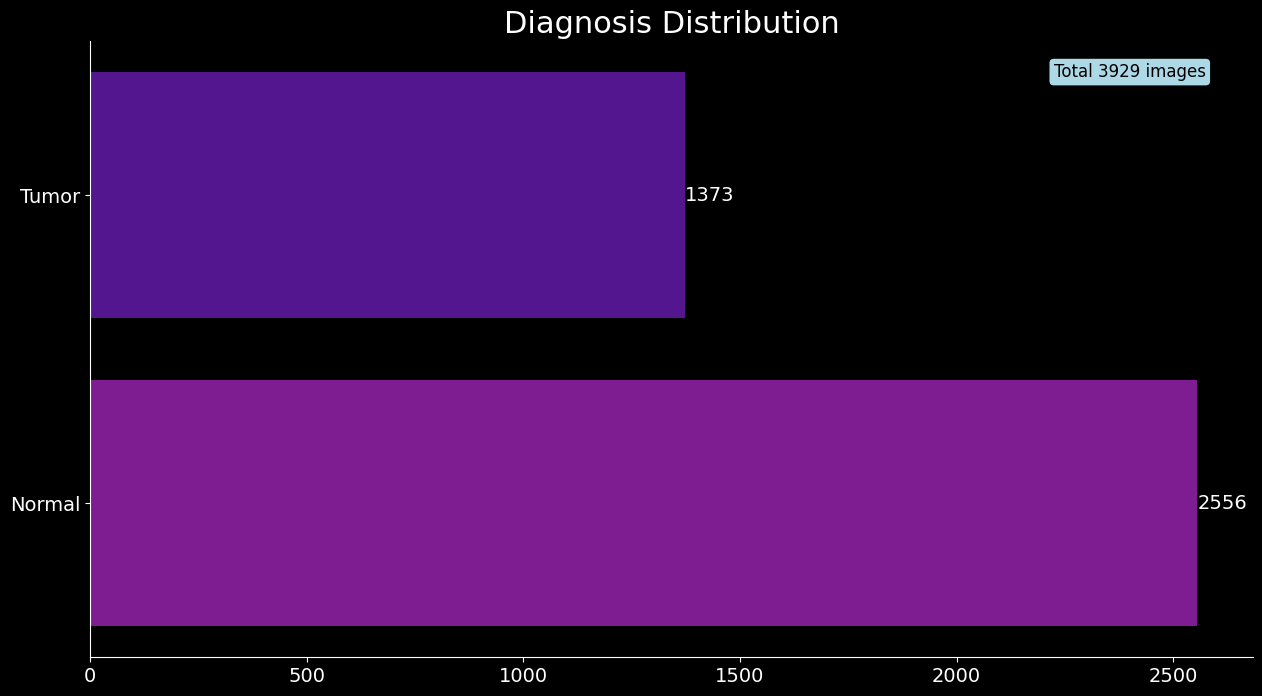

In [ ]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(15, 8))
plt.title('Diagnosis Distribution', fontsize=22);

diagnosis_distribution = ds['diagnosis'].value_counts().sort_values()
diagnosis_map = {0: 'Normal', 1: 'Tumor'}

# Use diagnosis map to generate labels for the bar plot
bar_labels = [diagnosis_map.get(_, 'Unknown') for _ in diagnosis_distribution.keys()]

# Create bar plot
bar_plot = sns.barplot(
    x=diagnosis_distribution.values,
    y=bar_labels,
    palette=sns.color_palette("plasma"),
    orient="h"
)


for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

text_params = {
    'x'       : 2400,
    'y'       : -0.4,
    's'       : f"Total {len(ds)} images",
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center",
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightblue"),ec=("black"))
}
plt.text(**text_params);

sns.despine();

**Load & View Random Sample**

In [ ]:
def view_sample(image, mask, color_map='rgb', fig_size=(16, 8), title_size=18):
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);

    # Plot MRI Image
    plt.subplot(1, 3, 1);
    plt.title(f'MRI Image', fontsize=title_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)

    # Plot Mask
    plt.subplot(1, 3, 2);
    plt.title(f'Mask', fontsize=title_size)
    plt.imshow(mask, cmap='gray');

    # Plot MRI w. Mask
    plt.subplot(1, 3, 3);
    plt.title(f'MRI + Mask', fontsize=title_size)
    gen_mask = np.dstack([mask*0.1, mask*0.4, mask*0.1])

    if color_map=='rgb':
        plt.imshow(image + gen_mask, interpolation='none')
    else:
        plt.imshow(image + gen_mask, interpolation='none', cmap=color_map)

#     plt.imshow(mask, cmap='jet', interpolation='none', alpha=0.4);

    return

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_55.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_55_mask.tif'


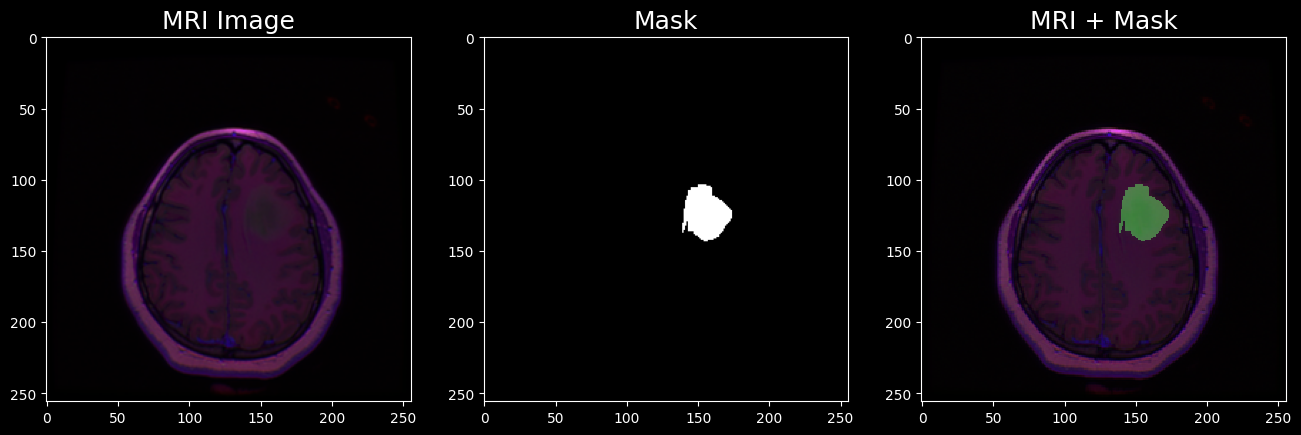

In [ ]:
# Select random sample from train_df
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

# View the random sample
view_sample(
    sample_image,
    sample_mask,
    color_map='rgb',
)

In [ ]:
# Remove rows with diagnosis equal to -1
ds = ds[ds['diagnosis'] != -1]

# Check class distribution after removing the -1 class
class_distribution = ds['diagnosis'].value_counts()
print(class_distribution)


diagnosis
0    2556
1    1373
Name: count, dtype: int64


**Create Train, Validation and Test sets**


In [ ]:
from sklearn.model_selection import train_test_split

# Adjust test size to leave more data for training
train_split_idx, data_split_idx = train_test_split(
    ds.index,
    test_size=0.20,
    stratify=ds.diagnosis,  # Ensure stratified splitting
    random_state=CFG.SEED
)


In [ ]:
train_split_idx, data_split_idx, _, _ = (
    train_test_split(
        ds.index,
        ds.diagnosis,
        test_size=0.30,  # Adjust test size to leave more data for training
        stratify=ds.diagnosis,
        random_state=CFG.SEED
    )
)
# Get training and remaining data
train_df = ds.loc[train_split_idx].reset_index(drop=True)
data_df = ds.loc[data_split_idx].reset_index(drop=True)

# View shapes
print(train_df.shape, data_df.shape)


(2750, 5) (1179, 5)


In [ ]:
# Create Val/Test split
val_split_idx, test_split_idx, _, _ = (
    train_test_split(
        data_df.index,
        data_df.diagnosis,
        test_size=0.65,
        stratify=data_df.diagnosis,
        random_state=CFG.SEED
    )
)

# Get validation and test data
val_df = data_df.loc[val_split_idx].reset_index(drop=True)
test_df = data_df.loc[test_split_idx].reset_index(drop=True)

# View shapes
print(val_df.shape, test_df.shape)



(412, 5) (767, 5)


In [ ]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		2750	(69.99%)
validation samples count:	412	(10.49%)
test samples count:		767	(19.52%)
TOTAL:				3929	(100.00%)


<ipython-input-61-98ac9867fe6b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
<ipython-input-61-98ac9867fe6b>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
<ipython-input-61-98ac9867fe6b>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


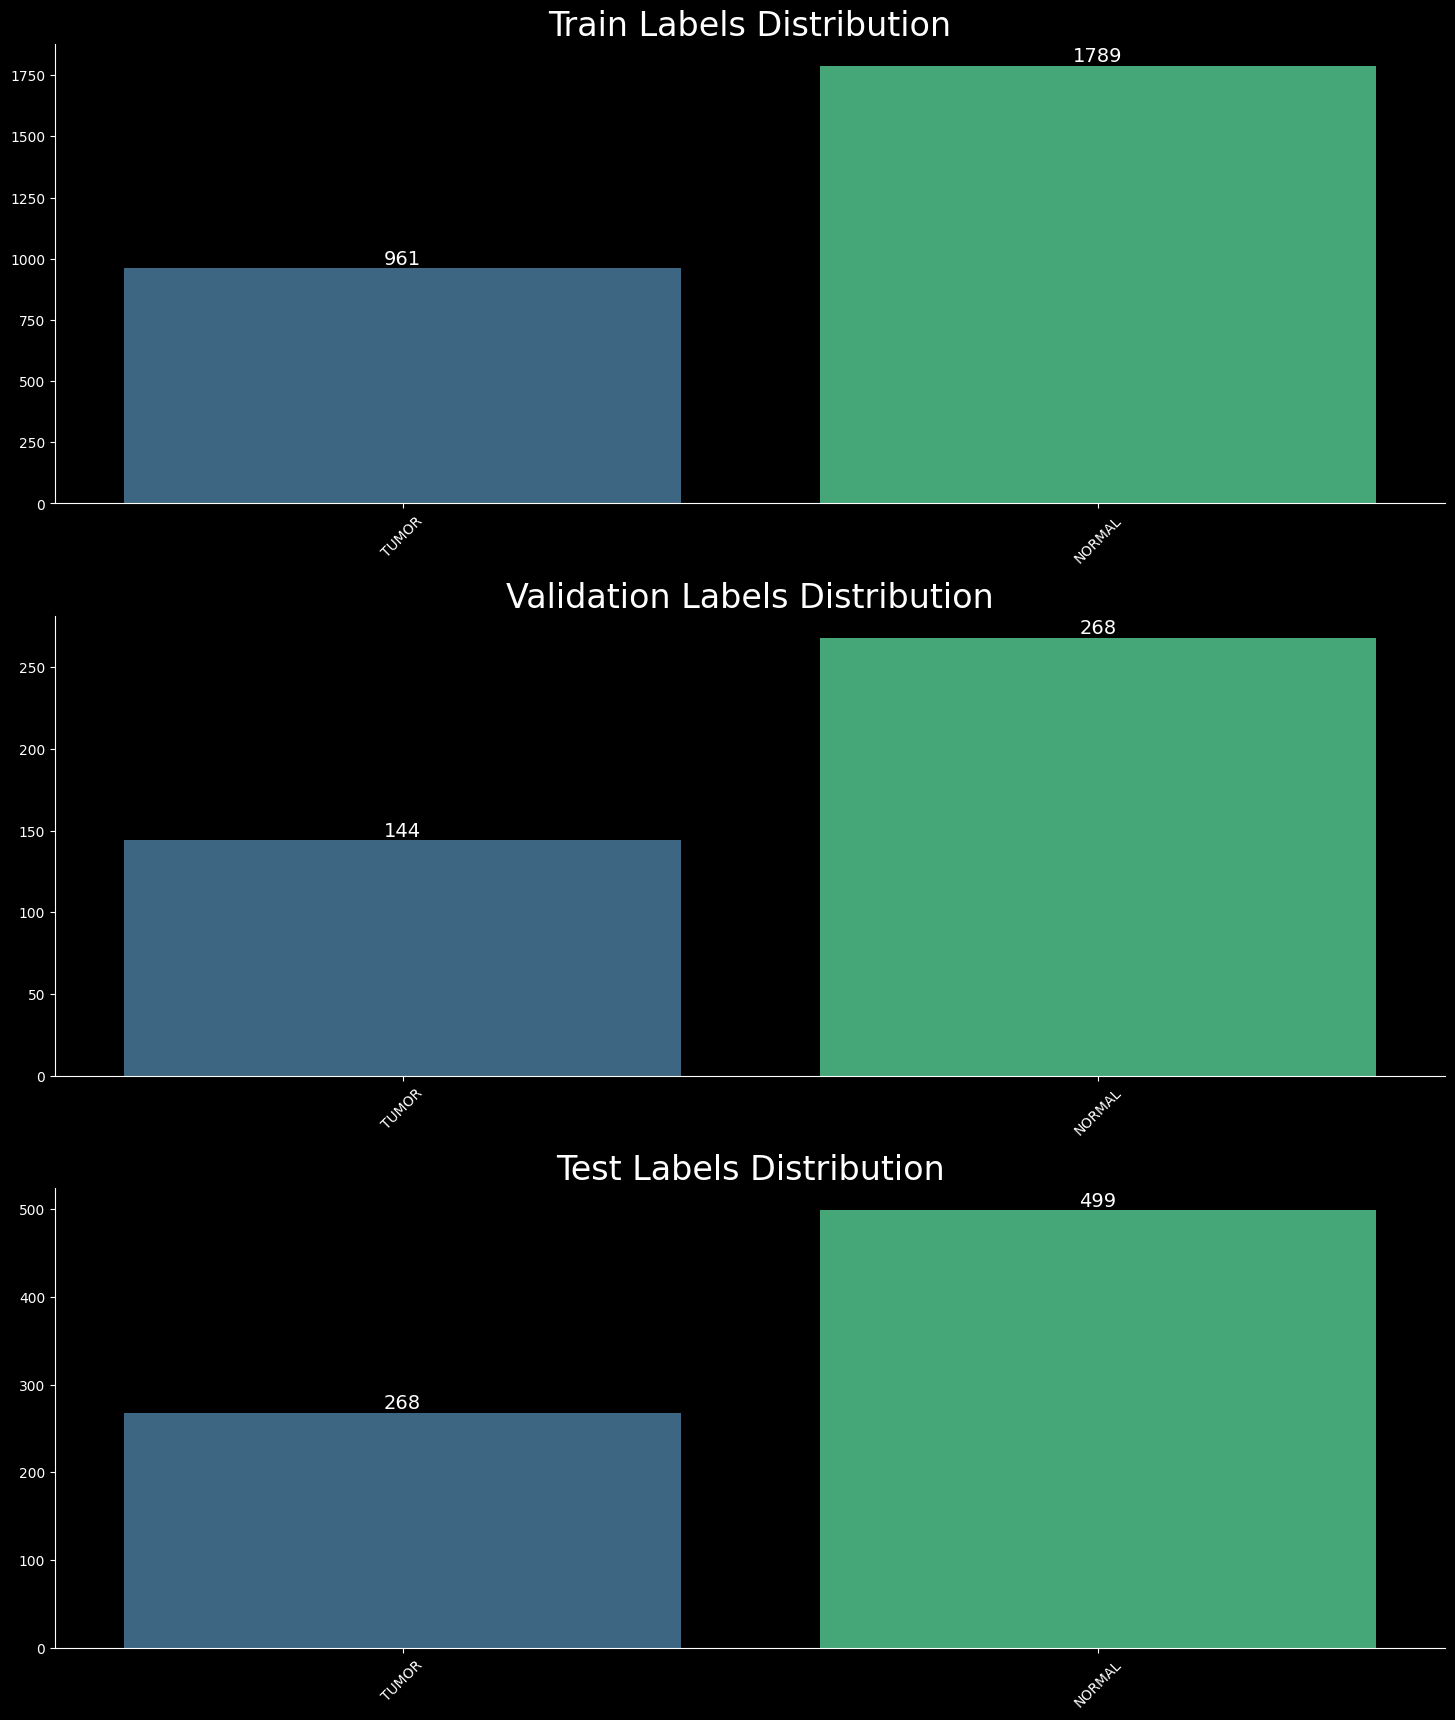

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define new color palette
labels = {0: 'NORMAL', 1: 'TUMOR'}
new_palette = sns.color_palette("viridis", len(labels))

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine()

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=[labels[_] for _ in train_distribution.keys()],
    y=train_distribution.values,
    palette=new_palette,
    ax=ax1
)

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14, label_type='edge')

# Rotate x-axis labels for better readability
ax1.tick_params(axis='x', rotation=45)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=[labels[_] for _ in val_distribution.keys()],
    y=val_distribution.values,
    palette=new_palette,
    ax=ax2
)

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14, label_type='edge')

# Rotate x-axis labels for better readability
ax2.tick_params(axis='x', rotation=45)

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=[labels[_] for _ in test_distribution.keys()],
    y=test_distribution.values,
    palette=new_palette,
    ax=ax3
)

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14, label_type='edge')

# Rotate x-axis labels for better readability
ax3.tick_params(axis='x', rotation=45)

plt.show()


# **2 | Build Custom Datasets & DataLoaders**

**Define & Inspect Image Transforms**

In [ ]:
# Augment train data
train_transforms = A.Compose([
    A.Resize(CFG.HEIGHT, CFG.WIDTH, p=1.0),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

# Only reshape inference data
inference_transforms = A.Compose([
    A.Resize(CFG.HEIGHT, CFG.WIDTH, p=1.0),
    ToTensorV2(),
])

Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_16.tif'
Loading image from '/content/drive/My Drive/ANN dataset/archive (1)/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_16_mask.tif'


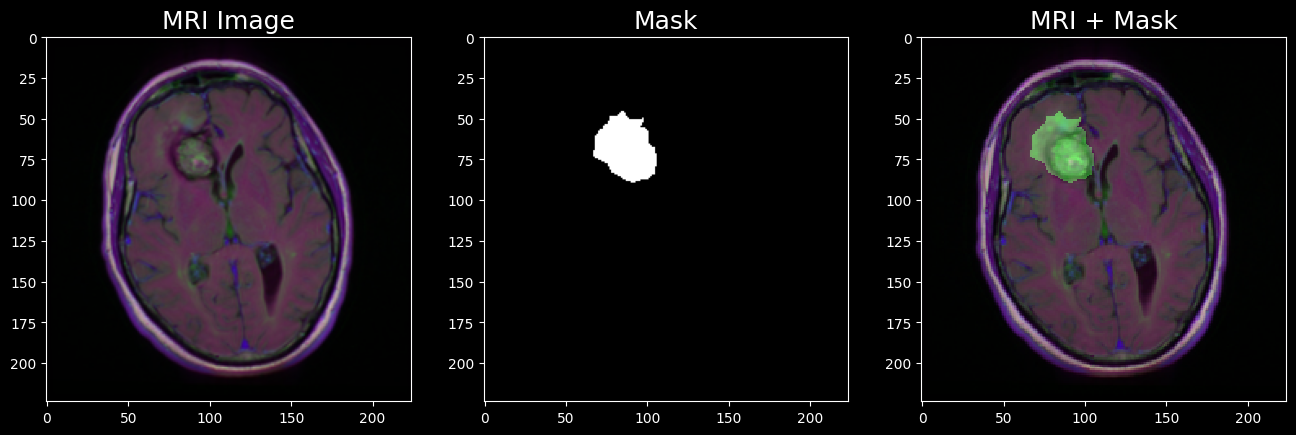

In [ ]:
# Select random sample from train_df
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

aug = train_transforms(image=sample_image, mask=sample_mask)

# View the random sample
view_sample(
    aug['image'].permute(1, 2, 0),
    aug['mask'].unsqueeze_(0).permute(1, 2, 0),
    color_map='mako',
)

In [ ]:
class MRISegmetationDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()

        self.mri_paths = df['image_path'].to_list()
        self.mask_paths = df['mask_path'].to_list()
#         self.labels = df['diagnosis'].to_list()
        self.transform = transform

#         self.classes = sorted(list(df['diagnosis'].unique()))
#         self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}

    def load_sample(self, index:str) -> Image.Image:
        image_path = self.mri_paths[index]
        mask_path = self.mask_paths[index]

        image, mask = Image.open(image_path), Image.open(mask_path)

        image = np.array(image).astype(np.float32) / 255.
        mask = np.array(mask).astype(np.float32) / 255.

        return image, mask

    def __len__(self) -> int:
        return self.mri_paths.__len__()

    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
        image, mask = self.load_sample(index)

        # Transform if necessary
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze_(0)
        else:
            transformed = ToTensorV2()(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze_(0)


**Build Custom Datasets**

In [ ]:
# Build train dataset
train_ds = MRISegmetationDataset(
    train_df, transform=train_transforms
)

# Build validation dataset
val_ds = MRISegmetationDataset(
    val_df, transform=inference_transforms
)

# Build test dataset
test_ds = MRISegmetationDataset(
    test_df, transform=inference_transforms
)

**Build DataLoaders from Custom Datasets**

In [ ]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# **3 | Write Custom Training Functions**

**Define Epoch Execution (Train Step)**

In [ ]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into training mode
    model.train()

    # Initialize train loss & accuracy
    train_loss, train_dice = 0, 0

    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)

        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()

        # Update Model Gradients
        optimizer.step()

        # Compute Batch Metrics
        predicted_class = torch.sigmoid(y_pred)
        predicted_class = (predicted_class > 0.5).float()

        eps = 1e-8
        train_dice += (
            (2 * (y * predicted_class).sum() + eps) /
            ((y + predicted_class).sum() + eps)
        ).cpu().item()


    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_dice = train_dice / len(dataloader)

    return train_loss, train_dice


**Define Evaluation Step**

In [ ]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into eval mode
    model.eval()

    # Initialize eval loss & accuracy
    eval_loss, eval_dice = 0, 0

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()

            # Compute Batch Metrics
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.5).float()

            eps = 1e-8
            eval_dice += (
                (2 * (y * predicted_class).sum() + eps) /
                ((y + predicted_class).sum() + eps)
            ).cpu().item()

    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_dice = eval_dice / len(dataloader)

    return eval_loss, eval_dice

**Construct Training Loop**

In [ ]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:

    # Initialize training session
    session = {
        'loss'            : [],
        'dice_score'      : [],
        'eval_loss'       : [],
        'eval_dice_score' : []
    }

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_dice = execute_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            device
        )

        # Evaluate Model
        eval_loss, eval_dice = evaluate(
            model,
            eval_dataloader,
            loss_fn,
            device
        )

        # Execute schedular step
        current_lr = 0
        if scheduler:
            scheduler.step(eval_loss)
            current_lr = optimizer.param_groups[0]['lr']

        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - dice_score: {train_dice:.4f} - eval_loss: {eval_loss:.4f} - eval_dice_score: {eval_dice:.4f}'

        if scheduler:
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)

        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['dice_score'].append(train_dice)
        session['eval_loss'].append(eval_loss)
        session['eval_dice_score'].append(eval_dice)

    # Return Session Metrics
    return session

**Construct Predict Function**

In [ ]:
def predict(
    model:nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device,
    threshold:float=0.5) -> np.ndarray:

    # Set model into eval mode
    model.eval()

    predictions = []

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)

            # Compute Batch Metrics
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class >= threshold).float()

            # Record prediction
            predictions.append(predicted_class.cpu().numpy())

    return np.vstack(predictions)

# **4 | Implementing U-Net Architecture (Research Paper)**

**Define Double Convolution Block**

In [ ]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=1,
            padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1,
            padding=1, bias=False
        )

        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)


    def forward(self, x):
        # First Convolution
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)

        # Second Convolution
        x = self.conv2(x)
        x = self.batchnorm2(x)

        return self.relu2(x)

**Implement U-Net Model Architecture**

In [ ]:
class UNetModel(nn.Module):
    def __init__(
        self, in_channels:int=3,
        out_channels:int=1,
        block_sizes:Tuple[int]=(64, 128, 256, 512)
    ):
        super(UNetModel, self).__init__()
        # Initialise model encoder & decoder using torch ModuleLists
        self.encoder, self.decoder = nn.ModuleList(), nn.ModuleList()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Create Encoder
        for block_size in block_sizes:
            self.encoder.append(DoubleConvBlock(in_channels, block_size))
            in_channels = block_size

        # Create Decoder
        for block_size in block_sizes[::-1]:
            self.decoder.append(
                nn.ConvTranspose2d(2 * block_size, block_size, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConvBlock(2 * block_size, block_size))

        # Create Bottleneck
        last_blocksize = block_sizes[-1]
        self.bottleneck = DoubleConvBlock(last_blocksize, 2 * last_blocksize)

        # Create Output Layer
        self.output_conv = nn.Conv2d(block_sizes[0], out_channels, kernel_size=1)

    def forward(self, x):
        concatenations = []
        concatenations.append(x)

        # Propagate input downstream (Encode Input)
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            concatenations.append(x)
            x = self.max_pool(x)

        # Execute bottleneck
        x = self.bottleneck(x)
        concatenations = concatenations[::-1]

        # Propagate input upstream (Decode Input) & concatenate layers
        for _ in range(0, len(self.decoder), 2):
            x = self.decoder[_](x)
            encoder_layer = concatenations[_ // 2]

            # Concatenate corrensponding encoder layer to decoder layer output
            concat_layer = torch.cat(
                (encoder_layer, x), dim=1
            )

            x = self.decoder[_ + 1](concat_layer)

        # Return predicted logits
        return self.output_conv(x)

**Generate U-Net Model**

In [ ]:
# Define U-Net Params with modified block sizes
unet_params = {
    'in_channels'    : 3,
    'out_channels'   : 1,
    'block_sizes'    : (32, 64, 128, 256)  # Modify the block sizes as needed
}

# Generate Model & Push to Device
unet_model = UNetModel(**unet_params).to(CFG.DEVICE)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    unet_model = nn.DataParallel(unet_model)


In [ ]:
# View model summary
summary(
    model=unet_model,
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["output_size", "num_params", "trainable"],
    col_width=10,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Output Shape Param #    Trainable
UNetModel (UNetModel)                    [32, 1, 224, 224] --         True
├─ModuleList (encoder)                   --         (recursive) True
│    └─DoubleConvBlock (0)               [32, 32, 224, 224] --         True
│    │    └─Conv2d (conv1)               [32, 32, 224, 224] 864        True
│    │    └─BatchNorm2d (batchnorm1)     [32, 32, 224, 224] 64         True
│    │    └─ReLU (relu1)                 [32, 32, 224, 224] --         --
│    │    └─Conv2d (conv2)               [32, 32, 224, 224] 9,216      True
│    │    └─BatchNorm2d (batchnorm2)     [32, 32, 224, 224] 64         True
│    │    └─ReLU (relu2)                 [32, 32, 224, 224] --         --
├─MaxPool2d (max_pool)                   [32, 32, 112, 112] --         --
├─ModuleList (encoder)                   --         (recursive) True
│    └─DoubleConvBlock (1)               [32, 64, 112, 112] --         True
│    │    └─Conv2d (conv1)        

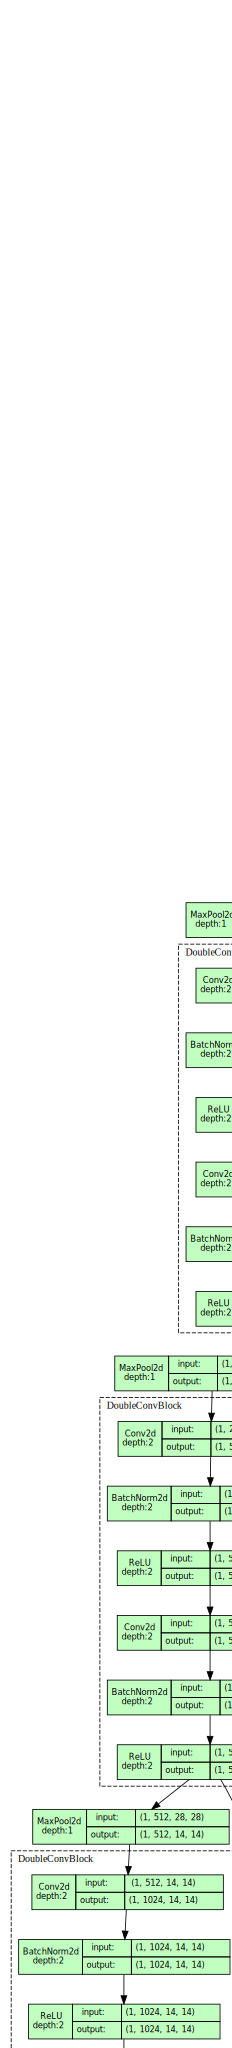

In [ ]:
# Generate Model Computation Graph
model_graph = draw_graph(
    UNetModel(),
    input_size=(1, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    expand_nested=True
)

# View Model Architecture
model_graph.visual_graph

**Initiate Model Loss, Optimizer & LR Scheduler**

In [ ]:
# Define Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Define Optimizer
optimizer = torch.optim.AdamW(
    unet_model.parameters(),
    lr=CFG.LR
)

# Define Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=CFG.PATIENCE,
)

# During training, to access the current learning rate
current_lr = optimizer.param_groups[0]['lr']  # Access learning rate from optimizer
print("Current learning rate:", current_lr)




Current learning rate: 0.0001


**Train U-Net Model**

In [ ]:
print('Training U-Net Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

# Generate training session config
session_config = {
    'model'               : unet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'scheduler'           : scheduler,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

# Execute Training Session
unet_session_history = train(**session_config)

Training U-Net Model
Train on 2750 samples, validate on 412 samples.
----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1/3



  0%|          | 0/86 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

 33%|███▎      | 1/3 [1:20:51<2:41:42, 4851.12s/it]

loss: 0.5616 - dice_score: 0.2016 - eval_loss: 0.4544 - eval_dice_score: 0.3936 - lr: 0.0001

Epoch 2/3



 67%|██████▋   | 2/3 [2:40:54<1:20:22, 4822.89s/it]

loss: 0.4248 - dice_score: 0.3657 - eval_loss: 0.4108 - eval_dice_score: 0.4693 - lr: 0.0001

Epoch 3/3



100%|██████████| 3/3 [4:01:48<00:00, 4836.23s/it]

loss: 0.3898 - dice_score: 0.3927 - eval_loss: 0.3787 - eval_dice_score: 0.3993 - lr: 0.0001


In [ ]:
#CHANGE THE PATH NAME HERE
import os

# Define the dataset path and the model name
DATASET_PATH = "/content/drive/My Drive/ANN dataset/archive (1)/lgg-mri-segmentation/"
model_name = 'unet_model'
model_path = os.path.join(DATASET_PATH, 'models', model_name)

# Create the model directory
os.makedirs(model_path, exist_ok=True)


In [ ]:
# Save Model
torch.save(unet_model, model_path + model_name + '.pth')

In [ ]:
# Generate Test Masks
unet_test_masks = predict(
    unet_model, test_loader,
    CFG.DEVICE, threshold=0.5
)

100%|██████████| 24/24 [07:15<00:00, 18.17s/it]


# **5 | Performance Analysis**

**Plot Training Session Records**

In [ ]:
def plot_training_curves(history, fig_size=(20, 10)):

    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    dice_coeff = np.array(history['dice_score'])
    val_dice_coeff = np.array(history['eval_dice_score'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o', color='C5');
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o', color='C6');

    # Fill area between losses
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C5', alpha=0.4, interpolate=True);
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C6', alpha=0.4, interpolate=True);

    # Add Text & Formats
    ax1.set_title('Loss (Lower Means Better)', fontsize=22);
    ax1.set_xlabel('Epochs', fontsize=18);
    ax1.set_ylabel('Loss', fontsize=18);
    ax1.tick_params(axis='both', which='major', labelsize=14);
    ax1.legend(fontsize=14);

    # Plot metric
    ax2.plot(epochs, dice_coeff, label='training_dice_score', marker='o', color='C5');
    ax2.plot(epochs, val_dice_coeff, label='eval_dice_score', marker='o', color='C6');

    # Fill area between metrics
    ax2.fill_between(epochs, dice_coeff, val_dice_coeff, where=(dice_coeff > val_dice_coeff), color='C5', alpha=0.4, interpolate=True);
    ax2.fill_between(epochs, dice_coeff, val_dice_coeff, where=(dice_coeff < val_dice_coeff), color='C6', alpha=0.4, interpolate=True);

    # Add Text & Formats
    ax2.set_title('Dice Score (Higher Means Better)', fontsize=22);
    ax2.set_xlabel('Epochs', fontsize=18);
    ax2.set_ylabel('Dice Score', fontsize=18);
    ax2.tick_params(axis='both', which='major', labelsize=14);
    ax2.legend(fontsize=14);

    sns.despine();

    return

In [ ]:
# Convert U-Net history dict to DataFrame
unet_session_history_df = pd.DataFrame(unet_session_history)
unet_session_history_df

loss  dice_score  eval_loss  eval_dice_score
0  0.561619    0.201601   0.454350         0.393576
1  0.424833    0.365709   0.410818         0.469312
2  0.389780    0.392724   0.378744         0.399302

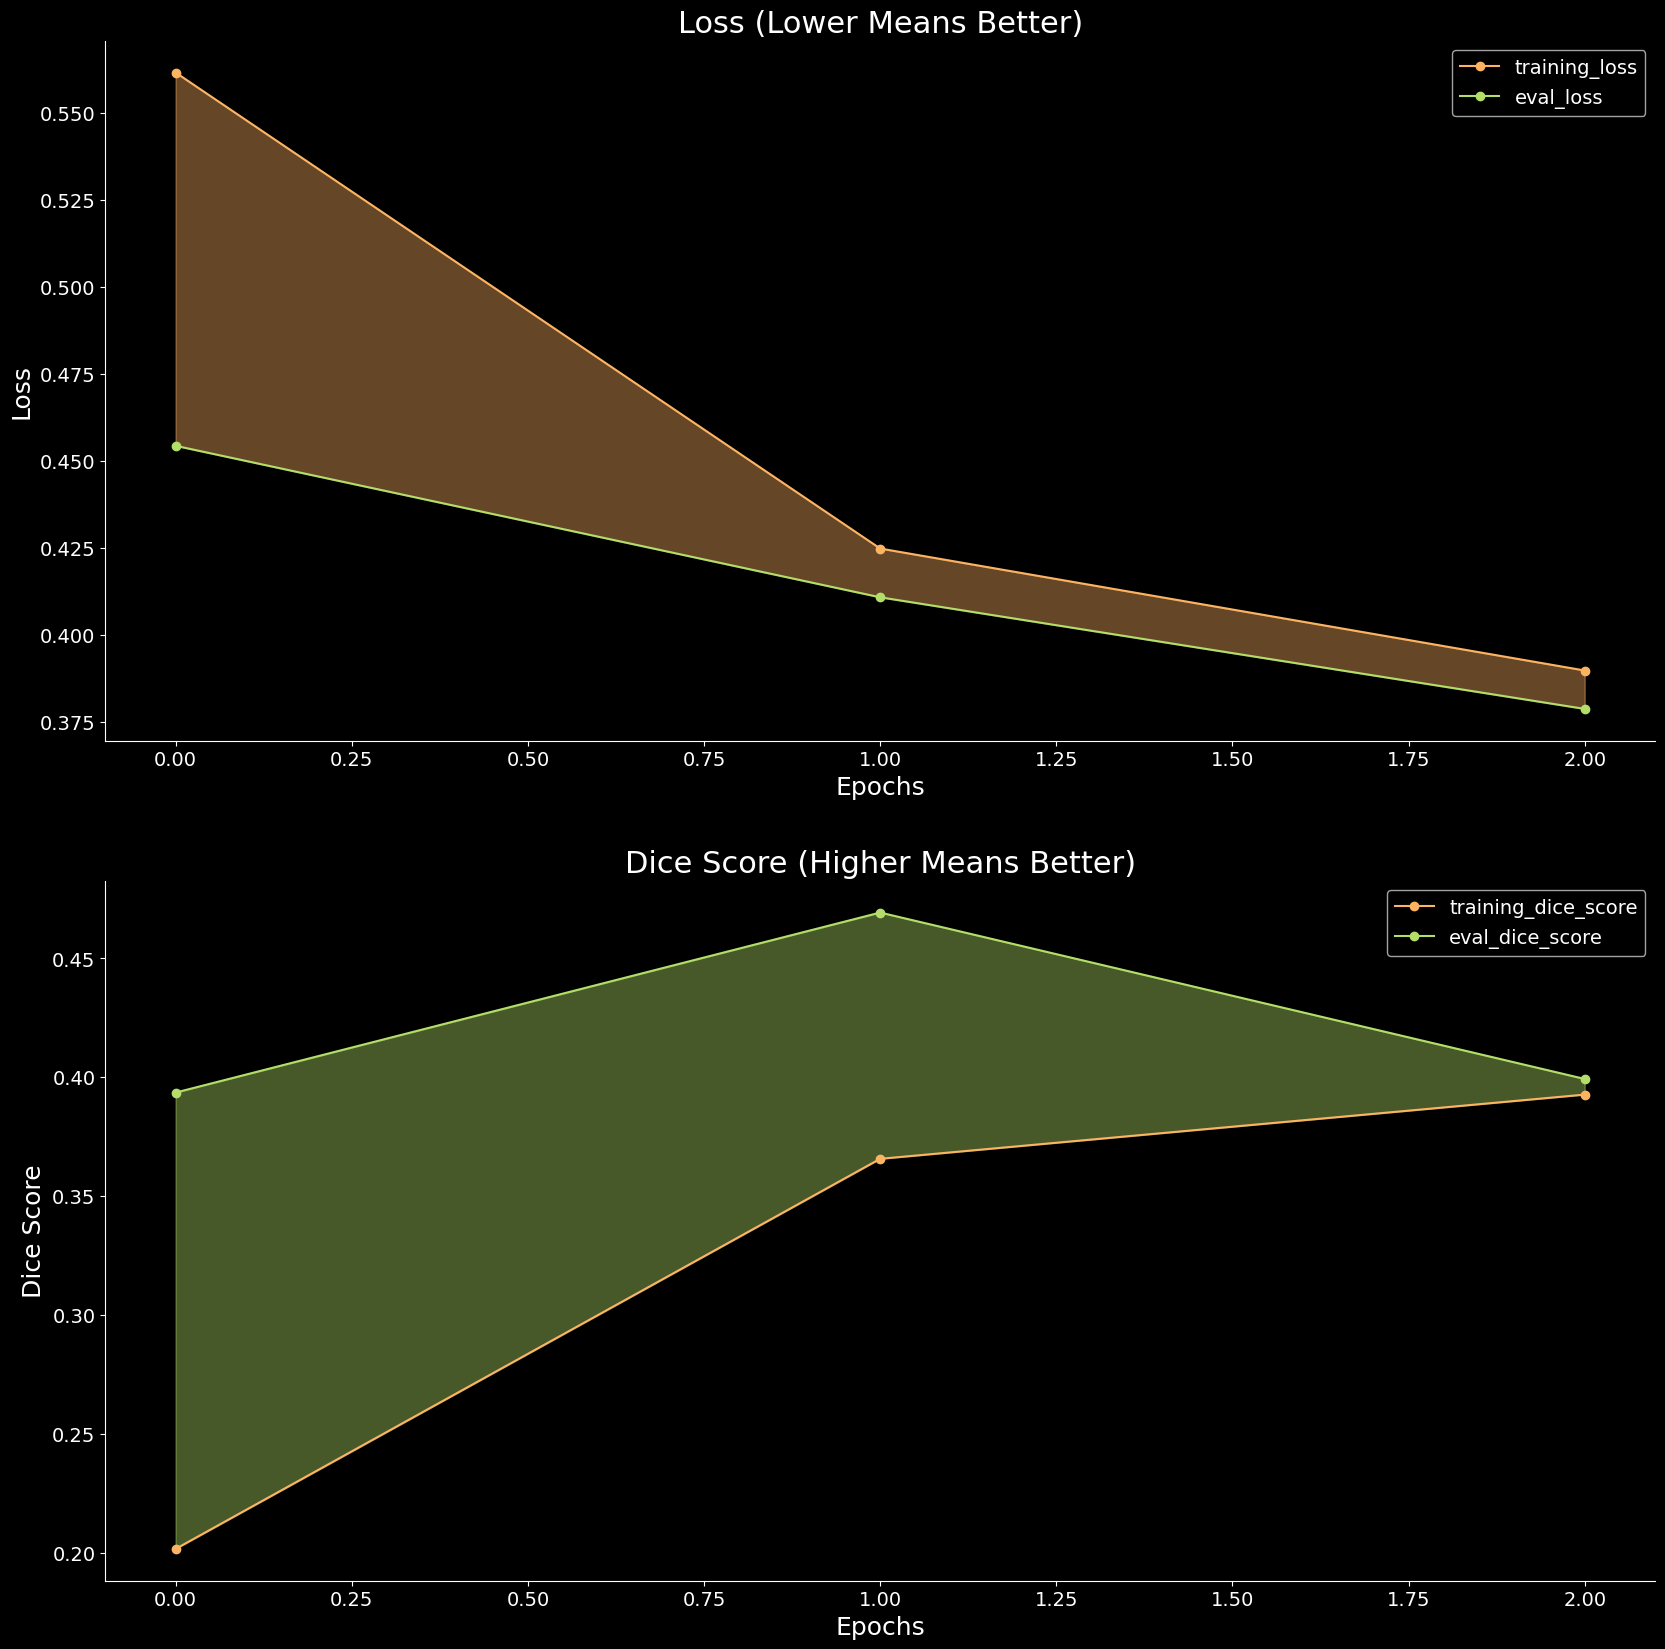

In [ ]:
# Plot U-Net Session Training History
plot_training_curves(
    unet_session_history,
    fig_size=(20, 20)
)

**Generate & Inspect Semantic Segmentation Metrics**

In [ ]:
# def accuracy(y_true, y_pred):
#     intersection = (y_true * y_pred).sum()
#     union = (y_true + y_pred).sum() - intersection
#     xor = (y_true == y_pred).sum()

#     return (xor / (union + xor - intersection))


def precision_(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total_predicted_pixels = y_pred.sum()
    return (intersection / total_predicted_pixels).mean()


def recall_(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total_true_pixels = y_true.sum()
    return (intersection / total_true_pixels).mean()


def dice_score(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    summation = (y_true + y_pred).sum()

    return ((2 * intersection) / (summation + eps))


def jaccard_index(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    union = (y_true + y_pred).sum() - intersection

    return (intersection / (union + eps))

In [ ]:
def compute_metrics(
    model:nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:

    # Initiate Metrics Dict
    metrics = {
        'accuracy'      : [],
        'precision'     : [],
        'recall'        : [],
        'dice_score'    : [],
        'IoU'           : []
    }

    # Set model into eval mode
    model.eval()

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward Input
            y_pred = model(X)

            # Generate Predicted Masks
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.3).float()

            # Compute Batch Metrics For Each Mask
            for true_mask, pred_mask in zip(y, predicted_class):
                acc = ((true_mask == pred_mask).sum() / torch.numel(true_mask)).cpu().item()
                prec = precision_(true_mask, pred_mask).cpu().item()
                rec = recall_(true_mask, pred_mask).cpu().item()
                dice = dice_score(true_mask, pred_mask).cpu().item()
                iou = jaccard_index(true_mask, pred_mask).cpu().item()

                # Record metrics
                metrics['accuracy'].append(acc)
                metrics['precision'].append(prec)
                metrics['recall'].append(rec)
                metrics['dice_score'].append(dice)
                metrics['IoU'].append(iou)

    return metrics

In [ ]:
# Generate Segmentation Metrics
unet_metrics = compute_metrics(
    unet_model, test_loader, CFG.DEVICE
)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 24/24 [07:38<00:00, 17.85s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 24/24 [07:38<00:00, 19.10s/it]


In [ ]:
# Create copy of test df
unet_test_df = test_df.copy()

# Concatenate Metrics onto copied df
unet_test_df = pd.concat(
    (unet_test_df, pd.DataFrame(unet_metrics)),
    axis=1
)

# Generate diagnosis labels
unet_test_df['model_diagnosis'] = [
    int(mask.max()) for mask in unet_test_masks
]

# View df
unet_test_df

id                patient  \
0    22  TCGA_DU_A5TS_19970726   
1    11  TCGA_DU_8165_19970205   
2    58  TCGA_HT_7881_19981015   
3    19  TCGA_DU_5853_19950823   
4     1  TCGA_DU_7298_19910324   
..   ..                    ...   
762  29  TCGA_DU_6399_19830416   
763   4  TCGA_DU_7294_19890104   
764  11  TCGA_HT_8105_19980826   
765  22  TCGA_DU_7014_19860618   
766  58  TCGA_DU_6405_19851005   

                                            image_path  \
0    /content/drive/My Drive/ANN dataset/archive (1...   
1    /content/drive/My Drive/ANN dataset/archive (1...   
2    /content/drive/My Drive/ANN dataset/archive (1...   
3    /content/drive/My Drive/ANN dataset/archive (1...   
4    /content/drive/My Drive/ANN dataset/archive (1...   
..                                                 ...   
762  /content/drive/My Drive/ANN dataset/archive (1...   
763  /content/drive/My Drive/ANN dataset/archive (1...   
764  /content/drive/My Drive/ANN dataset/archive (1...   
765  /content/drive/My Drive/ANN dataset/archive (1...   
766  /content/drive/My Drive/ANN dataset/archive (1...   

                                             mask_path  diagnosis  accuracy  \
0    /content/drive/My Drive/ANN dataset/archive (1...          1  0.452447   
1    /content/drive/My Drive/ANN dataset/archive (1...          0  0.398298   
2    /content/drive/My Drive/ANN dataset/archive (1...          0  0.344388   
3    /content/drive/My Drive/ANN dataset/archive (1...          0  0.385902   
4    /content/drive/My Drive/ANN dataset/archive (1...          0  0.442522   
..                                                 ...        ...       ...   
762  /content/drive/My Drive/ANN dataset/archive (1...          1  0.475486   
763  /content/drive/My Drive/ANN dataset/archive (1...          0  0.401208   
764  /content/drive/My Drive/ANN dataset/archive (1...          0  0.542829   
765  /content/drive/My Drive/ANN dataset/archive (1...          1  0.620635   
766  /content/drive/My Drive/ANN dataset/archive (1...          0  0.001913   

     precision    recall  dice_score       IoU  model_diagnosis  
0     0.002023  0.139594    0.003988  0.001998                0  
1     0.000000       NaN    0.000000  0.000000                0  
2     0.000000       NaN    0.000000  0.000000                0  
3     0.000000       NaN    0.000000  0.000000                0  
4     0.000000       NaN    0.000000  0.000000                0  
..         ...       ...         ...       ...              ...  
762   0.019560  0.996205    0.038366  0.019558                1  
763   0.000000       NaN    0.000000  0.000000                0  
764   0.000000       NaN    0.000000  0.000000                0  
765   0.000000  0.000000    0.000000  0.000000                0  
766   0.000000       NaN    0.000000  0.000000                0  

[767 rows x 11 columns]

In [ ]:
# Get segmentation metrics for all samples
overall_metrics = dict(
    unet_test_df[unet_metrics.keys()]
    .mean()
)

# Get segmentation metrics for non-diagnosed samples
non_diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 0
    ][unet_metrics.keys()].mean()
)

# Get segmentation metrics for diagnosed samples
diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ][unet_metrics.keys()].mean()
)

# Compile metrics into dataframe
segmetation_metrics = pd.DataFrame({
    'overall_metrics': overall_metrics,
    'non_diagnosed_metrics': non_diagnosed_metrics,
    'diagnosed_metrics': diagnosed_metrics,
}).T

# View segmetation metrics df
segmetation_metrics

accuracy  precision    recall  dice_score       IoU
overall_metrics        0.431933   0.020907  0.513668    0.027411  0.017148
non_diagnosed_metrics  0.417672   0.000000       NaN    0.000000  0.000000
diagnosed_metrics      0.458486   0.059834  0.513668    0.078448  0.049077

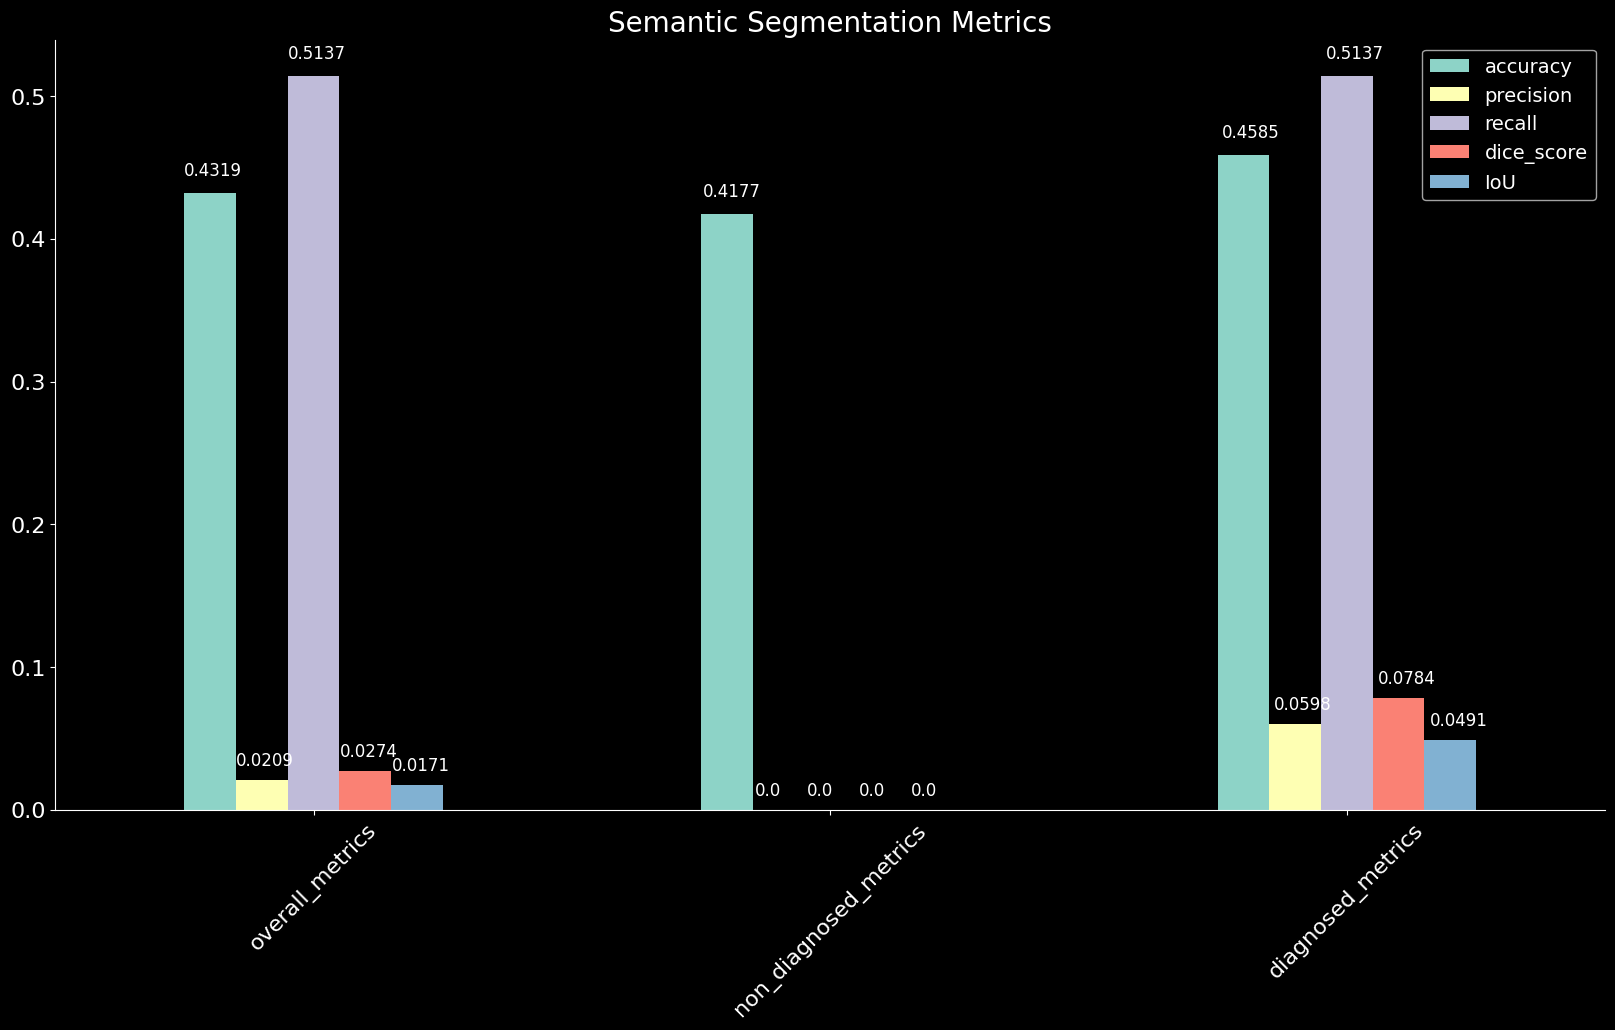

In [ ]:
# Plot segmentation metrics bar plot
ax = segmetation_metrics.plot(
    kind="bar", rot=0,
    figsize=(20, 10)
)

# Add legend
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)

# Display bar values
for p in ax.patches:
    bar_value = p.get_height()
    text = '0.0' if bar_value==0 else f'{bar_value:.4f}'
    ax.annotate(
        text,
        (p.get_x() * 1.005, p.get_height() * 1.005 + 0.01),
        fontsize=12
    )

# Update axes tick parameters
ax.tick_params(
    axis='both', which='major',
    labelsize=16
);

# Rotate x-axis ticks
ax.tick_params(
    axis='x', which='major',
    labelsize=16, rotation=45
);

# Add title & remove top and right borders w. sns.despine
plt.title('Semantic Segmentation Metrics', fontsize=20);
sns.despine();

**Generate Diagnosis Confusion Matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

In [ ]:
# Get Test True Diagnosis Labels
test_labels = unet_test_df['diagnosis'].to_numpy()

# Get Test Predicted Diagnosis Labels
unet_predictions = unet_test_df['model_diagnosis'].to_numpy()

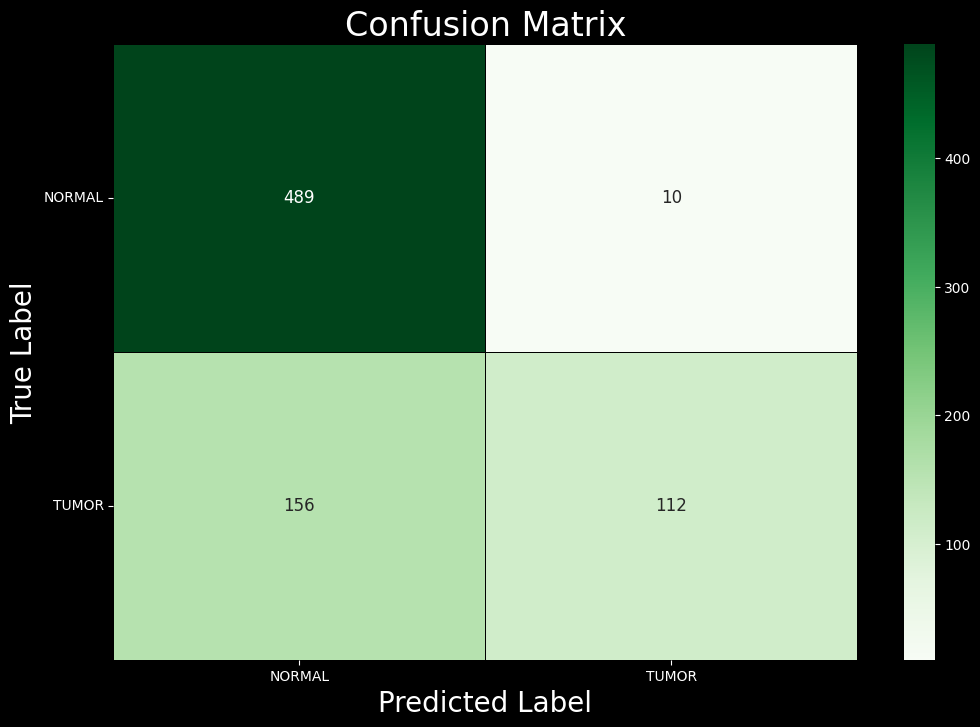

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(
    test_labels,
    unet_predictions,
    figsize=(12, 8),
    classes=['NORMAL', 'TUMOR']
)

**Inspect Diagnosis Classification Metrics**

In [ ]:
print(
    classification_report(
        test_labels,
        unet_predictions,
        target_names=['NORMAL', 'TUMOR']
))

              precision    recall  f1-score   support

      NORMAL       0.76      0.98      0.85       499
       TUMOR       0.92      0.42      0.57       268

    accuracy                           0.78       767
   macro avg       0.84      0.70      0.71       767
weighted avg       0.81      0.78      0.76       767



In [ ]:
def generate_performance_scores(y_true, y_pred, log=True):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    if log:
        print('=============================================')
        print(f'\nPerformance Metrics:\n')
        print('=============================================')
        print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
        print('_____________________________________________')
        print(f'precision_score:\t{model_precision:.4f}\n')
        print('_____________________________________________')
        print(f'recall_score:\t\t{model_recall:.4f}\n')
        print('_____________________________________________')
        print(f'f1_score:\t\t{model_f1:.4f}\n')
        print('_____________________________________________')
        print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
        print('=============================================')

    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Generate U-Net model classification performance scores
unet_model_performance = generate_performance_scores(
    test_labels, unet_predictions, log=True
)


Performance Metrics:

accuracy_score:		0.7836

_____________________________________________
precision_score:	0.8140

_____________________________________________
recall_score:		0.7836

_____________________________________________
f1_score:		0.7569

_____________________________________________
matthews_corrcoef:	0.5187



**View Diagnosed Sample Prediction Masks**


In [ ]:
def view_multiple_predictions(
    model, ds, count=10,
    color_map='rgb',
    fig_size=(14, 10),
    title_size=16):

    # Select random samples
    idx = random.sample(
        list(range(len(ds))),
        count
    )

    # Initialise figure
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);

    # Plot Samples
    for row, _ in enumerate(idx):
        image, mask = ds[_]
        idx = 3 * (row + 1)

        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1);
        plt.title(f'MRI Image', fontsize=title_size);
        if color_map=='rgb':
            plt.imshow(image.permute(1, 2, 0))
        else:
            plt.imshow(image.permute(1, 2, 0), cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2);
        plt.title(f'True Mask', fontsize=title_size)

        gen_mask = np.dstack([mask[0]*0.1, mask[0]*0.45, mask[0]*0.1])
        plt.imshow(image.permute(1, 2, 0) + gen_mask);

        # Generate predicted mask
        mri_input = torch.unsqueeze(
            torch.tensor(image), dim=0
        )

        # Set inferene context manager to active for predictions
        with torch.inference_mode():
            pred_mask = model(mri_input)
            pred_mask = torch.sigmoid(pred_mask).cpu()
            pred_mask = (pred_mask > 0.5) #threshold of 0.5

        # Plot Predicted Mask
        plt.subplot(count+1, 3, idx + 3);
        plt.title(f'Predicted Mask', fontsize=title_size)

        pred_gen_mask = np.dstack([pred_mask[0][0]*0.3, pred_mask[0][0]*0.2, pred_mask[0][0]*0.8])
        plt.imshow(image.permute(1, 2, 0)+ pred_gen_mask);

    return

In [ ]:
# Create Dataset for Diagnosed Sample
test_diagnosed_ds = MRISegmetationDataset(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ].reset_index(drop=True),
    transform=inference_transforms
)

<ipython-input-97-5cb51c48b6b5>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image), dim=0


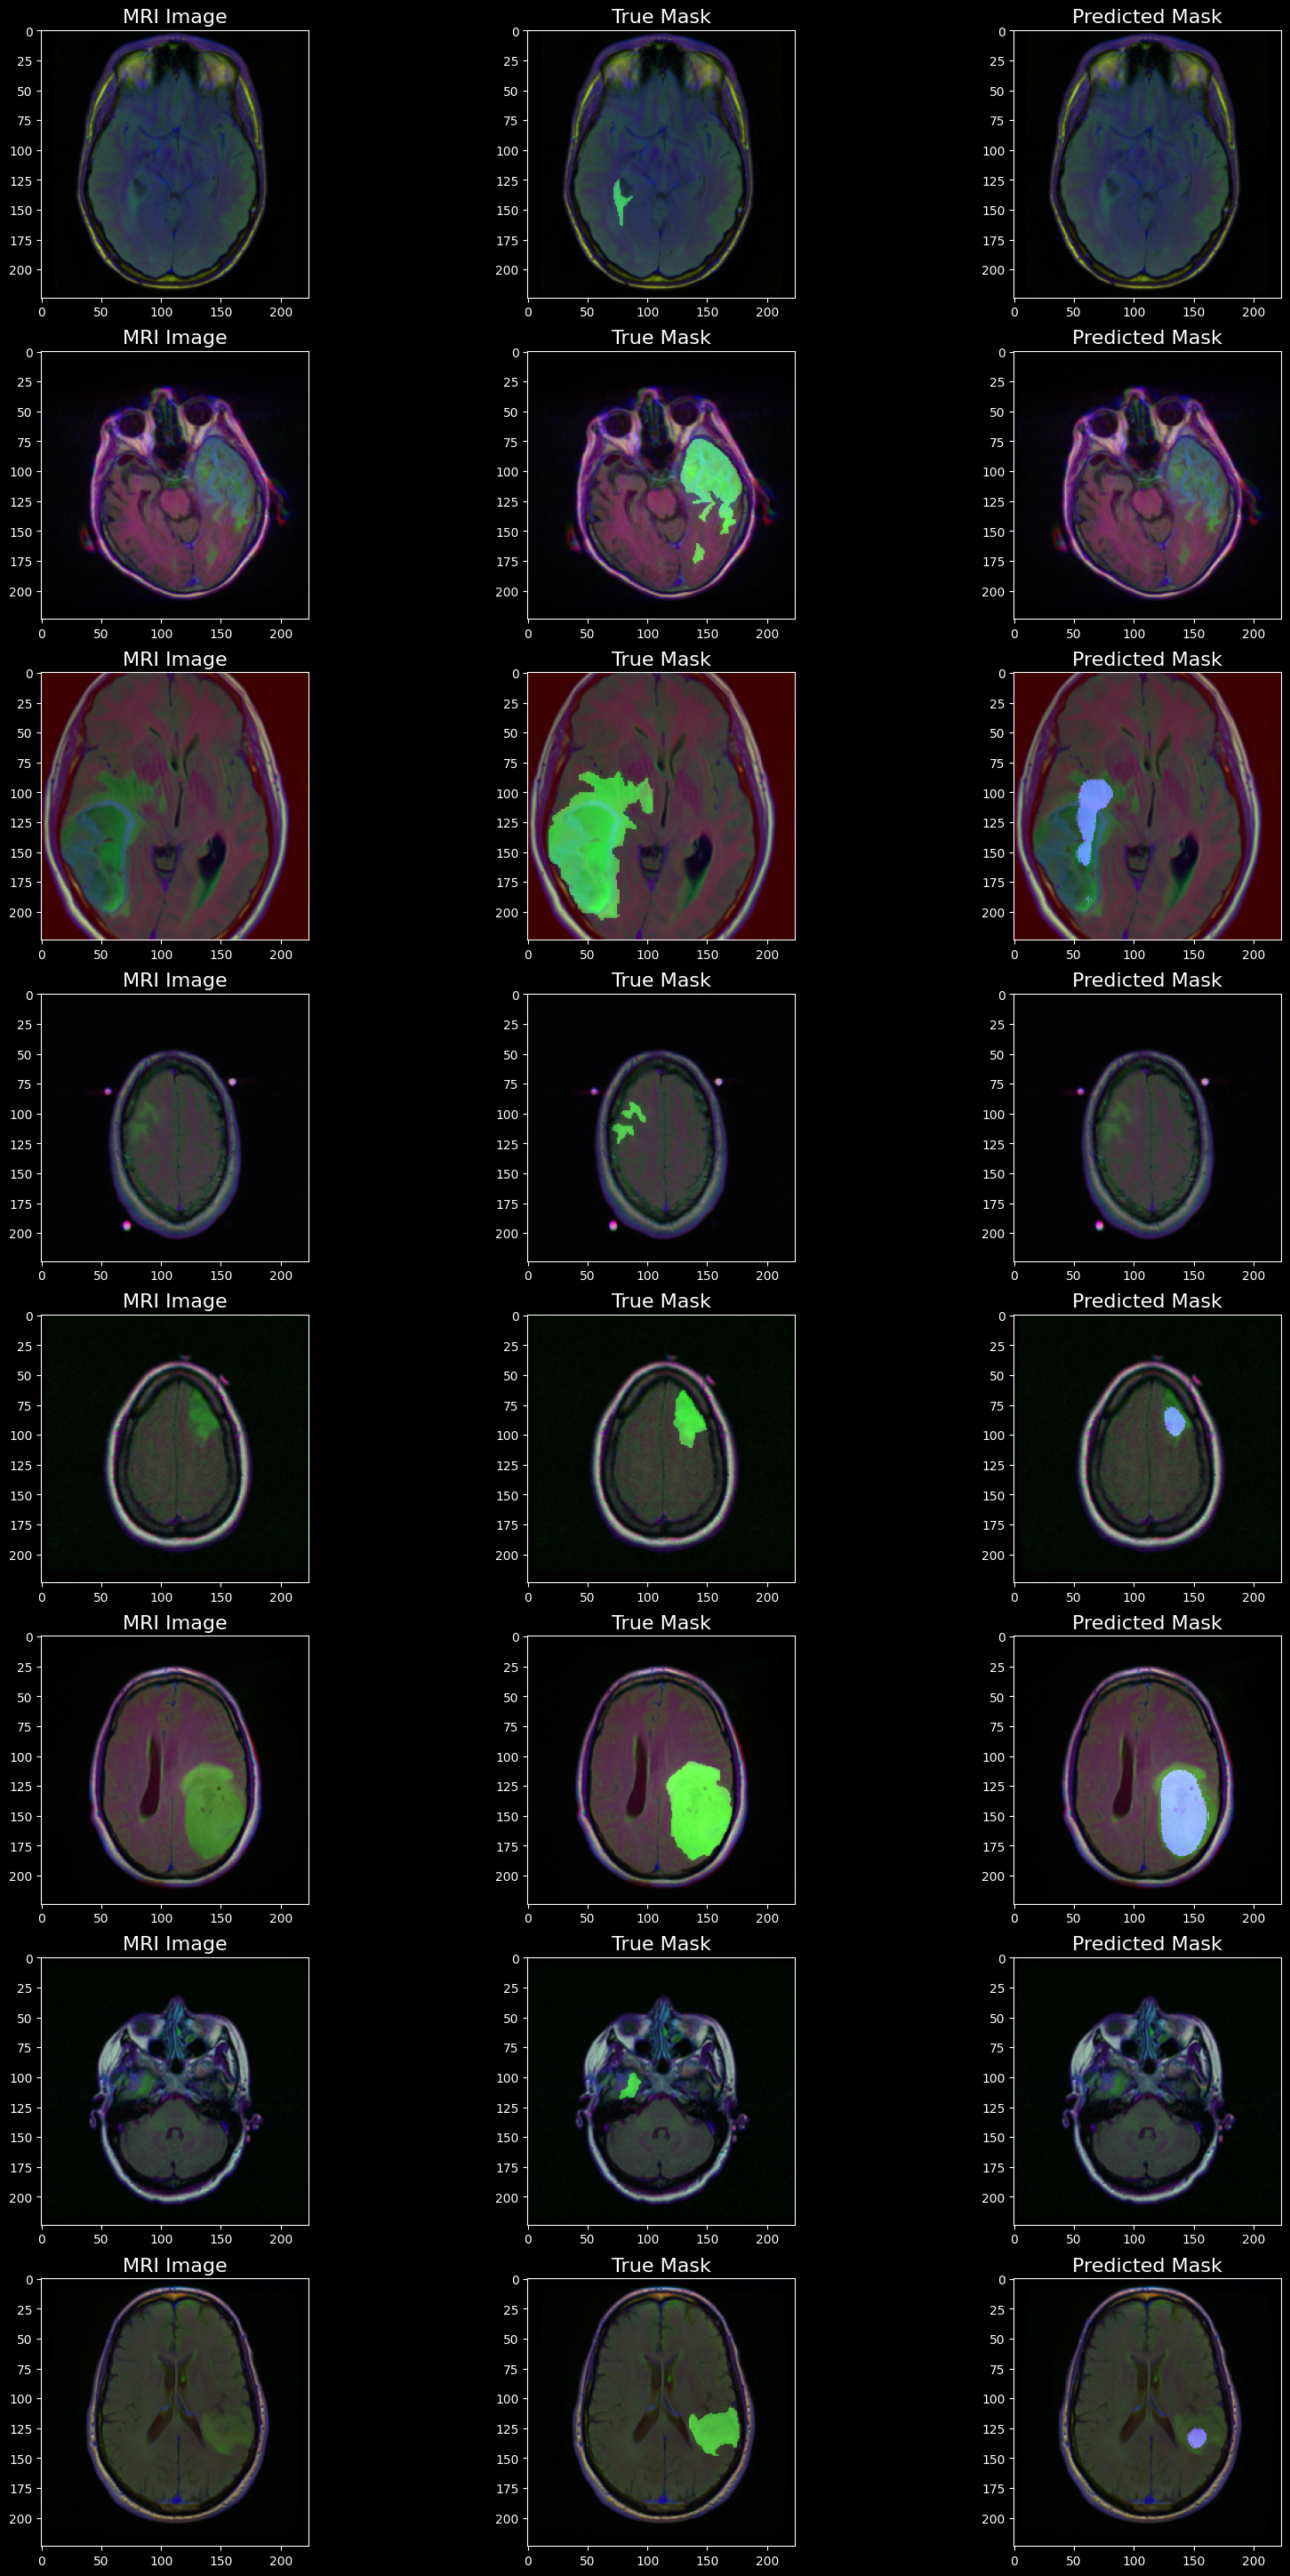

In [ ]:
# View Random Samples
view_multiple_predictions(
    unet_model, test_diagnosed_ds,
    count=8, color_map='rgb',
    fig_size=(20, 38)
)